In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import theseus as th
import copy
from cvae_utilities import *
import copy
import os
import wandb
# Plot with matplotlib
import matplotlib.pyplot as plt


class CVAEWithTrajectoryOptimization(nn.Module):
    def __init__(self, cfg):
        super(CVAEWithTrajectoryOptimization, self).__init__()
        state_dim = cfg.state_dim
        action_dim = cfg.action_dim
        latent_dim_state = cfg.latent_dim_state 
        latent_dim_action = cfg.latent_dim_action
        horizon_action_dim = cfg.horizon * action_dim
        posterior_dim = cfg.posterior_dim
        device = cfg.device
        self.state_encoder = StateEncoder(state_dim, latent_dim_state).to(device)
        self.action_encoder = ActionEncoder(action_dim, latent_dim_action).to(device)
        self.fusing_encoder = FusingEncoder(latent_dim_state, horizon_action_dim, posterior_dim).to(device)
        self.dynamics_function = DynamicsFunction(latent_dim_state, action_dim, posterior_dim).to(device)
        self.action_decoder = ActionDecoder(posterior_dim, latent_dim_state, horizon_action_dim).to(device)
        self.reward_decoder = RewardDecoder(latent_dim_state, action_dim, posterior_dim).to(device)
        self.posterior_dim = posterior_dim
        self.device = device
        self.cfg = cfg

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, zs, za):
        """
        Perform a forward pass through the model.
        Args:
            obs: Observation (raw img input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            action: Action (latent action input), shape [batch_size, horizon * action_dim].
        Returns:
            reconstructed_action: Reconstructed action, shape [batch_size, horizon, action_dim].
            z_mu: Mean of the posterior Gaussian, shape [batch_size, posterior_dim].
            z_logvar: Log-variance of the posterior Gaussian, shape [batch_size, posterior_dim].
            _zs: Predicted next latent state, shape [batch_size, state_dim].
        """
    
        # Encode state and action
        # zs = self.state_encoder(obs, state)
        # za = self.action_encoder(action)

        # Fuse state and action for posterior Gaussian
        z_mu, z_logvar = self.fusing_encoder(zs, za)

        # Sample from posterior Gaussian
        fused_latent = self.reparameterize(z_mu, z_logvar)

        reconstructed_action = self.action_decoder(fused_latent, zs)

        zs_seq = []
        for t in range(self.cfg.horizon):
            _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action[:,2*t:2*(t+1)]), fused_latent)
            zs = _zs
            zs_seq.append(zs)
            fused_latent = _zp
        
        zs_seq = torch.stack(zs_seq, dim=1)

        return reconstructed_action, z_mu, z_logvar, zs_seq
    
    def generate_action(self, zs, zp):
        """
        Generate an action based on the given observation.
        Args:
            obs: Observation (raw state input), shape [batch_size, state_dim].
            state: State (latent state input), shape [batch_size, state_dim].
            z: Latent variable z, shape [batch_size, posterior_dim].
        Returns:
            action: Generated action, shape [batch_size, action_dim].
        """

        # Decode action from latent state and z
        reconstructed_action = self.action_decoder(zp, zs)  # Reconstruct action

        # _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action), zp)
        zs_seq = []
        for t in range(self.cfg.horizon):
            _zs, _zp = self.dynamics_function(zs, self.action_encoder(reconstructed_action[:,2*t:2*(t+1)]), fused_latent)
            zs = _zs
            zs_seq.append(zs)
            fused_latent = _zp
        
        zs_seq = torch.stack(zs_seq, dim=1)

        return reconstructed_action, _zs, _zp

    def save_pretrained(self, save_directory):
        """Save model weights and config to directory"""
        os.makedirs(save_directory, exist_ok=True)
        
        # Save model state dict
        model_path = os.path.join(save_directory, "model.pt")
        torch.save({
            'state_encoder': self.state_encoder.state_dict(),
            'action_encoder': self.action_encoder.state_dict(),
            'fusing_encoder': self.fusing_encoder.state_dict(),
            'dynamics_function': self.dynamics_function.state_dict(),
            'action_decoder': self.action_decoder.state_dict(),
            'reward_decoder': self.reward_decoder.state_dict(),
            'cfg': self.cfg
        }, model_path)

    def load_pretrained(self, load_directory):
        """Load model weights and config from directory"""
        model_path = os.path.join(load_directory, "model.pt")
        if not os.path.exists(model_path):
            raise ValueError(f"Model file not found at {model_path}")
            
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Load model weights
        self.state_encoder.load_state_dict(checkpoint['state_encoder'])
        self.action_encoder.load_state_dict(checkpoint['action_encoder'])
        self.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
        self.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
        self.action_decoder.load_state_dict(checkpoint['action_decoder'])
        self.reward_decoder.load_state_dict(checkpoint['reward_decoder'])
        
        # Load config
        self.cfg = checkpoint['cfg']

    def plan_with_theseus_update(self, obs, state, action, horizon, gamma, cfg, eval_mode=False):
        """
        Perform trajectory optimization using Theseus.
        Args:
            obs: Observation (raw state input).
            horizon: Planning horizon.
            gamma: Discount factor.
            model: The CVAE model containing dynamics and state encoders.
            cfg: Configuration object (for damping, step size, etc.).
            eval_mode: Whether to evaluate without gradients.
        """
        # Prepare initial observation
        batch_size = obs.shape[0]
        obs = obs[:,0,...].clone().detach().requires_grad_(True).to(self.device) # [bs, 3, 96, 96]
        state = state[:,0,...].clone().detach().requires_grad_(True).to(self.device)# [bs, 2]
        action = action.clone().detach().requires_grad_(True).to(self.device) # [bs, horizon * 2]
        horizon = int(min(horizon, cfg.horizon))  # Clip planning horizon

        # Initialize latent state and actions
          # Latent state
        # actions = torch.zeros(batch_size, horizon, cfg.action_dim, device=self.device, requires_grad=True)  # Initial actions

        # Precompute initial actions using policy (if available)
        pi_actions = torch.empty(batch_size, cfg.action_dim * horizon, device=self.device)
        expert_actions = action.view(batch_size, cfg.action_dim * horizon)
        zs = self.state_encoder(obs, state) # 【bs, 50]
        zs0 = zs.clone()

        zp = torch.randn(batch_size, self.posterior_dim, device=self.device)

        # for t in range(horizon):
        #     # pi_actions[:,t] = model.generate_action(obs, state, pz)
        #     if not eval_mode:
        #         za = self.action_encoder(action[:,2*t:2*(horizon+t)]) # [bs, 14]
        #         reconstructed_action, z_mu, z_logvar, (zs0, _) = self.forward(zs0, za) # [bs, 14]
        #         z_mus.append(z_mu)
        #         z_logvars.append(z_logvar)
        #     else:
        #         with torch.no_grad():
        #             reconstructed_action, zs0, zp = self.generate_action(zs0, zp)
        #     pi_actions[:,t] = reconstructed_action
        #     expert_actions[:,t] = action[:,2*t:2*(horizon+t)]


        if not eval_mode:
            za = self.action_encoder(action).view(batch_size, cfg.action_dim * horizon)
            pi_actions, z_mu, z_logvar, zs_seq = self.forward(zs0, za)
        else:
            with torch.no_grad():
                pi_actions = self.action_decoder(zp, zs)
        
        # Define cost function
        def value_cost_fn(optim_vars, aux_vars):
            actions = optim_vars[0].tensor  # [bs, horizon * action_dim]

            obs = aux_vars[0].tensor
            state = aux_vars[1].tensor
            pz = aux_vars[2].tensor

            actions = actions.view(actions.shape[0],  horizon, cfg.action_dim)
            tmp = torch.where(
                torch.abs(actions) > 1,
                (torch.abs(actions) - 1)**2,
                torch.zeros_like(actions)
            )
            actions = torch.clamp(actions, -1, 1) 

            z = self.state_encoder(obs, state)  # Latent state
            total_reward = 0.0
            discount = 1.0
            # pz = torch.randn(batch_size, self.posterior_dim, device=self.device)
            # Compute cumulative reward
            for t in range(horizon):
                reward = self.reward_decoder(z, actions[:,t], pz)
                z, pz = self.dynamics_function(z, actions[:,t], pz)
                total_reward += discount * reward
                discount *= gamma
            # print("tmp")
            # print(torch.clamp(tmp.sum(axis=[1,2]), max=1e3).shape)
            # print(torch.clamp(tmp.sum(axis=[1,2]), max=1e3).mean())
            err = -torch.nan_to_num(total_reward, nan=0.0) + 10# + torch.clamp(tmp.sum(axis=[1,2]), max=1e3).unsqueeze(1) * 100
            return err
        
        all_actions_var = []
        all_obs_var = []
        all_state_var = []
        all_zp = []

        for i in range(batch_size):
            actions_var = th.Vector(tensor = pi_actions[0].view(1, -1), name=f"actions_{i}")
            obs_var = th.Variable(obs[0].unsqueeze(0), name=f"obs_{i}")
            state_var = th.Variable(state[0].unsqueeze(0), name=f"state_{i}")
            posterior = th.Variable(zp[0].unsqueeze(0), name=f"posterior_{i}")
            all_actions_var.append(actions_var)
            all_obs_var.append(obs_var)
            all_state_var.append(state_var)
            all_zp.append(posterior)
        

        objective = th.Objective()
        for i in range(batch_size):
            cost_function = th.AutoDiffCostFunction(
                [all_actions_var[i]],
                value_cost_fn,
                dim=1,
                aux_vars=[all_obs_var[i], all_state_var[i], all_zp[i]],
                name=f"value_cost_fn_{i}",
            )
            objective.add(cost_function)
        optimizer = th.LevenbergMarquardt(
            objective,
            th.CholeskyDenseSolver,
            max_iterations=cfg.max_iterations,
            step_size=cfg.step_size,
        )
        theseus_layer = th.TheseusLayer(optimizer)
        theseus_layer.to(device=self.device)



        def construct_theseus_layer_inputs():
            theseus_inputs = {}
            for i in range(batch_size):
                theseus_inputs.update({
                    f"actions_{i}": pi_actions[i].view(1, -1),
                    f"obs_{i}": obs[i].unsqueeze(0), 
                    f"state_{i}": state[i].unsqueeze(0), 
                    f"posterior_{i}": zp[i].unsqueeze(0)})
            return theseus_inputs

        # Solve optimization problem
        theseus_input = construct_theseus_layer_inputs()
        updated_inputs, info = theseus_layer.forward(
            theseus_input,
            optimizer_kwargs={
                "track_best_solution": True,
                "damping": cfg.damping,
                "verbose": False,
                "backward_mode" : "implicit",
                "backward_num_iterations":10,
            },
        )

        batch_best_actions = []
        batch_updated_actions = []

        for i in range(batch_size):
            best_actions = info.best_solution[f"actions_{i}"]#.view(horizon, cfg.action_dim)
            updated_actions = updated_inputs[f"actions_{i}"].nan_to_num_(0)#.view(horizon, cfg.action_dim)
            batch_best_actions.append(best_actions)
            batch_updated_actions.append(updated_actions)

        batch_best_actions_tensor = torch.stack(batch_best_actions).squeeze(1)
        batch_updated_actions_tensor = torch.stack(batch_updated_actions).squeeze(1)

        if not eval_mode:
            # bc_loss = F.mse_loss(updated_actions[:,:1,:], expert_actions[:,:1,:])
            print(batch_updated_actions_tensor.min())
            print(batch_updated_actions_tensor.max())
            elbo_loss, recon_loss = compute_elbo_loss(batch_updated_actions_tensor, expert_actions, z_mu, z_logvar, cfg.beta)
            # bc_loss = F.mse_loss(batch_best_actions_tensor[:,:,:6], expert_actions[:,:,:6].cpu())
            output_dict = {
                "best_actions": batch_best_actions_tensor,
                "elbo_loss": elbo_loss,
                "recon_loss": recon_loss
            }
        else:
            bc_loss = F.mse_loss(batch_best_actions_tensor, expert_actions.cpu(),reduction = "mean")
            output_dict = {
                "bc_loss": bc_loss,
                "best_actions": batch_best_actions_tensor,
            }
        return output_dict


In [34]:
# # Example Usage
class Config:
    def __init__(self):
        self.horizon = 7
        self.action_dim = 2
        # Theseus optimization parameters
        self.max_iterations = 50
        self.step_size = 1e-2
        self.damping = 1e-3
        self.min_std = 1e-4
        self.discount = 0.99
        self.state_dim = 512*3*3 + 2
        self.batch_size = 16
        self.latent_dim_state = 50
        self.latent_dim_action = self.action_dim
        self.posterior_dim = 64
        self.device = torch.device("cuda")
        self.beta = 1.0
cfg = Config()
device = cfg.device

# Create CVAE model
model = CVAEWithTrajectoryOptimization(cfg)

# Example observation
obs = torch.randn(cfg.batch_size,1,3,96,96).to(device)
state = torch.randn(cfg.batch_size,1,2).to(device)
action = torch.randn(cfg.batch_size,7,2).to(device)
# obs = (obs, state)

# Perform trajectory optimization with Theseus
output_dict = model.plan_with_theseus_update(obs, state, action, horizon=cfg.horizon, gamma=cfg.discount, cfg=cfg, eval_mode=False)
# print("Optimized Actions:", optimized_actions)


tensor(-1.4951, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7348, device='cuda:0', grad_fn=<MaxBackward1>)


In [35]:
# Set up the the policy.
# Policies are initialized with a configuration class, in this case `DiffusionConfig`.
# For this example, no arguments need to be passed because the defaults are set up for PushT.
# If you're doing something different, you will likely need to change at least some of the defaults.

import wandb
import os
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
import torch
from torch.utils.data import random_split
import numpy as np
from lerobot.common.datasets.sampler import EpisodeAwareSampler
import tqdm
import gymnasium as gym
import gym_pusht

# Set PyTorch memory allocation config to avoid fragmentation
torch.cuda.set_per_process_memory_fraction(0.9)  # Limit max memory usage to 80%
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config_dict = {
        "horizon": 7,
        "action_dim": 2,
        "state_dim": 512*3*3 + 2,
        "batch_size": 64,  # Reduced batch size
        "latent_dim_state": 50,
        "latent_dim_action": 2,  # Same as action_dim
        "posterior_dim": 64,
        "beta": 10.0,
        "num_epochs": 100,
        "learning_rate": 3e-4,
        "max_iterations": 50,
        "step_size": 1e-4,
        "damping": 1e-3,
        "min_std": 1e-4,
        "discount": 0.9,
        "log_freq": 1,
        "eval_freq": 20,  # Evaluate every 100 steps
        "output_directory": "./output",
        "device": "cuda:0",
        "gradient_accumulation_steps": 4,  # Increased to compensate for smaller batch size
        "online_eval_episodes": 10,  # Number of episodes for online evaluation
    }

config = Config(config_dict)

# Initialize wandb first with all configuration parameters
wandb.init(
    project="difftop-training",
    config=config_dict,
    resume=True
)

device = torch.device("cuda")
policy = CVAEWithTrajectoryOptimization(config)

# Load previous checkpoint if exists
if os.path.exists(f"{wandb.config.output_directory}/best_model"):
    print("Loading previous checkpoint...")
    policy.load_pretrained(f"{wandb.config.output_directory}/best_model")

policy.train()
policy.to(device)

optimizer = torch.optim.Adam(policy.parameters(), lr=wandb.config.learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

# Set up the dataset
delta_timestamps = {
    "observation.image": [0.0],
    "observation.state": [0.0],
    "action": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
}

dataset = LeRobotDataset("lerobot/pusht_image", delta_timestamps=delta_timestamps)

episode_indices_to_use = np.arange(dataset.num_episodes)
test_episode_indices = np.random.choice(episode_indices_to_use, 10, replace=False)
train_episode_indices = np.setdiff1d(episode_indices_to_use, test_episode_indices)

train_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=train_episode_indices, shuffle=True)
test_sampler = EpisodeAwareSampler(dataset.episode_data_index, episode_indices_to_use=test_episode_indices, shuffle=True)

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=2,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=train_sampler,
    pin_memory=True,
    drop_last=True,
)

eval_dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=1,  # Reduced number of workers
    batch_size=wandb.config.batch_size,
    sampler=test_sampler,
    pin_memory=True,
    drop_last=True,
)

def evaluate(policy, eval_dataloader):
    torch.cuda.empty_cache()  # Clear cache before evaluation
    policy.eval()
    total_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in tqdm.tqdm(eval_dataloader, desc="Evaluating"):
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
            obs = batch['observation.image']
            state = batch['observation.state']/512 * 2 - 1
            action = batch['action']/512 * 2 - 1
            output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config, eval_mode=True)
            total_loss += output_dict["bc_loss"].item()
            num_batches += 1
            if num_batches >= 5:  # Limit eval to 5 batches
                break
            del output_dict  # Explicitly delete to free memory
            torch.cuda.empty_cache()
    policy.train()
    return total_loss / num_batches

import collections
def online_evaluate(policy, num_episodes=5):
    """Evaluate policy in the actual environment"""
    policy.eval()
    env = gym.vector.make(
        "gym_pusht/PushT-v0",
        num_envs=num_episodes,
        obs_type="pixels_agent_pos",
        max_episode_steps=200,
    )    
    
    total_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    last_rewards = np.zeros(num_episodes)
    
    batch_observations, _ = env.reset(seed=42)
    done = [False] * num_episodes
    
    pbar = tqdm.tqdm(total=200, desc="Online evaluation")  # Max episode steps
    
    # Action queues for each environment
    action_queues = [collections.deque() for _ in range(num_episodes)]
    
    while not all(done):
        actions = np.zeros((num_episodes, 2))
        
        for i in range(num_episodes):
            if not done[i]:
                if len(action_queues[i]) == 0:
                    # Prepare observation for the policy
                    state = torch.from_numpy(batch_observations["agent_pos"][i])
                    image = torch.from_numpy(batch_observations["pixels"][i])
                    
                    state = state.to(torch.float32)
                    image = image.to(torch.float32) / 255
                    image = image.permute(2, 0, 1)
                    
                    state = state.to(device, non_blocking=True)
                    image = image.to(device, non_blocking=True)
                    action = torch.randn(1,7,2).cuda()
                    
                    state = state.unsqueeze(0).unsqueeze(0)/512 * 2 - 1
                    obs = image.unsqueeze(0).unsqueeze(0)
                    
                    # Get next actions
                    with torch.inference_mode():
                        output_dict = policy.plan_with_theseus_update(obs, state, action, 7, wandb.config.discount, wandb.config, eval_mode=True)
                    
                    # Add actions to queue
                    actions_pred = output_dict['best_actions'][0].reshape(7, 2)[0]
                    for act in actions_pred:
                        numpy_act = (act.cpu().numpy() + 1)/2 * 512
                        action_queues[i].append(numpy_act)
                
                # Get next action from queue
                actions[i] = action_queues[i].popleft()
        
        # Step environment
        batch_observations, rewards, terminated, truncated, _ = env.step(actions)
        
        # Update metrics
        for i in range(num_episodes):
            if not done[i]:
                total_rewards[i] += rewards[i]
                last_rewards[i] = rewards[i]
                episode_lengths[i] += 1
                done[i] = terminated[i] or truncated[i]
        
        pbar.update(1)
    
    pbar.close()
    policy.train()
    return last_rewards.mean(), episode_lengths.mean()

# Training loop by epoch
best_eval_loss = float('inf')
best_online_reward = float('-inf')
global_step = 0

for epoch in range(wandb.config.num_epochs):
    print(f"Epoch {epoch+1}/{wandb.config.num_epochs}")
    epoch_loss = 0
    num_batches = 0
    optimizer.zero_grad()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_dataloader, desc=f"Epoch {epoch+1}")):
        torch.cuda.empty_cache()  # Clear cache before each batch
        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        obs = batch['observation.image']
        assert (obs >= 0).all() and (obs <= 1).all(), "image should be normalized to [0,1]"
        state = batch['observation.state']/512 * 2 - 1
        action = batch['action']/512 * 2 - 1
        output_dict = policy.plan_with_theseus_update(obs, state, action, horizon=wandb.config.horizon, gamma=wandb.config.discount, cfg=wandb.config)
        loss = output_dict["elbo_loss"] / wandb.config.gradient_accumulation_steps
        bc_loss = output_dict["recon_loss"] / wandb.config.gradient_accumulation_steps
        loss.backward()
        epoch_loss += loss.item() * wandb.config.gradient_accumulation_steps
        num_batches += 1

        # Log the min and max of the best actions
        best_actions = output_dict['best_actions'][0].reshape(7, 2)
        wandb.log({
            "train/min_best_action": best_actions.min(),
            "train/max_best_action": best_actions.max()
        })

        # Free memory
        del output_dict
        torch.cuda.empty_cache()

        if (batch_idx + 1) % wandb.config.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
            
            if batch_idx % wandb.config.log_freq == 0:
                current_lr = scheduler.get_last_lr()[0]
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {loss.item():.3f}, LR: {current_lr:.6f}")
                wandb.log({
                    "train/batch_loss": loss.item(),
                    "train/bc_loss":bc_loss.item(),
                    "train/learning_rate": current_lr,
                    "train/batch": batch_idx + 1,
                    "train/global_step": global_step
                })


            # Evaluate every eval_freq steps
            if global_step % wandb.config.eval_freq == 0:
                # Offline evaluation
                eval_loss = evaluate(policy, eval_dataloader)
                print(f"Step {global_step} Eval Loss: {eval_loss:.3f}")
                
                # Online evaluation
                mean_reward, mean_length = online_evaluate(policy, num_episodes=wandb.config.online_eval_episodes)
                print(f"Online Eval - Mean Reward: {mean_reward:.3f}, Mean Episode Length: {mean_length:.1f}")
                
                wandb.log({
                    "eval/loss": eval_loss,
                    "eval/online_reward": mean_reward,
                    "eval/episode_length": mean_length,
                    "eval/global_step": global_step
                })

                # Save best model based on both metrics
                if eval_loss < best_eval_loss or mean_reward > best_online_reward:
                    best_eval_loss = min(eval_loss, best_eval_loss)
                    best_online_reward = max(mean_reward, best_online_reward)
                    policy.save_pretrained(f"{wandb.config.output_directory}/best_model")
                    wandb.log({
                        "eval/best_loss": best_eval_loss,
                        "eval/best_online_reward": best_online_reward,
                        "eval/best_step": global_step
                    })

            global_step += 1

    # End of epoch
    avg_epoch_loss = epoch_loss / num_batches
    print(f"Epoch {epoch+1} Average Loss: {avg_epoch_loss:.3f}")
    wandb.log({
        "train/epoch_loss": avg_epoch_loss,
        "train/epoch": epoch + 1
    })

# Save final policy checkpoint
policy.save_pretrained(wandb.config.output_directory)
wandb.finish()


train/batch,▁▂▃▃▄▅▆▆▇█
train/batch_loss,█▂▁▁▁▁▁▁▁▁
train/bc_loss,█▂▁▁▁▁▁▁▁▁
train/global_step,▁▂▃▃▄▅▆▆▇█
train/learning_rate,▇▅▃▁██▇▆▅▄
train/batch,40
train/batch_loss,10.19926
train/bc_loss,7.13387
train/global_step,9
train/learning_rate,0.00015


Epoch 1/100


Epoch 1:   0%|          | 1/378 [00:06<39:26,  6.28s/it]

tensor(-80.9496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.0260, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   1%|          | 2/378 [00:10<32:50,  5.24s/it]

tensor(-85.7922, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.7723, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   1%|          | 3/378 [00:15<30:43,  4.92s/it]

tensor(-83.4479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.1799, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-81.7506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.3000, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 4, Loss: 459.002, LR: 0.000271


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.80s/it]

Step 0 Eval Loss: 314.970



/home/lawrence/anaconda3/envs/lerobot/lib/python3.10/site-packages/gymnasium/vector/__init__.py:53: UserWarning: WARN: `gymnasium.vector.make(...)` is deprecated and will be replaced by `gymnasium.make_vec(...)` in v1.0
  gym.logger.warn(
Epoch 1:   1%|          | 4/378 [02:49<6:36:58, 63.69s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:   1%|▏         | 5/378 [02:53<4:23:48, 42.44s/it]

tensor(-0.1128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.6716, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   2%|▏         | 6/378 [02:58<3:03:08, 29.54s/it]

tensor(0.3126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.2017, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   2%|▏         | 7/378 [03:03<2:12:29, 21.43s/it]

tensor(0.8240, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.4075, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   2%|▏         | 8/378 [03:07<1:39:10, 16.08s/it]

tensor(1.1556, device='cuda:0', grad_fn=<MinBackward1>)
tensor(32.9106, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 8, Loss: 95.363, LR: 0.000197


Epoch 1:   2%|▏         | 9/378 [03:12<1:16:45, 12.48s/it]

tensor(0.7683, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6901, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   3%|▎         | 10/378 [03:16<1:01:18,  9.99s/it]

tensor(0.7116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.1904, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   3%|▎         | 11/378 [03:21<50:36,  8.27s/it]  

tensor(0.6977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.1814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   3%|▎         | 12/378 [03:25<43:29,  7.13s/it]

tensor(0.7505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6392, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 12, Loss: 40.833, LR: 0.000104


Epoch 1:   3%|▎         | 13/378 [03:30<38:45,  6.37s/it]

tensor(0.6073, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6852, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   4%|▎         | 14/378 [03:34<35:38,  5.88s/it]

tensor(0.5254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.7881, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   4%|▍         | 15/378 [03:39<33:26,  5.53s/it]

tensor(0.5641, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.9530, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   4%|▍         | 16/378 [03:44<32:09,  5.33s/it]

tensor(0.5640, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6687, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 16, Loss: 28.093, LR: 0.000030


Epoch 1:   4%|▍         | 17/378 [03:49<30:44,  5.11s/it]

tensor(0.5109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8709, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   5%|▍         | 18/378 [03:53<29:34,  4.93s/it]

tensor(0.4505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.6524, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   5%|▌         | 19/378 [03:58<28:58,  4.84s/it]

tensor(0.4349, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5810, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   5%|▌         | 20/378 [04:02<28:05,  4.71s/it]

tensor(0.5428, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.6718, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 20, Loss: 23.979, LR: 0.000300


Epoch 1:   6%|▌         | 21/378 [04:07<28:14,  4.75s/it]

tensor(0.4235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5806, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   6%|▌         | 22/378 [04:12<27:50,  4.69s/it]

tensor(0.4571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   6%|▌         | 23/378 [04:16<27:51,  4.71s/it]

tensor(0.4452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4747, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   6%|▋         | 24/378 [04:21<27:45,  4.71s/it]

tensor(0.4885, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4220, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 24, Loss: 23.181, LR: 0.000293


Epoch 1:   7%|▋         | 25/378 [04:26<27:19,  4.64s/it]

tensor(0.2671, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   7%|▋         | 26/378 [04:30<27:16,  4.65s/it]

tensor(0.1981, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   7%|▋         | 27/378 [04:35<27:04,  4.63s/it]

tensor(0.2823, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   7%|▋         | 28/378 [04:39<26:53,  4.61s/it]

tensor(0.3037, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8044, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 28, Loss: 16.660, LR: 0.000271


Epoch 1:   8%|▊         | 29/378 [04:44<26:56,  4.63s/it]

tensor(0.1642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6388, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   8%|▊         | 30/378 [04:49<26:39,  4.60s/it]

tensor(0.1659, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5408, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   8%|▊         | 31/378 [04:53<26:37,  4.60s/it]

tensor(0.2566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5959, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   8%|▊         | 32/378 [04:58<26:49,  4.65s/it]

tensor(0.1872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5296, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 32, Loss: 13.685, LR: 0.000238


Epoch 1:   9%|▊         | 33/378 [05:03<26:38,  4.63s/it]

tensor(0.1603, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8525, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   9%|▉         | 34/378 [05:07<26:49,  4.68s/it]

tensor(0.1176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6985, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:   9%|▉         | 35/378 [05:12<26:08,  4.57s/it]

tensor(0.1066, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8088, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  10%|▉         | 36/378 [05:16<25:48,  4.53s/it]

tensor(0.1308, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7797, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 36, Loss: 11.302, LR: 0.000197


Epoch 1:  10%|▉         | 37/378 [05:21<25:55,  4.56s/it]

tensor(0.0766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  10%|█         | 38/378 [05:25<26:09,  4.62s/it]

tensor(0.0387, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3370, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  10%|█         | 39/378 [05:30<26:05,  4.62s/it]

tensor(0.0053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2983, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  11%|█         | 40/378 [05:35<25:50,  4.59s/it]

tensor(-0.0322, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2222, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 40, Loss: 9.965, LR: 0.000150


Epoch 1:  11%|█         | 41/378 [05:40<27:21,  4.87s/it]

tensor(-0.0232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  11%|█         | 42/378 [05:45<26:38,  4.76s/it]

tensor(-0.0531, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  11%|█▏        | 43/378 [05:49<26:12,  4.69s/it]

tensor(0.0090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  12%|█▏        | 44/378 [05:54<25:54,  4.66s/it]

tensor(-0.1117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7938, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 44, Loss: 8.902, LR: 0.000104


Epoch 1:  12%|█▏        | 45/378 [05:58<25:47,  4.65s/it]

tensor(-0.1027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9411, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  12%|█▏        | 46/378 [06:03<25:41,  4.64s/it]

tensor(-0.0835, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6404, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  12%|█▏        | 47/378 [06:07<25:00,  4.53s/it]

tensor(-0.2280, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  13%|█▎        | 48/378 [06:12<24:38,  4.48s/it]

tensor(-0.1170, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6236, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 48, Loss: 8.475, LR: 0.000063


Epoch 1:  13%|█▎        | 49/378 [06:16<24:29,  4.47s/it]

tensor(-0.2379, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5592, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  13%|█▎        | 50/378 [06:20<24:07,  4.41s/it]

tensor(-0.1786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  13%|█▎        | 51/378 [06:25<24:07,  4.43s/it]

tensor(-0.2920, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  14%|█▍        | 52/378 [06:30<24:31,  4.51s/it]

tensor(-0.1772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5226, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 52, Loss: 8.144, LR: 0.000030


Epoch 1:  14%|█▍        | 53/378 [06:34<24:10,  4.46s/it]

tensor(-0.3544, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4695, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  14%|█▍        | 54/378 [06:38<24:21,  4.51s/it]

tensor(-0.2519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4653, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  15%|█▍        | 55/378 [06:43<24:15,  4.51s/it]

tensor(-0.1842, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5462, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  15%|█▍        | 56/378 [06:48<24:28,  4.56s/it]

tensor(-0.1718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4084, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 56, Loss: 8.024, LR: 0.000008


Epoch 1:  15%|█▌        | 57/378 [06:52<23:57,  4.48s/it]

tensor(-0.1816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3827, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  15%|█▌        | 58/378 [06:56<23:54,  4.48s/it]

tensor(-0.2542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4895, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  16%|█▌        | 59/378 [07:01<24:11,  4.55s/it]

tensor(-0.2402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4176, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  16%|█▌        | 60/378 [07:06<24:10,  4.56s/it]

tensor(-0.3400, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5683, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 60, Loss: 7.837, LR: 0.000300


Epoch 1:  16%|█▌        | 61/378 [07:10<24:04,  4.56s/it]

tensor(-0.1902, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  16%|█▋        | 62/378 [07:15<23:59,  4.55s/it]

tensor(-0.2293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4804, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  17%|█▋        | 63/378 [07:19<23:57,  4.56s/it]

tensor(-0.2466, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5280, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  17%|█▋        | 64/378 [07:24<23:32,  4.50s/it]

tensor(-0.2175, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5658, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 64, Loss: 7.854, LR: 0.000298


Epoch 1:  17%|█▋        | 65/378 [07:28<23:19,  4.47s/it]

tensor(-0.4158, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3076, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  17%|█▋        | 66/378 [07:33<23:07,  4.45s/it]

tensor(-0.4154, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3233, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  18%|█▊        | 67/378 [07:37<23:32,  4.54s/it]

tensor(-0.5472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2332, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  18%|█▊        | 68/378 [07:42<23:44,  4.59s/it]

tensor(-0.3751, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2719, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 68, Loss: 7.066, LR: 0.000293


Epoch 1:  18%|█▊        | 69/378 [07:47<23:40,  4.60s/it]

tensor(-0.6494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0382, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  19%|█▊        | 70/378 [07:51<23:39,  4.61s/it]

tensor(-0.6836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  19%|█▉        | 71/378 [07:56<23:46,  4.65s/it]

tensor(-0.6932, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0889, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  19%|█▉        | 72/378 [08:01<23:47,  4.66s/it]

tensor(-0.7186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0254, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 72, Loss: 6.921, LR: 0.000284


Epoch 1:  19%|█▉        | 73/378 [08:05<23:49,  4.69s/it]

tensor(-0.8051, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9440, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  20%|█▉        | 74/378 [08:10<23:37,  4.66s/it]

tensor(-0.8270, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8129, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  20%|█▉        | 75/378 [08:15<23:31,  4.66s/it]

tensor(-0.8471, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8567, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  20%|██        | 76/378 [08:19<23:19,  4.63s/it]

tensor(-0.9690, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0122, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 76, Loss: 7.007, LR: 0.000271


Epoch 1:  20%|██        | 77/378 [08:24<23:24,  4.67s/it]

tensor(-0.9465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  21%|██        | 78/378 [08:29<23:08,  4.63s/it]

tensor(-0.9881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6585, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  21%|██        | 79/378 [08:33<22:51,  4.59s/it]

tensor(-0.9375, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6810, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  21%|██        | 80/378 [08:37<22:25,  4.51s/it]

tensor(-0.9805, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7529, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 80, Loss: 6.855, LR: 0.000256


Epoch 1:  21%|██▏       | 81/378 [08:42<22:20,  4.51s/it]

tensor(-1.0979, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6338, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  22%|██▏       | 82/378 [08:46<22:08,  4.49s/it]

tensor(-1.1913, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5496, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  22%|██▏       | 83/378 [08:51<22:12,  4.52s/it]

tensor(-1.2126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5380, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.1568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6840, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 84, Loss: 6.551, LR: 0.000238


Evaluating:  18%|█▊        | 4/22 [00:23<01:46,  5.89s/it]

Step 20 Eval Loss: 20.878



Online evaluation: 100%|██████████| 200/200 [02:03<00:00,  1.62it/s]


Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  22%|██▏       | 85/378 [11:28<2:54:24, 35.71s/it]

tensor(-1.2914, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  23%|██▎       | 86/378 [11:33<2:08:07, 26.33s/it]

tensor(-1.3403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3607, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  23%|██▎       | 87/378 [11:37<1:35:56, 19.78s/it]

tensor(-1.3828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  23%|██▎       | 88/378 [11:42<1:14:01, 15.32s/it]

tensor(-1.4003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4076, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 88, Loss: 6.359, LR: 0.000218


Epoch 1:  24%|██▎       | 89/378 [11:47<58:17, 12.10s/it]  

tensor(-1.5133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  24%|██▍       | 90/378 [11:51<47:11,  9.83s/it]

tensor(-1.4768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2984, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  24%|██▍       | 91/378 [11:56<39:20,  8.22s/it]

tensor(-1.4824, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4518, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  24%|██▍       | 92/378 [12:01<34:20,  7.21s/it]

tensor(-1.5865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2581, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 92, Loss: 6.287, LR: 0.000197


Epoch 1:  25%|██▍       | 93/378 [12:05<30:35,  6.44s/it]

tensor(-1.7185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  25%|██▍       | 94/378 [12:10<27:37,  5.84s/it]

tensor(-1.7149, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  25%|██▌       | 95/378 [12:14<25:39,  5.44s/it]

tensor(-1.6326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3195, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  25%|██▌       | 96/378 [12:19<24:22,  5.19s/it]

tensor(-1.6801, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1506, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 96, Loss: 6.028, LR: 0.000174


Epoch 1:  26%|██▌       | 97/378 [12:24<23:27,  5.01s/it]

tensor(-1.6800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1520, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  26%|██▌       | 98/378 [12:28<22:41,  4.86s/it]

tensor(-1.7186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  26%|██▌       | 99/378 [12:33<22:16,  4.79s/it]

tensor(-1.6816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2351, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  26%|██▋       | 100/378 [12:37<21:45,  4.70s/it]

tensor(-1.7364, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0764, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 100, Loss: 5.970, LR: 0.000150


Epoch 1:  27%|██▋       | 101/378 [12:42<21:34,  4.67s/it]

tensor(-1.8926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1631, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  27%|██▋       | 102/378 [12:47<22:38,  4.92s/it]

tensor(-1.9339, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0373, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  27%|██▋       | 103/378 [12:52<22:12,  4.85s/it]

tensor(-1.9113, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1370, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  28%|██▊       | 104/378 [12:56<21:33,  4.72s/it]

tensor(-1.8874, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0773, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 104, Loss: 5.800, LR: 0.000127


Epoch 1:  28%|██▊       | 105/378 [13:01<21:26,  4.71s/it]

tensor(-1.8970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1558, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  28%|██▊       | 106/378 [13:06<21:13,  4.68s/it]

tensor(-1.9621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9461, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  28%|██▊       | 107/378 [13:10<21:00,  4.65s/it]

tensor(-1.9728, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9896, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  29%|██▊       | 108/378 [13:15<21:08,  4.70s/it]

tensor(-1.9390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0024, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 108, Loss: 5.759, LR: 0.000104


Epoch 1:  29%|██▉       | 109/378 [13:20<20:50,  4.65s/it]

tensor(-2.0670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  29%|██▉       | 110/378 [13:24<20:39,  4.63s/it]

tensor(-2.0109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  29%|██▉       | 111/378 [13:29<20:36,  4.63s/it]

tensor(-1.9669, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  30%|██▉       | 112/378 [13:33<20:25,  4.61s/it]

tensor(-2.0496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9882, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 112, Loss: 5.627, LR: 0.000083


Epoch 1:  30%|██▉       | 113/378 [13:38<20:11,  4.57s/it]

tensor(-2.1246, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9692, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  30%|███       | 114/378 [13:42<19:53,  4.52s/it]

tensor(-2.1356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0065, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  30%|███       | 115/378 [13:47<19:48,  4.52s/it]

tensor(-2.0631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9714, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  31%|███       | 116/378 [13:51<19:15,  4.41s/it]

tensor(-2.0418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9617, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 116, Loss: 5.541, LR: 0.000063


Epoch 1:  31%|███       | 117/378 [13:56<19:41,  4.53s/it]

tensor(-2.2188, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  31%|███       | 118/378 [14:00<19:36,  4.52s/it]

tensor(-2.2594, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9269, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  31%|███▏      | 119/378 [14:05<19:23,  4.49s/it]

tensor(-2.1475, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9270, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  32%|███▏      | 120/378 [14:09<19:33,  4.55s/it]

tensor(-2.1095, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0589, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 120, Loss: 5.430, LR: 0.000045


Epoch 1:  32%|███▏      | 121/378 [14:14<19:25,  4.53s/it]

tensor(-2.2157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9119, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  32%|███▏      | 122/378 [14:18<19:12,  4.50s/it]

tensor(-2.1872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8639, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  33%|███▎      | 123/378 [14:23<19:14,  4.53s/it]

tensor(-2.1766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8928, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  33%|███▎      | 124/378 [14:28<19:34,  4.62s/it]

tensor(-2.2100, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8811, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 124, Loss: 5.543, LR: 0.000030


Epoch 1:  33%|███▎      | 125/378 [14:32<19:08,  4.54s/it]

tensor(-2.2327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9064, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  33%|███▎      | 126/378 [14:37<19:14,  4.58s/it]

tensor(-2.4155, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9213, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  34%|███▎      | 127/378 [14:41<19:08,  4.57s/it]

tensor(-2.2406, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9701, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  34%|███▍      | 128/378 [14:46<19:21,  4.65s/it]

tensor(-2.1966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9269, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 128, Loss: 5.440, LR: 0.000017


Epoch 1:  34%|███▍      | 129/378 [14:51<19:19,  4.66s/it]

tensor(-2.3054, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  34%|███▍      | 130/378 [14:56<19:32,  4.73s/it]

tensor(-2.1818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  35%|███▍      | 131/378 [15:00<19:21,  4.70s/it]

tensor(-2.2500, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9574, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  35%|███▍      | 132/378 [15:05<19:00,  4.64s/it]

tensor(-2.3859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8435, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 132, Loss: 5.441, LR: 0.000008


Epoch 1:  35%|███▌      | 133/378 [15:09<18:40,  4.58s/it]

tensor(-2.3469, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9023, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  35%|███▌      | 134/378 [15:14<18:38,  4.58s/it]

tensor(-2.3058, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  36%|███▌      | 135/378 [15:19<18:44,  4.63s/it]

tensor(-2.2919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  36%|███▌      | 136/378 [15:24<19:03,  4.72s/it]

tensor(-2.2241, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9207, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 136, Loss: 5.379, LR: 0.000003


Epoch 1:  36%|███▌      | 137/378 [15:28<19:04,  4.75s/it]

tensor(-2.4478, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9217, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  37%|███▋      | 138/378 [15:33<18:50,  4.71s/it]

tensor(-2.1724, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9613, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  37%|███▋      | 139/378 [15:38<18:45,  4.71s/it]

tensor(-2.2862, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9579, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  37%|███▋      | 140/378 [15:42<18:36,  4.69s/it]

tensor(-2.3313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8794, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 140, Loss: 5.200, LR: 0.000300


Epoch 1:  37%|███▋      | 141/378 [15:47<18:17,  4.63s/it]

tensor(-2.3602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9281, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  38%|███▊      | 142/378 [15:51<18:05,  4.60s/it]

tensor(-2.3386, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8859, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  38%|███▊      | 143/378 [15:56<17:52,  4.56s/it]

tensor(-2.2631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8887, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  38%|███▊      | 144/378 [16:00<17:43,  4.54s/it]

tensor(-2.5697, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0536, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 144, Loss: 5.446, LR: 0.000300


Epoch 1:  38%|███▊      | 145/378 [16:05<17:25,  4.49s/it]

tensor(-2.6071, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1342, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  39%|███▊      | 146/378 [16:09<17:19,  4.48s/it]

tensor(-2.5279, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8682, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  39%|███▉      | 147/378 [16:14<17:26,  4.53s/it]

tensor(-2.5252, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9332, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  39%|███▉      | 148/378 [16:18<17:35,  4.59s/it]

tensor(-2.5526, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8199, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 148, Loss: 5.289, LR: 0.000298


Epoch 1:  39%|███▉      | 149/378 [16:23<17:49,  4.67s/it]

tensor(-2.6926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7883, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  40%|███▉      | 150/378 [16:28<17:44,  4.67s/it]

tensor(-2.7249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7743, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  40%|███▉      | 151/378 [16:32<17:21,  4.59s/it]

tensor(-2.7362, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  40%|████      | 152/378 [16:37<16:51,  4.47s/it]

tensor(-2.7422, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7838, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 152, Loss: 5.268, LR: 0.000296


Epoch 1:  40%|████      | 153/378 [16:41<16:36,  4.43s/it]

tensor(-2.9625, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8881, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  41%|████      | 154/378 [16:45<16:08,  4.32s/it]

tensor(-3.0237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6168, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  41%|████      | 155/378 [16:50<16:25,  4.42s/it]

tensor(-2.8931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  41%|████▏     | 156/378 [16:54<16:11,  4.38s/it]

tensor(-2.9618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6298, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 156, Loss: 5.320, LR: 0.000293


Epoch 1:  42%|████▏     | 157/378 [16:58<16:02,  4.35s/it]

tensor(-3.1273, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7157, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  42%|████▏     | 158/378 [17:03<16:08,  4.40s/it]

tensor(-3.1818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6583, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  42%|████▏     | 159/378 [17:07<16:15,  4.45s/it]

tensor(-3.0592, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5950, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  42%|████▏     | 160/378 [17:12<16:21,  4.50s/it]

tensor(-3.2534, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6871, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 160, Loss: 5.222, LR: 0.000289


Epoch 1:  43%|████▎     | 161/378 [17:16<16:10,  4.47s/it]

tensor(-3.2766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5156, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  43%|████▎     | 162/378 [17:21<16:30,  4.58s/it]

tensor(-3.2624, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  43%|████▎     | 163/378 [17:26<16:22,  4.57s/it]

tensor(-3.3752, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6582, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.3255, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5015, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 164, Loss: 5.358, LR: 0.000284


Evaluating:  18%|█▊        | 4/22 [00:23<01:46,  5.94s/it]

Step 40 Eval Loss: 19.152



Online evaluation: 100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  44%|████▎     | 165/378 [20:01<2:05:32, 35.37s/it]

tensor(-3.5580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4693, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  44%|████▍     | 166/378 [20:06<1:32:37, 26.21s/it]

tensor(-3.4568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5603, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  44%|████▍     | 167/378 [20:11<1:09:24, 19.74s/it]

tensor(-3.5183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  44%|████▍     | 168/378 [20:15<53:08, 15.18s/it]  

tensor(-3.5658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4502, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 168, Loss: 5.428, LR: 0.000278


Epoch 1:  45%|████▍     | 169/378 [20:20<41:40, 11.96s/it]

tensor(-3.7089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  45%|████▍     | 170/378 [20:25<33:52,  9.77s/it]

tensor(-3.7411, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5031, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  45%|████▌     | 171/378 [20:29<28:19,  8.21s/it]

tensor(-3.8070, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4280, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  46%|████▌     | 172/378 [20:34<24:24,  7.11s/it]

tensor(-3.6496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3783, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 172, Loss: 5.379, LR: 0.000271


Epoch 1:  46%|████▌     | 173/378 [20:38<21:43,  6.36s/it]

tensor(-3.9851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3654, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  46%|████▌     | 174/378 [20:43<20:01,  5.89s/it]

tensor(-3.8160, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  46%|████▋     | 175/378 [20:48<18:43,  5.54s/it]

tensor(-3.8948, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  47%|████▋     | 176/378 [20:52<17:39,  5.25s/it]

tensor(-3.8329, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3874, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 176, Loss: 5.279, LR: 0.000264


Epoch 1:  47%|████▋     | 177/378 [20:57<16:43,  4.99s/it]

tensor(-4.2488, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  47%|████▋     | 178/378 [21:01<16:21,  4.91s/it]

tensor(-4.0285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2014, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  47%|████▋     | 179/378 [21:06<15:48,  4.77s/it]

tensor(-4.0125, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3458, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  48%|████▊     | 180/378 [21:10<15:18,  4.64s/it]

tensor(-4.0482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2169, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 180, Loss: 5.426, LR: 0.000256


Epoch 1:  48%|████▊     | 181/378 [21:15<15:13,  4.64s/it]

tensor(-4.1974, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2154, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  48%|████▊     | 182/378 [21:19<14:54,  4.56s/it]

tensor(-4.2247, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1063, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  48%|████▊     | 183/378 [21:24<14:51,  4.57s/it]

tensor(-4.4121, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2098, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  49%|████▊     | 184/378 [21:28<14:45,  4.57s/it]

tensor(-4.2127, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2273, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 184, Loss: 5.515, LR: 0.000248


Epoch 1:  49%|████▉     | 185/378 [21:33<14:49,  4.61s/it]

tensor(-4.4120, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1519, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  49%|████▉     | 186/378 [21:38<14:55,  4.66s/it]

tensor(-4.3852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1934, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  49%|████▉     | 187/378 [21:43<14:47,  4.65s/it]

tensor(-4.4743, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1119, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  50%|████▉     | 188/378 [21:47<14:26,  4.56s/it]

tensor(-4.3081, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1010, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 188, Loss: 5.353, LR: 0.000238


Epoch 1:  50%|█████     | 189/378 [21:52<14:34,  4.63s/it]

tensor(-4.5793, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  50%|█████     | 190/378 [21:56<14:34,  4.65s/it]

tensor(-4.5902, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0812, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  51%|█████     | 191/378 [22:01<14:24,  4.62s/it]

tensor(-4.5449, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1026, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  51%|█████     | 192/378 [22:06<14:23,  4.64s/it]

tensor(-4.7140, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0181, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 192, Loss: 5.412, LR: 0.000229


Epoch 1:  51%|█████     | 193/378 [22:10<14:08,  4.58s/it]

tensor(-4.7580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0507, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  51%|█████▏    | 194/378 [22:15<13:57,  4.55s/it]

tensor(-4.7515, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2415, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  52%|█████▏    | 195/378 [22:19<13:54,  4.56s/it]

tensor(-4.8122, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  52%|█████▏    | 196/378 [22:24<13:48,  4.55s/it]

tensor(-4.7971, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9318, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 196, Loss: 5.589, LR: 0.000218


Epoch 1:  52%|█████▏    | 197/378 [22:29<13:58,  4.63s/it]

tensor(-5.0742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0169, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  52%|█████▏    | 198/378 [22:33<13:38,  4.55s/it]

tensor(-5.0148, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8131, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  53%|█████▎    | 199/378 [22:37<13:26,  4.50s/it]

tensor(-4.8928, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9908, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  53%|█████▎    | 200/378 [22:42<13:23,  4.51s/it]

tensor(-4.9955, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9420, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 200, Loss: 5.623, LR: 0.000208


Epoch 1:  53%|█████▎    | 201/378 [22:46<13:22,  4.53s/it]

tensor(-5.2357, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7883, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  53%|█████▎    | 202/378 [22:51<13:15,  4.52s/it]

tensor(-5.0537, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9275, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  54%|█████▎    | 203/378 [22:56<13:26,  4.61s/it]

tensor(-5.1156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  54%|█████▍    | 204/378 [23:00<13:20,  4.60s/it]

tensor(-5.1974, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9792, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 204, Loss: 5.710, LR: 0.000197


Epoch 1:  54%|█████▍    | 205/378 [23:05<13:11,  4.58s/it]

tensor(-5.3624, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8590, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  54%|█████▍    | 206/378 [23:09<13:09,  4.59s/it]

tensor(-5.2521, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7655, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  55%|█████▍    | 207/378 [23:14<13:07,  4.61s/it]

tensor(-5.2786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9019, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  55%|█████▌    | 208/378 [23:19<13:10,  4.65s/it]

tensor(-5.3251, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7748, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 208, Loss: 5.695, LR: 0.000185


Epoch 1:  55%|█████▌    | 209/378 [23:23<13:00,  4.62s/it]

tensor(-5.4916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  56%|█████▌    | 210/378 [23:28<13:01,  4.65s/it]

tensor(-5.4520, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8187, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  56%|█████▌    | 211/378 [23:33<12:51,  4.62s/it]

tensor(-5.5206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6906, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  56%|█████▌    | 212/378 [23:37<12:47,  4.62s/it]

tensor(-5.6208, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8248, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 212, Loss: 5.839, LR: 0.000174


Epoch 1:  56%|█████▋    | 213/378 [23:42<12:41,  4.62s/it]

tensor(-5.6352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6692, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  57%|█████▋    | 214/378 [23:47<12:42,  4.65s/it]

tensor(-5.6360, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7386, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  57%|█████▋    | 215/378 [23:51<12:35,  4.63s/it]

tensor(-5.5451, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6393, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  57%|█████▋    | 216/378 [23:56<12:25,  4.60s/it]

tensor(-5.6682, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6908, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 216, Loss: 5.929, LR: 0.000162


Epoch 1:  57%|█████▋    | 217/378 [24:00<12:17,  4.58s/it]

tensor(-5.9106, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7166, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  58%|█████▊    | 218/378 [24:05<12:14,  4.59s/it]

tensor(-5.9265, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8047, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  58%|█████▊    | 219/378 [24:10<12:19,  4.65s/it]

tensor(-5.8180, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7385, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  58%|█████▊    | 220/378 [24:14<12:07,  4.60s/it]

tensor(-5.7921, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 220, Loss: 5.962, LR: 0.000150


Epoch 1:  58%|█████▊    | 221/378 [24:19<12:02,  4.60s/it]

tensor(-5.9668, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  59%|█████▊    | 222/378 [24:24<12:08,  4.67s/it]

tensor(-5.8936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7001, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  59%|█████▉    | 223/378 [24:28<11:58,  4.64s/it]

tensor(-5.8356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  59%|█████▉    | 224/378 [24:33<12:01,  4.69s/it]

tensor(-5.8507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7251, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 224, Loss: 6.018, LR: 0.000139


Epoch 1:  60%|█████▉    | 225/378 [24:38<11:52,  4.66s/it]

tensor(-6.0767, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5875, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  60%|█████▉    | 226/378 [24:42<11:40,  4.61s/it]

tensor(-5.9834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5735, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  60%|██████    | 227/378 [24:47<11:31,  4.58s/it]

tensor(-6.1195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  60%|██████    | 228/378 [24:51<11:28,  4.59s/it]

tensor(-6.0117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6758, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 228, Loss: 6.307, LR: 0.000127


Epoch 1:  61%|██████    | 229/378 [24:56<11:20,  4.57s/it]

tensor(-6.0499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6429, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  61%|██████    | 230/378 [25:00<11:17,  4.58s/it]

tensor(-6.0101, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6068, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  61%|██████    | 231/378 [25:05<11:02,  4.51s/it]

tensor(-6.0227, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6603, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  61%|██████▏   | 232/378 [25:09<10:54,  4.48s/it]

tensor(-6.2693, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6959, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 232, Loss: 6.293, LR: 0.000116


Epoch 1:  62%|██████▏   | 233/378 [25:15<11:44,  4.86s/it]

tensor(-6.0499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7595, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  62%|██████▏   | 234/378 [25:20<11:39,  4.86s/it]

tensor(-6.1912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  62%|██████▏   | 235/378 [25:24<11:28,  4.82s/it]

tensor(-6.1929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9754, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  62%|██████▏   | 236/378 [25:29<11:11,  4.73s/it]

tensor(-6.1715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6965, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 236, Loss: 6.342, LR: 0.000104


Epoch 1:  63%|██████▎   | 237/378 [25:33<11:00,  4.69s/it]

tensor(-6.1493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  63%|██████▎   | 238/378 [25:38<10:56,  4.69s/it]

tensor(-6.2394, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9329, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  63%|██████▎   | 239/378 [25:43<10:56,  4.72s/it]

tensor(-6.1291, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8061, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  63%|██████▎   | 240/378 [25:48<10:53,  4.74s/it]

tensor(-6.0490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8293, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 240, Loss: 6.509, LR: 0.000093


Epoch 1:  64%|██████▍   | 241/378 [25:52<10:45,  4.71s/it]

tensor(-6.1831, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0028, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  64%|██████▍   | 242/378 [25:57<10:46,  4.75s/it]

tensor(-6.1365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9111, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  64%|██████▍   | 243/378 [26:02<10:33,  4.69s/it]

tensor(-6.2331, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8620, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-6.2472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8257, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 244, Loss: 6.649, LR: 0.000083


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.80s/it]

Step 60 Eval Loss: 25.822



Epoch 1:  65%|██████▍   | 244/378 [28:34<1:49:16, 48.93s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  65%|██████▍   | 245/378 [28:39<1:18:58, 35.63s/it]

tensor(-6.2224, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9148, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  65%|██████▌   | 246/378 [28:43<57:51, 26.30s/it]  

tensor(-6.1375, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8508, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  65%|██████▌   | 247/378 [28:48<43:14, 19.80s/it]

tensor(-6.1970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8471, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  66%|██████▌   | 248/378 [28:52<33:05, 15.27s/it]

tensor(-6.3367, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9254, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 248, Loss: 6.849, LR: 0.000072


Epoch 1:  66%|██████▌   | 249/378 [28:57<25:50, 12.02s/it]

tensor(-6.1982, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2541, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  66%|██████▌   | 250/378 [29:02<21:00,  9.84s/it]

tensor(-6.1814, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9940, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  66%|██████▋   | 251/378 [29:06<17:32,  8.29s/it]

tensor(-6.2500, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  67%|██████▋   | 252/378 [29:11<15:10,  7.22s/it]

tensor(-6.3267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9456, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 252, Loss: 6.894, LR: 0.000063


Epoch 1:  67%|██████▋   | 253/378 [29:16<13:33,  6.51s/it]

tensor(-6.2748, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9563, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  67%|██████▋   | 254/378 [29:20<12:16,  5.94s/it]

tensor(-6.1723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0522, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  67%|██████▋   | 255/378 [29:25<11:21,  5.54s/it]

tensor(-6.2035, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0851, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  68%|██████▊   | 256/378 [29:30<10:37,  5.23s/it]

tensor(-6.1248, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9743, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 256, Loss: 6.863, LR: 0.000053


Epoch 1:  68%|██████▊   | 257/378 [29:34<10:08,  5.03s/it]

tensor(-6.4289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  68%|██████▊   | 258/378 [29:39<09:47,  4.90s/it]

tensor(-6.3871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0694, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  69%|██████▊   | 259/378 [29:43<09:31,  4.81s/it]

tensor(-6.3052, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0597, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  69%|██████▉   | 260/378 [29:48<09:19,  4.74s/it]

tensor(-6.3038, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1046, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 260, Loss: 6.924, LR: 0.000045


Epoch 1:  69%|██████▉   | 261/378 [29:53<09:12,  4.73s/it]

tensor(-6.2482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1999, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  69%|██████▉   | 262/378 [29:57<09:06,  4.71s/it]

tensor(-6.2645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2057, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  70%|██████▉   | 263/378 [30:02<08:53,  4.64s/it]

tensor(-6.3363, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1981, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  70%|██████▉   | 264/378 [30:06<08:49,  4.65s/it]

tensor(-6.4942, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3007, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 264, Loss: 7.099, LR: 0.000037


Epoch 1:  70%|███████   | 265/378 [30:11<08:50,  4.70s/it]

tensor(-6.3215, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3288, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  70%|███████   | 266/378 [30:16<08:45,  4.69s/it]

tensor(-6.5114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1750, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  71%|███████   | 267/378 [30:20<08:38,  4.67s/it]

tensor(-6.2684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  71%|███████   | 268/378 [30:25<08:17,  4.52s/it]

tensor(-6.3790, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1582, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 268, Loss: 7.177, LR: 0.000030


Epoch 1:  71%|███████   | 269/378 [30:29<08:08,  4.48s/it]

tensor(-6.2934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0903, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  71%|███████▏  | 270/378 [30:34<08:05,  4.49s/it]

tensor(-6.3106, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  72%|███████▏  | 271/378 [30:38<08:04,  4.53s/it]

tensor(-6.2606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2517, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  72%|███████▏  | 272/378 [30:43<07:55,  4.48s/it]

tensor(-6.4723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4081, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 272, Loss: 7.203, LR: 0.000023


Epoch 1:  72%|███████▏  | 273/378 [30:47<07:54,  4.52s/it]

tensor(-6.4184, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1328, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  72%|███████▏  | 274/378 [30:52<07:59,  4.61s/it]

tensor(-6.3667, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1864, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  73%|███████▎  | 275/378 [30:57<07:55,  4.61s/it]

tensor(-6.4022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  73%|███████▎  | 276/378 [31:01<07:55,  4.66s/it]

tensor(-6.2338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4439, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 276, Loss: 7.253, LR: 0.000017


Epoch 1:  73%|███████▎  | 277/378 [31:06<07:45,  4.61s/it]

tensor(-6.3268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2789, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  74%|███████▎  | 278/378 [31:10<07:36,  4.56s/it]

tensor(-6.4656, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3097, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  74%|███████▍  | 279/378 [31:15<07:30,  4.55s/it]

tensor(-6.4552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3218, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  74%|███████▍  | 280/378 [31:19<07:20,  4.50s/it]

tensor(-6.3954, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3981, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 280, Loss: 7.403, LR: 0.000012


Epoch 1:  74%|███████▍  | 281/378 [31:24<07:20,  4.55s/it]

tensor(-6.4182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2784, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  75%|███████▍  | 282/378 [31:28<07:15,  4.54s/it]

tensor(-6.3786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2772, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  75%|███████▍  | 283/378 [31:33<07:15,  4.59s/it]

tensor(-6.2720, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4043, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  75%|███████▌  | 284/378 [31:38<07:07,  4.55s/it]

tensor(-6.2161, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3117, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 284, Loss: 7.434, LR: 0.000008


Epoch 1:  75%|███████▌  | 285/378 [31:42<07:06,  4.59s/it]

tensor(-6.4005, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3006, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  76%|███████▌  | 286/378 [31:47<07:04,  4.62s/it]

tensor(-6.3303, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4594, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  76%|███████▌  | 287/378 [31:52<07:03,  4.66s/it]

tensor(-6.3745, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3042, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  76%|███████▌  | 288/378 [31:56<07:02,  4.70s/it]

tensor(-6.5679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4799, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 288, Loss: 7.421, LR: 0.000005


Epoch 1:  76%|███████▋  | 289/378 [32:01<06:51,  4.63s/it]

tensor(-6.3195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  77%|███████▋  | 290/378 [32:06<06:47,  4.63s/it]

tensor(-6.4114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5366, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  77%|███████▋  | 291/378 [32:10<06:40,  4.61s/it]

tensor(-6.3123, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  77%|███████▋  | 292/378 [32:15<06:37,  4.62s/it]

tensor(-6.4715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2891, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 292, Loss: 7.544, LR: 0.000003


Epoch 1:  78%|███████▊  | 293/378 [32:19<06:27,  4.56s/it]

tensor(-6.3960, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  78%|███████▊  | 294/378 [32:25<06:43,  4.80s/it]

tensor(-6.3784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4066, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  78%|███████▊  | 295/378 [32:29<06:31,  4.72s/it]

tensor(-6.5206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3608, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  78%|███████▊  | 296/378 [32:34<06:24,  4.69s/it]

tensor(-6.4133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 296, Loss: 7.655, LR: 0.000001


Epoch 1:  79%|███████▊  | 297/378 [32:39<06:39,  4.94s/it]

tensor(-6.3621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3449, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  79%|███████▉  | 298/378 [32:44<06:31,  4.90s/it]

tensor(-6.3906, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  79%|███████▉  | 299/378 [32:49<06:23,  4.86s/it]

tensor(-6.4321, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4922, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  79%|███████▉  | 300/378 [32:53<06:15,  4.81s/it]

tensor(-6.4023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2155, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 300, Loss: 7.456, LR: 0.000300


Epoch 1:  80%|███████▉  | 301/378 [32:58<06:09,  4.80s/it]

tensor(-6.2832, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3499, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  80%|███████▉  | 302/378 [33:03<06:07,  4.84s/it]

tensor(-6.5796, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3744, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  80%|████████  | 303/378 [33:08<06:06,  4.88s/it]

tensor(-6.3507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3061, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  80%|████████  | 304/378 [33:13<05:57,  4.83s/it]

tensor(-6.4128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3251, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 304, Loss: 7.633, LR: 0.000300


Epoch 1:  81%|████████  | 305/378 [33:18<05:52,  4.83s/it]

tensor(-6.5588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7589, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  81%|████████  | 306/378 [33:23<05:48,  4.84s/it]

tensor(-6.5461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8636, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  81%|████████  | 307/378 [33:27<05:44,  4.86s/it]

tensor(-6.4981, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6513, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  81%|████████▏ | 308/378 [33:33<05:50,  5.01s/it]

tensor(-6.4673, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7507, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 308, Loss: 8.294, LR: 0.000300


Epoch 1:  82%|████████▏ | 309/378 [33:38<05:43,  4.98s/it]

tensor(-6.8183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3005, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  82%|████████▏ | 310/378 [33:42<05:32,  4.89s/it]

tensor(-6.8639, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  82%|████████▏ | 311/378 [33:47<05:27,  4.89s/it]

tensor(-6.8234, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3131, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  83%|████████▎ | 312/378 [33:52<05:19,  4.84s/it]

tensor(-6.7421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3283, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 312, Loss: 9.173, LR: 0.000299


Epoch 1:  83%|████████▎ | 313/378 [33:57<05:13,  4.82s/it]

tensor(-7.1293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5714, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  83%|████████▎ | 314/378 [34:01<05:01,  4.72s/it]

tensor(-7.0199, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3104, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  83%|████████▎ | 315/378 [34:06<04:56,  4.70s/it]

tensor(-7.0145, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  84%|████████▎ | 316/378 [34:10<04:46,  4.63s/it]

tensor(-6.9837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0513, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 316, Loss: 10.065, LR: 0.000298


Epoch 1:  84%|████████▍ | 317/378 [34:15<04:41,  4.61s/it]

tensor(-7.2479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4992, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  84%|████████▍ | 318/378 [34:20<04:35,  4.60s/it]

tensor(-7.2768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4290, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  84%|████████▍ | 319/378 [34:24<04:31,  4.60s/it]

tensor(-7.3675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5222, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  85%|████████▍ | 320/378 [34:29<04:25,  4.59s/it]

tensor(-7.4782, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4744, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 320, Loss: 11.593, LR: 0.000297


Epoch 1:  85%|████████▍ | 321/378 [34:33<04:21,  4.58s/it]

tensor(-7.7359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3946, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  85%|████████▌ | 322/378 [34:38<04:19,  4.64s/it]

tensor(-7.8290, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1243, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  85%|████████▌ | 323/378 [34:42<04:09,  4.53s/it]

tensor(-7.7414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3457, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.8525, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.5471, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 324, Loss: 13.296, LR: 0.000296


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.80s/it]

Step 80 Eval Loss: 64.030



Epoch 1:  86%|████████▌ | 324/378 [37:12<43:23, 48.21s/it]

Online Eval - Mean Reward: 0.002, Mean Episode Length: 200.0


Epoch 1:  86%|████████▌ | 325/378 [37:17<30:59, 35.09s/it]

tensor(-8.3882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.9250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  86%|████████▌ | 326/378 [37:22<22:28, 25.93s/it]

tensor(-7.9181, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.0629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  87%|████████▋ | 327/378 [37:26<16:39, 19.59s/it]

tensor(-8.2064, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  87%|████████▋ | 328/378 [37:31<12:34, 15.08s/it]

tensor(-8.0618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1253, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 328, Loss: 16.494, LR: 0.000294


Epoch 1:  87%|████████▋ | 329/378 [37:35<09:43, 11.92s/it]

tensor(-9.3486, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.7443, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  87%|████████▋ | 330/378 [37:40<07:46,  9.72s/it]

tensor(-8.5097, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.8853, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  88%|████████▊ | 331/378 [37:44<06:20,  8.10s/it]

tensor(-8.7968, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.4893, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  88%|████████▊ | 332/378 [37:49<05:23,  7.03s/it]

tensor(-8.8162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.2310, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 332, Loss: 21.454, LR: 0.000293


Epoch 1:  88%|████████▊ | 333/378 [37:53<04:40,  6.23s/it]

tensor(-10.3980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(28.4332, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  88%|████████▊ | 334/378 [37:58<04:12,  5.73s/it]

tensor(-9.9152, device='cuda:0', grad_fn=<MinBackward1>)
tensor(28.4277, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  89%|████████▊ | 335/378 [38:03<03:53,  5.43s/it]

tensor(-9.7485, device='cuda:0', grad_fn=<MinBackward1>)
tensor(29.4949, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  89%|████████▉ | 336/378 [38:07<03:40,  5.26s/it]

tensor(-9.4606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(29.2501, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 336, Loss: 31.487, LR: 0.000291


Epoch 1:  89%|████████▉ | 337/378 [38:12<03:25,  5.00s/it]

tensor(-12.7781, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.7535, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  89%|████████▉ | 338/378 [38:16<03:13,  4.83s/it]

tensor(-12.5872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.9439, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  90%|████████▉ | 339/378 [38:21<03:06,  4.78s/it]

tensor(-12.9490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.8988, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  90%|████████▉ | 340/378 [38:26<02:59,  4.74s/it]

tensor(-12.7566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.6117, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 340, Loss: 48.946, LR: 0.000289


Epoch 1:  90%|█████████ | 341/378 [38:30<02:54,  4.70s/it]

tensor(-14.2678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.8844, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  90%|█████████ | 342/378 [38:35<02:46,  4.62s/it]

tensor(-14.9396, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.7604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  91%|█████████ | 343/378 [38:38<02:34,  4.41s/it]

tensor(-14.8823, device='cuda:0', grad_fn=<MinBackward1>)
tensor(46.2314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  91%|█████████ | 344/378 [38:43<02:28,  4.38s/it]

tensor(-16.0120, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.0100, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 344, Loss: 48.031, LR: 0.000286


Epoch 1:  91%|█████████▏| 345/378 [38:47<02:27,  4.46s/it]

tensor(-12.5179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.7086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  92%|█████████▏| 346/378 [38:52<02:23,  4.47s/it]

tensor(-12.3635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.3660, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  92%|█████████▏| 347/378 [38:57<02:19,  4.50s/it]

tensor(-12.4686, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.5904, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  92%|█████████▏| 348/378 [39:01<02:16,  4.55s/it]

tensor(-12.6420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.2210, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 348, Loss: 54.436, LR: 0.000284


Epoch 1:  92%|█████████▏| 349/378 [39:06<02:12,  4.58s/it]

tensor(-11.9350, device='cuda:0', grad_fn=<MinBackward1>)
tensor(48.7788, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  93%|█████████▎| 350/378 [39:10<02:08,  4.58s/it]

tensor(-11.4856, device='cuda:0', grad_fn=<MinBackward1>)
tensor(47.0234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  93%|█████████▎| 351/378 [39:15<02:02,  4.55s/it]

tensor(-11.5687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(47.5920, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  93%|█████████▎| 352/378 [39:19<01:58,  4.54s/it]

tensor(-11.5840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(47.6191, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 352, Loss: 50.709, LR: 0.000281


Epoch 1:  93%|█████████▎| 353/378 [39:25<02:01,  4.87s/it]

tensor(-9.9832, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.2604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  94%|█████████▎| 354/378 [39:29<01:53,  4.73s/it]

tensor(-10.1722, device='cuda:0', grad_fn=<MinBackward1>)
tensor(42.2570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  94%|█████████▍| 355/378 [39:34<01:46,  4.64s/it]

tensor(-10.1318, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.7343, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  94%|█████████▍| 356/378 [39:38<01:40,  4.59s/it]

tensor(-9.7016, device='cuda:0', grad_fn=<MinBackward1>)
tensor(40.0475, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 356, Loss: 43.858, LR: 0.000278


Epoch 1:  94%|█████████▍| 357/378 [39:43<01:37,  4.62s/it]

tensor(-9.5448, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.3638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  95%|█████████▍| 358/378 [39:48<01:32,  4.62s/it]

tensor(-9.5497, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.2681, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  95%|█████████▍| 359/378 [39:52<01:27,  4.63s/it]

tensor(-9.4959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.0317, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  95%|█████████▌| 360/378 [39:57<01:22,  4.60s/it]

tensor(-9.4335, device='cuda:0', grad_fn=<MinBackward1>)
tensor(38.6599, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 360, Loss: 41.446, LR: 0.000275


Epoch 1:  96%|█████████▌| 361/378 [40:01<01:17,  4.55s/it]

tensor(-10.7560, device='cuda:0', grad_fn=<MinBackward1>)
tensor(43.4123, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  96%|█████████▌| 362/378 [40:06<01:12,  4.53s/it]

tensor(-10.6848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(43.0255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  96%|█████████▌| 363/378 [40:10<01:07,  4.52s/it]

tensor(-10.6198, device='cuda:0', grad_fn=<MinBackward1>)
tensor(42.8629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  96%|█████████▋| 364/378 [40:15<01:03,  4.56s/it]

tensor(-10.7423, device='cuda:0', grad_fn=<MinBackward1>)
tensor(43.0095, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 364, Loss: 45.731, LR: 0.000271


Epoch 1:  97%|█████████▋| 365/378 [40:19<00:59,  4.54s/it]

tensor(-12.5676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.1181, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  97%|█████████▋| 366/378 [40:24<00:54,  4.53s/it]

tensor(-12.4197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.7227, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  97%|█████████▋| 367/378 [40:29<00:50,  4.61s/it]

tensor(-12.8827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.5395, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  97%|█████████▋| 368/378 [40:33<00:46,  4.63s/it]

tensor(-12.6204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.4823, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 368, Loss: 52.716, LR: 0.000268


Epoch 1:  98%|█████████▊| 369/378 [40:38<00:41,  4.59s/it]

tensor(-13.7526, device='cuda:0', grad_fn=<MinBackward1>)
tensor(55.3677, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  98%|█████████▊| 370/378 [40:43<00:37,  4.63s/it]

tensor(-13.9141, device='cuda:0', grad_fn=<MinBackward1>)
tensor(56.2454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  98%|█████████▊| 371/378 [40:47<00:32,  4.58s/it]

tensor(-13.7744, device='cuda:0', grad_fn=<MinBackward1>)
tensor(55.5349, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  98%|█████████▊| 372/378 [40:52<00:27,  4.59s/it]

tensor(-14.0573, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.1635, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 372, Loss: 56.448, LR: 0.000264


Epoch 1:  99%|█████████▊| 373/378 [40:56<00:22,  4.55s/it]

tensor(-12.6571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.0113, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  99%|█████████▉| 374/378 [41:01<00:18,  4.52s/it]

tensor(-13.7607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.1786, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  99%|█████████▉| 375/378 [41:05<00:13,  4.52s/it]

tensor(-12.7150, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.0638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1:  99%|█████████▉| 376/378 [41:10<00:09,  4.51s/it]

tensor(-14.2825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.7119, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 1, Batch 376, Loss: 53.263, LR: 0.000260


Epoch 1: 100%|█████████▉| 377/378 [41:14<00:04,  4.59s/it]

tensor(-13.4164, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.5435, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1: 100%|██████████| 378/378 [41:19<00:00,  4.50s/it]

tensor(-13.6056, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.2484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 1: 100%|██████████| 378/378 [41:19<00:00,  6.56s/it]


Epoch 1 Average Loss: 75.606
Epoch 2/100


Epoch 2:   0%|          | 1/378 [00:06<37:43,  6.00s/it]

tensor(-13.5936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.2030, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   1%|          | 2/378 [00:10<32:49,  5.24s/it]

tensor(-12.8645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.5296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   1%|          | 3/378 [00:15<30:27,  4.87s/it]

tensor(-14.1679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.1390, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   1%|          | 4/378 [00:19<29:12,  4.69s/it]

tensor(-12.9066, device='cuda:0', grad_fn=<MinBackward1>)
tensor(52.7695, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 4, Loss: 52.239, LR: 0.000256


Epoch 2:   1%|▏         | 5/378 [00:24<28:45,  4.63s/it]

tensor(-12.1319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.9446, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   2%|▏         | 6/378 [00:28<28:33,  4.61s/it]

tensor(-12.0616, device='cuda:0', grad_fn=<MinBackward1>)
tensor(58.1029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   2%|▏         | 7/378 [00:33<28:11,  4.56s/it]

tensor(-12.3791, device='cuda:0', grad_fn=<MinBackward1>)
tensor(59.2810, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   2%|▏         | 8/378 [00:37<28:00,  4.54s/it]

tensor(-11.9428, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.6104, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 8, Loss: 56.169, LR: 0.000252


Epoch 2:   2%|▏         | 9/378 [00:42<28:02,  4.56s/it]

tensor(-10.9243, device='cuda:0', grad_fn=<MinBackward1>)
tensor(57.8579, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   3%|▎         | 10/378 [00:46<27:59,  4.56s/it]

tensor(-11.0499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(58.6034, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   3%|▎         | 11/378 [00:51<28:18,  4.63s/it]

tensor(-11.1395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(58.1916, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   3%|▎         | 12/378 [00:56<27:55,  4.58s/it]

tensor(-10.7870, device='cuda:0', grad_fn=<MinBackward1>)
tensor(56.2550, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 12, Loss: 53.636, LR: 0.000248


Epoch 2:   3%|▎         | 13/378 [01:00<28:30,  4.69s/it]

tensor(-9.4182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.9162, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   4%|▎         | 14/378 [01:05<28:14,  4.66s/it]

tensor(-9.3311, device='cuda:0', grad_fn=<MinBackward1>)
tensor(53.7689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   4%|▍         | 15/378 [01:10<28:16,  4.67s/it]

tensor(-9.5146, device='cuda:0', grad_fn=<MinBackward1>)
tensor(54.5173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   4%|▍         | 16/378 [01:14<28:07,  4.66s/it]

tensor(-9.5773, device='cuda:0', grad_fn=<MinBackward1>)
tensor(54.2774, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 16, Loss: 50.165, LR: 0.000243


Epoch 2:   4%|▍         | 17/378 [01:19<27:58,  4.65s/it]

tensor(-8.6028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.4649, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   5%|▍         | 18/378 [01:24<27:43,  4.62s/it]

tensor(-8.7708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.5256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   5%|▌         | 19/378 [01:28<27:42,  4.63s/it]

tensor(-8.4133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.8144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   5%|▌         | 20/378 [01:33<27:37,  4.63s/it]

tensor(-8.5914, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.6493, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 20, Loss: 45.216, LR: 0.000238


Epoch 2:   6%|▌         | 21/378 [01:37<27:27,  4.61s/it]

tensor(-8.2299, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.9838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   6%|▌         | 22/378 [01:42<27:20,  4.61s/it]

tensor(-8.2627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.8603, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   6%|▌         | 23/378 [01:46<26:46,  4.53s/it]

tensor(-8.8834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(54.6906, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   6%|▋         | 24/378 [01:51<26:57,  4.57s/it]

tensor(-8.2171, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.1127, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 24, Loss: 43.000, LR: 0.000234


Epoch 2:   7%|▋         | 25/378 [01:55<26:43,  4.54s/it]

tensor(-8.2543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.0528, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   7%|▋         | 26/378 [02:00<26:44,  4.56s/it]

tensor(-8.0851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(51.3310, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   7%|▋         | 27/378 [02:05<26:33,  4.54s/it]

tensor(-7.7393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(48.7327, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.9990, device='cuda:0', grad_fn=<MinBackward1>)
tensor(50.1486, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 28, Loss: 38.366, LR: 0.000229


Evaluating:  18%|█▊        | 4/22 [00:22<01:40,  5.60s/it]

Step 100 Eval Loss: 107.858



Online evaluation: 100%|██████████| 200/200 [02:02<00:00,  1.63it/s]


Online Eval - Mean Reward: 0.005, Mean Episode Length: 200.0


Epoch 2:   8%|▊         | 29/378 [04:40<3:26:22, 35.48s/it]

tensor(-7.5634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(44.4531, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   8%|▊         | 30/378 [04:45<2:32:14, 26.25s/it]

tensor(-7.2478, device='cuda:0', grad_fn=<MinBackward1>)
tensor(45.0975, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   8%|▊         | 31/378 [04:50<1:54:09, 19.74s/it]

tensor(-7.8399, device='cuda:0', grad_fn=<MinBackward1>)
tensor(46.8272, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   8%|▊         | 32/378 [04:54<1:27:55, 15.25s/it]

tensor(-8.5845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(49.5735, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 32, Loss: 33.811, LR: 0.000224


Epoch 2:   9%|▊         | 33/378 [04:59<1:09:38, 12.11s/it]

tensor(-10.2767, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.7999, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   9%|▉         | 34/378 [05:04<57:02,  9.95s/it]  

tensor(-9.8246, device='cuda:0', grad_fn=<MinBackward1>)
tensor(39.2605, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:   9%|▉         | 35/378 [05:09<47:35,  8.33s/it]

tensor(-9.5213, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.2241, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  10%|▉         | 36/378 [05:13<40:53,  7.18s/it]

tensor(-9.0978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(41.2713, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 36, Loss: 24.487, LR: 0.000218


Epoch 2:  10%|▉         | 37/378 [05:18<36:04,  6.35s/it]

tensor(-9.6759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(29.8108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  10%|█         | 38/378 [05:22<32:55,  5.81s/it]

tensor(-11.2435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(33.6041, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  10%|█         | 39/378 [05:27<30:28,  5.39s/it]

tensor(-9.6104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(30.0787, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  11%|█         | 40/378 [05:31<29:23,  5.22s/it]

tensor(-10.0125, device='cuda:0', grad_fn=<MinBackward1>)
tensor(34.7611, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 40, Loss: 15.829, LR: 0.000213


Epoch 2:  11%|█         | 41/378 [05:36<28:13,  5.02s/it]

tensor(-8.5437, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.7296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  11%|█         | 42/378 [05:40<27:14,  4.87s/it]

tensor(-8.5641, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.2567, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  11%|█▏        | 43/378 [05:45<26:46,  4.80s/it]

tensor(-10.6510, device='cuda:0', grad_fn=<MinBackward1>)
tensor(27.5436, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  12%|█▏        | 44/378 [05:50<26:30,  4.76s/it]

tensor(-9.1800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.9738, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 44, Loss: 9.138, LR: 0.000208


Epoch 2:  12%|█▏        | 45/378 [05:54<26:07,  4.71s/it]

tensor(-5.9153, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.3527, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  12%|█▏        | 46/378 [05:59<25:44,  4.65s/it]

tensor(-7.4579, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.9372, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  12%|█▏        | 47/378 [06:03<25:27,  4.62s/it]

tensor(-6.6345, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.2532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  13%|█▎        | 48/378 [06:08<25:25,  4.62s/it]

tensor(-7.2282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.3772, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 48, Loss: 5.175, LR: 0.000202


Epoch 2:  13%|█▎        | 49/378 [06:13<25:16,  4.61s/it]

tensor(-18.1214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1842, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  13%|█▎        | 50/378 [06:17<25:04,  4.59s/it]

tensor(-10.1113, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  13%|█▎        | 51/378 [06:22<24:40,  4.53s/it]

tensor(-12.3106, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7743, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  14%|█▍        | 52/378 [06:26<24:45,  4.56s/it]

tensor(-15.9162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9793, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 52, Loss: 3.871, LR: 0.000197


Epoch 2:  14%|█▍        | 53/378 [06:31<24:33,  4.53s/it]

tensor(-20.4489, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8184, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  14%|█▍        | 54/378 [06:35<24:39,  4.57s/it]

tensor(-19.4147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2160, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  15%|█▍        | 55/378 [06:40<24:54,  4.63s/it]

tensor(-23.1720, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  15%|█▍        | 56/378 [06:45<25:00,  4.66s/it]

tensor(-19.2834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9175, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 56, Loss: 5.699, LR: 0.000191


Epoch 2:  15%|█▌        | 57/378 [06:49<24:24,  4.56s/it]

tensor(-26.5937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0036, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  15%|█▌        | 58/378 [06:54<24:04,  4.51s/it]

tensor(-26.1743, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0709, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  16%|█▌        | 59/378 [06:58<24:23,  4.59s/it]

tensor(-28.9397, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  16%|█▌        | 60/378 [07:03<24:28,  4.62s/it]

tensor(-24.7302, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8900, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 60, Loss: 8.709, LR: 0.000185


Epoch 2:  16%|█▌        | 61/378 [07:08<24:31,  4.64s/it]

tensor(-25.7162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5756, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  16%|█▋        | 62/378 [07:12<24:25,  4.64s/it]

tensor(-28.9223, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9965, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  17%|█▋        | 63/378 [07:17<24:37,  4.69s/it]

tensor(-28.7725, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1399, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  17%|█▋        | 64/378 [07:22<24:14,  4.63s/it]

tensor(-33.8703, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4494, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 64, Loss: 11.382, LR: 0.000180


Epoch 2:  17%|█▋        | 65/378 [07:26<23:39,  4.54s/it]

tensor(-34.1393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5139, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  17%|█▋        | 66/378 [07:30<23:32,  4.53s/it]

tensor(-36.0605, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3101, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  18%|█▊        | 67/378 [07:35<23:34,  4.55s/it]

tensor(-31.8118, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5978, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  18%|█▊        | 68/378 [07:40<23:23,  4.53s/it]

tensor(-36.7980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.3841, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 68, Loss: 12.763, LR: 0.000174


Epoch 2:  18%|█▊        | 69/378 [07:44<23:07,  4.49s/it]

tensor(-34.9621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4515, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  19%|█▊        | 70/378 [07:48<23:00,  4.48s/it]

tensor(-28.4116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0468, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  19%|█▉        | 71/378 [07:53<22:57,  4.49s/it]

tensor(-29.8837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7941, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  19%|█▉        | 72/378 [07:57<22:53,  4.49s/it]

tensor(-31.2084, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3431, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 72, Loss: 10.099, LR: 0.000168


Epoch 2:  19%|█▉        | 73/378 [08:02<22:50,  4.49s/it]

tensor(-26.3638, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7197, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  20%|█▉        | 74/378 [08:06<22:47,  4.50s/it]

tensor(-26.2067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  20%|█▉        | 75/378 [08:11<23:11,  4.59s/it]

tensor(-32.7610, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0002, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  20%|██        | 76/378 [08:16<22:58,  4.56s/it]

tensor(-27.0186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4398, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 76, Loss: 6.569, LR: 0.000162


Epoch 2:  20%|██        | 77/378 [08:20<23:03,  4.60s/it]

tensor(-22.1383, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9768, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  21%|██        | 78/378 [08:25<22:50,  4.57s/it]

tensor(-18.0166, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  21%|██        | 79/378 [08:29<22:38,  4.54s/it]

tensor(-20.8758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4973, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  21%|██        | 80/378 [08:34<22:32,  4.54s/it]

tensor(-17.7513, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0395, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 80, Loss: 2.863, LR: 0.000156


Epoch 2:  21%|██▏       | 81/378 [08:39<22:45,  4.60s/it]

tensor(-14.0007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4397, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  22%|██▏       | 82/378 [08:43<22:47,  4.62s/it]

tensor(-13.1648, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.2644, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  22%|██▏       | 83/378 [08:48<22:36,  4.60s/it]

tensor(-15.0684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7711, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  22%|██▏       | 84/378 [08:52<22:12,  4.53s/it]

tensor(-13.9287, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.1558, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 84, Loss: 2.244, LR: 0.000150


Epoch 2:  22%|██▏       | 85/378 [08:57<22:13,  4.55s/it]

tensor(-13.0145, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.2532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  23%|██▎       | 86/378 [09:01<22:10,  4.56s/it]

tensor(-7.1080, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.1104, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  23%|██▎       | 87/378 [09:06<22:22,  4.61s/it]

tensor(-6.9959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.4172, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  23%|██▎       | 88/378 [09:11<22:30,  4.66s/it]

tensor(-8.2686, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.3167, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 88, Loss: 2.343, LR: 0.000145


Epoch 2:  24%|██▎       | 89/378 [09:16<22:20,  4.64s/it]

tensor(-5.0929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.8466, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  24%|██▍       | 90/378 [09:20<22:22,  4.66s/it]

tensor(-3.8325, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.0609, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  24%|██▍       | 91/378 [09:25<22:19,  4.67s/it]

tensor(-3.6552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.7964, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  24%|██▍       | 92/378 [09:29<22:01,  4.62s/it]

tensor(-3.1474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.8627, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 92, Loss: 2.764, LR: 0.000139


Epoch 2:  25%|██▍       | 93/378 [09:34<21:33,  4.54s/it]

tensor(-3.2317, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.7228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  25%|██▍       | 94/378 [09:38<21:35,  4.56s/it]

tensor(-3.5939, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6334, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  25%|██▌       | 95/378 [09:43<21:33,  4.57s/it]

tensor(-3.0910, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.6651, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  25%|██▌       | 96/378 [09:48<21:54,  4.66s/it]

tensor(-4.0913, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.8784, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 96, Loss: 4.335, LR: 0.000133


Epoch 2:  26%|██▌       | 97/378 [09:54<23:26,  5.00s/it]

tensor(-3.5135, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.6327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  26%|██▌       | 98/378 [09:58<22:50,  4.89s/it]

tensor(-3.0466, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.3447, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  26%|██▌       | 99/378 [10:03<22:14,  4.78s/it]

tensor(-2.4670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.3209, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  26%|██▋       | 100/378 [10:07<21:49,  4.71s/it]

tensor(-2.9929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.9992, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 100, Loss: 4.382, LR: 0.000127


Epoch 2:  27%|██▋       | 101/378 [10:12<21:39,  4.69s/it]

tensor(-2.9887, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.7610, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  27%|██▋       | 102/378 [10:17<21:33,  4.69s/it]

tensor(-2.6373, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.0491, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  27%|██▋       | 103/378 [10:22<21:40,  4.73s/it]

tensor(-3.3111, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.4167, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  28%|██▊       | 104/378 [10:26<21:14,  4.65s/it]

tensor(-2.4197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.0944, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 104, Loss: 4.311, LR: 0.000121


Epoch 2:  28%|██▊       | 105/378 [10:31<21:16,  4.68s/it]

tensor(-3.1517, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.0222, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  28%|██▊       | 106/378 [10:35<20:50,  4.60s/it]

tensor(-2.9884, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.5212, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  28%|██▊       | 107/378 [10:40<20:31,  4.54s/it]

tensor(-2.6339, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.0604, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.7424, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.9842, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 108, Loss: 3.959, LR: 0.000116


Evaluating:  18%|█▊        | 4/22 [00:23<01:46,  5.93s/it]

Step 120 Eval Loss: 10.666



Online evaluation: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 2:  29%|██▉       | 109/378 [13:19<2:42:16, 36.20s/it]

tensor(-2.5195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.6934, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  29%|██▉       | 110/378 [13:24<1:59:16, 26.70s/it]

tensor(-2.6652, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.6434, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  29%|██▉       | 111/378 [13:28<1:29:22, 20.08s/it]

tensor(-3.2428, device='cuda:0', grad_fn=<MinBackward1>)
tensor(26.5733, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  30%|██▉       | 112/378 [13:33<1:08:11, 15.38s/it]

tensor(-2.5678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(23.0289, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 112, Loss: 4.402, LR: 0.000110


Epoch 2:  30%|██▉       | 113/378 [13:38<53:47, 12.18s/it]  

tensor(-2.8415, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.5472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  30%|███       | 114/378 [13:42<43:39,  9.92s/it]

tensor(-2.4219, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.2007, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  30%|███       | 115/378 [13:47<36:34,  8.35s/it]

tensor(-2.3655, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.6206, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  31%|███       | 116/378 [13:52<31:40,  7.26s/it]

tensor(-2.0771, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.8752, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 116, Loss: 3.230, LR: 0.000104


Epoch 2:  31%|███       | 117/378 [13:56<28:15,  6.50s/it]

tensor(-2.1340, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.7234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  31%|███       | 118/378 [14:01<25:50,  5.96s/it]

tensor(-2.2723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.8543, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  31%|███▏      | 119/378 [14:06<24:02,  5.57s/it]

tensor(-2.6784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.7409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  32%|███▏      | 120/378 [14:10<22:38,  5.26s/it]

tensor(-3.2204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(24.0731, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 120, Loss: 3.048, LR: 0.000099


Epoch 2:  32%|███▏      | 121/378 [14:15<21:49,  5.09s/it]

tensor(-3.2799, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.7102, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  32%|███▏      | 122/378 [14:20<21:31,  5.04s/it]

tensor(-2.6452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.6969, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  33%|███▎      | 123/378 [14:24<20:55,  4.92s/it]

tensor(-6.5966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(20.1128, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  33%|███▎      | 124/378 [14:29<20:43,  4.90s/it]

tensor(-3.5435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.2375, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 124, Loss: 1.928, LR: 0.000093


Epoch 2:  33%|███▎      | 125/378 [14:34<20:18,  4.82s/it]

tensor(-5.6094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.4297, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  33%|███▎      | 126/378 [14:39<20:13,  4.82s/it]

tensor(-5.8708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.8118, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  34%|███▎      | 127/378 [14:43<19:49,  4.74s/it]

tensor(-5.0288, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.6708, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  34%|███▍      | 128/378 [14:48<19:16,  4.63s/it]

tensor(-5.3495, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.3636, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 128, Loss: 1.227, LR: 0.000088


Epoch 2:  34%|███▍      | 129/378 [14:52<19:03,  4.59s/it]

tensor(-6.4232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.6677, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  34%|███▍      | 130/378 [14:57<19:10,  4.64s/it]

tensor(-8.9654, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.3054, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  35%|███▍      | 131/378 [15:02<19:24,  4.71s/it]

tensor(-7.2391, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.8572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  35%|███▍      | 132/378 [15:06<18:54,  4.61s/it]

tensor(-7.7342, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.2125, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 132, Loss: 1.427, LR: 0.000083


Epoch 2:  35%|███▌      | 133/378 [15:11<18:49,  4.61s/it]

tensor(-8.0556, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.3238, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  35%|███▌      | 134/378 [15:16<18:58,  4.66s/it]

tensor(-7.3047, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.5152, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  36%|███▌      | 135/378 [15:20<18:53,  4.67s/it]

tensor(-11.4269, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.0228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  36%|███▌      | 136/378 [15:25<18:52,  4.68s/it]

tensor(-9.5536, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3065, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 136, Loss: 1.065, LR: 0.000077


Epoch 2:  36%|███▌      | 137/378 [15:30<18:46,  4.68s/it]

tensor(-9.4408, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.9260, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  37%|███▋      | 138/378 [15:34<18:48,  4.70s/it]

tensor(-14.3946, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  37%|███▋      | 139/378 [15:39<18:52,  4.74s/it]

tensor(-11.5479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5630, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  37%|███▋      | 140/378 [15:44<18:38,  4.70s/it]

tensor(-13.7430, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.5672, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 140, Loss: 1.280, LR: 0.000072


Epoch 2:  37%|███▋      | 141/378 [15:48<18:22,  4.65s/it]

tensor(-13.7931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1366, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  38%|███▊      | 142/378 [15:53<18:08,  4.61s/it]

tensor(-16.1448, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2841, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  38%|███▊      | 143/378 [15:57<17:50,  4.56s/it]

tensor(-14.5853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0704, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  38%|███▊      | 144/378 [16:02<17:33,  4.50s/it]

tensor(-11.5230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2203, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 144, Loss: 0.868, LR: 0.000067


Epoch 2:  38%|███▊      | 145/378 [16:06<17:41,  4.56s/it]

tensor(-17.1269, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8156, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  39%|███▊      | 146/378 [16:11<17:31,  4.53s/it]

tensor(-10.9048, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.0853, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  39%|███▉      | 147/378 [16:15<17:22,  4.51s/it]

tensor(-14.8135, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0399, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  39%|███▉      | 148/378 [16:20<17:39,  4.61s/it]

tensor(-13.1055, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4363, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 148, Loss: 1.244, LR: 0.000063


Epoch 2:  39%|███▉      | 149/378 [16:25<17:40,  4.63s/it]

tensor(-15.8647, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3990, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  40%|███▉      | 150/378 [16:30<17:40,  4.65s/it]

tensor(-14.9644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6542, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  40%|███▉      | 151/378 [16:34<17:26,  4.61s/it]

tensor(-16.3159, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  40%|████      | 152/378 [16:39<17:39,  4.69s/it]

tensor(-14.5411, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4377, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 152, Loss: 1.329, LR: 0.000058


Epoch 2:  40%|████      | 153/378 [16:43<17:25,  4.65s/it]

tensor(-17.8111, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  41%|████      | 154/378 [16:48<17:19,  4.64s/it]

tensor(-17.1147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3837, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  41%|████      | 155/378 [16:53<17:09,  4.62s/it]

tensor(-21.6836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8146, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  41%|████▏     | 156/378 [16:57<17:01,  4.60s/it]

tensor(-20.7652, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8652, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 156, Loss: 1.930, LR: 0.000053


Epoch 2:  42%|████▏     | 157/378 [17:02<16:55,  4.59s/it]

tensor(-16.3925, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1508, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  42%|████▏     | 158/378 [17:06<16:57,  4.62s/it]

tensor(-16.9688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.9352, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  42%|████▏     | 159/378 [17:12<18:11,  4.98s/it]

tensor(-15.9631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  42%|████▏     | 160/378 [17:17<17:51,  4.91s/it]

tensor(-17.9865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1081, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 160, Loss: 1.622, LR: 0.000049


Epoch 2:  43%|████▎     | 161/378 [17:22<17:31,  4.85s/it]

tensor(-19.6050, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1180, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  43%|████▎     | 162/378 [17:26<17:12,  4.78s/it]

tensor(-16.5456, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3350, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  43%|████▎     | 163/378 [17:31<16:53,  4.71s/it]

tensor(-18.7590, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4091, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  43%|████▎     | 164/378 [17:35<16:27,  4.61s/it]

tensor(-17.8666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5282, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 164, Loss: 1.696, LR: 0.000045


Epoch 2:  44%|████▎     | 165/378 [17:40<16:22,  4.61s/it]

tensor(-22.3548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7100, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  44%|████▍     | 166/378 [17:45<16:18,  4.61s/it]

tensor(-15.2365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8308, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  44%|████▍     | 167/378 [17:49<16:13,  4.62s/it]

tensor(-13.7618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1702, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  44%|████▍     | 168/378 [17:54<16:06,  4.60s/it]

tensor(-16.0627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8122, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 168, Loss: 1.183, LR: 0.000041


Epoch 2:  45%|████▍     | 169/378 [17:58<16:01,  4.60s/it]

tensor(-12.8827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3454, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  45%|████▍     | 170/378 [18:03<16:06,  4.65s/it]

tensor(-15.8203, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9673, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  45%|████▌     | 171/378 [18:08<16:03,  4.65s/it]

tensor(-18.9327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1381, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  46%|████▌     | 172/378 [18:12<15:57,  4.65s/it]

tensor(-16.2204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7876, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 172, Loss: 1.329, LR: 0.000037


Epoch 2:  46%|████▌     | 173/378 [18:17<15:56,  4.66s/it]

tensor(-14.5692, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  46%|████▌     | 174/378 [18:22<15:56,  4.69s/it]

tensor(-12.0042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2428, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  46%|████▋     | 175/378 [18:26<15:49,  4.68s/it]

tensor(-13.2711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.2996, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  47%|████▋     | 176/378 [18:31<15:31,  4.61s/it]

tensor(-12.5265, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0375, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 176, Loss: 1.173, LR: 0.000033


Epoch 2:  47%|████▋     | 177/378 [18:36<15:33,  4.64s/it]

tensor(-11.7505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.2570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  47%|████▋     | 178/378 [18:41<15:42,  4.71s/it]

tensor(-15.8980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.5135, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  47%|████▋     | 179/378 [18:45<15:38,  4.72s/it]

tensor(-13.3905, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5708, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  48%|████▊     | 180/378 [18:50<15:16,  4.63s/it]

tensor(-18.0860, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7343, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 180, Loss: 1.139, LR: 0.000030


Epoch 2:  48%|████▊     | 181/378 [18:54<15:04,  4.59s/it]

tensor(-13.3710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3797, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  48%|████▊     | 182/378 [18:59<15:11,  4.65s/it]

tensor(-13.4557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3244, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  48%|████▊     | 183/378 [19:04<15:11,  4.68s/it]

tensor(-13.7852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  49%|████▊     | 184/378 [19:08<14:50,  4.59s/it]

tensor(-13.1726, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5362, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 184, Loss: 1.098, LR: 0.000026


Epoch 2:  49%|████▉     | 185/378 [19:13<14:55,  4.64s/it]

tensor(-12.2792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  49%|████▉     | 186/378 [19:17<14:45,  4.61s/it]

tensor(-10.7076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3423, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  49%|████▉     | 187/378 [19:22<14:37,  4.59s/it]

tensor(-13.4618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9894, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-12.2810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8501, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 188, Loss: 0.982, LR: 0.000023


Evaluating:  18%|█▊        | 4/22 [00:22<01:42,  5.72s/it]

Step 140 Eval Loss: 3.629



Online evaluation: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 2:  50%|█████     | 189/378 [22:00<1:52:51, 35.83s/it]

tensor(-11.5492, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  50%|█████     | 190/378 [22:05<1:22:59, 26.48s/it]

tensor(-16.0976, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  51%|█████     | 191/378 [22:09<1:02:12, 19.96s/it]

tensor(-17.6510, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6169, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  51%|█████     | 192/378 [22:14<47:52, 15.44s/it]  

tensor(-14.7984, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.4642, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 192, Loss: 1.057, LR: 0.000020


Epoch 2:  51%|█████     | 193/378 [22:19<37:25, 12.14s/it]

tensor(-10.9581, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7505, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  51%|█████▏    | 194/378 [22:23<30:19,  9.89s/it]

tensor(-13.4332, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3621, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  52%|█████▏    | 195/378 [22:28<25:20,  8.31s/it]

tensor(-11.4919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8403, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  52%|█████▏    | 196/378 [22:33<21:57,  7.24s/it]

tensor(-11.8625, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.1169, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 196, Loss: 1.068, LR: 0.000017


Epoch 2:  52%|█████▏    | 197/378 [22:37<19:34,  6.49s/it]

tensor(-10.0427, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4180, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  52%|█████▏    | 198/378 [22:42<17:44,  5.91s/it]

tensor(-12.8426, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.4890, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  53%|█████▎    | 199/378 [22:47<16:30,  5.53s/it]

tensor(-11.3617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.7296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  53%|█████▎    | 200/378 [22:51<15:24,  5.19s/it]

tensor(-11.5852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7284, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 200, Loss: 0.742, LR: 0.000015


Epoch 2:  53%|█████▎    | 201/378 [22:55<14:42,  4.99s/it]

tensor(-10.7755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.3565, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  53%|█████▎    | 202/378 [23:00<14:15,  4.86s/it]

tensor(-13.4129, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3502, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  54%|█████▎    | 203/378 [23:05<14:12,  4.87s/it]

tensor(-9.7751, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.9225, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  54%|█████▍    | 204/378 [23:09<13:47,  4.76s/it]

tensor(-10.2762, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3225, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 204, Loss: 0.705, LR: 0.000012


Epoch 2:  54%|█████▍    | 205/378 [23:14<13:34,  4.71s/it]

tensor(-10.6496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8626, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  54%|█████▍    | 206/378 [23:19<13:42,  4.78s/it]

tensor(-12.3872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0463, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  55%|█████▍    | 207/378 [23:24<13:31,  4.75s/it]

tensor(-16.6131, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.7579, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  55%|█████▌    | 208/378 [23:28<13:25,  4.74s/it]

tensor(-12.7454, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1249, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 208, Loss: 0.714, LR: 0.000010


Epoch 2:  55%|█████▌    | 209/378 [23:33<13:14,  4.70s/it]

tensor(-11.5727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6930, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  56%|█████▌    | 210/378 [23:38<13:12,  4.71s/it]

tensor(-10.8435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8720, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  56%|█████▌    | 211/378 [23:42<13:06,  4.71s/it]

tensor(-9.2940, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  56%|█████▌    | 212/378 [23:47<12:57,  4.69s/it]

tensor(-9.4452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1816, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 212, Loss: 0.840, LR: 0.000008


Epoch 2:  56%|█████▋    | 213/378 [23:51<12:36,  4.58s/it]

tensor(-12.5710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.9705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  57%|█████▋    | 214/378 [23:56<12:27,  4.56s/it]

tensor(-9.7886, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8348, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  57%|█████▋    | 215/378 [24:01<12:35,  4.64s/it]

tensor(-7.5603, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.4305, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  57%|█████▋    | 216/378 [24:05<12:28,  4.62s/it]

tensor(-12.6128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5878, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 216, Loss: 0.905, LR: 0.000007


Epoch 2:  57%|█████▋    | 217/378 [24:10<12:24,  4.63s/it]

tensor(-10.5978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.7700, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  58%|█████▊    | 218/378 [24:15<13:01,  4.89s/it]

tensor(-11.2356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3064, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  58%|█████▊    | 219/378 [24:20<12:55,  4.88s/it]

tensor(-11.5258, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.1163, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  58%|█████▊    | 220/378 [24:25<12:46,  4.85s/it]

tensor(-12.6226, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2702, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 220, Loss: 0.934, LR: 0.000005


Epoch 2:  58%|█████▊    | 221/378 [24:30<12:43,  4.87s/it]

tensor(-14.5277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  59%|█████▊    | 222/378 [24:35<12:41,  4.88s/it]

tensor(-11.5144, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9854, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  59%|█████▉    | 223/378 [24:40<12:30,  4.84s/it]

tensor(-8.8402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0152, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  59%|█████▉    | 224/378 [24:44<12:13,  4.76s/it]

tensor(-11.5157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9806, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 224, Loss: 0.697, LR: 0.000004


Epoch 2:  60%|█████▉    | 225/378 [24:49<12:02,  4.72s/it]

tensor(-11.0550, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.5759, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  60%|█████▉    | 226/378 [24:53<11:41,  4.61s/it]

tensor(-12.9523, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5526, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  60%|██████    | 227/378 [24:58<11:48,  4.69s/it]

tensor(-10.6074, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.2752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  60%|██████    | 228/378 [25:03<11:39,  4.66s/it]

tensor(-10.3267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.7903, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 228, Loss: 1.007, LR: 0.000003


Epoch 2:  61%|██████    | 229/378 [25:07<11:42,  4.72s/it]

tensor(-11.6787, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.0828, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  61%|██████    | 230/378 [25:12<11:30,  4.66s/it]

tensor(-13.1354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.7112, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  61%|██████    | 231/378 [25:17<11:27,  4.68s/it]

tensor(-16.2193, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.1443, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  61%|██████▏   | 232/378 [25:22<11:28,  4.72s/it]

tensor(-10.7381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.6103, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 232, Loss: 0.847, LR: 0.000002


Epoch 2:  62%|██████▏   | 233/378 [25:26<11:22,  4.71s/it]

tensor(-9.6431, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.5135, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  62%|██████▏   | 234/378 [25:31<11:06,  4.63s/it]

tensor(-9.1888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4444, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  62%|██████▏   | 235/378 [25:35<11:06,  4.66s/it]

tensor(-8.7864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1118, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  62%|██████▏   | 236/378 [25:40<11:03,  4.67s/it]

tensor(-10.7859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3085, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 236, Loss: 0.907, LR: 0.000001


Epoch 2:  63%|██████▎   | 237/378 [25:45<11:01,  4.69s/it]

tensor(-9.4454, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7961, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  63%|██████▎   | 238/378 [25:50<10:57,  4.70s/it]

tensor(-10.8822, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9330, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  63%|██████▎   | 239/378 [25:54<10:44,  4.64s/it]

tensor(-11.6635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9261, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  63%|██████▎   | 240/378 [25:59<10:42,  4.66s/it]

tensor(-14.9845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9579, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 240, Loss: 0.813, LR: 0.000001


Epoch 2:  64%|██████▍   | 241/378 [26:03<10:33,  4.63s/it]

tensor(-9.2408, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.9249, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  64%|██████▍   | 242/378 [26:08<10:36,  4.68s/it]

tensor(-10.4357, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8584, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  64%|██████▍   | 243/378 [26:13<10:21,  4.60s/it]

tensor(-11.6880, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.8617, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  65%|██████▍   | 244/378 [26:17<10:16,  4.60s/it]

tensor(-9.8548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.5284, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 244, Loss: 0.825, LR: 0.000300


Epoch 2:  65%|██████▍   | 245/378 [26:22<10:17,  4.64s/it]

tensor(-10.2576, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.6260, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  65%|██████▌   | 246/378 [26:27<10:14,  4.66s/it]

tensor(-11.5028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.5364, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  65%|██████▌   | 247/378 [26:31<10:13,  4.69s/it]

tensor(-8.9676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.6358, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  66%|██████▌   | 248/378 [26:36<10:01,  4.62s/it]

tensor(-10.5237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.4327, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 248, Loss: 0.958, LR: 0.000300


Epoch 2:  66%|██████▌   | 249/378 [26:40<09:48,  4.57s/it]

tensor(-9.3694, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.7914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  66%|██████▌   | 250/378 [26:45<09:37,  4.51s/it]

tensor(-12.7614, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.1550, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  66%|██████▋   | 251/378 [26:49<09:35,  4.53s/it]

tensor(-8.4846, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.0144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  67%|██████▋   | 252/378 [26:54<09:32,  4.55s/it]

tensor(-9.2979, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.4610, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 252, Loss: 1.368, LR: 0.000300


Epoch 2:  67%|██████▋   | 253/378 [26:59<09:36,  4.61s/it]

tensor(-5.3542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9812, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  67%|██████▋   | 254/378 [27:03<09:29,  4.60s/it]

tensor(-8.6342, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4849, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  67%|██████▋   | 255/378 [27:08<09:22,  4.57s/it]

tensor(-8.4655, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.7086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  68%|██████▊   | 256/378 [27:12<09:11,  4.52s/it]

tensor(-7.9637, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.5910, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 256, Loss: 1.094, LR: 0.000300


Epoch 2:  68%|██████▊   | 257/378 [27:16<09:02,  4.48s/it]

tensor(-6.4270, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.2625, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  68%|██████▊   | 258/378 [27:21<09:01,  4.52s/it]

tensor(-3.4460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1354, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  69%|██████▊   | 259/378 [27:25<08:50,  4.46s/it]

tensor(-4.2977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(21.7844, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  69%|██████▉   | 260/378 [27:30<08:51,  4.50s/it]

tensor(-5.5484, device='cuda:0', grad_fn=<MinBackward1>)
tensor(18.4219, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 260, Loss: 1.369, LR: 0.000300


Epoch 2:  69%|██████▉   | 261/378 [27:34<08:47,  4.51s/it]

tensor(-6.0881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7970, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  69%|██████▉   | 262/378 [27:39<08:50,  4.57s/it]

tensor(-4.4042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3517, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  70%|██████▉   | 263/378 [27:44<08:47,  4.58s/it]

tensor(-8.4185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.3578, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  70%|██████▉   | 264/378 [27:48<08:43,  4.59s/it]

tensor(-5.7443, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.5388, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 264, Loss: 1.275, LR: 0.000299


Epoch 2:  70%|███████   | 265/378 [27:53<08:40,  4.61s/it]

tensor(-9.6496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.9284, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  70%|███████   | 266/378 [27:58<08:31,  4.57s/it]

tensor(-5.4607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8317, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  71%|███████   | 267/378 [28:02<08:28,  4.58s/it]

tensor(-10.5925, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.3220, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.7853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 268, Loss: 1.167, LR: 0.000299


Evaluating:  18%|█▊        | 4/22 [00:23<01:45,  5.86s/it]

Step 160 Eval Loss: 1.846



Online evaluation: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 2:  71%|███████   | 269/378 [30:41<1:05:35, 36.10s/it]

tensor(-8.0950, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  71%|███████▏  | 270/378 [30:46<47:53, 26.61s/it]  

tensor(-10.0670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  72%|███████▏  | 271/378 [30:50<35:34, 19.95s/it]

tensor(-9.0689, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.5596, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  72%|███████▏  | 272/378 [30:55<27:04, 15.33s/it]

tensor(-6.1614, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.6116, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 272, Loss: 1.259, LR: 0.000299


Epoch 2:  72%|███████▏  | 273/378 [30:59<21:10, 12.10s/it]

tensor(-12.1590, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8170, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  72%|███████▏  | 274/378 [31:04<17:13,  9.93s/it]

tensor(-8.6224, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  73%|███████▎  | 275/378 [31:09<14:23,  8.39s/it]

tensor(-6.6772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  73%|███████▎  | 276/378 [31:13<12:19,  7.25s/it]

tensor(-13.3296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9210, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 276, Loss: 1.056, LR: 0.000298


Epoch 2:  73%|███████▎  | 277/378 [31:19<11:20,  6.73s/it]

tensor(-10.0352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7070, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  74%|███████▎  | 278/378 [31:24<10:11,  6.12s/it]

tensor(-9.6696, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4616, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  74%|███████▍  | 279/378 [31:28<09:16,  5.62s/it]

tensor(-10.3758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2384, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  74%|███████▍  | 280/378 [31:33<08:47,  5.38s/it]

tensor(-14.9540, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7006, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 280, Loss: 1.104, LR: 0.000298


Epoch 2:  74%|███████▍  | 281/378 [31:38<08:21,  5.17s/it]

tensor(-12.3214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0128, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  75%|███████▍  | 282/378 [31:42<08:02,  5.03s/it]

tensor(-13.3472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  75%|███████▍  | 283/378 [31:47<07:52,  4.97s/it]

tensor(-10.6768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7660, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  75%|███████▌  | 284/378 [31:52<07:43,  4.93s/it]

tensor(-10.1396, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4669, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 284, Loss: 0.979, LR: 0.000297


Epoch 2:  75%|███████▌  | 285/378 [31:56<07:25,  4.79s/it]

tensor(-8.9768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9723, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  76%|███████▌  | 286/378 [32:01<07:18,  4.76s/it]

tensor(-11.3176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  76%|███████▌  | 287/378 [32:06<07:17,  4.81s/it]

tensor(-11.0354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  76%|███████▌  | 288/378 [32:11<07:06,  4.74s/it]

tensor(-9.5719, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8173, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 288, Loss: 0.839, LR: 0.000297


Epoch 2:  76%|███████▋  | 289/378 [32:15<06:59,  4.72s/it]

tensor(-12.9421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5530, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  77%|███████▋  | 290/378 [32:20<06:55,  4.73s/it]

tensor(-10.2133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  77%|███████▋  | 291/378 [32:25<06:46,  4.67s/it]

tensor(-11.1088, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  77%|███████▋  | 292/378 [32:29<06:43,  4.69s/it]

tensor(-15.3078, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5965, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 292, Loss: 0.922, LR: 0.000296


Epoch 2:  78%|███████▊  | 293/378 [32:34<06:29,  4.58s/it]

tensor(-7.7204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8859, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  78%|███████▊  | 294/378 [32:39<06:30,  4.65s/it]

tensor(-7.3035, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9206, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  78%|███████▊  | 295/378 [32:43<06:23,  4.62s/it]

tensor(-7.4788, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  78%|███████▊  | 296/378 [32:48<06:16,  4.60s/it]

tensor(-8.7237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1605, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 296, Loss: 0.775, LR: 0.000295


Epoch 2:  79%|███████▊  | 297/378 [32:52<06:13,  4.61s/it]

tensor(-6.0701, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8349, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  79%|███████▉  | 298/378 [32:57<06:16,  4.71s/it]

tensor(-11.2934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  79%|███████▉  | 299/378 [33:02<06:07,  4.65s/it]

tensor(-8.4316, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.4132, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  79%|███████▉  | 300/378 [33:06<06:05,  4.68s/it]

tensor(-5.9016, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4490, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 300, Loss: 0.557, LR: 0.000294


Epoch 2:  80%|███████▉  | 301/378 [33:11<05:57,  4.64s/it]

tensor(-7.7042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.6302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  80%|███████▉  | 302/378 [33:16<05:52,  4.64s/it]

tensor(-5.2457, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0611, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  80%|████████  | 303/378 [33:20<05:49,  4.66s/it]

tensor(-5.4069, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  80%|████████  | 304/378 [33:25<05:38,  4.58s/it]

tensor(-7.5403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7457, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 304, Loss: 0.553, LR: 0.000294


Epoch 2:  81%|████████  | 305/378 [33:29<05:38,  4.63s/it]

tensor(-5.6418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9528, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  81%|████████  | 306/378 [33:34<05:39,  4.71s/it]

tensor(-9.3061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3758, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  81%|████████  | 307/378 [33:39<05:29,  4.64s/it]

tensor(-8.7195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4539, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  81%|████████▏ | 308/378 [33:43<05:21,  4.60s/it]

tensor(-6.0666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9026, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 308, Loss: 0.708, LR: 0.000293


Epoch 2:  82%|████████▏ | 309/378 [33:48<05:17,  4.60s/it]

tensor(-7.9104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4477, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  82%|████████▏ | 310/378 [33:53<05:13,  4.62s/it]

tensor(-5.9251, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8330, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  82%|████████▏ | 311/378 [33:57<05:05,  4.57s/it]

tensor(-5.2808, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  83%|████████▎ | 312/378 [34:02<04:59,  4.53s/it]

tensor(-8.3840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5756, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 312, Loss: 0.682, LR: 0.000292


Epoch 2:  83%|████████▎ | 313/378 [34:06<04:57,  4.58s/it]

tensor(-6.1007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7039, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  83%|████████▎ | 314/378 [34:11<04:54,  4.61s/it]

tensor(-12.1519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  83%|████████▎ | 315/378 [34:16<04:54,  4.67s/it]

tensor(-8.7687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1345, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  84%|████████▎ | 316/378 [34:20<04:48,  4.66s/it]

tensor(-7.0694, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5520, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 316, Loss: 0.605, LR: 0.000291


Epoch 2:  84%|████████▍ | 317/378 [34:25<04:43,  4.64s/it]

tensor(-5.9856, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  84%|████████▍ | 318/378 [34:29<04:35,  4.59s/it]

tensor(-7.5104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  84%|████████▍ | 319/378 [34:34<04:29,  4.57s/it]

tensor(-6.0858, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0473, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  85%|████████▍ | 320/378 [34:39<04:27,  4.61s/it]

tensor(-7.8792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2974, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 320, Loss: 0.570, LR: 0.000290


Epoch 2:  85%|████████▍ | 321/378 [34:43<04:20,  4.56s/it]

tensor(-5.8702, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2027, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  85%|████████▌ | 322/378 [34:48<04:15,  4.57s/it]

tensor(-4.9847, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.2285, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  85%|████████▌ | 323/378 [34:52<04:12,  4.59s/it]

tensor(-7.6485, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9949, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  86%|████████▌ | 324/378 [34:57<04:04,  4.53s/it]

tensor(-7.2322, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9921, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 324, Loss: 0.602, LR: 0.000289


Epoch 2:  86%|████████▌ | 325/378 [35:01<04:01,  4.55s/it]

tensor(-6.8557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1422, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  86%|████████▌ | 326/378 [35:06<03:59,  4.61s/it]

tensor(-8.2961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  87%|████████▋ | 327/378 [35:11<03:57,  4.65s/it]

tensor(-9.5366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0594, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  87%|████████▋ | 328/378 [35:15<03:50,  4.60s/it]

tensor(-11.5108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9968, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 328, Loss: 0.695, LR: 0.000287


Epoch 2:  87%|████████▋ | 329/378 [35:20<03:44,  4.58s/it]

tensor(-7.6672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  87%|████████▋ | 330/378 [35:24<03:36,  4.51s/it]

tensor(-9.7089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2696, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  88%|████████▊ | 331/378 [35:29<03:30,  4.48s/it]

tensor(-11.0948, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0360, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  88%|████████▊ | 332/378 [35:33<03:30,  4.58s/it]

tensor(-9.1331, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2992, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 332, Loss: 0.425, LR: 0.000286


Epoch 2:  88%|████████▊ | 333/378 [35:38<03:25,  4.57s/it]

tensor(-10.7196, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  88%|████████▊ | 334/378 [35:43<03:24,  4.65s/it]

tensor(-7.6027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0094, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  89%|████████▊ | 335/378 [35:47<03:19,  4.64s/it]

tensor(-7.6964, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0805, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  89%|████████▉ | 336/378 [35:52<03:14,  4.64s/it]

tensor(-9.4663, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6737, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 336, Loss: 0.491, LR: 0.000285


Epoch 2:  89%|████████▉ | 337/378 [35:57<03:09,  4.62s/it]

tensor(-7.9970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  89%|████████▉ | 338/378 [36:01<03:04,  4.61s/it]

tensor(-10.1531, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9301, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  90%|████████▉ | 339/378 [36:06<02:57,  4.56s/it]

tensor(-7.8028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  90%|████████▉ | 340/378 [36:10<02:52,  4.54s/it]

tensor(-9.9712, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5249, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 340, Loss: 0.503, LR: 0.000284


Epoch 2:  90%|█████████ | 341/378 [36:15<02:49,  4.59s/it]

tensor(-8.5888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2243, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  90%|█████████ | 342/378 [36:19<02:43,  4.54s/it]

tensor(-7.9138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3191, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  91%|█████████ | 343/378 [36:24<02:40,  4.59s/it]

tensor(-7.8029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7856, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  91%|█████████ | 344/378 [36:28<02:35,  4.57s/it]

tensor(-6.6676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1549, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 344, Loss: 0.428, LR: 0.000282


Epoch 2:  91%|█████████▏| 345/378 [36:33<02:29,  4.54s/it]

tensor(-8.5602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.6339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  92%|█████████▏| 346/378 [36:38<02:34,  4.84s/it]

tensor(-6.8676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2928, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  92%|█████████▏| 347/378 [36:43<02:28,  4.79s/it]

tensor(-6.4104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6949, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-6.6541, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7791, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 348, Loss: 0.412, LR: 0.000281


Evaluating:  18%|█▊        | 4/22 [00:23<01:45,  5.88s/it]

Step 180 Eval Loss: 1.208



Online evaluation: 100%|██████████| 200/200 [02:05<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 2:  92%|█████████▏| 349/378 [39:22<17:28, 36.16s/it]

tensor(-4.9643, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1828, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  93%|█████████▎| 350/378 [39:27<12:28, 26.73s/it]

tensor(-8.0519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  93%|█████████▎| 351/378 [39:32<09:03, 20.14s/it]

tensor(-6.5567, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8880, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  93%|█████████▎| 352/378 [39:36<06:43, 15.54s/it]

tensor(-6.2337, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2129, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 352, Loss: 0.382, LR: 0.000279


Epoch 2:  93%|█████████▎| 353/378 [39:41<05:08, 12.33s/it]

tensor(-8.8924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(19.3602, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  94%|█████████▎| 354/378 [39:46<04:00, 10.04s/it]

tensor(-5.0143, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1881, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  94%|█████████▍| 355/378 [39:51<03:12,  8.38s/it]

tensor(-5.8297, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1984, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  94%|█████████▍| 356/378 [39:55<02:39,  7.24s/it]

tensor(-4.2103, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8598, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 356, Loss: 0.375, LR: 0.000278


Epoch 2:  94%|█████████▍| 357/378 [40:00<02:14,  6.42s/it]

tensor(-5.2138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8289, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  95%|█████████▍| 358/378 [40:04<01:56,  5.84s/it]

tensor(-4.6210, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0913, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  95%|█████████▍| 359/378 [40:09<01:44,  5.49s/it]

tensor(-6.6821, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.0277, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  95%|█████████▌| 360/378 [40:14<01:34,  5.27s/it]

tensor(-4.1846, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9349, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 360, Loss: 0.499, LR: 0.000276


Epoch 2:  96%|█████████▌| 361/378 [40:18<01:25,  5.04s/it]

tensor(-7.1851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  96%|█████████▌| 362/378 [40:23<01:18,  4.89s/it]

tensor(-5.3969, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4122, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  96%|█████████▌| 363/378 [40:27<01:11,  4.74s/it]

tensor(-6.2049, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  96%|█████████▋| 364/378 [40:32<01:06,  4.75s/it]

tensor(-6.6139, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1978, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 364, Loss: 0.462, LR: 0.000275


Epoch 2:  97%|█████████▋| 365/378 [40:36<01:01,  4.73s/it]

tensor(-4.6959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1682, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  97%|█████████▋| 366/378 [40:41<00:56,  4.73s/it]

tensor(-9.5929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  97%|█████████▋| 367/378 [40:46<00:51,  4.69s/it]

tensor(-6.2653, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  97%|█████████▋| 368/378 [40:50<00:46,  4.67s/it]

tensor(-4.5776, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2095, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 368, Loss: 0.347, LR: 0.000273


Epoch 2:  98%|█████████▊| 369/378 [40:55<00:42,  4.68s/it]

tensor(-6.1157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9307, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  98%|█████████▊| 370/378 [41:00<00:37,  4.67s/it]

tensor(-6.0871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8938, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  98%|█████████▊| 371/378 [41:04<00:32,  4.62s/it]

tensor(-5.7285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  98%|█████████▊| 372/378 [41:09<00:27,  4.66s/it]

tensor(-7.4966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2249, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 372, Loss: 0.439, LR: 0.000271


Epoch 2:  99%|█████████▊| 373/378 [41:14<00:23,  4.66s/it]

tensor(-8.7585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.1094, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  99%|█████████▉| 374/378 [41:18<00:18,  4.69s/it]

tensor(-8.2058, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9870, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  99%|█████████▉| 375/378 [41:23<00:13,  4.63s/it]

tensor(-9.2189, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2:  99%|█████████▉| 376/378 [41:27<00:09,  4.56s/it]

tensor(-9.0512, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8883, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 2, Batch 376, Loss: 0.369, LR: 0.000270


Epoch 2: 100%|█████████▉| 377/378 [41:32<00:04,  4.60s/it]

tensor(-12.3564, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9654, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2: 100%|██████████| 378/378 [41:37<00:00,  4.65s/it]

tensor(-7.1509, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5042, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 2: 100%|██████████| 378/378 [41:37<00:00,  6.61s/it]


Epoch 2 Average Loss: 24.655
Epoch 3/100


Epoch 3:   0%|          | 1/378 [00:05<36:18,  5.78s/it]

tensor(-7.2682, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4861, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   1%|          | 2/378 [00:10<31:25,  5.01s/it]

tensor(-9.3634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1757, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   1%|          | 3/378 [00:14<29:57,  4.79s/it]

tensor(-7.2715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3856, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   1%|          | 4/378 [00:19<29:21,  4.71s/it]

tensor(-7.4918, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8191, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 4, Loss: 0.357, LR: 0.000268


Epoch 3:   1%|▏         | 5/378 [00:23<29:02,  4.67s/it]

tensor(-9.7644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   2%|▏         | 6/378 [00:28<28:52,  4.66s/it]

tensor(-9.5088, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7167, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   2%|▏         | 7/378 [00:33<28:40,  4.64s/it]

tensor(-11.1806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6531, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   2%|▏         | 8/378 [00:37<28:21,  4.60s/it]

tensor(-6.7094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9093, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 8, Loss: 0.340, LR: 0.000266


Epoch 3:   2%|▏         | 9/378 [00:42<27:53,  4.54s/it]

tensor(-9.2684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   3%|▎         | 10/378 [00:46<28:16,  4.61s/it]

tensor(-6.6476, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5753, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   3%|▎         | 11/378 [00:51<27:52,  4.56s/it]

tensor(-6.3326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3194, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   3%|▎         | 12/378 [00:55<27:48,  4.56s/it]

tensor(-10.2755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.3133, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 12, Loss: 0.338, LR: 0.000264


Epoch 3:   3%|▎         | 13/378 [01:00<27:50,  4.58s/it]

tensor(-7.4114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3826, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   4%|▎         | 14/378 [01:05<27:59,  4.62s/it]

tensor(-10.9173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1901, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   4%|▍         | 15/378 [01:09<27:57,  4.62s/it]

tensor(-7.0185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   4%|▍         | 16/378 [01:14<28:02,  4.65s/it]

tensor(-7.2368, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4678, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 16, Loss: 0.402, LR: 0.000262


Epoch 3:   4%|▍         | 17/378 [01:19<27:41,  4.60s/it]

tensor(-7.2170, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6607, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   5%|▍         | 18/378 [01:23<27:00,  4.50s/it]

tensor(-7.9482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.8184, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   5%|▌         | 19/378 [01:27<27:07,  4.53s/it]

tensor(-9.9067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6514, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   5%|▌         | 20/378 [01:32<26:54,  4.51s/it]

tensor(-6.6304, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4125, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 20, Loss: 0.380, LR: 0.000260


Epoch 3:   6%|▌         | 21/378 [01:36<26:44,  4.50s/it]

tensor(-6.2467, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.4552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   6%|▌         | 22/378 [01:41<26:42,  4.50s/it]

tensor(-7.4218, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4558, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   6%|▌         | 23/378 [01:47<29:23,  4.97s/it]

tensor(-4.9557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7774, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   6%|▋         | 24/378 [01:52<28:49,  4.89s/it]

tensor(-8.6764, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4321, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 24, Loss: 0.335, LR: 0.000258


Epoch 3:   7%|▋         | 25/378 [01:56<28:29,  4.84s/it]

tensor(-5.9718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8465, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   7%|▋         | 26/378 [02:01<27:48,  4.74s/it]

tensor(-6.3243, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6966, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   7%|▋         | 27/378 [02:05<27:27,  4.69s/it]

tensor(-5.0133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6939, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   7%|▋         | 28/378 [02:10<26:48,  4.60s/it]

tensor(-4.6289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.6475, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 28, Loss: 0.391, LR: 0.000256


Epoch 3:   8%|▊         | 29/378 [02:14<26:36,  4.58s/it]

tensor(-7.2204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8257, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   8%|▊         | 30/378 [02:19<26:42,  4.60s/it]

tensor(-9.2136, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   8%|▊         | 31/378 [02:24<26:41,  4.62s/it]

tensor(-4.1738, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.3168, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   8%|▊         | 32/378 [02:28<26:33,  4.61s/it]

tensor(-6.3898, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2704, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 32, Loss: 0.310, LR: 0.000254


Epoch 3:   9%|▊         | 33/378 [02:33<26:43,  4.65s/it]

tensor(-5.8124, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3053, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   9%|▉         | 34/378 [02:37<26:22,  4.60s/it]

tensor(-5.2044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2889, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:   9%|▉         | 35/378 [02:42<25:59,  4.55s/it]

tensor(-5.1045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3888, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  10%|▉         | 36/378 [02:47<26:05,  4.58s/it]

tensor(-7.9209, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1475, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 36, Loss: 0.420, LR: 0.000252


Epoch 3:  10%|▉         | 37/378 [02:51<26:16,  4.62s/it]

tensor(-7.2579, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5898, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  10%|█         | 38/378 [02:56<26:10,  4.62s/it]

tensor(-7.9093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5697, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  10%|█         | 39/378 [03:00<25:49,  4.57s/it]

tensor(-6.3170, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8853, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  11%|█         | 40/378 [03:05<25:42,  4.56s/it]

tensor(-7.1029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.3607, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 40, Loss: 0.482, LR: 0.000250


Epoch 3:  11%|█         | 41/378 [03:09<25:30,  4.54s/it]

tensor(-7.1775, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  11%|█         | 42/378 [03:14<25:52,  4.62s/it]

tensor(-10.6167, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  11%|█▏        | 43/378 [03:19<25:57,  4.65s/it]

tensor(-6.8660, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  12%|█▏        | 44/378 [03:24<25:50,  4.64s/it]

tensor(-7.9589, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3664, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 44, Loss: 0.275, LR: 0.000248


Epoch 3:  12%|█▏        | 45/378 [03:28<25:49,  4.65s/it]

tensor(-7.4336, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  12%|█▏        | 46/378 [03:33<25:28,  4.60s/it]

tensor(-9.3026, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  12%|█▏        | 47/378 [03:37<25:29,  4.62s/it]

tensor(-6.9474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9612, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  13%|█▎        | 48/378 [03:42<25:29,  4.64s/it]

tensor(-6.8581, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4660, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 48, Loss: 0.368, LR: 0.000245


Epoch 3:  13%|█▎        | 49/378 [03:46<25:09,  4.59s/it]

tensor(-6.7075, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  13%|█▎        | 50/378 [03:51<25:13,  4.62s/it]

tensor(-7.1284, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1369, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  13%|█▎        | 51/378 [03:56<25:40,  4.71s/it]

tensor(-10.2754, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9209, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.3906, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0599, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 52, Loss: 0.293, LR: 0.000243


Evaluating:  18%|█▊        | 4/22 [00:23<01:44,  5.81s/it]

Step 200 Eval Loss: 1.158



Online evaluation: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 3:  14%|█▍        | 53/378 [06:34<3:14:44, 35.95s/it]

tensor(-8.2837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7046, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  14%|█▍        | 54/378 [06:39<2:23:09, 26.51s/it]

tensor(-6.3318, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2067, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  15%|█▍        | 55/378 [06:43<1:47:13, 19.92s/it]

tensor(-6.8237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  15%|█▍        | 56/378 [06:48<1:22:19, 15.34s/it]

tensor(-7.6675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9859, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 56, Loss: 0.322, LR: 0.000241


Epoch 3:  15%|█▌        | 57/378 [06:53<1:04:52, 12.13s/it]

tensor(-6.3736, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.5656, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  15%|█▌        | 58/378 [06:57<52:29,  9.84s/it]  

tensor(-8.2502, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  16%|█▌        | 59/378 [07:02<43:50,  8.25s/it]

tensor(-10.6803, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4340, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  16%|█▌        | 60/378 [07:06<37:41,  7.11s/it]

tensor(-7.1417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1006, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 60, Loss: 0.324, LR: 0.000238


Epoch 3:  16%|█▌        | 61/378 [07:11<33:25,  6.33s/it]

tensor(-7.1779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  16%|█▋        | 62/378 [07:15<30:26,  5.78s/it]

tensor(-6.4401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9775, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  17%|█▋        | 63/378 [07:20<28:25,  5.41s/it]

tensor(-6.6607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  17%|█▋        | 64/378 [07:24<27:04,  5.17s/it]

tensor(-5.8505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9273, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 64, Loss: 0.307, LR: 0.000236


Epoch 3:  17%|█▋        | 65/378 [07:29<26:02,  4.99s/it]

tensor(-10.4045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8178, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  17%|█▋        | 66/378 [07:33<25:06,  4.83s/it]

tensor(-5.4900, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9673, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  18%|█▊        | 67/378 [07:38<24:22,  4.70s/it]

tensor(-6.4592, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  18%|█▊        | 68/378 [07:42<23:55,  4.63s/it]

tensor(-7.5755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5340, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 68, Loss: 0.271, LR: 0.000234


Epoch 3:  18%|█▊        | 69/378 [07:46<23:17,  4.52s/it]

tensor(-6.8107, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4634, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  19%|█▊        | 70/378 [07:51<22:58,  4.48s/it]

tensor(-5.5261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6846, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  19%|█▉        | 71/378 [07:55<22:46,  4.45s/it]

tensor(-5.0358, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  19%|█▉        | 72/378 [08:00<22:55,  4.50s/it]

tensor(-3.9444, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8342, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 72, Loss: 0.365, LR: 0.000231


Epoch 3:  19%|█▉        | 73/378 [08:04<22:47,  4.48s/it]

tensor(-5.8334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3341, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  20%|█▉        | 74/378 [08:09<22:55,  4.53s/it]

tensor(-6.9749, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9548, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  20%|█▉        | 75/378 [08:14<22:56,  4.54s/it]

tensor(-5.4566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  20%|██        | 76/378 [08:18<22:32,  4.48s/it]

tensor(-8.7521, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6109, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 76, Loss: 0.292, LR: 0.000229


Epoch 3:  20%|██        | 77/378 [08:22<22:36,  4.51s/it]

tensor(-6.6899, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.8753, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  21%|██        | 78/378 [08:27<22:17,  4.46s/it]

tensor(-6.4460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8429, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  21%|██        | 79/378 [08:31<22:36,  4.54s/it]

tensor(-4.6434, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.1679, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  21%|██        | 80/378 [08:36<22:52,  4.61s/it]

tensor(-6.1296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2536, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 80, Loss: 0.309, LR: 0.000226


Epoch 3:  21%|██▏       | 81/378 [08:41<22:42,  4.59s/it]

tensor(-8.7078, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  22%|██▏       | 82/378 [08:45<22:46,  4.62s/it]

tensor(-5.9214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9800, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  22%|██▏       | 83/378 [08:50<22:46,  4.63s/it]

tensor(-5.2456, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5069, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  22%|██▏       | 84/378 [08:56<24:01,  4.90s/it]

tensor(-6.1401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3418, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 84, Loss: 0.321, LR: 0.000224


Epoch 3:  22%|██▏       | 85/378 [09:00<23:20,  4.78s/it]

tensor(-5.6628, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8034, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  23%|██▎       | 86/378 [09:05<22:54,  4.71s/it]

tensor(-5.1266, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5170, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  23%|██▎       | 87/378 [09:09<22:31,  4.64s/it]

tensor(-7.8575, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3190, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  23%|██▎       | 88/378 [09:14<22:39,  4.69s/it]

tensor(-6.9644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9742, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 88, Loss: 0.290, LR: 0.000221


Epoch 3:  24%|██▎       | 89/378 [09:19<22:32,  4.68s/it]

tensor(-6.6897, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8759, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  24%|██▍       | 90/378 [09:23<22:23,  4.66s/it]

tensor(-7.7568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9063, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  24%|██▍       | 91/378 [09:28<22:12,  4.64s/it]

tensor(-7.3642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  24%|██▍       | 92/378 [09:32<22:00,  4.62s/it]

tensor(-14.4237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4342, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 92, Loss: 0.381, LR: 0.000218


Epoch 3:  25%|██▍       | 93/378 [09:37<21:53,  4.61s/it]

tensor(-6.2261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2337, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  25%|██▍       | 94/378 [09:41<21:24,  4.52s/it]

tensor(-7.0742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6666, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  25%|██▌       | 95/378 [09:46<21:32,  4.57s/it]

tensor(-6.0542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1348, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  25%|██▌       | 96/378 [09:51<21:33,  4.59s/it]

tensor(-7.0096, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8082, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 96, Loss: 0.345, LR: 0.000216


Epoch 3:  26%|██▌       | 97/378 [09:55<21:17,  4.55s/it]

tensor(-4.4393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9400, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  26%|██▌       | 98/378 [10:00<21:05,  4.52s/it]

tensor(-6.3477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2217, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  26%|██▌       | 99/378 [10:04<21:07,  4.54s/it]

tensor(-7.5293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1784, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  26%|██▋       | 100/378 [10:09<21:25,  4.62s/it]

tensor(-8.2032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7306, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 100, Loss: 0.359, LR: 0.000213


Epoch 3:  27%|██▋       | 101/378 [10:14<21:19,  4.62s/it]

tensor(-6.3352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2490, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  27%|██▋       | 102/378 [10:18<21:16,  4.62s/it]

tensor(-7.1916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.4941, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  27%|██▋       | 103/378 [10:23<21:17,  4.65s/it]

tensor(-8.5721, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4686, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  28%|██▊       | 104/378 [10:27<20:58,  4.59s/it]

tensor(-7.3929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2480, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 104, Loss: 0.352, LR: 0.000210


Epoch 3:  28%|██▊       | 105/378 [10:32<21:01,  4.62s/it]

tensor(-7.7226, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  28%|██▊       | 106/378 [10:37<20:44,  4.58s/it]

tensor(-6.8713, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.1711, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  28%|██▊       | 107/378 [10:41<20:37,  4.57s/it]

tensor(-6.5910, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  29%|██▊       | 108/378 [10:46<20:39,  4.59s/it]

tensor(-6.6822, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1413, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 108, Loss: 0.278, LR: 0.000208


Epoch 3:  29%|██▉       | 109/378 [10:50<20:29,  4.57s/it]

tensor(-7.0919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  29%|██▉       | 110/378 [10:55<20:17,  4.54s/it]

tensor(-7.3580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1688, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  29%|██▉       | 111/378 [11:00<20:33,  4.62s/it]

tensor(-8.0503, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1731, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  30%|██▉       | 112/378 [11:04<20:28,  4.62s/it]

tensor(-8.8038, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.7826, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 112, Loss: 0.370, LR: 0.000205


Epoch 3:  30%|██▉       | 113/378 [11:09<20:19,  4.60s/it]

tensor(-5.8003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  30%|███       | 114/378 [11:13<20:06,  4.57s/it]

tensor(-7.0366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1079, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  30%|███       | 115/378 [11:18<20:02,  4.57s/it]

tensor(-5.9424, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  31%|███       | 116/378 [11:22<20:03,  4.59s/it]

tensor(-6.3394, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5984, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 116, Loss: 0.318, LR: 0.000202


Epoch 3:  31%|███       | 117/378 [11:27<20:10,  4.64s/it]

tensor(-4.5366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  31%|███       | 118/378 [11:31<19:30,  4.50s/it]

tensor(-5.9310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1611, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  31%|███▏      | 119/378 [11:36<19:43,  4.57s/it]

tensor(-5.1252, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3665, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  32%|███▏      | 120/378 [11:41<19:59,  4.65s/it]

tensor(-4.8182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4286, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 120, Loss: 0.287, LR: 0.000199


Epoch 3:  32%|███▏      | 121/378 [11:46<20:07,  4.70s/it]

tensor(-6.8999, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2040, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  32%|███▏      | 122/378 [11:50<20:01,  4.70s/it]

tensor(-7.4309, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1231, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  33%|███▎      | 123/378 [11:55<19:44,  4.64s/it]

tensor(-4.9239, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8958, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  33%|███▎      | 124/378 [12:00<19:52,  4.69s/it]

tensor(-7.3454, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7259, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 124, Loss: 0.237, LR: 0.000197


Epoch 3:  33%|███▎      | 125/378 [12:05<19:56,  4.73s/it]

tensor(-5.9909, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6865, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  33%|███▎      | 126/378 [12:09<20:01,  4.77s/it]

tensor(-7.4541, device='cuda:0', grad_fn=<MinBackward1>)
tensor(14.1830, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  34%|███▎      | 127/378 [12:14<19:53,  4.75s/it]

tensor(-4.2094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7211, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  34%|███▍      | 128/378 [12:19<19:30,  4.68s/it]

tensor(-6.4152, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7228, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 128, Loss: 0.340, LR: 0.000194


Epoch 3:  34%|███▍      | 129/378 [12:23<19:12,  4.63s/it]

tensor(-6.7979, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6529, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  34%|███▍      | 130/378 [12:28<19:12,  4.65s/it]

tensor(-7.1320, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  35%|███▍      | 131/378 [12:32<18:52,  4.58s/it]

tensor(-6.7360, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9386, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-11.6717, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3627, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 132, Loss: 0.275, LR: 0.000191


Evaluating:  18%|█▊        | 4/22 [00:22<01:43,  5.72s/it]

Step 220 Eval Loss: 0.955



Online evaluation: 100%|██████████| 200/200 [02:04<00:00,  1.60it/s]


Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 3:  35%|███▌      | 133/378 [15:10<2:26:11, 35.80s/it]

tensor(-7.3631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5071, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  35%|███▌      | 134/378 [15:15<1:47:47, 26.51s/it]

tensor(-7.1148, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3664, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  36%|███▌      | 135/378 [15:19<1:19:53, 19.73s/it]

tensor(-6.8263, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8839, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  36%|███▌      | 136/378 [15:23<1:00:13, 14.93s/it]

tensor(-8.1108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5761, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 136, Loss: 0.272, LR: 0.000188


Epoch 3:  36%|███▌      | 137/378 [15:26<46:21, 11.54s/it]  

tensor(-7.9446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7800, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  37%|███▋      | 138/378 [15:30<36:36,  9.15s/it]

tensor(-7.1160, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5613, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  37%|███▋      | 139/378 [15:33<29:52,  7.50s/it]

tensor(-6.9065, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7957, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  37%|███▋      | 140/378 [15:37<25:17,  6.37s/it]

tensor(-6.2627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8140, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 140, Loss: 0.310, LR: 0.000185


Epoch 3:  37%|███▋      | 141/378 [15:41<22:02,  5.58s/it]

tensor(-7.8306, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0196, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  38%|███▊      | 142/378 [15:45<19:41,  5.01s/it]

tensor(-8.1259, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3882, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  38%|███▊      | 143/378 [15:48<17:55,  4.58s/it]

tensor(-7.1931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5925, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  38%|███▊      | 144/378 [15:52<16:43,  4.29s/it]

tensor(-6.2584, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9842, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 144, Loss: 0.256, LR: 0.000183


Epoch 3:  38%|███▊      | 145/378 [15:56<16:33,  4.26s/it]

tensor(-6.3325, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9972, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  39%|███▊      | 146/378 [16:00<15:44,  4.07s/it]

tensor(-5.6504, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2251, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  39%|███▉      | 147/378 [16:03<15:04,  3.91s/it]

tensor(-6.9844, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4323, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  39%|███▉      | 148/378 [16:07<14:40,  3.83s/it]

tensor(-4.9536, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4691, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 148, Loss: 0.252, LR: 0.000180


Epoch 3:  39%|███▉      | 149/378 [16:10<14:17,  3.75s/it]

tensor(-9.1545, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4295, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  40%|███▉      | 150/378 [16:14<14:08,  3.72s/it]

tensor(-6.1501, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7328, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  40%|███▉      | 151/378 [16:17<13:45,  3.64s/it]

tensor(-5.5193, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8033, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  40%|████      | 152/378 [16:21<13:49,  3.67s/it]

tensor(-10.4337, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9318, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 152, Loss: 0.325, LR: 0.000177


Epoch 3:  40%|████      | 153/378 [16:25<13:53,  3.70s/it]

tensor(-6.1150, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3845, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  41%|████      | 154/378 [16:29<13:47,  3.70s/it]

tensor(-8.3640, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4608, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  41%|████      | 155/378 [16:32<13:20,  3.59s/it]

tensor(-6.1939, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9958, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  41%|████▏     | 156/378 [16:36<13:19,  3.60s/it]

tensor(-7.7757, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9826, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 156, Loss: 0.329, LR: 0.000174


Epoch 3:  42%|████▏     | 157/378 [16:39<13:31,  3.67s/it]

tensor(-6.2156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0691, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  42%|████▏     | 158/378 [16:43<13:26,  3.67s/it]

tensor(-7.2418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5799, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  42%|████▏     | 159/378 [16:47<13:24,  3.68s/it]

tensor(-5.8929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4469, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  42%|████▏     | 160/378 [16:51<13:27,  3.70s/it]

tensor(-7.5132, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3385, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 160, Loss: 0.252, LR: 0.000171


Epoch 3:  43%|████▎     | 161/378 [16:54<13:24,  3.71s/it]

tensor(-6.8749, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5683, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  43%|████▎     | 162/378 [16:58<13:18,  3.70s/it]

tensor(-7.0859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8052, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  43%|████▎     | 163/378 [17:02<13:10,  3.68s/it]

tensor(-5.6056, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9222, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  43%|████▎     | 164/378 [17:05<13:10,  3.70s/it]

tensor(-5.6103, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2751, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 164, Loss: 0.269, LR: 0.000168


Epoch 3:  44%|████▎     | 165/378 [17:09<13:00,  3.67s/it]

tensor(-7.5373, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9986, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  44%|████▍     | 166/378 [17:13<12:53,  3.65s/it]

tensor(-7.8261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4809, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  44%|████▍     | 167/378 [17:16<12:49,  3.65s/it]

tensor(-8.2330, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.3069, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  44%|████▍     | 168/378 [17:20<12:47,  3.66s/it]

tensor(-4.4869, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0088, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 168, Loss: 0.196, LR: 0.000165


Epoch 3:  45%|████▍     | 169/378 [17:23<12:43,  3.65s/it]

tensor(-6.0966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9946, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  45%|████▍     | 170/378 [17:27<12:39,  3.65s/it]

tensor(-8.4617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.2708, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  45%|████▌     | 171/378 [17:31<12:34,  3.65s/it]

tensor(-6.3631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0818, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  46%|████▌     | 172/378 [17:34<12:35,  3.67s/it]

tensor(-5.3453, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3611, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 172, Loss: 0.269, LR: 0.000162


Epoch 3:  46%|████▌     | 173/378 [17:38<12:29,  3.65s/it]

tensor(-7.0654, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5459, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  46%|████▌     | 174/378 [17:42<12:32,  3.69s/it]

tensor(-5.0732, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8749, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  46%|████▋     | 175/378 [17:46<12:34,  3.72s/it]

tensor(-7.2981, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6910, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  47%|████▋     | 176/378 [17:49<12:35,  3.74s/it]

tensor(-4.8661, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4642, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 176, Loss: 0.253, LR: 0.000159


Epoch 3:  47%|████▋     | 177/378 [17:53<12:33,  3.75s/it]

tensor(-7.2947, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1165, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  47%|████▋     | 178/378 [17:57<12:27,  3.74s/it]

tensor(-7.6382, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8663, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  47%|████▋     | 179/378 [18:01<12:25,  3.75s/it]

tensor(-6.1676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0804, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  48%|████▊     | 180/378 [18:04<12:21,  3.74s/it]

tensor(-5.7620, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2425, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 180, Loss: 0.289, LR: 0.000156


Epoch 3:  48%|████▊     | 181/378 [18:08<12:12,  3.72s/it]

tensor(-5.4477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2370, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  48%|████▊     | 182/378 [18:12<12:02,  3.69s/it]

tensor(-6.8219, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6265, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  48%|████▊     | 183/378 [18:15<11:55,  3.67s/it]

tensor(-6.7238, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3697, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  49%|████▊     | 184/378 [18:19<11:49,  3.66s/it]

tensor(-7.4883, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2789, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 184, Loss: 0.362, LR: 0.000153


Epoch 3:  49%|████▉     | 185/378 [18:23<11:45,  3.66s/it]

tensor(-7.8128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6601, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  49%|████▉     | 186/378 [18:26<11:46,  3.68s/it]

tensor(-6.1834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0058, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  49%|████▉     | 187/378 [18:30<11:44,  3.69s/it]

tensor(-8.1268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  50%|████▉     | 188/378 [18:34<11:39,  3.68s/it]

tensor(-7.8350, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3309, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 188, Loss: 0.249, LR: 0.000150


Epoch 3:  50%|█████     | 189/378 [18:37<11:20,  3.60s/it]

tensor(-7.4233, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4198, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  50%|█████     | 190/378 [18:41<11:23,  3.63s/it]

tensor(-7.6742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3840, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  51%|█████     | 191/378 [18:45<11:22,  3.65s/it]

tensor(-5.1421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4336, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  51%|█████     | 192/378 [18:48<11:22,  3.67s/it]

tensor(-5.0393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1605, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 192, Loss: 0.237, LR: 0.000148


Epoch 3:  51%|█████     | 193/378 [18:52<11:22,  3.69s/it]

tensor(-8.1356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6184, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  51%|█████▏    | 194/378 [18:56<11:21,  3.71s/it]

tensor(-7.6779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  52%|█████▏    | 195/378 [18:59<11:16,  3.70s/it]

tensor(-6.8296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5876, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  52%|█████▏    | 196/378 [19:03<11:16,  3.72s/it]

tensor(-6.3367, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1219, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 196, Loss: 0.277, LR: 0.000145


Epoch 3:  52%|█████▏    | 197/378 [19:07<11:13,  3.72s/it]

tensor(-6.4014, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  52%|█████▏    | 198/378 [19:11<11:09,  3.72s/it]

tensor(-6.0482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  53%|█████▎    | 199/378 [19:14<11:03,  3.71s/it]

tensor(-4.9836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4196, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  53%|█████▎    | 200/378 [19:18<10:58,  3.70s/it]

tensor(-3.9012, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4637, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 200, Loss: 0.266, LR: 0.000142


Epoch 3:  53%|█████▎    | 201/378 [19:22<10:55,  3.70s/it]

tensor(-8.8827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2226, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  53%|█████▎    | 202/378 [19:25<10:51,  3.70s/it]

tensor(-6.3479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  54%|█████▎    | 203/378 [19:29<10:44,  3.69s/it]

tensor(-6.3230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9511, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  54%|█████▍    | 204/378 [19:33<10:42,  3.69s/it]

tensor(-5.0169, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1366, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 204, Loss: 0.252, LR: 0.000139


Epoch 3:  54%|█████▍    | 205/378 [19:36<10:33,  3.66s/it]

tensor(-5.6455, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7489, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  54%|█████▍    | 206/378 [19:40<10:29,  3.66s/it]

tensor(-3.1143, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  55%|█████▍    | 207/378 [19:44<10:29,  3.68s/it]

tensor(-6.4878, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1533, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  55%|█████▌    | 208/378 [19:47<10:07,  3.58s/it]

tensor(-7.6484, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2537, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 208, Loss: 0.236, LR: 0.000136


Epoch 3:  55%|█████▌    | 209/378 [19:50<09:49,  3.49s/it]

tensor(-4.8721, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6727, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  56%|█████▌    | 210/378 [19:54<09:54,  3.54s/it]

tensor(-6.4616, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9915, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  56%|█████▌    | 211/378 [19:57<09:39,  3.47s/it]

tensor(-6.8420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0205, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.1580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5552, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 212, Loss: 0.244, LR: 0.000133


Evaluating:  18%|█▊        | 4/22 [00:18<01:25,  4.75s/it]

Step 240 Eval Loss: 0.821



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 3:  56%|█████▋    | 213/378 [21:59<1:15:37, 27.50s/it]

tensor(-6.0429, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.6480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  57%|█████▋    | 214/378 [22:02<55:39, 20.36s/it]  

tensor(-8.3100, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9578, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  57%|█████▋    | 215/378 [22:06<41:47, 15.38s/it]

tensor(-5.4995, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4278, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  57%|█████▋    | 216/378 [22:10<32:07, 11.90s/it]

tensor(-5.0869, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7850, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 216, Loss: 0.244, LR: 0.000130


Epoch 3:  57%|█████▋    | 217/378 [22:14<25:21,  9.45s/it]

tensor(-4.6308, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9215, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  58%|█████▊    | 218/378 [22:17<20:35,  7.72s/it]

tensor(-4.6177, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0475, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  58%|█████▊    | 219/378 [22:21<17:16,  6.52s/it]

tensor(-6.1748, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3157, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  58%|█████▊    | 220/378 [22:25<14:56,  5.67s/it]

tensor(-5.1108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9957, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 220, Loss: 0.248, LR: 0.000127


Epoch 3:  58%|█████▊    | 221/378 [22:28<13:17,  5.08s/it]

tensor(-4.5278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0595, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  59%|█████▊    | 222/378 [22:32<12:08,  4.67s/it]

tensor(-5.9772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7403, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  59%|█████▉    | 223/378 [22:36<11:18,  4.38s/it]

tensor(-4.5897, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6588, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  59%|█████▉    | 224/378 [22:39<10:45,  4.19s/it]

tensor(-6.2245, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9241, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 224, Loss: 0.280, LR: 0.000124


Epoch 3:  60%|█████▉    | 225/378 [22:43<10:20,  4.05s/it]

tensor(-4.8962, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8664, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  60%|█████▉    | 226/378 [22:47<09:56,  3.92s/it]

tensor(-4.2913, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2494, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  60%|██████    | 227/378 [22:50<09:39,  3.84s/it]

tensor(-6.1640, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  60%|██████    | 228/378 [22:54<09:30,  3.80s/it]

tensor(-6.0777, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3681, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 228, Loss: 0.338, LR: 0.000121


Epoch 3:  61%|██████    | 229/378 [22:58<09:21,  3.77s/it]

tensor(-6.4177, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6865, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  61%|██████    | 230/378 [23:02<09:13,  3.74s/it]

tensor(-7.7418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.4776, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  61%|██████    | 231/378 [23:05<09:09,  3.74s/it]

tensor(-6.6754, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.9211, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  61%|██████▏   | 232/378 [23:09<09:04,  3.73s/it]

tensor(-9.2947, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6662, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 232, Loss: 0.250, LR: 0.000118


Epoch 3:  62%|██████▏   | 233/378 [23:13<09:02,  3.74s/it]

tensor(-8.2328, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1066, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  62%|██████▏   | 234/378 [23:16<08:54,  3.71s/it]

tensor(-4.7461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  62%|██████▏   | 235/378 [23:20<08:48,  3.69s/it]

tensor(-6.4974, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2429, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  62%|██████▏   | 236/378 [23:24<08:43,  3.69s/it]

tensor(-6.4058, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9558, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 236, Loss: 0.241, LR: 0.000116


Epoch 3:  63%|██████▎   | 237/378 [23:27<08:38,  3.68s/it]

tensor(-8.0365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1757, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  63%|██████▎   | 238/378 [23:31<08:33,  3.67s/it]

tensor(-8.3759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3377, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  63%|██████▎   | 239/378 [23:35<08:30,  3.67s/it]

tensor(-5.4200, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.2894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  63%|██████▎   | 240/378 [23:38<08:25,  3.67s/it]

tensor(-5.9564, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7157, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 240, Loss: 0.235, LR: 0.000113


Epoch 3:  64%|██████▍   | 241/378 [23:42<08:20,  3.65s/it]

tensor(-6.8968, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4868, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  64%|██████▍   | 242/378 [23:46<08:18,  3.66s/it]

tensor(-6.5412, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3803, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  64%|██████▍   | 243/378 [23:49<08:16,  3.67s/it]

tensor(-8.0234, device='cuda:0', grad_fn=<MinBackward1>)
tensor(15.7079, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  65%|██████▍   | 244/378 [23:53<08:11,  3.67s/it]

tensor(-7.7539, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4109, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 244, Loss: 0.300, LR: 0.000110


Epoch 3:  65%|██████▍   | 245/378 [23:57<08:00,  3.61s/it]

tensor(-4.8416, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7889, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  65%|██████▌   | 246/378 [24:00<07:48,  3.55s/it]

tensor(-6.1201, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  65%|██████▌   | 247/378 [24:04<07:49,  3.59s/it]

tensor(-6.2129, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1410, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  66%|██████▌   | 248/378 [24:07<07:50,  3.62s/it]

tensor(-7.9070, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4613, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 248, Loss: 0.300, LR: 0.000107


Epoch 3:  66%|██████▌   | 249/378 [24:11<07:47,  3.62s/it]

tensor(-5.8179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6462, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  66%|██████▌   | 250/378 [24:15<07:42,  3.61s/it]

tensor(-6.8588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  66%|██████▋   | 251/378 [24:18<07:38,  3.61s/it]

tensor(-5.9628, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4538, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  67%|██████▋   | 252/378 [24:22<07:35,  3.62s/it]

tensor(-6.4667, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3606, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 252, Loss: 0.233, LR: 0.000104


Epoch 3:  67%|██████▋   | 253/378 [24:25<07:33,  3.63s/it]

tensor(-7.4638, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9442, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  67%|██████▋   | 254/378 [24:29<07:32,  3.65s/it]

tensor(-6.4443, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3019, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  67%|██████▋   | 255/378 [24:33<07:29,  3.65s/it]

tensor(-4.8319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5666, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  68%|██████▊   | 256/378 [24:36<07:24,  3.65s/it]

tensor(-5.6217, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1685, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 256, Loss: 0.215, LR: 0.000102


Epoch 3:  68%|██████▊   | 257/378 [24:40<07:20,  3.64s/it]

tensor(-6.6340, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5313, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  68%|██████▊   | 258/378 [24:44<07:18,  3.66s/it]

tensor(-9.5349, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  69%|██████▊   | 259/378 [24:47<07:14,  3.65s/it]

tensor(-4.8108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8556, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  69%|██████▉   | 260/378 [24:51<07:14,  3.68s/it]

tensor(-6.1770, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8345, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 260, Loss: 0.276, LR: 0.000099


Epoch 3:  69%|██████▉   | 261/378 [24:55<07:11,  3.69s/it]

tensor(-4.6639, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5992, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  69%|██████▉   | 262/378 [24:59<07:09,  3.70s/it]

tensor(-7.3787, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4603, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  70%|██████▉   | 263/378 [25:02<07:06,  3.71s/it]

tensor(-5.6736, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1139, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  70%|██████▉   | 264/378 [25:06<07:00,  3.69s/it]

tensor(-5.9263, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1429, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 264, Loss: 0.254, LR: 0.000096


Epoch 3:  70%|███████   | 265/378 [25:10<06:55,  3.68s/it]

tensor(-9.3093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  70%|███████   | 266/378 [25:13<06:50,  3.67s/it]

tensor(-3.9363, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  71%|███████   | 267/378 [25:17<06:46,  3.66s/it]

tensor(-4.6867, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0567, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  71%|███████   | 268/378 [25:21<06:43,  3.66s/it]

tensor(-5.2059, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4441, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 268, Loss: 0.213, LR: 0.000093


Epoch 3:  71%|███████   | 269/378 [25:24<06:40,  3.68s/it]

tensor(-7.2677, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3731, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  71%|███████▏  | 270/378 [25:28<06:37,  3.68s/it]

tensor(-6.1900, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8169, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  72%|███████▏  | 271/378 [25:32<06:34,  3.69s/it]

tensor(-5.3853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9245, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  72%|███████▏  | 272/378 [25:35<06:34,  3.72s/it]

tensor(-7.1328, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3543, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 272, Loss: 0.263, LR: 0.000091


Epoch 3:  72%|███████▏  | 273/378 [25:39<06:31,  3.73s/it]

tensor(-6.8816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9691, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  72%|███████▏  | 274/378 [25:44<06:47,  3.91s/it]

tensor(-6.2659, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  73%|███████▎  | 275/378 [25:47<06:38,  3.87s/it]

tensor(-7.7736, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  73%|███████▎  | 276/378 [25:51<06:30,  3.82s/it]

tensor(-5.6525, device='cuda:0', grad_fn=<MinBackward1>)
tensor(16.3626, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 276, Loss: 0.324, LR: 0.000088


Epoch 3:  73%|███████▎  | 277/378 [25:55<06:24,  3.80s/it]

tensor(-6.0859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0080, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  74%|███████▎  | 278/378 [25:59<06:19,  3.79s/it]

tensor(-5.1302, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0613, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  74%|███████▍  | 279/378 [26:02<06:13,  3.78s/it]

tensor(-7.9140, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6254, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  74%|███████▍  | 280/378 [26:06<06:09,  3.77s/it]

tensor(-6.6505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1902, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 280, Loss: 0.220, LR: 0.000085


Epoch 3:  74%|███████▍  | 281/378 [26:10<06:00,  3.72s/it]

tensor(-8.9189, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4999, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  75%|███████▍  | 282/378 [26:13<05:52,  3.67s/it]

tensor(-5.8708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8559, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  75%|███████▍  | 283/378 [26:17<05:48,  3.67s/it]

tensor(-6.4893, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  75%|███████▌  | 284/378 [26:20<05:44,  3.67s/it]

tensor(-7.3395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5039, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 284, Loss: 0.237, LR: 0.000083


Epoch 3:  75%|███████▌  | 285/378 [26:24<05:41,  3.67s/it]

tensor(-7.2370, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9107, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  76%|███████▌  | 286/378 [26:28<05:39,  3.69s/it]

tensor(-7.4223, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6909, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  76%|███████▌  | 287/378 [26:32<05:35,  3.69s/it]

tensor(-6.7463, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4627, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  76%|███████▌  | 288/378 [26:35<05:29,  3.66s/it]

tensor(-5.3683, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4519, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 288, Loss: 0.191, LR: 0.000080


Epoch 3:  76%|███████▋  | 289/378 [26:39<05:24,  3.65s/it]

tensor(-7.4716, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1009, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  77%|███████▋  | 290/378 [26:42<05:20,  3.64s/it]

tensor(-7.5320, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1380, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  77%|███████▋  | 291/378 [26:46<05:17,  3.65s/it]

tensor(-6.2320, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6912, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-4.7570, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2437, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 292, Loss: 0.261, LR: 0.000077


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.62s/it]

Step 260 Eval Loss: 0.770



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.13it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 3:  78%|███████▊  | 293/378 [28:47<39:00, 27.53s/it]

tensor(-8.7278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3347, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  78%|███████▊  | 294/378 [28:51<28:32, 20.39s/it]

tensor(-6.2389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2005, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  78%|███████▊  | 295/378 [28:54<21:16, 15.38s/it]

tensor(-5.0255, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1979, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  78%|███████▊  | 296/378 [28:58<16:13, 11.87s/it]

tensor(-3.6396, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7355, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 296, Loss: 0.214, LR: 0.000075


Epoch 3:  79%|███████▊  | 297/378 [29:02<12:41,  9.40s/it]

tensor(-7.7390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5179, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  79%|███████▉  | 298/378 [29:05<10:13,  7.67s/it]

tensor(-4.1014, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  79%|███████▉  | 299/378 [29:09<08:33,  6.50s/it]

tensor(-4.2198, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.9832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  79%|███████▉  | 300/378 [29:13<07:20,  5.64s/it]

tensor(-6.6031, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 300, Loss: 0.216, LR: 0.000072


Epoch 3:  80%|███████▉  | 301/378 [29:17<06:30,  5.07s/it]

tensor(-5.8819, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7159, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  80%|███████▉  | 302/378 [29:20<05:55,  4.68s/it]

tensor(-6.1416, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2517, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  80%|████████  | 303/378 [29:24<05:28,  4.38s/it]

tensor(-5.1109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  80%|████████  | 304/378 [29:28<05:08,  4.17s/it]

tensor(-6.8195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0720, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 304, Loss: 0.247, LR: 0.000070


Epoch 3:  81%|████████  | 305/378 [29:31<04:54,  4.03s/it]

tensor(-6.1493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  81%|████████  | 306/378 [29:35<04:44,  3.95s/it]

tensor(-5.1092, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5553, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  81%|████████  | 307/378 [29:39<04:35,  3.89s/it]

tensor(-6.2152, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4700, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  81%|████████▏ | 308/378 [29:43<04:28,  3.83s/it]

tensor(-5.2075, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1322, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 308, Loss: 0.196, LR: 0.000067


Epoch 3:  82%|████████▏ | 309/378 [29:46<04:22,  3.81s/it]

tensor(-8.8393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2341, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  82%|████████▏ | 310/378 [29:50<04:17,  3.79s/it]

tensor(-4.6339, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0979, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  82%|████████▏ | 311/378 [29:54<04:13,  3.78s/it]

tensor(-6.0083, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8342, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  83%|████████▎ | 312/378 [29:58<04:08,  3.76s/it]

tensor(-4.4666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5506, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 312, Loss: 0.255, LR: 0.000065


Epoch 3:  83%|████████▎ | 313/378 [30:01<04:02,  3.74s/it]

tensor(-5.1020, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9467, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  83%|████████▎ | 314/378 [30:05<03:57,  3.71s/it]

tensor(-4.7937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2995, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  83%|████████▎ | 315/378 [30:09<03:53,  3.71s/it]

tensor(-6.1713, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2896, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  84%|████████▎ | 316/378 [30:12<03:50,  3.72s/it]

tensor(-6.6122, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1601, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 316, Loss: 0.235, LR: 0.000063


Epoch 3:  84%|████████▍ | 317/378 [30:16<03:47,  3.72s/it]

tensor(-7.5294, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0594, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  84%|████████▍ | 318/378 [30:20<03:42,  3.70s/it]

tensor(-4.1014, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9622, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  84%|████████▍ | 319/378 [30:23<03:37,  3.69s/it]

tensor(-6.3503, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5524, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  85%|████████▍ | 320/378 [30:27<03:35,  3.71s/it]

tensor(-4.9139, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1002, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 320, Loss: 0.254, LR: 0.000060


Epoch 3:  85%|████████▍ | 321/378 [30:31<03:31,  3.71s/it]

tensor(-5.0937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5865, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  85%|████████▌ | 322/378 [30:35<03:27,  3.71s/it]

tensor(-5.6420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9816, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  85%|████████▌ | 323/378 [30:38<03:23,  3.70s/it]

tensor(-4.8947, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8179, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  86%|████████▌ | 324/378 [30:42<03:19,  3.69s/it]

tensor(-6.2986, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9726, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 324, Loss: 0.258, LR: 0.000058


Epoch 3:  86%|████████▌ | 325/378 [30:45<03:13,  3.65s/it]

tensor(-7.5048, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  86%|████████▌ | 326/378 [30:49<03:10,  3.65s/it]

tensor(-6.2680, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7310, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  87%|████████▋ | 327/378 [30:53<03:05,  3.64s/it]

tensor(-4.1829, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0047, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  87%|████████▋ | 328/378 [30:56<03:03,  3.67s/it]

tensor(-7.9487, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3112, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 328, Loss: 0.245, LR: 0.000056


Epoch 3:  87%|████████▋ | 329/378 [31:00<03:00,  3.69s/it]

tensor(-6.0290, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1032, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  87%|████████▋ | 330/378 [31:04<02:56,  3.68s/it]

tensor(-5.6281, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1168, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  88%|████████▊ | 331/378 [31:08<02:53,  3.70s/it]

tensor(-7.1025, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5146, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  88%|████████▊ | 332/378 [31:11<02:49,  3.68s/it]

tensor(-8.3696, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7234, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 332, Loss: 0.322, LR: 0.000053


Epoch 3:  88%|████████▊ | 333/378 [31:16<02:53,  3.86s/it]

tensor(-9.4585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0319, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  88%|████████▊ | 334/378 [31:19<02:46,  3.79s/it]

tensor(-6.7601, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8995, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  89%|████████▊ | 335/378 [31:23<02:40,  3.74s/it]

tensor(-6.7751, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7072, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  89%|████████▉ | 336/378 [31:26<02:36,  3.73s/it]

tensor(-6.7508, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7201, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 336, Loss: 0.256, LR: 0.000051


Epoch 3:  89%|████████▉ | 337/378 [31:30<02:31,  3.70s/it]

tensor(-5.3866, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1241, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  89%|████████▉ | 338/378 [31:34<02:27,  3.69s/it]

tensor(-4.9474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1602, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  90%|████████▉ | 339/378 [31:37<02:22,  3.67s/it]

tensor(-6.0525, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2105, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  90%|████████▉ | 340/378 [31:41<02:18,  3.64s/it]

tensor(-4.0983, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1930, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 340, Loss: 0.212, LR: 0.000049


Epoch 3:  90%|█████████ | 341/378 [31:45<02:15,  3.66s/it]

tensor(-5.6173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1959, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  90%|█████████ | 342/378 [31:48<02:11,  3.65s/it]

tensor(-6.9577, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  91%|█████████ | 343/378 [31:52<02:08,  3.67s/it]

tensor(-6.7917, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9839, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  91%|█████████ | 344/378 [31:56<02:05,  3.68s/it]

tensor(-7.3249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8146, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 344, Loss: 0.231, LR: 0.000047


Epoch 3:  91%|█████████▏| 345/378 [31:59<02:01,  3.68s/it]

tensor(-8.0879, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6541, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  92%|█████████▏| 346/378 [32:03<01:57,  3.69s/it]

tensor(-6.9538, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1362, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  92%|█████████▏| 347/378 [32:07<01:54,  3.71s/it]

tensor(-5.3868, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9524, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  92%|█████████▏| 348/378 [32:11<01:50,  3.69s/it]

tensor(-6.3558, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8895, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 348, Loss: 0.395, LR: 0.000045


Epoch 3:  92%|█████████▏| 349/378 [32:14<01:47,  3.69s/it]

tensor(-7.7731, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7873, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  93%|█████████▎| 350/378 [32:18<01:43,  3.71s/it]

tensor(-4.7842, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7375, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  93%|█████████▎| 351/378 [32:22<01:40,  3.71s/it]

tensor(-3.6552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1095, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  93%|█████████▎| 352/378 [32:25<01:36,  3.70s/it]

tensor(-5.4956, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3851, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 352, Loss: 0.200, LR: 0.000043


Epoch 3:  93%|█████████▎| 353/378 [32:29<01:32,  3.68s/it]

tensor(-4.6044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3739, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  94%|█████████▎| 354/378 [32:33<01:27,  3.65s/it]

tensor(-4.2745, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  94%|█████████▍| 355/378 [32:36<01:24,  3.68s/it]

tensor(-6.2683, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9694, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  94%|█████████▍| 356/378 [32:40<01:20,  3.67s/it]

tensor(-5.3785, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7225, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 356, Loss: 0.241, LR: 0.000041


Epoch 3:  94%|█████████▍| 357/378 [32:44<01:16,  3.65s/it]

tensor(-4.9305, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5220, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  95%|█████████▍| 358/378 [32:47<01:12,  3.64s/it]

tensor(-5.3719, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0485, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  95%|█████████▍| 359/378 [32:51<01:08,  3.63s/it]

tensor(-5.8011, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7441, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  95%|█████████▌| 360/378 [32:54<01:05,  3.64s/it]

tensor(-5.3702, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4811, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 360, Loss: 0.257, LR: 0.000039


Epoch 3:  96%|█████████▌| 361/378 [32:58<01:01,  3.64s/it]

tensor(-5.1805, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6829, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  96%|█████████▌| 362/378 [33:02<00:58,  3.63s/it]

tensor(-4.7961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  96%|█████████▌| 363/378 [33:05<00:54,  3.65s/it]

tensor(-7.9093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4154, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  96%|█████████▋| 364/378 [33:09<00:51,  3.68s/it]

tensor(-5.8961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4776, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 364, Loss: 0.233, LR: 0.000037


Epoch 3:  97%|█████████▋| 365/378 [33:13<00:47,  3.67s/it]

tensor(-5.8480, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0736, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  97%|█████████▋| 366/378 [33:16<00:43,  3.66s/it]

tensor(-7.0877, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5915, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  97%|█████████▋| 367/378 [33:20<00:40,  3.66s/it]

tensor(-6.3815, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0005, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  97%|█████████▋| 368/378 [33:24<00:36,  3.68s/it]

tensor(-3.9109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5719, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 368, Loss: 0.190, LR: 0.000035


Epoch 3:  98%|█████████▊| 369/378 [33:28<00:33,  3.69s/it]

tensor(-5.8872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3417, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  98%|█████████▊| 370/378 [33:31<00:29,  3.68s/it]

tensor(-4.7711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7772, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  98%|█████████▊| 371/378 [33:35<00:25,  3.67s/it]

tensor(-7.0484, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3594, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-6.8849, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6245, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 372, Loss: 0.310, LR: 0.000033


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.64s/it]

Step 280 Eval Loss: 0.781



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 3:  99%|█████████▊| 373/378 [35:36<02:17, 27.46s/it]

tensor(-6.3067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1866, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  99%|█████████▉| 374/378 [35:39<01:21, 20.30s/it]

tensor(-8.2162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0934, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  99%|█████████▉| 375/378 [35:43<00:45, 15.30s/it]

tensor(-6.5649, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3958, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3:  99%|█████████▉| 376/378 [35:46<00:23, 11.83s/it]

tensor(-6.7583, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3885, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3, Batch 376, Loss: 0.271, LR: 0.000031


Epoch 3: 100%|█████████▉| 377/378 [35:50<00:09,  9.40s/it]

tensor(-4.1847, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3214, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 3: 100%|██████████| 378/378 [35:54<00:00,  5.70s/it]


tensor(-5.5005, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3296, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 3 Average Loss: 1.145
Epoch 4/100


Epoch 4:   0%|          | 1/378 [00:04<29:20,  4.67s/it]

tensor(-5.9251, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1800, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   1%|          | 2/378 [00:08<25:38,  4.09s/it]

tensor(-5.7928, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0987, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   1%|          | 3/378 [00:11<24:12,  3.87s/it]

tensor(-6.6101, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6941, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   1%|          | 4/378 [00:15<23:52,  3.83s/it]

tensor(-5.1868, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8537, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 4, Loss: 0.225, LR: 0.000030


Epoch 4:   1%|▏         | 5/378 [00:19<23:27,  3.77s/it]

tensor(-4.8195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0209, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   2%|▏         | 6/378 [00:23<23:05,  3.72s/it]

tensor(-6.0871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7023, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   2%|▏         | 7/378 [00:27<24:26,  3.95s/it]

tensor(-5.7320, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   2%|▏         | 8/378 [00:31<23:39,  3.84s/it]

tensor(-6.7792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8812, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 8, Loss: 0.219, LR: 0.000028


Epoch 4:   2%|▏         | 9/378 [00:34<23:28,  3.82s/it]

tensor(-4.1373, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8424, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   3%|▎         | 10/378 [00:38<23:14,  3.79s/it]

tensor(-6.8411, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   3%|▎         | 11/378 [00:42<22:45,  3.72s/it]

tensor(-6.2309, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2574, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   3%|▎         | 12/378 [00:45<22:37,  3.71s/it]

tensor(-7.6281, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1603, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 12, Loss: 0.274, LR: 0.000026


Epoch 4:   3%|▎         | 13/378 [00:49<22:23,  3.68s/it]

tensor(-5.6129, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4272, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   4%|▎         | 14/378 [00:53<22:16,  3.67s/it]

tensor(-6.4834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7007, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   4%|▍         | 15/378 [00:56<22:09,  3.66s/it]

tensor(-6.8686, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3287, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   4%|▍         | 16/378 [01:00<21:40,  3.59s/it]

tensor(-6.2032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.2834, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 16, Loss: 0.258, LR: 0.000025


Epoch 4:   4%|▍         | 17/378 [01:03<21:28,  3.57s/it]

tensor(-4.6127, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8845, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   5%|▍         | 18/378 [01:07<21:34,  3.60s/it]

tensor(-5.4778, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0344, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   5%|▌         | 19/378 [01:10<21:36,  3.61s/it]

tensor(-4.4683, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7785, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   5%|▌         | 20/378 [01:14<21:43,  3.64s/it]

tensor(-6.5106, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0134, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 20, Loss: 0.293, LR: 0.000023


Epoch 4:   6%|▌         | 21/378 [01:18<21:36,  3.63s/it]

tensor(-6.2941, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9568, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   6%|▌         | 22/378 [01:21<21:41,  3.66s/it]

tensor(-4.8750, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.6554, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   6%|▌         | 23/378 [01:25<21:43,  3.67s/it]

tensor(-7.6358, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0158, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   6%|▋         | 24/378 [01:29<21:48,  3.70s/it]

tensor(-5.4001, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1234, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 24, Loss: 0.234, LR: 0.000022


Epoch 4:   7%|▋         | 25/378 [01:33<21:46,  3.70s/it]

tensor(-3.7081, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5126, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   7%|▋         | 26/378 [01:36<21:02,  3.59s/it]

tensor(-7.5963, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2496, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   7%|▋         | 27/378 [01:39<20:34,  3.52s/it]

tensor(-6.5432, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   7%|▋         | 28/378 [01:43<20:42,  3.55s/it]

tensor(-5.9245, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.3586, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 28, Loss: 0.277, LR: 0.000020


Epoch 4:   8%|▊         | 29/378 [01:47<20:49,  3.58s/it]

tensor(-6.3901, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0576, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   8%|▊         | 30/378 [01:50<20:55,  3.61s/it]

tensor(-3.1853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1725, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   8%|▊         | 31/378 [01:54<21:01,  3.63s/it]

tensor(-7.7445, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.1118, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   8%|▊         | 32/378 [01:58<21:03,  3.65s/it]

tensor(-6.6453, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7486, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 32, Loss: 0.253, LR: 0.000019


Epoch 4:   9%|▊         | 33/378 [02:01<21:03,  3.66s/it]

tensor(-5.9543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3606, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   9%|▉         | 34/378 [02:05<21:02,  3.67s/it]

tensor(-4.1633, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9121, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:   9%|▉         | 35/378 [02:09<20:58,  3.67s/it]

tensor(-5.3735, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  10%|▉         | 36/378 [02:12<21:03,  3.70s/it]

tensor(-6.9112, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1769, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 36, Loss: 0.194, LR: 0.000017


Epoch 4:  10%|▉         | 37/378 [02:16<21:00,  3.70s/it]

tensor(-6.5487, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7840, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  10%|█         | 38/378 [02:20<20:57,  3.70s/it]

tensor(-5.3669, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.2512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  10%|█         | 39/378 [02:24<20:59,  3.72s/it]

tensor(-4.6448, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.0019, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  11%|█         | 40/378 [02:27<20:48,  3.69s/it]

tensor(-5.4772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8720, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 40, Loss: 0.212, LR: 0.000016


Epoch 4:  11%|█         | 41/378 [02:31<20:53,  3.72s/it]

tensor(-6.5838, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  11%|█         | 42/378 [02:35<20:51,  3.73s/it]

tensor(-5.7557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  11%|█▏        | 43/378 [02:39<20:52,  3.74s/it]

tensor(-4.9393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3567, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  12%|█▏        | 44/378 [02:42<20:46,  3.73s/it]

tensor(-4.4090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7453, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 44, Loss: 0.274, LR: 0.000015


Epoch 4:  12%|█▏        | 45/378 [02:46<20:42,  3.73s/it]

tensor(-7.1795, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.5809, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  12%|█▏        | 46/378 [02:50<20:41,  3.74s/it]

tensor(-4.6560, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9655, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  12%|█▏        | 47/378 [02:54<20:40,  3.75s/it]

tensor(-5.5069, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4090, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  13%|█▎        | 48/378 [02:57<20:41,  3.76s/it]

tensor(-5.0382, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6196, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 48, Loss: 0.188, LR: 0.000014


Epoch 4:  13%|█▎        | 49/378 [03:01<20:39,  3.77s/it]

tensor(-6.3376, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4288, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  13%|█▎        | 50/378 [03:05<20:33,  3.76s/it]

tensor(-5.7272, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7404, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  13%|█▎        | 51/378 [03:09<20:33,  3.77s/it]

tensor(-4.9861, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1643, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  14%|█▍        | 52/378 [03:12<20:33,  3.78s/it]

tensor(-4.9327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7236, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 52, Loss: 0.211, LR: 0.000012


Epoch 4:  14%|█▍        | 53/378 [03:16<20:20,  3.76s/it]

tensor(-4.9644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2538, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  14%|█▍        | 54/378 [03:20<20:10,  3.74s/it]

tensor(-5.8999, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5343, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  15%|█▍        | 55/378 [03:24<20:05,  3.73s/it]

tensor(-4.7220, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7986, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  15%|█▍        | 56/378 [03:27<19:52,  3.70s/it]

tensor(-4.4249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7625, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 56, Loss: 0.248, LR: 0.000011


Epoch 4:  15%|█▌        | 57/378 [03:31<19:45,  3.69s/it]

tensor(-6.0331, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6273, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  15%|█▌        | 58/378 [03:35<19:47,  3.71s/it]

tensor(-6.0692, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5676, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  16%|█▌        | 59/378 [03:38<19:45,  3.72s/it]

tensor(-6.2044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  16%|█▌        | 60/378 [03:42<19:36,  3.70s/it]

tensor(-5.2523, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8979, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 60, Loss: 0.198, LR: 0.000010


Epoch 4:  16%|█▌        | 61/378 [03:46<19:35,  3.71s/it]

tensor(-5.8847, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8815, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  16%|█▋        | 62/378 [03:49<19:28,  3.70s/it]

tensor(-6.7271, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  17%|█▋        | 63/378 [03:53<19:26,  3.70s/it]

tensor(-7.0440, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0571, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  17%|█▋        | 64/378 [03:57<19:26,  3.71s/it]

tensor(-6.2402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5312, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 64, Loss: 0.290, LR: 0.000009


Epoch 4:  17%|█▋        | 65/378 [04:01<19:25,  3.72s/it]

tensor(-6.7555, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  17%|█▋        | 66/378 [04:04<19:18,  3.71s/it]

tensor(-3.6705, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2944, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  18%|█▊        | 67/378 [04:08<19:17,  3.72s/it]

tensor(-6.6377, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3690, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  18%|█▊        | 68/378 [04:12<19:03,  3.69s/it]

tensor(-5.4126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4446, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 68, Loss: 0.217, LR: 0.000008


Epoch 4:  18%|█▊        | 69/378 [04:15<18:59,  3.69s/it]

tensor(-6.5488, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4015, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  19%|█▊        | 70/378 [04:19<18:50,  3.67s/it]

tensor(-7.8050, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0520, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  19%|█▉        | 71/378 [04:22<18:24,  3.60s/it]

tensor(-4.5015, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7518, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  19%|█▉        | 72/378 [04:26<17:56,  3.52s/it]

tensor(-5.7517, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6914, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 72, Loss: 0.249, LR: 0.000007


Epoch 4:  19%|█▉        | 73/378 [04:29<17:33,  3.45s/it]

tensor(-8.8069, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2025, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  20%|█▉        | 74/378 [04:33<18:41,  3.69s/it]

tensor(-6.1277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5978, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  20%|█▉        | 75/378 [04:37<18:41,  3.70s/it]

tensor(-6.4828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6088, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-7.9827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3687, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 76, Loss: 0.256, LR: 0.000007


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.54s/it]

Step 300 Eval Loss: 0.822



Epoch 4:  20%|██        | 76/378 [06:32<3:07:09, 37.18s/it]

Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 4:  20%|██        | 77/378 [06:36<2:16:12, 27.15s/it]

tensor(-8.1848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0315, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  21%|██        | 78/378 [06:40<1:40:15, 20.05s/it]

tensor(-6.0336, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2002, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  21%|██        | 79/378 [06:43<1:15:31, 15.15s/it]

tensor(-7.5966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5099, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  21%|██        | 80/378 [06:47<58:13, 11.72s/it]  

tensor(-6.5103, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1228, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 80, Loss: 0.302, LR: 0.000006


Epoch 4:  21%|██▏       | 81/378 [06:51<46:10,  9.33s/it]

tensor(-5.7880, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8380, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  22%|██▏       | 82/378 [06:54<37:43,  7.65s/it]

tensor(-5.6138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.9765, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  22%|██▏       | 83/378 [06:58<31:49,  6.47s/it]

tensor(-6.8255, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.0472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  22%|██▏       | 84/378 [07:02<27:40,  5.65s/it]

tensor(-6.3470, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3849, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 84, Loss: 0.246, LR: 0.000005


Epoch 4:  22%|██▏       | 85/378 [07:06<24:45,  5.07s/it]

tensor(-4.9852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9637, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  23%|██▎       | 86/378 [07:09<22:41,  4.66s/it]

tensor(-6.6633, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7560, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  23%|██▎       | 87/378 [07:13<20:56,  4.32s/it]

tensor(-4.7902, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4777, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  23%|██▎       | 88/378 [07:16<19:41,  4.07s/it]

tensor(-4.6226, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6318, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 88, Loss: 0.172, LR: 0.000004


Epoch 4:  24%|██▎       | 89/378 [07:20<18:53,  3.92s/it]

tensor(-6.0342, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7677, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  24%|██▍       | 90/378 [07:23<18:15,  3.80s/it]

tensor(-5.5512, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4175, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  24%|██▍       | 91/378 [07:27<18:03,  3.77s/it]

tensor(-5.2661, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4297, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  24%|██▍       | 92/378 [07:31<17:57,  3.77s/it]

tensor(-4.4103, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1302, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 92, Loss: 0.212, LR: 0.000004


Epoch 4:  25%|██▍       | 93/378 [07:35<17:50,  3.76s/it]

tensor(-4.8816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.3360, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  25%|██▍       | 94/378 [07:38<17:45,  3.75s/it]

tensor(-4.7509, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6124, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  25%|██▌       | 95/378 [07:42<17:37,  3.74s/it]

tensor(-5.8122, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8291, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  25%|██▌       | 96/378 [07:46<17:34,  3.74s/it]

tensor(-5.6827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.6613, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 96, Loss: 0.247, LR: 0.000003


Epoch 4:  26%|██▌       | 97/378 [07:49<17:16,  3.69s/it]

tensor(-7.0294, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.2130, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  26%|██▌       | 98/378 [07:53<17:06,  3.67s/it]

tensor(-6.5597, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5857, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  26%|██▌       | 99/378 [07:57<17:12,  3.70s/it]

tensor(-5.4671, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  26%|██▋       | 100/378 [08:01<17:10,  3.71s/it]

tensor(-7.6236, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2127, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 100, Loss: 0.234, LR: 0.000003


Epoch 4:  27%|██▋       | 101/378 [08:04<17:11,  3.72s/it]

tensor(-8.9596, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7196, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  27%|██▋       | 102/378 [08:08<17:08,  3.73s/it]

tensor(-5.2394, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.7082, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  27%|██▋       | 103/378 [08:12<17:05,  3.73s/it]

tensor(-9.9650, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.6402, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  28%|██▊       | 104/378 [08:15<17:02,  3.73s/it]

tensor(-5.5033, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9846, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 104, Loss: 0.242, LR: 0.000002


Epoch 4:  28%|██▊       | 105/378 [08:19<16:51,  3.70s/it]

tensor(-5.3950, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7623, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  28%|██▊       | 106/378 [08:23<16:40,  3.68s/it]

tensor(-9.5938, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4262, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  28%|██▊       | 107/378 [08:26<16:35,  3.67s/it]

tensor(-6.7711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5521, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  29%|██▊       | 108/378 [08:30<16:41,  3.71s/it]

tensor(-5.9965, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9273, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 108, Loss: 0.287, LR: 0.000002


Epoch 4:  29%|██▉       | 109/378 [08:34<16:30,  3.68s/it]

tensor(-6.4548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2729, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  29%|██▉       | 110/378 [08:37<16:18,  3.65s/it]

tensor(-7.9924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(13.4102, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  29%|██▉       | 111/378 [08:41<16:04,  3.61s/it]

tensor(-7.5262, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0233, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  30%|██▉       | 112/378 [08:45<16:07,  3.64s/it]

tensor(-5.5464, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9907, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 112, Loss: 0.243, LR: 0.000002


Epoch 4:  30%|██▉       | 113/378 [08:48<16:11,  3.67s/it]

tensor(-5.9924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1174, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  30%|███       | 114/378 [08:52<16:17,  3.70s/it]

tensor(-5.7058, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4751, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  30%|███       | 115/378 [08:56<16:19,  3.73s/it]

tensor(-6.0374, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.7438, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  31%|███       | 116/378 [09:00<16:14,  3.72s/it]

tensor(-5.3595, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0773, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 116, Loss: 0.253, LR: 0.000001


Epoch 4:  31%|███       | 117/378 [09:03<16:08,  3.71s/it]

tensor(-5.8364, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3291, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  31%|███       | 118/378 [09:07<16:02,  3.70s/it]

tensor(-7.1592, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9431, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  31%|███▏      | 119/378 [09:11<16:03,  3.72s/it]

tensor(-4.5291, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7588, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  32%|███▏      | 120/378 [09:15<16:02,  3.73s/it]

tensor(-8.4927, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3054, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 120, Loss: 0.216, LR: 0.000001


Epoch 4:  32%|███▏      | 121/378 [09:18<15:58,  3.73s/it]

tensor(-5.8441, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  32%|███▏      | 122/378 [09:22<15:45,  3.69s/it]

tensor(-5.1451, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.9125, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  33%|███▎      | 123/378 [09:26<15:43,  3.70s/it]

tensor(-7.0882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6714, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  33%|███▎      | 124/378 [09:29<15:43,  3.71s/it]

tensor(-6.1452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1175, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 124, Loss: 0.267, LR: 0.000001


Epoch 4:  33%|███▎      | 125/378 [09:33<15:40,  3.72s/it]

tensor(-6.9893, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.1741, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  33%|███▎      | 126/378 [09:37<15:29,  3.69s/it]

tensor(-9.5782, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.5642, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  34%|███▎      | 127/378 [09:40<15:34,  3.72s/it]

tensor(-9.0345, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4225, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  34%|███▍      | 128/378 [09:44<15:34,  3.74s/it]

tensor(-4.5980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2558, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 128, Loss: 0.190, LR: 0.000001


Epoch 4:  34%|███▍      | 129/378 [09:48<15:34,  3.75s/it]

tensor(-5.4474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.3089, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  34%|███▍      | 130/378 [09:52<15:28,  3.74s/it]

tensor(-5.6743, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1790, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  35%|███▍      | 131/378 [09:55<15:17,  3.71s/it]

tensor(-4.4281, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8839, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  35%|███▍      | 132/378 [09:59<15:12,  3.71s/it]

tensor(-7.7032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9591, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 132, Loss: 0.258, LR: 0.000300


Epoch 4:  35%|███▌      | 133/378 [10:03<15:12,  3.72s/it]

tensor(-9.0093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6214, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  35%|███▌      | 134/378 [10:07<15:55,  3.92s/it]

tensor(-5.4119, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4450, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  36%|███▌      | 135/378 [10:11<15:36,  3.86s/it]

tensor(-4.2364, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2820, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  36%|███▌      | 136/378 [10:15<15:25,  3.82s/it]

tensor(-6.4036, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2120, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 136, Loss: 0.236, LR: 0.000300


Epoch 4:  36%|███▌      | 137/378 [10:18<15:18,  3.81s/it]

tensor(-4.9016, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.8391, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  37%|███▋      | 138/378 [10:22<15:06,  3.78s/it]

tensor(-6.9482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.3102, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  37%|███▋      | 139/378 [10:26<14:56,  3.75s/it]

tensor(-5.8112, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.5379, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  37%|███▋      | 140/378 [10:30<14:47,  3.73s/it]

tensor(-5.0684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5895, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 140, Loss: 0.214, LR: 0.000300


Epoch 4:  37%|███▋      | 141/378 [10:33<14:43,  3.73s/it]

tensor(-5.2444, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4955, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  38%|███▊      | 142/378 [10:37<14:34,  3.70s/it]

tensor(-5.5727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1840, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  38%|███▊      | 143/378 [10:41<14:36,  3.73s/it]

tensor(-6.9611, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4416, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  38%|███▊      | 144/378 [10:44<14:36,  3.74s/it]

tensor(-4.5912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0951, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 144, Loss: 0.215, LR: 0.000300


Epoch 4:  38%|███▊      | 145/378 [10:48<14:28,  3.73s/it]

tensor(-5.2480, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5732, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  39%|███▊      | 146/378 [10:52<14:20,  3.71s/it]

tensor(-5.5230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9455, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  39%|███▉      | 147/378 [10:55<14:00,  3.64s/it]

tensor(-4.0645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.8778, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  39%|███▉      | 148/378 [10:59<13:40,  3.57s/it]

tensor(-6.6888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4540, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 148, Loss: 0.280, LR: 0.000300


Epoch 4:  39%|███▉      | 149/378 [11:02<13:49,  3.62s/it]

tensor(-4.6119, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9278, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  40%|███▉      | 150/378 [11:06<13:52,  3.65s/it]

tensor(-4.7452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0546, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  40%|███▉      | 151/378 [11:10<13:52,  3.67s/it]

tensor(-5.1414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4220, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  40%|████      | 152/378 [11:14<13:51,  3.68s/it]

tensor(-6.0181, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2071, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 152, Loss: 0.278, LR: 0.000300


Epoch 4:  40%|████      | 153/378 [11:17<13:47,  3.68s/it]

tensor(-5.3859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9418, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  41%|████      | 154/378 [11:21<13:44,  3.68s/it]

tensor(-6.6954, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8892, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  41%|████      | 155/378 [11:25<13:42,  3.69s/it]

tensor(-6.7010, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4669, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-4.2072, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7192, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 156, Loss: 0.308, LR: 0.000300


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.55s/it]

Step 320 Eval Loss: 0.694



Online evaluation: 100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 4:  42%|████▏     | 157/378 [13:24<1:39:50, 27.11s/it]

tensor(-4.7185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5216, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  42%|████▏     | 158/378 [13:27<1:13:33, 20.06s/it]

tensor(-4.9235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7276, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  42%|████▏     | 159/378 [13:31<55:13, 15.13s/it]  

tensor(-6.4093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2110, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  42%|████▏     | 160/378 [13:35<42:33, 11.71s/it]

tensor(-6.1282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6143, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 160, Loss: 0.508, LR: 0.000300


Epoch 4:  43%|████▎     | 161/378 [13:38<33:43,  9.32s/it]

tensor(-7.1510, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6509, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  43%|████▎     | 162/378 [13:42<27:20,  7.60s/it]

tensor(-5.5864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0645, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  43%|████▎     | 163/378 [13:46<23:05,  6.45s/it]

tensor(-6.6554, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2179, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  43%|████▎     | 164/378 [13:50<20:10,  5.66s/it]

tensor(-5.6659, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1251, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 164, Loss: 1.052, LR: 0.000300


Epoch 4:  44%|████▎     | 165/378 [13:53<18:04,  5.09s/it]

tensor(-5.1425, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4506, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  44%|████▍     | 166/378 [13:57<16:35,  4.69s/it]

tensor(-5.8242, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  44%|████▍     | 167/378 [14:01<15:27,  4.40s/it]

tensor(-5.7858, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0708, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  44%|████▍     | 168/378 [14:05<14:42,  4.20s/it]

tensor(-6.5360, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7769, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 168, Loss: 3.227, LR: 0.000299


Epoch 4:  45%|████▍     | 169/378 [14:08<14:05,  4.05s/it]

tensor(-5.1479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6682, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  45%|████▍     | 170/378 [14:12<13:41,  3.95s/it]

tensor(-6.7230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0360, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  45%|████▌     | 171/378 [14:16<13:22,  3.88s/it]

tensor(-4.9285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2325, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  46%|████▌     | 172/378 [14:19<12:53,  3.75s/it]

tensor(-5.6471, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6808, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 172, Loss: 8.741, LR: 0.000299


Epoch 4:  46%|████▌     | 173/378 [14:22<12:24,  3.63s/it]

tensor(-7.9112, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  46%|████▌     | 174/378 [14:26<12:00,  3.53s/it]

tensor(-7.4917, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0762, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  46%|████▋     | 175/378 [14:29<11:41,  3.46s/it]

tensor(-5.1067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8591, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  47%|████▋     | 176/378 [14:33<11:39,  3.46s/it]

tensor(-5.5469, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5950, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 176, Loss: 11.764, LR: 0.000299


Epoch 4:  47%|████▋     | 177/378 [14:36<11:50,  3.53s/it]

tensor(-6.6024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4733, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  47%|████▋     | 178/378 [14:40<11:53,  3.57s/it]

tensor(-4.1424, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6700, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  47%|████▋     | 179/378 [14:43<11:52,  3.58s/it]

tensor(-3.6724, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6265, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  48%|████▊     | 180/378 [14:47<11:55,  3.61s/it]

tensor(-3.7308, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.1094, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 180, Loss: 3.858, LR: 0.000299


Epoch 4:  48%|████▊     | 181/378 [14:51<11:45,  3.58s/it]

tensor(-4.5849, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0791, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  48%|████▊     | 182/378 [14:54<11:50,  3.62s/it]

tensor(-5.3288, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1226, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  48%|████▊     | 183/378 [14:58<11:47,  3.63s/it]

tensor(-3.6909, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1254, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  49%|████▊     | 184/378 [15:02<11:48,  3.65s/it]

tensor(-6.6234, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3082, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 184, Loss: 5.138, LR: 0.000299


Epoch 4:  49%|████▉     | 185/378 [15:05<11:43,  3.65s/it]

tensor(-3.0684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5949, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  49%|████▉     | 186/378 [15:09<11:42,  3.66s/it]

tensor(-5.9444, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.9235, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  49%|████▉     | 187/378 [15:13<11:37,  3.65s/it]

tensor(-3.9478, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4628, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  50%|████▉     | 188/378 [15:16<11:35,  3.66s/it]

tensor(-5.1524, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0299, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 188, Loss: 3.809, LR: 0.000299


Epoch 4:  50%|█████     | 189/378 [15:20<11:31,  3.66s/it]

tensor(-4.5851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6181, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  50%|█████     | 190/378 [15:24<11:32,  3.68s/it]

tensor(-5.3908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8117, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  51%|█████     | 191/378 [15:27<11:29,  3.69s/it]

tensor(-4.8894, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8309, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  51%|█████     | 192/378 [15:31<11:27,  3.70s/it]

tensor(-4.8423, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.4419, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 192, Loss: 3.163, LR: 0.000298


Epoch 4:  51%|█████     | 193/378 [15:35<11:22,  3.69s/it]

tensor(-5.5578, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  51%|█████▏    | 194/378 [15:39<11:18,  3.69s/it]

tensor(-4.7725, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8758, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  52%|█████▏    | 195/378 [15:43<11:50,  3.88s/it]

tensor(-4.9185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8598, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  52%|█████▏    | 196/378 [15:47<11:37,  3.83s/it]

tensor(-4.0454, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7403, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 196, Loss: 2.900, LR: 0.000298


Epoch 4:  52%|█████▏    | 197/378 [15:50<11:28,  3.80s/it]

tensor(-5.8718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9223, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  52%|█████▏    | 198/378 [15:54<11:19,  3.77s/it]

tensor(-6.9022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5904, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  53%|█████▎    | 199/378 [15:58<11:10,  3.74s/it]

tensor(-5.4755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4799, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  53%|█████▎    | 200/378 [16:01<11:03,  3.73s/it]

tensor(-9.7200, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5241, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 200, Loss: 2.566, LR: 0.000298


Epoch 4:  53%|█████▎    | 201/378 [16:05<10:59,  3.73s/it]

tensor(-8.6018, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  53%|█████▎    | 202/378 [16:09<10:50,  3.69s/it]

tensor(-7.5676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  54%|█████▎    | 203/378 [16:12<10:46,  3.69s/it]

tensor(-4.5723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3403, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  54%|█████▍    | 204/378 [16:16<10:32,  3.64s/it]

tensor(-7.0297, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9912, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 204, Loss: 1.856, LR: 0.000298


Epoch 4:  54%|█████▍    | 205/378 [16:19<10:17,  3.57s/it]

tensor(-6.2517, device='cuda:0', grad_fn=<MinBackward1>)
tensor(11.4913, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  54%|█████▍    | 206/378 [16:23<10:17,  3.59s/it]

tensor(-6.7606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  55%|█████▍    | 207/378 [16:27<10:15,  3.60s/it]

tensor(-5.5390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3839, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  55%|█████▌    | 208/378 [16:30<10:16,  3.63s/it]

tensor(-6.2576, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1826, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 208, Loss: 2.444, LR: 0.000297


Epoch 4:  55%|█████▌    | 209/378 [16:34<10:14,  3.64s/it]

tensor(-5.1242, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1248, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  56%|█████▌    | 210/378 [16:38<10:11,  3.64s/it]

tensor(-6.5153, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4451, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  56%|█████▌    | 211/378 [16:41<10:07,  3.64s/it]

tensor(-7.7691, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5612, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  56%|█████▌    | 212/378 [16:45<10:03,  3.64s/it]

tensor(-6.8156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12.9186, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 212, Loss: 1.000, LR: 0.000297


Epoch 4:  56%|█████▋    | 213/378 [16:48<09:58,  3.63s/it]

tensor(-5.1850, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4373, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  57%|█████▋    | 214/378 [16:52<10:02,  3.68s/it]

tensor(-4.8502, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2614, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  57%|█████▋    | 215/378 [16:56<10:04,  3.71s/it]

tensor(-5.0122, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7246, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  57%|█████▋    | 216/378 [17:00<10:04,  3.73s/it]

tensor(-5.9459, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4499, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 216, Loss: 2.336, LR: 0.000297


Epoch 4:  57%|█████▋    | 217/378 [17:04<10:00,  3.73s/it]

tensor(-6.9260, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3298, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  58%|█████▊    | 218/378 [17:07<09:55,  3.72s/it]

tensor(-3.0942, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7365, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  58%|█████▊    | 219/378 [17:11<09:49,  3.71s/it]

tensor(-5.7207, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.0483, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  58%|█████▊    | 220/378 [17:15<09:44,  3.70s/it]

tensor(-4.1772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6487, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 220, Loss: 0.588, LR: 0.000297


Epoch 4:  58%|█████▊    | 221/378 [17:18<09:43,  3.72s/it]

tensor(-7.6881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0591, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  59%|█████▊    | 222/378 [17:22<09:40,  3.72s/it]

tensor(-4.4732, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0553, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  59%|█████▉    | 223/378 [17:26<09:38,  3.73s/it]

tensor(-5.2777, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6528, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  59%|█████▉    | 224/378 [17:30<09:36,  3.74s/it]

tensor(-5.6117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7629, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 224, Loss: 1.594, LR: 0.000296


Epoch 4:  60%|█████▉    | 225/378 [17:33<09:34,  3.75s/it]

tensor(-3.9856, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7660, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  60%|█████▉    | 226/378 [17:37<09:29,  3.75s/it]

tensor(-6.0310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8761, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  60%|██████    | 227/378 [17:41<09:25,  3.74s/it]

tensor(-6.3513, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  60%|██████    | 228/378 [17:45<09:21,  3.75s/it]

tensor(-8.1849, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8279, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 228, Loss: 1.070, LR: 0.000296


Epoch 4:  61%|██████    | 229/378 [17:48<09:17,  3.74s/it]

tensor(-6.2158, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  61%|██████    | 230/378 [17:52<09:12,  3.73s/it]

tensor(-7.6460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4956, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  61%|██████    | 231/378 [17:56<09:09,  3.74s/it]

tensor(-8.5888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0865, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  61%|██████▏   | 232/378 [18:00<09:05,  3.74s/it]

tensor(-4.7825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5399, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 232, Loss: 0.679, LR: 0.000296


Epoch 4:  62%|██████▏   | 233/378 [18:03<08:57,  3.71s/it]

tensor(-9.0837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5092, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  62%|██████▏   | 234/378 [18:07<08:54,  3.71s/it]

tensor(-6.0520, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6643, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  62%|██████▏   | 235/378 [18:11<08:52,  3.73s/it]

tensor(-6.1426, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0337, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-5.9678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4875, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 236, Loss: 1.245, LR: 0.000295


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.58s/it]

Step 340 Eval Loss: 0.697



Epoch 4:  62%|██████▏   | 236/378 [20:07<1:28:23, 37.35s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 4:  63%|██████▎   | 237/378 [20:10<1:04:03, 27.26s/it]

tensor(-6.2934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2207, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  63%|██████▎   | 238/378 [20:14<47:09, 20.21s/it]  

tensor(-8.5092, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0236, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  63%|██████▎   | 239/378 [20:18<35:14, 15.21s/it]

tensor(-5.4421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4662, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  63%|██████▎   | 240/378 [20:21<27:05, 11.78s/it]

tensor(-7.0980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1588, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 240, Loss: 0.571, LR: 0.000295


Epoch 4:  64%|██████▍   | 241/378 [20:25<21:22,  9.36s/it]

tensor(-4.9969, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5291, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  64%|██████▍   | 242/378 [20:29<17:24,  7.68s/it]

tensor(-5.1148, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3376, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  64%|██████▍   | 243/378 [20:33<14:36,  6.49s/it]

tensor(-4.8383, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  65%|██████▍   | 244/378 [20:36<12:39,  5.67s/it]

tensor(-5.6204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7000, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 244, Loss: 0.746, LR: 0.000294


Epoch 4:  65%|██████▍   | 245/378 [20:40<11:17,  5.09s/it]

tensor(-6.0180, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  65%|██████▌   | 246/378 [20:44<10:17,  4.68s/it]

tensor(-5.2556, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8996, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  65%|██████▌   | 247/378 [20:47<09:32,  4.37s/it]

tensor(-5.1885, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7516, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  66%|██████▌   | 248/378 [20:51<09:02,  4.17s/it]

tensor(-6.9805, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3223, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 248, Loss: 0.806, LR: 0.000294


Epoch 4:  66%|██████▌   | 249/378 [20:55<08:41,  4.04s/it]

tensor(-4.8475, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3304, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  66%|██████▌   | 250/378 [20:59<08:25,  3.95s/it]

tensor(-3.0971, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  66%|██████▋   | 251/378 [21:02<08:10,  3.86s/it]

tensor(-4.1715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8863, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  67%|██████▋   | 252/378 [21:06<07:59,  3.81s/it]

tensor(-5.3173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7375, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 252, Loss: 0.398, LR: 0.000294


Epoch 4:  67%|██████▋   | 253/378 [21:10<07:49,  3.76s/it]

tensor(-4.8193, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3750, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  67%|██████▋   | 254/378 [21:13<07:42,  3.73s/it]

tensor(-3.5176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0095, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  67%|██████▋   | 255/378 [21:17<08:00,  3.90s/it]

tensor(-4.5335, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.5173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  68%|██████▊   | 256/378 [21:21<07:51,  3.86s/it]

tensor(-4.0584, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8394, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 256, Loss: 0.625, LR: 0.000293


Epoch 4:  68%|██████▊   | 257/378 [21:25<07:41,  3.82s/it]

tensor(-5.3071, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.8525, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  68%|██████▊   | 258/378 [21:29<07:34,  3.79s/it]

tensor(-8.0179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3389, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  69%|██████▊   | 259/378 [21:32<07:25,  3.75s/it]

tensor(-5.2807, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6667, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  69%|██████▉   | 260/378 [21:36<07:18,  3.71s/it]

tensor(-6.3706, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3062, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 260, Loss: 0.590, LR: 0.000293


Epoch 4:  69%|██████▉   | 261/378 [21:40<07:11,  3.69s/it]

tensor(-5.0804, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  69%|██████▉   | 262/378 [21:43<07:09,  3.70s/it]

tensor(-5.8905, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6494, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  70%|██████▉   | 263/378 [21:47<07:07,  3.72s/it]

tensor(-5.0656, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6819, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  70%|██████▉   | 264/378 [21:51<07:02,  3.71s/it]

tensor(-5.1277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4102, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 264, Loss: 0.355, LR: 0.000292


Epoch 4:  70%|███████   | 265/378 [21:54<06:54,  3.67s/it]

tensor(-8.5626, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  70%|███████   | 266/378 [21:58<06:51,  3.68s/it]

tensor(-5.4877, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8418, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  71%|███████   | 267/378 [22:02<06:43,  3.63s/it]

tensor(-3.6647, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8514, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  71%|███████   | 268/378 [22:05<06:43,  3.66s/it]

tensor(-5.8532, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8690, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 268, Loss: 0.568, LR: 0.000292


Epoch 4:  71%|███████   | 269/378 [22:09<06:36,  3.64s/it]

tensor(-7.9959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2698, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  71%|███████▏  | 270/378 [22:13<06:38,  3.69s/it]

tensor(-6.5440, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9281, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  72%|███████▏  | 271/378 [22:17<06:41,  3.75s/it]

tensor(-7.2329, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1213, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  72%|███████▏  | 272/378 [22:20<06:39,  3.76s/it]

tensor(-5.8482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5368, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 272, Loss: 0.443, LR: 0.000291


Epoch 4:  72%|███████▏  | 273/378 [22:24<06:33,  3.75s/it]

tensor(-6.9173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0960, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  72%|███████▏  | 274/378 [22:28<06:28,  3.74s/it]

tensor(-5.9067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6729, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  73%|███████▎  | 275/378 [22:32<06:24,  3.73s/it]

tensor(-5.5945, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4518, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  73%|███████▎  | 276/378 [22:35<06:17,  3.70s/it]

tensor(-5.7636, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1506, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 276, Loss: 0.364, LR: 0.000291


Epoch 4:  73%|███████▎  | 277/378 [22:39<06:14,  3.71s/it]

tensor(-5.3678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0710, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  74%|███████▎  | 278/378 [22:43<06:12,  3.72s/it]

tensor(-4.3745, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  74%|███████▍  | 279/378 [22:46<06:08,  3.73s/it]

tensor(-5.2915, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2077, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  74%|███████▍  | 280/378 [22:50<06:05,  3.73s/it]

tensor(-6.4044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4575, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 280, Loss: 0.430, LR: 0.000290


Epoch 4:  74%|███████▍  | 281/378 [22:54<06:01,  3.73s/it]

tensor(-5.1898, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6730, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  75%|███████▍  | 282/378 [22:58<05:57,  3.73s/it]

tensor(-4.7450, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7643, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  75%|███████▍  | 283/378 [23:01<05:51,  3.70s/it]

tensor(-4.6587, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1508, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  75%|███████▌  | 284/378 [23:05<05:48,  3.70s/it]

tensor(-4.1081, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7832, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 284, Loss: 0.372, LR: 0.000290


Epoch 4:  75%|███████▌  | 285/378 [23:09<05:44,  3.70s/it]

tensor(-4.2580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1435, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  76%|███████▌  | 286/378 [23:12<05:39,  3.69s/it]

tensor(-3.8664, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1307, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  76%|███████▌  | 287/378 [23:16<05:33,  3.66s/it]

tensor(-4.4865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5626, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  76%|███████▌  | 288/378 [23:20<05:29,  3.66s/it]

tensor(-3.3526, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9310, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 288, Loss: 0.322, LR: 0.000289


Epoch 4:  76%|███████▋  | 289/378 [23:23<05:27,  3.68s/it]

tensor(-4.6511, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7224, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  77%|███████▋  | 290/378 [23:27<05:25,  3.70s/it]

tensor(-4.0876, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2456, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  77%|███████▋  | 291/378 [23:31<05:24,  3.73s/it]

tensor(-5.6606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  77%|███████▋  | 292/378 [23:35<05:20,  3.73s/it]

tensor(-4.8661, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.0896, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 292, Loss: 0.428, LR: 0.000289


Epoch 4:  78%|███████▊  | 293/378 [23:38<05:13,  3.69s/it]

tensor(-5.1400, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4982, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  78%|███████▊  | 294/378 [23:42<05:10,  3.70s/it]

tensor(-4.0166, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7476, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  78%|███████▊  | 295/378 [23:46<05:07,  3.70s/it]

tensor(-5.5783, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1785, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  78%|███████▊  | 296/378 [23:49<05:03,  3.70s/it]

tensor(-4.1840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8238, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 296, Loss: 0.306, LR: 0.000288


Epoch 4:  79%|███████▊  | 297/378 [23:53<04:59,  3.70s/it]

tensor(-5.5017, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3195, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  79%|███████▉  | 298/378 [23:57<04:57,  3.72s/it]

tensor(-6.6099, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1018, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  79%|███████▉  | 299/378 [24:01<04:55,  3.74s/it]

tensor(-5.0679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9164, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  79%|███████▉  | 300/378 [24:04<04:51,  3.74s/it]

tensor(-5.5886, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7050, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 300, Loss: 0.275, LR: 0.000287


Epoch 4:  80%|███████▉  | 301/378 [24:08<04:46,  3.72s/it]

tensor(-5.7118, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2443, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  80%|███████▉  | 302/378 [24:12<04:41,  3.70s/it]

tensor(-4.5331, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1821, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  80%|████████  | 303/378 [24:15<04:34,  3.67s/it]

tensor(-4.5378, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2180, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  80%|████████  | 304/378 [24:19<04:30,  3.66s/it]

tensor(-5.7735, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5630, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 304, Loss: 0.325, LR: 0.000287


Epoch 4:  81%|████████  | 305/378 [24:23<04:29,  3.69s/it]

tensor(-3.7328, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7602, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  81%|████████  | 306/378 [24:26<04:26,  3.70s/it]

tensor(-6.2197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4157, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  81%|████████  | 307/378 [24:30<04:22,  3.69s/it]

tensor(-3.6620, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6784, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  81%|████████▏ | 308/378 [24:34<04:18,  3.69s/it]

tensor(-8.3562, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3095, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 308, Loss: 0.308, LR: 0.000286


Epoch 4:  82%|████████▏ | 309/378 [24:37<04:13,  3.67s/it]

tensor(-6.0449, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9668, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  82%|████████▏ | 310/378 [24:41<04:09,  3.67s/it]

tensor(-4.1157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0188, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  82%|████████▏ | 311/378 [24:45<04:06,  3.68s/it]

tensor(-5.9208, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5386, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  83%|████████▎ | 312/378 [24:48<04:03,  3.68s/it]

tensor(-4.8382, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7059, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 312, Loss: 0.237, LR: 0.000286


Epoch 4:  83%|████████▎ | 313/378 [24:52<04:00,  3.69s/it]

tensor(-2.9375, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2897, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  83%|████████▎ | 314/378 [24:55<03:50,  3.60s/it]

tensor(-4.9371, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3141, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  83%|████████▎ | 315/378 [24:59<03:42,  3.53s/it]

tensor(-3.5300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1611, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-4.2235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.8039, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 316, Loss: 0.296, LR: 0.000285


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.51s/it]

Step 360 Eval Loss: 0.664



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 4:  84%|████████▍ | 317/378 [27:00<28:05, 27.64s/it]

tensor(-4.0020, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7205, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  84%|████████▍ | 318/378 [27:04<20:27, 20.46s/it]

tensor(-3.1562, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4436, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  84%|████████▍ | 319/378 [27:08<15:10, 15.43s/it]

tensor(-2.6887, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6935, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  85%|████████▍ | 320/378 [27:11<11:31, 11.92s/it]

tensor(-2.6573, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9344, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 320, Loss: 0.262, LR: 0.000284


Epoch 4:  85%|████████▍ | 321/378 [27:15<08:57,  9.43s/it]

tensor(-4.8000, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.4916, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  85%|████████▌ | 322/378 [27:19<07:09,  7.67s/it]

tensor(-4.5501, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2697, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  85%|████████▌ | 323/378 [27:22<05:56,  6.48s/it]

tensor(-3.8257, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8857, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  86%|████████▌ | 324/378 [27:26<05:03,  5.61s/it]

tensor(-4.2757, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2918, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 324, Loss: 0.230, LR: 0.000284


Epoch 4:  86%|████████▌ | 325/378 [27:29<04:25,  5.01s/it]

tensor(-3.0150, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3188, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  86%|████████▌ | 326/378 [27:33<03:59,  4.60s/it]

tensor(-4.2035, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5699, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  87%|████████▋ | 327/378 [27:37<03:42,  4.37s/it]

tensor(-4.2566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3783, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  87%|████████▋ | 328/378 [27:41<03:29,  4.19s/it]

tensor(-4.1120, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7999, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 328, Loss: 0.215, LR: 0.000283


Epoch 4:  87%|████████▋ | 329/378 [27:44<03:18,  4.05s/it]

tensor(-4.6049, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4093, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  87%|████████▋ | 330/378 [27:48<03:10,  3.97s/it]

tensor(-4.2769, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4027, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  88%|████████▊ | 331/378 [27:52<03:03,  3.91s/it]

tensor(-5.3365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0253, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  88%|████████▊ | 332/378 [27:56<02:57,  3.85s/it]

tensor(-5.3832, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3123, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 332, Loss: 0.178, LR: 0.000282


Epoch 4:  88%|████████▊ | 333/378 [27:59<02:51,  3.80s/it]

tensor(-4.7588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1691, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  88%|████████▊ | 334/378 [28:03<02:45,  3.76s/it]

tensor(-4.1925, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2024, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  89%|████████▊ | 335/378 [28:07<02:40,  3.73s/it]

tensor(-5.6051, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0553, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  89%|████████▉ | 336/378 [28:10<02:35,  3.71s/it]

tensor(-3.6704, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8755, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 336, Loss: 0.199, LR: 0.000282


Epoch 4:  89%|████████▉ | 337/378 [28:14<02:30,  3.68s/it]

tensor(-4.0133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9489, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  89%|████████▉ | 338/378 [28:17<02:23,  3.59s/it]

tensor(-3.8738, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  90%|████████▉ | 339/378 [28:21<02:20,  3.61s/it]

tensor(-5.3712, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3637, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  90%|████████▉ | 340/378 [28:25<02:17,  3.61s/it]

tensor(-3.9985, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3628, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 340, Loss: 0.203, LR: 0.000281


Epoch 4:  90%|█████████ | 341/378 [28:28<02:14,  3.62s/it]

tensor(-3.4571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5738, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  90%|█████████ | 342/378 [28:32<02:11,  3.65s/it]

tensor(-6.0133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1768, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  91%|█████████ | 343/378 [28:36<02:08,  3.68s/it]

tensor(-4.9402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3395, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  91%|█████████ | 344/378 [28:39<02:05,  3.69s/it]

tensor(-3.7376, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1122, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 344, Loss: 0.193, LR: 0.000280


Epoch 4:  91%|█████████▏| 345/378 [28:43<02:02,  3.71s/it]

tensor(-4.6283, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4141, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  92%|█████████▏| 346/378 [28:47<01:59,  3.73s/it]

tensor(-4.1843, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6280, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  92%|█████████▏| 347/378 [28:51<01:56,  3.74s/it]

tensor(-4.4698, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  92%|█████████▏| 348/378 [28:54<01:51,  3.73s/it]

tensor(-4.3576, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0385, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 348, Loss: 0.184, LR: 0.000279


Epoch 4:  92%|█████████▏| 349/378 [28:58<01:48,  3.76s/it]

tensor(-4.2138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.8349, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  93%|█████████▎| 350/378 [29:02<01:45,  3.76s/it]

tensor(-5.3894, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2305, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  93%|█████████▎| 351/378 [29:06<01:41,  3.76s/it]

tensor(-5.4646, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0342, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  93%|█████████▎| 352/378 [29:10<01:38,  3.77s/it]

tensor(-4.8495, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0744, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 352, Loss: 0.202, LR: 0.000279


Epoch 4:  93%|█████████▎| 353/378 [29:13<01:33,  3.74s/it]

tensor(-3.1800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7825, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  94%|█████████▎| 354/378 [29:17<01:28,  3.69s/it]

tensor(-4.6115, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  94%|█████████▍| 355/378 [29:20<01:24,  3.65s/it]

tensor(-3.3645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6680, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  94%|█████████▍| 356/378 [29:24<01:19,  3.63s/it]

tensor(-3.8139, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5118, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 356, Loss: 0.185, LR: 0.000278


Epoch 4:  94%|█████████▍| 357/378 [29:28<01:16,  3.63s/it]

tensor(-6.1545, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0187, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  95%|█████████▍| 358/378 [29:31<01:12,  3.65s/it]

tensor(-4.8519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  95%|█████████▍| 359/378 [29:35<01:09,  3.65s/it]

tensor(-2.5901, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1386, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  95%|█████████▌| 360/378 [29:39<01:05,  3.64s/it]

tensor(-3.7130, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0898, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 360, Loss: 0.214, LR: 0.000277


Epoch 4:  96%|█████████▌| 361/378 [29:42<01:02,  3.67s/it]

tensor(-2.7476, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.4425, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  96%|█████████▌| 362/378 [29:46<00:58,  3.67s/it]

tensor(-3.1263, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4457, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  96%|█████████▌| 363/378 [29:50<00:55,  3.70s/it]

tensor(-3.9248, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4258, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  96%|█████████▋| 364/378 [29:54<00:51,  3.71s/it]

tensor(-2.7476, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9180, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 364, Loss: 0.173, LR: 0.000276


Epoch 4:  97%|█████████▋| 365/378 [29:57<00:48,  3.72s/it]

tensor(-4.3959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7131, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  97%|█████████▋| 366/378 [30:01<00:44,  3.74s/it]

tensor(-4.5020, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6070, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  97%|█████████▋| 367/378 [30:05<00:41,  3.74s/it]

tensor(-4.3943, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7997, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  97%|█████████▋| 368/378 [30:09<00:37,  3.74s/it]

tensor(-3.3036, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6666, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 368, Loss: 0.161, LR: 0.000276


Epoch 4:  98%|█████████▊| 369/378 [30:12<00:33,  3.76s/it]

tensor(-3.5834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  98%|█████████▊| 370/378 [30:16<00:29,  3.74s/it]

tensor(-2.3441, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5813, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  98%|█████████▊| 371/378 [30:20<00:26,  3.74s/it]

tensor(-3.6796, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  98%|█████████▊| 372/378 [30:24<00:22,  3.75s/it]

tensor(-4.7978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8517, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 372, Loss: 0.163, LR: 0.000275


Epoch 4:  99%|█████████▊| 373/378 [30:27<00:18,  3.76s/it]

tensor(-4.0306, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3902, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  99%|█████████▉| 374/378 [30:31<00:14,  3.73s/it]

tensor(-3.3784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3559, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  99%|█████████▉| 375/378 [30:35<00:11,  3.75s/it]

tensor(-4.8887, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4:  99%|█████████▉| 376/378 [30:39<00:07,  3.75s/it]

tensor(-4.1941, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5028, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 4, Batch 376, Loss: 0.152, LR: 0.000274


Epoch 4: 100%|█████████▉| 377/378 [30:42<00:03,  3.74s/it]

tensor(-5.0658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7061, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4: 100%|██████████| 378/378 [30:46<00:00,  3.73s/it]

tensor(-4.9372, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 4: 100%|██████████| 378/378 [30:46<00:00,  4.89s/it]


Epoch 4 Average Loss: 3.422
Epoch 5/100


Epoch 5:   0%|          | 1/378 [00:05<34:54,  5.55s/it]

tensor(-4.4550, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7017, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   1%|          | 2/378 [00:08<26:43,  4.26s/it]

tensor(-3.9744, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1092, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   1%|          | 3/378 [00:12<25:14,  4.04s/it]

tensor(-3.5828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7896, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   1%|          | 4/378 [00:16<24:20,  3.91s/it]

tensor(-3.5400, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6343, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 4, Loss: 0.153, LR: 0.000273


Epoch 5:   1%|▏         | 5/378 [00:20<23:48,  3.83s/it]

tensor(-5.8015, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8712, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   2%|▏         | 6/378 [00:23<22:41,  3.66s/it]

tensor(-4.3487, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2732, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   2%|▏         | 7/378 [00:27<22:33,  3.65s/it]

tensor(-3.2954, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6829, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   2%|▏         | 8/378 [00:30<22:25,  3.64s/it]

tensor(-3.5179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3185, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 8, Loss: 0.151, LR: 0.000272


Epoch 5:   2%|▏         | 9/378 [00:34<22:24,  3.64s/it]

tensor(-3.4568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6608, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   3%|▎         | 10/378 [00:37<22:18,  3.64s/it]

tensor(-4.9442, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   3%|▎         | 11/378 [00:41<22:29,  3.68s/it]

tensor(-4.1099, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6864, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   3%|▎         | 12/378 [00:45<22:19,  3.66s/it]

tensor(-4.8134, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8106, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 12, Loss: 0.154, LR: 0.000271


Epoch 5:   3%|▎         | 13/378 [00:49<22:19,  3.67s/it]

tensor(-3.1540, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9078, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   4%|▎         | 14/378 [00:52<22:10,  3.66s/it]

tensor(-2.6895, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0063, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   4%|▍         | 15/378 [00:56<22:17,  3.68s/it]

tensor(-3.4763, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1307, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   4%|▍         | 16/378 [01:00<22:18,  3.70s/it]

tensor(-3.5267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0124, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 16, Loss: 0.173, LR: 0.000271


Epoch 5:   4%|▍         | 17/378 [01:03<22:25,  3.73s/it]

tensor(-4.1179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9615, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   5%|▍         | 18/378 [01:07<22:18,  3.72s/it]

tensor(-2.7726, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0175, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   5%|▌         | 19/378 [01:11<22:15,  3.72s/it]

tensor(-3.7686, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8450, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.5949, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2355, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 20, Loss: 0.134, LR: 0.000270


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.53s/it]

Step 380 Eval Loss: 0.528



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 5:   6%|▌         | 21/378 [03:11<2:42:34, 27.32s/it]

tensor(-3.8756, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.2537, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   6%|▌         | 22/378 [03:14<1:59:51, 20.20s/it]

tensor(-3.8879, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6065, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   6%|▌         | 23/378 [03:18<1:30:04, 15.22s/it]

tensor(-3.7689, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9950, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   6%|▋         | 24/378 [03:22<1:09:32, 11.79s/it]

tensor(-5.3895, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.6661, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 24, Loss: 0.181, LR: 0.000269


Epoch 5:   7%|▋         | 25/378 [03:25<55:09,  9.38s/it]  

tensor(-4.4807, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1048, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   7%|▋         | 26/378 [03:29<44:58,  7.67s/it]

tensor(-4.4431, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7379, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   7%|▋         | 27/378 [03:33<37:50,  6.47s/it]

tensor(-3.7381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   7%|▋         | 28/378 [03:36<32:43,  5.61s/it]

tensor(-3.4425, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7104, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 28, Loss: 0.155, LR: 0.000268


Epoch 5:   8%|▊         | 29/378 [03:40<29:13,  5.03s/it]

tensor(-3.4448, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7427, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   8%|▊         | 30/378 [03:44<26:55,  4.64s/it]

tensor(-4.4465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6685, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   8%|▊         | 31/378 [03:47<25:14,  4.37s/it]

tensor(-4.5074, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3526, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   8%|▊         | 32/378 [03:51<23:53,  4.14s/it]

tensor(-2.5399, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8571, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 32, Loss: 0.124, LR: 0.000267


Epoch 5:   9%|▊         | 33/378 [03:55<23:01,  4.00s/it]

tensor(-4.4582, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6695, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   9%|▉         | 34/378 [03:58<22:17,  3.89s/it]

tensor(-4.3268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6258, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:   9%|▉         | 35/378 [04:02<21:31,  3.77s/it]

tensor(-4.0733, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6955, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  10%|▉         | 36/378 [04:05<21:16,  3.73s/it]

tensor(-5.7671, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5098, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 36, Loss: 0.188, LR: 0.000266


Epoch 5:  10%|▉         | 37/378 [04:09<20:56,  3.68s/it]

tensor(-5.5584, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0764, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  10%|█         | 38/378 [04:13<20:47,  3.67s/it]

tensor(-4.5493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7640, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  10%|█         | 39/378 [04:16<20:41,  3.66s/it]

tensor(-3.6362, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  11%|█         | 40/378 [04:20<20:29,  3.64s/it]

tensor(-3.8311, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2626, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 40, Loss: 0.137, LR: 0.000265


Epoch 5:  11%|█         | 41/378 [04:24<20:25,  3.64s/it]

tensor(-3.1183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3508, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  11%|█         | 42/378 [04:27<20:23,  3.64s/it]

tensor(-5.3987, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9259, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  11%|█▏        | 43/378 [04:31<20:21,  3.65s/it]

tensor(-3.5390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  12%|█▏        | 44/378 [04:35<20:24,  3.67s/it]

tensor(-4.9868, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4461, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 44, Loss: 0.135, LR: 0.000264


Epoch 5:  12%|█▏        | 45/378 [04:38<20:23,  3.68s/it]

tensor(-4.0103, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3287, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  12%|█▏        | 46/378 [04:42<20:16,  3.67s/it]

tensor(-3.3506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6377, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  12%|█▏        | 47/378 [04:46<20:17,  3.68s/it]

tensor(-4.0530, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9511, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  13%|█▎        | 48/378 [04:49<19:40,  3.58s/it]

tensor(-4.1711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3294, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 48, Loss: 0.168, LR: 0.000263


Epoch 5:  13%|█▎        | 49/378 [04:53<19:49,  3.62s/it]

tensor(-3.1394, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9882, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  13%|█▎        | 50/378 [04:56<19:57,  3.65s/it]

tensor(-3.2457, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4020, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  13%|█▎        | 51/378 [05:00<20:02,  3.68s/it]

tensor(-3.7507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4821, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  14%|█▍        | 52/378 [05:04<20:01,  3.69s/it]

tensor(-6.4818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2658, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 52, Loss: 0.154, LR: 0.000262


Epoch 5:  14%|█▍        | 53/378 [05:08<20:05,  3.71s/it]

tensor(-4.1496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  14%|█▍        | 54/378 [05:11<20:05,  3.72s/it]

tensor(-2.7937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9859, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  15%|█▍        | 55/378 [05:15<19:50,  3.69s/it]

tensor(-4.9472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7115, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  15%|█▍        | 56/378 [05:19<19:53,  3.71s/it]

tensor(-3.6114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8084, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 56, Loss: 0.168, LR: 0.000261


Epoch 5:  15%|█▌        | 57/378 [05:22<19:47,  3.70s/it]

tensor(-5.1013, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4793, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  15%|█▌        | 58/378 [05:26<19:13,  3.61s/it]

tensor(-4.6128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  16%|█▌        | 59/378 [05:29<19:10,  3.61s/it]

tensor(-5.1280, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4501, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  16%|█▌        | 60/378 [05:33<19:21,  3.65s/it]

tensor(-5.2402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5050, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 60, Loss: 0.161, LR: 0.000260


Epoch 5:  16%|█▌        | 61/378 [05:38<20:27,  3.87s/it]

tensor(-4.9430, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3622, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  16%|█▋        | 62/378 [05:41<20:04,  3.81s/it]

tensor(-5.5006, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6701, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  17%|█▋        | 63/378 [05:45<19:56,  3.80s/it]

tensor(-3.5432, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7482, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  17%|█▋        | 64/378 [05:49<19:51,  3.79s/it]

tensor(-3.3803, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4141, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 64, Loss: 0.179, LR: 0.000259


Epoch 5:  17%|█▋        | 65/378 [05:53<19:43,  3.78s/it]

tensor(-3.5362, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1076, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  17%|█▋        | 66/378 [05:56<19:38,  3.78s/it]

tensor(-4.8808, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8451, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  18%|█▊        | 67/378 [06:00<19:31,  3.77s/it]

tensor(-2.8046, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  18%|█▊        | 68/378 [06:04<19:27,  3.77s/it]

tensor(-3.7168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0870, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 68, Loss: 0.154, LR: 0.000258


Epoch 5:  18%|█▊        | 69/378 [06:08<19:23,  3.77s/it]

tensor(-4.7917, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3304, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  19%|█▊        | 70/378 [06:11<19:17,  3.76s/it]

tensor(-3.1521, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2928, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  19%|█▉        | 71/378 [06:15<19:13,  3.76s/it]

tensor(-6.1617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8313, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  19%|█▉        | 72/378 [06:19<19:07,  3.75s/it]

tensor(-3.6006, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9509, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 72, Loss: 0.133, LR: 0.000257


Epoch 5:  19%|█▉        | 73/378 [06:23<19:07,  3.76s/it]

tensor(-3.5762, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4556, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  20%|█▉        | 74/378 [06:26<19:04,  3.76s/it]

tensor(-3.5746, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2244, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  20%|█▉        | 75/378 [06:30<19:11,  3.80s/it]

tensor(-3.3782, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5105, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  20%|██        | 76/378 [06:34<19:04,  3.79s/it]

tensor(-4.2639, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7526, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 76, Loss: 0.141, LR: 0.000256


Epoch 5:  20%|██        | 77/378 [06:38<18:56,  3.78s/it]

tensor(-3.1851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  21%|██        | 78/378 [06:41<18:49,  3.76s/it]

tensor(-5.7665, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0523, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  21%|██        | 79/378 [06:45<18:46,  3.77s/it]

tensor(-2.5054, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  21%|██        | 80/378 [06:49<18:42,  3.77s/it]

tensor(-3.3302, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2242, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 80, Loss: 0.151, LR: 0.000255


Epoch 5:  21%|██▏       | 81/378 [06:53<18:44,  3.79s/it]

tensor(-5.5775, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3656, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  22%|██▏       | 82/378 [06:57<18:45,  3.80s/it]

tensor(-3.8380, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.3794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  22%|██▏       | 83/378 [07:00<18:35,  3.78s/it]

tensor(-3.2023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6025, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  22%|██▏       | 84/378 [07:04<18:31,  3.78s/it]

tensor(-3.9362, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9156, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 84, Loss: 0.142, LR: 0.000254


Epoch 5:  22%|██▏       | 85/378 [07:08<18:20,  3.76s/it]

tensor(-2.6397, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3501, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  23%|██▎       | 86/378 [07:12<18:10,  3.74s/it]

tensor(-3.5670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1270, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  23%|██▎       | 87/378 [07:15<17:59,  3.71s/it]

tensor(-2.9645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8761, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  23%|██▎       | 88/378 [07:19<17:36,  3.64s/it]

tensor(-3.2136, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6261, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 88, Loss: 0.130, LR: 0.000253


Epoch 5:  24%|██▎       | 89/378 [07:22<17:32,  3.64s/it]

tensor(-5.3425, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.7627, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  24%|██▍       | 90/378 [07:26<17:24,  3.63s/it]

tensor(-6.4584, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4973, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  24%|██▍       | 91/378 [07:30<17:25,  3.64s/it]

tensor(-4.2781, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1175, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  24%|██▍       | 92/378 [07:33<17:05,  3.58s/it]

tensor(-3.4188, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4965, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 92, Loss: 0.137, LR: 0.000252


Epoch 5:  25%|██▍       | 93/378 [07:36<16:41,  3.52s/it]

tensor(-5.5045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  25%|██▍       | 94/378 [07:40<16:45,  3.54s/it]

tensor(-3.5436, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3633, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  25%|██▌       | 95/378 [07:44<17:09,  3.64s/it]

tensor(-3.4465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  25%|██▌       | 96/378 [07:48<17:17,  3.68s/it]

tensor(-2.4882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8117, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 96, Loss: 0.118, LR: 0.000251


Epoch 5:  26%|██▌       | 97/378 [07:51<17:19,  3.70s/it]

tensor(-3.4030, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4649, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  26%|██▌       | 98/378 [07:55<17:15,  3.70s/it]

tensor(-6.4749, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6141, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  26%|██▌       | 99/378 [07:59<17:10,  3.69s/it]

tensor(-5.7256, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4191, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-4.2071, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7102, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 100, Loss: 0.151, LR: 0.000250


Evaluating:  18%|█▊        | 4/22 [00:17<01:20,  4.49s/it]

Step 400 Eval Loss: 0.476



Online evaluation: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 5:  27%|██▋       | 101/378 [09:58<2:05:18, 27.14s/it]

tensor(-4.2829, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8062, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  27%|██▋       | 102/378 [10:01<1:32:30, 20.11s/it]

tensor(-3.6173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6852, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  27%|██▋       | 103/378 [10:05<1:09:37, 15.19s/it]

tensor(-4.4593, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2251, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  28%|██▊       | 104/378 [10:09<53:41, 11.76s/it]  

tensor(-3.7395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7543, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 104, Loss: 0.133, LR: 0.000249


Epoch 5:  28%|██▊       | 105/378 [10:13<42:35,  9.36s/it]

tensor(-2.1652, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3006, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  28%|██▊       | 106/378 [10:16<34:47,  7.68s/it]

tensor(-2.3343, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  28%|██▊       | 107/378 [10:20<29:17,  6.48s/it]

tensor(-3.5763, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0585, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  29%|██▊       | 108/378 [10:24<25:17,  5.62s/it]

tensor(-4.0168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0115, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 108, Loss: 0.129, LR: 0.000248


Epoch 5:  29%|██▉       | 109/378 [10:27<22:25,  5.00s/it]

tensor(-4.6108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2534, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  29%|██▉       | 110/378 [10:31<20:33,  4.60s/it]

tensor(-3.9264, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3951, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  29%|██▉       | 111/378 [10:35<19:15,  4.33s/it]

tensor(-3.7009, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1376, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  30%|██▉       | 112/378 [10:38<18:28,  4.17s/it]

tensor(-3.5049, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9829, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 112, Loss: 0.190, LR: 0.000246


Epoch 5:  30%|██▉       | 113/378 [10:42<17:46,  4.02s/it]

tensor(-2.7548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  30%|███       | 114/378 [10:46<17:13,  3.92s/it]

tensor(-4.5367, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3117, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  30%|███       | 115/378 [10:49<16:29,  3.76s/it]

tensor(-2.8235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9138, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  31%|███       | 116/378 [10:53<16:16,  3.73s/it]

tensor(-4.6176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0549, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 116, Loss: 0.178, LR: 0.000245


Epoch 5:  31%|███       | 117/378 [10:56<16:02,  3.69s/it]

tensor(-2.7173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0126, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  31%|███       | 118/378 [11:00<16:02,  3.70s/it]

tensor(-4.6828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  31%|███▏      | 119/378 [11:04<16:00,  3.71s/it]

tensor(-4.2590, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  32%|███▏      | 120/378 [11:08<15:52,  3.69s/it]

tensor(-2.9564, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4881, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 120, Loss: 0.129, LR: 0.000244


Epoch 5:  32%|███▏      | 121/378 [11:12<16:41,  3.90s/it]

tensor(-3.9172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7868, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  32%|███▏      | 122/378 [11:16<16:22,  3.84s/it]

tensor(-3.7878, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1149, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  33%|███▎      | 123/378 [11:19<15:48,  3.72s/it]

tensor(-3.5185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9455, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  33%|███▎      | 124/378 [11:23<15:38,  3.69s/it]

tensor(-3.7254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4191, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 124, Loss: 0.139, LR: 0.000243


Epoch 5:  33%|███▎      | 125/378 [11:26<15:38,  3.71s/it]

tensor(-3.6054, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9212, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  33%|███▎      | 126/378 [11:30<15:36,  3.72s/it]

tensor(-4.1357, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5546, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  34%|███▎      | 127/378 [11:34<15:27,  3.70s/it]

tensor(-4.8546, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4125, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  34%|███▍      | 128/378 [11:38<15:22,  3.69s/it]

tensor(-3.8637, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6278, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 128, Loss: 0.151, LR: 0.000242


Epoch 5:  34%|███▍      | 129/378 [11:41<15:17,  3.68s/it]

tensor(-4.4090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9089, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  34%|███▍      | 130/378 [11:45<15:12,  3.68s/it]

tensor(-4.0976, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1589, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  35%|███▍      | 131/378 [11:49<15:13,  3.70s/it]

tensor(-4.2090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1876, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  35%|███▍      | 132/378 [11:52<15:09,  3.70s/it]

tensor(-4.6745, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9117, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 132, Loss: 0.135, LR: 0.000241


Epoch 5:  35%|███▌      | 133/378 [11:56<15:13,  3.73s/it]

tensor(-4.4572, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3270, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  35%|███▌      | 134/378 [12:00<15:05,  3.71s/it]

tensor(-5.3835, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5131, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  36%|███▌      | 135/378 [12:03<14:58,  3.70s/it]

tensor(-4.6893, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0372, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  36%|███▌      | 136/378 [12:07<14:51,  3.68s/it]

tensor(-2.9414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1290, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 136, Loss: 0.132, LR: 0.000240


Epoch 5:  36%|███▌      | 137/378 [12:11<14:44,  3.67s/it]

tensor(-6.4059, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3704, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  37%|███▋      | 138/378 [12:14<14:37,  3.65s/it]

tensor(-5.1461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  37%|███▋      | 139/378 [12:18<14:43,  3.70s/it]

tensor(-3.0511, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9872, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  37%|███▋      | 140/378 [12:22<14:38,  3.69s/it]

tensor(-3.9895, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4925, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 140, Loss: 0.136, LR: 0.000238


Epoch 5:  37%|███▋      | 141/378 [12:26<14:32,  3.68s/it]

tensor(-4.0450, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9519, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  38%|███▊      | 142/378 [12:29<14:21,  3.65s/it]

tensor(-3.9038, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6607, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  38%|███▊      | 143/378 [12:33<14:21,  3.67s/it]

tensor(-2.6119, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6103, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  38%|███▊      | 144/378 [12:36<14:11,  3.64s/it]

tensor(-3.9405, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8556, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 144, Loss: 0.142, LR: 0.000237


Epoch 5:  38%|███▊      | 145/378 [12:40<14:10,  3.65s/it]

tensor(-5.3727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2560, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  39%|███▊      | 146/378 [12:44<14:10,  3.67s/it]

tensor(-4.3943, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9366, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  39%|███▉      | 147/378 [12:47<14:04,  3.66s/it]

tensor(-5.9649, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1577, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  39%|███▉      | 148/378 [12:51<14:00,  3.65s/it]

tensor(-3.5555, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3798, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 148, Loss: 0.145, LR: 0.000236


Epoch 5:  39%|███▉      | 149/378 [12:55<13:53,  3.64s/it]

tensor(-2.7650, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  40%|███▉      | 150/378 [12:58<13:46,  3.63s/it]

tensor(-3.0701, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2715, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  40%|███▉      | 151/378 [13:02<13:45,  3.64s/it]

tensor(-3.4746, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5171, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  40%|████      | 152/378 [13:05<13:24,  3.56s/it]

tensor(-4.9300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4029, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 152, Loss: 0.189, LR: 0.000235


Epoch 5:  40%|████      | 153/378 [13:09<13:32,  3.61s/it]

tensor(-3.4385, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1749, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  41%|████      | 154/378 [13:13<13:33,  3.63s/it]

tensor(-3.7478, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  41%|████      | 155/378 [13:16<13:33,  3.65s/it]

tensor(-3.7054, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7528, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  41%|████▏     | 156/378 [13:20<13:32,  3.66s/it]

tensor(-4.1692, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1195, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 156, Loss: 0.122, LR: 0.000234


Epoch 5:  42%|████▏     | 157/378 [13:24<13:30,  3.67s/it]

tensor(-2.9123, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5150, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  42%|████▏     | 158/378 [13:27<13:28,  3.67s/it]

tensor(-4.1496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.7684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  42%|████▏     | 159/378 [13:31<13:29,  3.70s/it]

tensor(-4.4154, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6398, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  42%|████▏     | 160/378 [13:35<13:23,  3.69s/it]

tensor(-4.3445, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9099, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 160, Loss: 0.125, LR: 0.000232


Epoch 5:  43%|████▎     | 161/378 [13:39<13:23,  3.70s/it]

tensor(-3.3466, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  43%|████▎     | 162/378 [13:42<13:16,  3.69s/it]

tensor(-4.4932, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4605, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  43%|████▎     | 163/378 [13:46<13:15,  3.70s/it]

tensor(-4.9642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7309, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  43%|████▎     | 164/378 [13:50<13:13,  3.71s/it]

tensor(-3.3462, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7162, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 164, Loss: 0.129, LR: 0.000231


Epoch 5:  44%|████▎     | 165/378 [13:53<13:11,  3.71s/it]

tensor(-3.4470, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  44%|████▍     | 166/378 [13:57<13:08,  3.72s/it]

tensor(-3.6803, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6068, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  44%|████▍     | 167/378 [14:01<13:07,  3.73s/it]

tensor(-3.7154, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8584, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  44%|████▍     | 168/378 [14:05<13:04,  3.73s/it]

tensor(-3.5710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0063, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 168, Loss: 0.124, LR: 0.000230


Epoch 5:  45%|████▍     | 169/378 [14:08<12:59,  3.73s/it]

tensor(-4.1872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5406, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  45%|████▍     | 170/378 [14:12<12:58,  3.74s/it]

tensor(-4.4511, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1606, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  45%|████▌     | 171/378 [14:16<12:54,  3.74s/it]

tensor(-4.9887, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0226, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  46%|████▌     | 172/378 [14:20<12:50,  3.74s/it]

tensor(-4.4785, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8012, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 172, Loss: 0.189, LR: 0.000229


Epoch 5:  46%|████▌     | 173/378 [14:23<12:36,  3.69s/it]

tensor(-3.4846, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  46%|████▌     | 174/378 [14:27<12:27,  3.66s/it]

tensor(-5.1533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0227, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  46%|████▋     | 175/378 [14:30<12:19,  3.64s/it]

tensor(-4.0944, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6205, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  47%|████▋     | 176/378 [14:34<12:23,  3.68s/it]

tensor(-3.4574, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6809, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 176, Loss: 0.131, LR: 0.000227


Epoch 5:  47%|████▋     | 177/378 [14:38<12:24,  3.70s/it]

tensor(-3.8447, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9860, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  47%|████▋     | 178/378 [14:42<12:24,  3.72s/it]

tensor(-7.1482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6283, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  47%|████▋     | 179/378 [14:45<12:25,  3.74s/it]

tensor(-3.4593, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9512, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.6627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2158, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 180, Loss: 0.110, LR: 0.000226


Evaluating:  18%|█▊        | 4/22 [00:18<01:24,  4.68s/it]

Step 420 Eval Loss: 0.518



Epoch 5:  48%|████▊     | 180/378 [16:43<2:04:46, 37.81s/it]

Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 5:  48%|████▊     | 181/378 [16:46<1:30:30, 27.57s/it]

tensor(-3.8330, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3580, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  48%|████▊     | 182/378 [16:50<1:06:44, 20.43s/it]

tensor(-3.9117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  48%|████▊     | 183/378 [16:55<50:48, 15.63s/it]  

tensor(-3.0351, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7545, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  49%|████▊     | 184/378 [16:58<39:04, 12.08s/it]

tensor(-3.0326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0685, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 184, Loss: 0.145, LR: 0.000225


Epoch 5:  49%|████▉     | 185/378 [17:02<30:46,  9.57s/it]

tensor(-3.6092, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6428, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  49%|████▉     | 186/378 [17:06<24:58,  7.80s/it]

tensor(-3.2123, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7770, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  49%|████▉     | 187/378 [17:10<20:56,  6.58s/it]

tensor(-3.9292, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6772, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  50%|████▉     | 188/378 [17:13<18:02,  5.70s/it]

tensor(-3.9494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4770, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 188, Loss: 0.147, LR: 0.000224


Epoch 5:  50%|█████     | 189/378 [17:17<15:56,  5.06s/it]

tensor(-3.0922, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7082, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  50%|█████     | 190/378 [17:20<14:31,  4.64s/it]

tensor(-2.7997, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9062, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  51%|█████     | 191/378 [17:24<13:36,  4.37s/it]

tensor(-2.8574, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0403, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  51%|█████     | 192/378 [17:28<12:51,  4.15s/it]

tensor(-4.1923, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.3425, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 192, Loss: 0.145, LR: 0.000222


Epoch 5:  51%|█████     | 193/378 [17:31<12:13,  3.97s/it]

tensor(-3.4404, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7930, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  51%|█████▏    | 194/378 [17:35<12:01,  3.92s/it]

tensor(-3.0459, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8266, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  52%|█████▏    | 195/378 [17:39<11:45,  3.86s/it]

tensor(-3.8963, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  52%|█████▏    | 196/378 [17:43<11:33,  3.81s/it]

tensor(-3.3139, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2984, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 196, Loss: 0.139, LR: 0.000221


Epoch 5:  52%|█████▏    | 197/378 [17:46<11:19,  3.75s/it]

tensor(-3.7492, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6101, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  52%|█████▏    | 198/378 [17:50<10:53,  3.63s/it]

tensor(-2.7293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2775, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  53%|█████▎    | 199/378 [17:53<10:51,  3.64s/it]

tensor(-3.8079, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2351, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  53%|█████▎    | 200/378 [17:57<10:51,  3.66s/it]

tensor(-4.3720, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7622, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 200, Loss: 0.123, LR: 0.000220


Epoch 5:  53%|█████▎    | 201/378 [18:01<10:49,  3.67s/it]

tensor(-4.2193, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0972, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  53%|█████▎    | 202/378 [18:04<10:46,  3.68s/it]

tensor(-3.3098, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4445, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  54%|█████▎    | 203/378 [18:08<10:46,  3.70s/it]

tensor(-3.5030, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7731, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  54%|█████▍    | 204/378 [18:12<10:47,  3.72s/it]

tensor(-4.3731, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5506, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 204, Loss: 0.123, LR: 0.000218


Epoch 5:  54%|█████▍    | 205/378 [18:15<10:42,  3.71s/it]

tensor(-4.9132, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4711, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  54%|█████▍    | 206/378 [18:19<10:37,  3.70s/it]

tensor(-3.0769, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4112, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  55%|█████▍    | 207/378 [18:23<10:35,  3.71s/it]

tensor(-4.8919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4631, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  55%|█████▌    | 208/378 [18:27<10:25,  3.68s/it]

tensor(-3.2489, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8146, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 208, Loss: 0.132, LR: 0.000217


Epoch 5:  55%|█████▌    | 209/378 [18:30<10:18,  3.66s/it]

tensor(-4.2328, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8099, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  56%|█████▌    | 210/378 [18:34<10:17,  3.68s/it]

tensor(-4.2718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3174, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  56%|█████▌    | 211/378 [18:37<10:11,  3.66s/it]

tensor(-4.0759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5751, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  56%|█████▌    | 212/378 [18:41<10:09,  3.67s/it]

tensor(-3.7002, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7248, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 212, Loss: 0.156, LR: 0.000216


Epoch 5:  56%|█████▋    | 213/378 [18:45<10:09,  3.69s/it]

tensor(-3.3479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3918, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  57%|█████▋    | 214/378 [18:49<10:05,  3.69s/it]

tensor(-3.4707, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4232, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  57%|█████▋    | 215/378 [18:52<10:04,  3.71s/it]

tensor(-2.6811, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5958, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  57%|█████▋    | 216/378 [18:56<10:03,  3.73s/it]

tensor(-3.7246, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0841, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 216, Loss: 0.127, LR: 0.000214


Epoch 5:  57%|█████▋    | 217/378 [19:00<09:58,  3.72s/it]

tensor(-3.9119, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  58%|█████▊    | 218/378 [19:03<09:49,  3.68s/it]

tensor(-3.1894, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7678, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  58%|█████▊    | 219/378 [19:07<09:45,  3.68s/it]

tensor(-3.9342, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6028, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  58%|█████▊    | 220/378 [19:11<09:40,  3.67s/it]

tensor(-3.1378, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0566, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 220, Loss: 0.131, LR: 0.000213


Epoch 5:  58%|█████▊    | 221/378 [19:14<09:39,  3.69s/it]

tensor(-2.5807, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2513, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  59%|█████▊    | 222/378 [19:18<09:32,  3.67s/it]

tensor(-4.0437, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5739, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  59%|█████▉    | 223/378 [19:22<09:23,  3.64s/it]

tensor(-3.7141, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4287, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  59%|█████▉    | 224/378 [19:25<09:20,  3.64s/it]

tensor(-4.3076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1209, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 224, Loss: 0.132, LR: 0.000212


Epoch 5:  60%|█████▉    | 225/378 [19:29<09:17,  3.65s/it]

tensor(-4.0381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  60%|█████▉    | 226/378 [19:33<09:12,  3.64s/it]

tensor(-3.8298, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0111, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  60%|██████    | 227/378 [19:36<09:17,  3.69s/it]

tensor(-2.8570, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2246, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  60%|██████    | 228/378 [19:40<09:10,  3.67s/it]

tensor(-3.9088, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8070, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 228, Loss: 0.126, LR: 0.000210


Epoch 5:  61%|██████    | 229/378 [19:44<09:04,  3.65s/it]

tensor(-4.2924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7877, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  61%|██████    | 230/378 [19:47<09:01,  3.66s/it]

tensor(-4.3359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0118, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  61%|██████    | 231/378 [19:51<08:58,  3.66s/it]

tensor(-3.2587, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8522, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  61%|██████▏   | 232/378 [19:55<08:54,  3.66s/it]

tensor(-3.2061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4120, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 232, Loss: 0.141, LR: 0.000209


Epoch 5:  62%|██████▏   | 233/378 [19:58<08:56,  3.70s/it]

tensor(-4.1880, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4981, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  62%|██████▏   | 234/378 [20:02<08:55,  3.72s/it]

tensor(-3.0884, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7786, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  62%|██████▏   | 235/378 [20:06<08:50,  3.71s/it]

tensor(-3.8276, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  62%|██████▏   | 236/378 [20:09<08:42,  3.68s/it]

tensor(-4.1609, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6923, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 236, Loss: 0.144, LR: 0.000208


Epoch 5:  63%|██████▎   | 237/378 [20:13<08:37,  3.67s/it]

tensor(-2.9039, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  63%|██████▎   | 238/378 [20:17<08:32,  3.66s/it]

tensor(-5.4681, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7375, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  63%|██████▎   | 239/378 [20:21<08:35,  3.71s/it]

tensor(-3.8267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1151, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  63%|██████▎   | 240/378 [20:24<08:33,  3.72s/it]

tensor(-3.8006, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1287, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 240, Loss: 0.133, LR: 0.000206


Epoch 5:  64%|██████▍   | 241/378 [20:28<08:21,  3.66s/it]

tensor(-4.3859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5430, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  64%|██████▍   | 242/378 [20:31<08:16,  3.65s/it]

tensor(-4.7314, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0757, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  64%|██████▍   | 243/378 [20:35<08:12,  3.65s/it]

tensor(-2.6084, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5175, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  65%|██████▍   | 244/378 [20:39<08:10,  3.66s/it]

tensor(-4.8846, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4949, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 244, Loss: 0.143, LR: 0.000205


Epoch 5:  65%|██████▍   | 245/378 [20:43<08:07,  3.67s/it]

tensor(-3.9728, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8663, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  65%|██████▌   | 246/378 [20:46<08:04,  3.67s/it]

tensor(-4.1775, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2511, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  65%|██████▌   | 247/378 [20:50<08:00,  3.67s/it]

tensor(-3.4498, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9560, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  66%|██████▌   | 248/378 [20:54<07:58,  3.68s/it]

tensor(-3.5475, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4483, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 248, Loss: 0.160, LR: 0.000204


Epoch 5:  66%|██████▌   | 249/378 [20:57<07:51,  3.66s/it]

tensor(-4.3506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7006, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  66%|██████▌   | 250/378 [21:01<07:48,  3.66s/it]

tensor(-3.4338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9488, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  66%|██████▋   | 251/378 [21:05<07:45,  3.67s/it]

tensor(-3.9227, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5681, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  67%|██████▋   | 252/378 [21:09<08:10,  3.89s/it]

tensor(-3.2642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7250, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 252, Loss: 0.117, LR: 0.000202


Epoch 5:  67%|██████▋   | 253/378 [21:13<08:03,  3.86s/it]

tensor(-3.4167, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0347, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  67%|██████▋   | 254/378 [21:16<07:50,  3.79s/it]

tensor(-3.4685, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6013, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  67%|██████▋   | 255/378 [21:20<07:41,  3.76s/it]

tensor(-3.4553, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2521, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  68%|██████▊   | 256/378 [21:24<07:33,  3.72s/it]

tensor(-4.2877, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2044, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 256, Loss: 0.117, LR: 0.000201


Epoch 5:  68%|██████▊   | 257/378 [21:27<07:19,  3.64s/it]

tensor(-1.9928, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3284, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  68%|██████▊   | 258/378 [21:31<07:18,  3.66s/it]

tensor(-3.1087, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2527, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  69%|██████▊   | 259/378 [21:35<07:17,  3.68s/it]

tensor(-3.9806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5182, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.2369, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5769, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 260, Loss: 0.115, LR: 0.000199


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.50s/it]

Step 440 Eval Loss: 0.382



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 5:  69%|██████▉   | 261/378 [23:35<53:35, 27.48s/it]  

tensor(-3.7606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6739, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  69%|██████▉   | 262/378 [23:39<39:18, 20.34s/it]

tensor(-3.1159, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3821, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  70%|██████▉   | 263/378 [23:43<29:25, 15.35s/it]

tensor(-3.8697, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6359, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  70%|██████▉   | 264/378 [23:46<22:33, 11.88s/it]

tensor(-3.8336, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4977, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 264, Loss: 0.107, LR: 0.000198


Epoch 5:  70%|███████   | 265/378 [23:50<17:46,  9.44s/it]

tensor(-3.9618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.7113, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  70%|███████   | 266/378 [23:54<14:21,  7.69s/it]

tensor(-2.5867, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4990, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  71%|███████   | 267/378 [23:57<12:00,  6.49s/it]

tensor(-3.7090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4888, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  71%|███████   | 268/378 [24:01<10:20,  5.64s/it]

tensor(-2.8231, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4383, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 268, Loss: 0.158, LR: 0.000197


Epoch 5:  71%|███████   | 269/378 [24:05<09:09,  5.04s/it]

tensor(-4.9004, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1833, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  71%|███████▏  | 270/378 [24:08<08:19,  4.62s/it]

tensor(-3.2533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9940, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  72%|███████▏  | 271/378 [24:12<07:39,  4.30s/it]

tensor(-3.1460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2669, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  72%|███████▏  | 272/378 [24:16<07:15,  4.11s/it]

tensor(-3.2746, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8417, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 272, Loss: 0.124, LR: 0.000195


Epoch 5:  72%|███████▏  | 273/378 [24:19<06:58,  3.99s/it]

tensor(-4.0844, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4844, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  72%|███████▏  | 274/378 [24:23<06:45,  3.90s/it]

tensor(-4.9014, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7440, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  73%|███████▎  | 275/378 [24:27<06:34,  3.83s/it]

tensor(-3.1204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2290, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  73%|███████▎  | 276/378 [24:30<06:24,  3.77s/it]

tensor(-4.2906, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4106, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 276, Loss: 0.123, LR: 0.000194


Epoch 5:  73%|███████▎  | 277/378 [24:34<06:17,  3.73s/it]

tensor(-3.5905, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7235, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  74%|███████▎  | 278/378 [24:38<06:10,  3.70s/it]

tensor(-3.2292, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4025, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  74%|███████▍  | 279/378 [24:41<06:04,  3.69s/it]

tensor(-3.3722, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7402, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  74%|███████▍  | 280/378 [24:45<05:54,  3.62s/it]

tensor(-3.3658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4197, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 280, Loss: 0.111, LR: 0.000192


Epoch 5:  74%|███████▍  | 281/378 [24:48<05:51,  3.62s/it]

tensor(-4.4231, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3333, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  75%|███████▍  | 282/378 [24:52<05:45,  3.60s/it]

tensor(-3.3814, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1835, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  75%|███████▍  | 283/378 [24:55<05:35,  3.54s/it]

tensor(-4.2864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6311, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  75%|███████▌  | 284/378 [24:59<05:30,  3.52s/it]

tensor(-2.7044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8500, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 284, Loss: 0.112, LR: 0.000191


Epoch 5:  75%|███████▌  | 285/378 [25:02<05:27,  3.52s/it]

tensor(-4.5302, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  76%|███████▌  | 286/378 [25:06<05:23,  3.52s/it]

tensor(-5.3257, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8543, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  76%|███████▌  | 287/378 [25:09<05:15,  3.47s/it]

tensor(-4.5163, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7497, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  76%|███████▌  | 288/378 [25:13<05:18,  3.54s/it]

tensor(-4.3052, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1608, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 288, Loss: 0.179, LR: 0.000190


Epoch 5:  76%|███████▋  | 289/378 [25:17<05:20,  3.60s/it]

tensor(-4.8182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(10.5278, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  77%|███████▋  | 290/378 [25:20<05:21,  3.65s/it]

tensor(-2.9145, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4418, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  77%|███████▋  | 291/378 [25:24<05:20,  3.68s/it]

tensor(-2.7266, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8848, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  77%|███████▋  | 292/378 [25:28<05:18,  3.71s/it]

tensor(-3.1597, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6457, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 292, Loss: 0.123, LR: 0.000188


Epoch 5:  78%|███████▊  | 293/378 [25:32<05:16,  3.73s/it]

tensor(-3.8811, device='cuda:0', grad_fn=<MinBackward1>)
tensor(9.1990, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  78%|███████▊  | 294/378 [25:35<05:12,  3.72s/it]

tensor(-2.6393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2567, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  78%|███████▊  | 295/378 [25:39<05:09,  3.73s/it]

tensor(-3.9907, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4568, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  78%|███████▊  | 296/378 [25:43<05:05,  3.73s/it]

tensor(-2.5827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4397, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 296, Loss: 0.143, LR: 0.000187


Epoch 5:  79%|███████▊  | 297/378 [25:47<05:01,  3.72s/it]

tensor(-4.1966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  79%|███████▉  | 298/378 [25:50<04:57,  3.72s/it]

tensor(-2.3340, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5230, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  79%|███████▉  | 299/378 [25:54<04:53,  3.72s/it]

tensor(-2.5861, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8639, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  79%|███████▉  | 300/378 [25:58<04:51,  3.73s/it]

tensor(-3.0096, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2227, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 300, Loss: 0.113, LR: 0.000185


Epoch 5:  80%|███████▉  | 301/378 [26:01<04:46,  3.73s/it]

tensor(-3.6383, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3725, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  80%|███████▉  | 302/378 [26:05<04:43,  3.72s/it]

tensor(-3.2193, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9222, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  80%|████████  | 303/378 [26:09<04:38,  3.72s/it]

tensor(-3.0162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2645, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  80%|████████  | 304/378 [26:13<04:33,  3.70s/it]

tensor(-2.9338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9335, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 304, Loss: 0.105, LR: 0.000184


Epoch 5:  81%|████████  | 305/378 [26:16<04:29,  3.70s/it]

tensor(-3.2547, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3882, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  81%|████████  | 306/378 [26:20<04:26,  3.70s/it]

tensor(-3.0767, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5433, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  81%|████████  | 307/378 [26:24<04:21,  3.68s/it]

tensor(-3.2171, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  81%|████████▏ | 308/378 [26:27<04:17,  3.68s/it]

tensor(-3.4027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1005, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 308, Loss: 0.119, LR: 0.000183


Epoch 5:  82%|████████▏ | 309/378 [26:31<04:13,  3.67s/it]

tensor(-2.6727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6793, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  82%|████████▏ | 310/378 [26:35<04:22,  3.86s/it]

tensor(-3.2417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9685, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  82%|████████▏ | 311/378 [26:39<04:16,  3.83s/it]

tensor(-3.4708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8239, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  83%|████████▎ | 312/378 [26:43<04:11,  3.81s/it]

tensor(-4.7233, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6143, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 312, Loss: 0.127, LR: 0.000181


Epoch 5:  83%|████████▎ | 313/378 [26:46<04:06,  3.78s/it]

tensor(-4.7037, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7801, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  83%|████████▎ | 314/378 [26:50<03:59,  3.74s/it]

tensor(-4.1367, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1459, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  83%|████████▎ | 315/378 [26:54<03:54,  3.72s/it]

tensor(-4.3984, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5093, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  84%|████████▎ | 316/378 [26:58<03:51,  3.74s/it]

tensor(-3.6418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7890, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 316, Loss: 0.122, LR: 0.000180


Epoch 5:  84%|████████▍ | 317/378 [27:01<03:48,  3.75s/it]

tensor(-3.6564, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8239, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  84%|████████▍ | 318/378 [27:05<03:43,  3.73s/it]

tensor(-4.1093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1424, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  84%|████████▍ | 319/378 [27:09<03:39,  3.71s/it]

tensor(-3.6529, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2548, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  85%|████████▍ | 320/378 [27:12<03:34,  3.70s/it]

tensor(-2.7023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3576, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 320, Loss: 0.107, LR: 0.000178


Epoch 5:  85%|████████▍ | 321/378 [27:16<03:30,  3.70s/it]

tensor(-2.9760, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1414, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  85%|████████▌ | 322/378 [27:20<03:28,  3.72s/it]

tensor(-3.2026, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0768, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  85%|████████▌ | 323/378 [27:24<03:24,  3.71s/it]

tensor(-4.1833, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3216, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  86%|████████▌ | 324/378 [27:27<03:20,  3.72s/it]

tensor(-2.6651, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7674, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 324, Loss: 0.119, LR: 0.000177


Epoch 5:  86%|████████▌ | 325/378 [27:31<03:15,  3.69s/it]

tensor(-2.6934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7901, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  86%|████████▌ | 326/378 [27:35<03:11,  3.69s/it]

tensor(-3.2730, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2361, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  87%|████████▋ | 327/378 [27:38<03:06,  3.66s/it]

tensor(-3.2343, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6635, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  87%|████████▋ | 328/378 [27:42<03:03,  3.68s/it]

tensor(-3.4867, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7772, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 328, Loss: 0.121, LR: 0.000175


Epoch 5:  87%|████████▋ | 329/378 [27:46<03:00,  3.68s/it]

tensor(-2.5924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2331, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  87%|████████▋ | 330/378 [27:49<02:56,  3.68s/it]

tensor(-3.8063, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1880, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  88%|████████▊ | 331/378 [27:53<02:49,  3.60s/it]

tensor(-4.8126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3909, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  88%|████████▊ | 332/378 [27:56<02:47,  3.63s/it]

tensor(-2.6957, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0403, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 332, Loss: 0.123, LR: 0.000174


Epoch 5:  88%|████████▊ | 333/378 [28:00<02:43,  3.63s/it]

tensor(-4.0864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7132, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  88%|████████▊ | 334/378 [28:04<02:39,  3.63s/it]

tensor(-4.6479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0718, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  89%|████████▊ | 335/378 [28:07<02:35,  3.62s/it]

tensor(-3.9500, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3715, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  89%|████████▉ | 336/378 [28:11<02:33,  3.65s/it]

tensor(-1.9428, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5443, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 336, Loss: 0.140, LR: 0.000172


Epoch 5:  89%|████████▉ | 337/378 [28:15<02:29,  3.65s/it]

tensor(-3.1612, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9557, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  89%|████████▉ | 338/378 [28:18<02:27,  3.68s/it]

tensor(-4.2477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7615, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  90%|████████▉ | 339/378 [28:22<02:25,  3.72s/it]

tensor(-5.8607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0130, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-4.7601, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.9515, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 340, Loss: 0.182, LR: 0.000171


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.61s/it]

Step 460 Eval Loss: 0.406



Epoch 5:  90%|████████▉ | 340/378 [30:19<23:50, 37.66s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 5:  90%|█████████ | 341/378 [30:23<16:55, 27.45s/it]

tensor(-2.4915, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1940, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  90%|█████████ | 342/378 [30:26<12:10, 20.30s/it]

tensor(-5.3390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1807, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  91%|█████████ | 343/378 [30:30<08:55, 15.30s/it]

tensor(-2.3964, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7698, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  91%|█████████ | 344/378 [30:33<06:40, 11.78s/it]

tensor(-3.5468, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2069, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 344, Loss: 0.125, LR: 0.000170


Epoch 5:  91%|█████████▏| 345/378 [30:37<05:08,  9.34s/it]

tensor(-3.8338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4952, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  92%|█████████▏| 346/378 [30:41<04:05,  7.66s/it]

tensor(-2.5013, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4499, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  92%|█████████▏| 347/378 [30:45<03:21,  6.49s/it]

tensor(-5.0086, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8844, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  92%|█████████▏| 348/378 [30:48<02:50,  5.67s/it]

tensor(-3.3707, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7345, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 348, Loss: 0.122, LR: 0.000168


Epoch 5:  92%|█████████▏| 349/378 [30:52<02:28,  5.11s/it]

tensor(-4.2709, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7129, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  93%|█████████▎| 350/378 [30:56<02:11,  4.70s/it]

tensor(-4.2970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1423, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  93%|█████████▎| 351/378 [31:00<01:58,  4.39s/it]

tensor(-3.1709, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4835, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  93%|█████████▎| 352/378 [31:03<01:48,  4.17s/it]

tensor(-3.7955, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6214, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 352, Loss: 0.121, LR: 0.000167


Epoch 5:  93%|█████████▎| 353/378 [31:07<01:40,  4.01s/it]

tensor(-4.1690, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8396, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  94%|█████████▎| 354/378 [31:11<01:34,  3.92s/it]

tensor(-4.2217, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1150, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  94%|█████████▍| 355/378 [31:14<01:26,  3.75s/it]

tensor(-4.6757, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3040, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  94%|█████████▍| 356/378 [31:18<01:21,  3.70s/it]

tensor(-3.8520, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9211, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 356, Loss: 0.142, LR: 0.000165


Epoch 5:  94%|█████████▍| 357/378 [31:21<01:16,  3.63s/it]

tensor(-3.0564, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8741, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  95%|█████████▍| 358/378 [31:24<01:11,  3.58s/it]

tensor(-5.6534, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9513, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  95%|█████████▍| 359/378 [31:28<01:08,  3.60s/it]

tensor(-4.2844, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  95%|█████████▌| 360/378 [31:32<01:05,  3.62s/it]

tensor(-2.6505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1851, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 360, Loss: 0.108, LR: 0.000164


Epoch 5:  96%|█████████▌| 361/378 [31:36<01:02,  3.66s/it]

tensor(-2.7776, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  96%|█████████▌| 362/378 [31:39<00:58,  3.67s/it]

tensor(-2.9104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3117, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  96%|█████████▌| 363/378 [31:43<00:55,  3.70s/it]

tensor(-3.4734, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3826, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  96%|█████████▋| 364/378 [31:47<00:51,  3.71s/it]

tensor(-5.8487, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5701, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 364, Loss: 0.132, LR: 0.000162


Epoch 5:  97%|█████████▋| 365/378 [31:50<00:48,  3.70s/it]

tensor(-4.0910, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5541, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  97%|█████████▋| 366/378 [31:54<00:44,  3.72s/it]

tensor(-2.9941, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  97%|█████████▋| 367/378 [31:58<00:40,  3.70s/it]

tensor(-4.5158, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4169, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  97%|█████████▋| 368/378 [32:02<00:37,  3.72s/it]

tensor(-4.4730, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1145, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 368, Loss: 0.163, LR: 0.000161


Epoch 5:  98%|█████████▊| 369/378 [32:05<00:33,  3.75s/it]

tensor(-3.0499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  98%|█████████▊| 370/378 [32:09<00:30,  3.76s/it]

tensor(-1.7714, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6574, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  98%|█████████▊| 371/378 [32:13<00:26,  3.79s/it]

tensor(-2.5806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9637, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  98%|█████████▊| 372/378 [32:17<00:22,  3.79s/it]

tensor(-3.3228, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4379, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 372, Loss: 0.127, LR: 0.000159


Epoch 5:  99%|█████████▊| 373/378 [32:21<00:18,  3.78s/it]

tensor(-3.0228, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0546, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  99%|█████████▉| 374/378 [32:25<00:15,  3.96s/it]

tensor(-2.9759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5109, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  99%|█████████▉| 375/378 [32:29<00:11,  3.90s/it]

tensor(-4.4842, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1961, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5:  99%|█████████▉| 376/378 [32:32<00:07,  3.81s/it]

tensor(-4.0192, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.6103, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5, Batch 376, Loss: 0.143, LR: 0.000158


Epoch 5: 100%|█████████▉| 377/378 [32:36<00:03,  3.76s/it]

tensor(-3.5853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2246, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 5: 100%|██████████| 378/378 [32:40<00:00,  5.19s/it]


tensor(-3.2684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8834, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 5 Average Loss: 0.557
Epoch 6/100


Epoch 6:   0%|          | 1/378 [00:04<29:46,  4.74s/it]

tensor(-2.9883, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3435, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   1%|          | 2/378 [00:08<26:05,  4.16s/it]

tensor(-2.3962, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5259, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   1%|          | 3/378 [00:12<25:03,  4.01s/it]

tensor(-4.5685, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   1%|          | 4/378 [00:16<24:27,  3.92s/it]

tensor(-2.4769, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8788, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 4, Loss: 0.109, LR: 0.000156


Epoch 6:   1%|▏         | 5/378 [00:19<23:53,  3.84s/it]

tensor(-3.8345, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2188, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   2%|▏         | 6/378 [00:23<23:29,  3.79s/it]

tensor(-3.8250, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3439, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   2%|▏         | 7/378 [00:27<23:31,  3.80s/it]

tensor(-3.0385, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1617, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   2%|▏         | 8/378 [00:30<23:02,  3.74s/it]

tensor(-4.4602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9186, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 8, Loss: 0.118, LR: 0.000155


Epoch 6:   2%|▏         | 9/378 [00:34<22:57,  3.73s/it]

tensor(-2.7298, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9620, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   3%|▎         | 10/378 [00:38<22:49,  3.72s/it]

tensor(-3.9890, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   3%|▎         | 11/378 [00:42<22:42,  3.71s/it]

tensor(-3.3374, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7969, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   3%|▎         | 12/378 [00:45<22:09,  3.63s/it]

tensor(-3.2099, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6418, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 12, Loss: 0.111, LR: 0.000153


Epoch 6:   3%|▎         | 13/378 [00:49<21:55,  3.60s/it]

tensor(-3.4316, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9403, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   4%|▎         | 14/378 [00:52<21:53,  3.61s/it]

tensor(-4.1425, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6098, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   4%|▍         | 15/378 [00:56<21:45,  3.60s/it]

tensor(-5.5112, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2259, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   4%|▍         | 16/378 [00:59<21:55,  3.64s/it]

tensor(-3.0017, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7820, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 16, Loss: 0.124, LR: 0.000152


Epoch 6:   4%|▍         | 17/378 [01:03<21:47,  3.62s/it]

tensor(-4.7526, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0111, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   5%|▍         | 18/378 [01:07<21:35,  3.60s/it]

tensor(-3.8372, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3372, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   5%|▌         | 19/378 [01:10<21:39,  3.62s/it]

tensor(-3.9770, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4548, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   5%|▌         | 20/378 [01:14<21:45,  3.65s/it]

tensor(-4.7711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2333, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 20, Loss: 0.122, LR: 0.000150


Epoch 6:   6%|▌         | 21/378 [01:18<21:37,  3.64s/it]

tensor(-3.1069, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1072, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   6%|▌         | 22/378 [01:21<21:46,  3.67s/it]

tensor(-3.0656, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3230, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   6%|▌         | 23/378 [01:25<21:50,  3.69s/it]

tensor(-2.8319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7213, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   6%|▋         | 24/378 [01:29<21:52,  3.71s/it]

tensor(-2.8911, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5313, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 24, Loss: 0.113, LR: 0.000149


Epoch 6:   7%|▋         | 25/378 [01:33<21:56,  3.73s/it]

tensor(-2.8968, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6048, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   7%|▋         | 26/378 [01:36<21:45,  3.71s/it]

tensor(-4.1313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8191, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   7%|▋         | 27/378 [01:40<21:38,  3.70s/it]

tensor(-3.8171, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   7%|▋         | 28/378 [01:44<21:36,  3.70s/it]

tensor(-3.6029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1503, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 28, Loss: 0.116, LR: 0.000148


Epoch 6:   8%|▊         | 29/378 [01:47<21:26,  3.69s/it]

tensor(-3.3050, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6833, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   8%|▊         | 30/378 [01:51<21:20,  3.68s/it]

tensor(-3.8481, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6592, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   8%|▊         | 31/378 [01:55<21:14,  3.67s/it]

tensor(-2.3672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3041, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   8%|▊         | 32/378 [01:58<21:03,  3.65s/it]

tensor(-2.6568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7930, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 32, Loss: 0.112, LR: 0.000146


Epoch 6:   9%|▊         | 33/378 [02:02<21:11,  3.68s/it]

tensor(-3.4724, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3587, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   9%|▉         | 34/378 [02:06<21:21,  3.72s/it]

tensor(-3.0273, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7469, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:   9%|▉         | 35/378 [02:10<21:21,  3.74s/it]

tensor(-3.1111, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3019, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  10%|▉         | 36/378 [02:13<21:21,  3.75s/it]

tensor(-3.0391, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4451, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 36, Loss: 0.111, LR: 0.000145


Epoch 6:  10%|▉         | 37/378 [02:17<21:28,  3.78s/it]

tensor(-3.2130, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0641, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  10%|█         | 38/378 [02:21<21:19,  3.76s/it]

tensor(-3.8003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1057, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  10%|█         | 39/378 [02:25<21:20,  3.78s/it]

tensor(-3.1186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.2143, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  11%|█         | 40/378 [02:28<21:10,  3.76s/it]

tensor(-2.7099, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0008, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 40, Loss: 0.122, LR: 0.000143


Epoch 6:  11%|█         | 41/378 [02:32<20:49,  3.71s/it]

tensor(-3.9102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9957, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  11%|█         | 42/378 [02:36<20:49,  3.72s/it]

tensor(-2.6321, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2733, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  11%|█▏        | 43/378 [02:40<20:49,  3.73s/it]

tensor(-3.1201, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2138, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-4.3474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2757, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 44, Loss: 0.128, LR: 0.000142


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.61s/it]

Step 480 Eval Loss: 0.390



Epoch 6:  12%|█▏        | 44/378 [04:37<3:29:58, 37.72s/it]

Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 6:  12%|█▏        | 45/378 [04:40<2:32:42, 27.51s/it]

tensor(-3.6650, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4400, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  12%|█▏        | 46/378 [04:44<1:52:40, 20.36s/it]

tensor(-2.3568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3904, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  12%|█▏        | 47/378 [04:48<1:24:51, 15.38s/it]

tensor(-3.0662, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3756, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  13%|█▎        | 48/378 [04:51<1:05:24, 11.89s/it]

tensor(-4.2622, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8344, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 48, Loss: 0.126, LR: 0.000140


Epoch 6:  13%|█▎        | 49/378 [04:56<52:52,  9.64s/it]  

tensor(-3.3256, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1430, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  13%|█▎        | 50/378 [05:00<43:00,  7.87s/it]

tensor(-3.3672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  13%|█▎        | 51/378 [05:03<36:00,  6.61s/it]

tensor(-3.4833, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5017, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  14%|█▍        | 52/378 [05:07<31:03,  5.72s/it]

tensor(-1.9062, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4486, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 52, Loss: 0.113, LR: 0.000139


Epoch 6:  14%|█▍        | 53/378 [05:11<27:35,  5.10s/it]

tensor(-2.0219, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  14%|█▍        | 54/378 [05:14<25:14,  4.67s/it]

tensor(-3.2909, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0790, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  15%|█▍        | 55/378 [05:18<23:44,  4.41s/it]

tensor(-2.9452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  15%|█▍        | 56/378 [05:22<22:42,  4.23s/it]

tensor(-2.9083, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0904, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 56, Loss: 0.129, LR: 0.000137


Epoch 6:  15%|█▌        | 57/378 [05:26<21:49,  4.08s/it]

tensor(-2.7101, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9652, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  15%|█▌        | 58/378 [05:29<21:17,  3.99s/it]

tensor(-2.8875, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5681, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  16%|█▌        | 59/378 [05:33<20:50,  3.92s/it]

tensor(-3.1960, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9383, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  16%|█▌        | 60/378 [05:37<20:30,  3.87s/it]

tensor(-4.0389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4350, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 60, Loss: 0.121, LR: 0.000136


Epoch 6:  16%|█▌        | 61/378 [05:41<20:16,  3.84s/it]

tensor(-3.2085, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4208, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  16%|█▋        | 62/378 [05:44<20:00,  3.80s/it]

tensor(-3.9549, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  17%|█▋        | 63/378 [05:48<19:48,  3.77s/it]

tensor(-3.7064, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9056, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  17%|█▋        | 64/378 [05:52<19:32,  3.73s/it]

tensor(-3.3921, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6516, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 64, Loss: 0.123, LR: 0.000134


Epoch 6:  17%|█▋        | 65/378 [05:55<19:21,  3.71s/it]

tensor(-3.9387, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4389, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  17%|█▋        | 66/378 [05:59<19:11,  3.69s/it]

tensor(-3.6864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4665, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  18%|█▊        | 67/378 [06:03<19:05,  3.68s/it]

tensor(-3.7018, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  18%|█▊        | 68/378 [06:06<18:59,  3.68s/it]

tensor(-3.5195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7548, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 68, Loss: 0.117, LR: 0.000133


Epoch 6:  18%|█▊        | 69/378 [06:10<18:55,  3.68s/it]

tensor(-3.1275, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2246, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  19%|█▊        | 70/378 [06:14<18:55,  3.69s/it]

tensor(-3.5260, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7812, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  19%|█▉        | 71/378 [06:17<18:53,  3.69s/it]

tensor(-3.0300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0929, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  19%|█▉        | 72/378 [06:21<18:50,  3.70s/it]

tensor(-3.0821, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4921, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 72, Loss: 0.103, LR: 0.000131


Epoch 6:  19%|█▉        | 73/378 [06:25<18:26,  3.63s/it]

tensor(-2.6482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4695, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  20%|█▉        | 74/378 [06:28<17:57,  3.54s/it]

tensor(-2.7938, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0157, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  20%|█▉        | 75/378 [06:31<17:57,  3.55s/it]

tensor(-2.6830, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4104, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  20%|██        | 76/378 [06:35<18:08,  3.61s/it]

tensor(-3.6561, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2248, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 76, Loss: 0.127, LR: 0.000130


Epoch 6:  20%|██        | 77/378 [06:39<18:11,  3.63s/it]

tensor(-2.1953, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1779, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  21%|██        | 78/378 [06:43<18:13,  3.65s/it]

tensor(-2.3741, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3091, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  21%|██        | 79/378 [06:46<18:02,  3.62s/it]

tensor(-2.0947, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2902, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  21%|██        | 80/378 [06:50<18:14,  3.67s/it]

tensor(-3.4046, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5603, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 80, Loss: 0.135, LR: 0.000129


Epoch 6:  21%|██▏       | 81/378 [06:54<18:06,  3.66s/it]

tensor(-2.4836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1790, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  22%|██▏       | 82/378 [06:57<18:00,  3.65s/it]

tensor(-3.4542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6420, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  22%|██▏       | 83/378 [07:01<17:56,  3.65s/it]

tensor(-4.3281, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9526, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  22%|██▏       | 84/378 [07:04<17:56,  3.66s/it]

tensor(-3.7278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5310, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 84, Loss: 0.117, LR: 0.000127


Epoch 6:  22%|██▏       | 85/378 [07:08<18:01,  3.69s/it]

tensor(-3.8289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  23%|██▎       | 86/378 [07:12<18:01,  3.70s/it]

tensor(-3.7134, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1750, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  23%|██▎       | 87/378 [07:16<17:58,  3.71s/it]

tensor(-3.9626, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2591, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  23%|██▎       | 88/378 [07:19<17:56,  3.71s/it]

tensor(-4.4585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3073, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 88, Loss: 0.155, LR: 0.000126


Epoch 6:  24%|██▎       | 89/378 [07:23<17:50,  3.70s/it]

tensor(-3.4304, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2360, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  24%|██▍       | 90/378 [07:27<17:48,  3.71s/it]

tensor(-3.0313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8707, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  24%|██▍       | 91/378 [07:31<17:42,  3.70s/it]

tensor(-3.0980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1473, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  24%|██▍       | 92/378 [07:34<17:35,  3.69s/it]

tensor(-3.0408, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1714, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 92, Loss: 0.105, LR: 0.000124


Epoch 6:  25%|██▍       | 93/378 [07:38<17:31,  3.69s/it]

tensor(-3.0845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1312, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  25%|██▍       | 94/378 [07:42<17:26,  3.68s/it]

tensor(-4.3030, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8477, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  25%|██▌       | 95/378 [07:45<17:26,  3.70s/it]

tensor(-3.5080, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4253, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  25%|██▌       | 96/378 [07:49<17:24,  3.70s/it]

tensor(-4.3282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9693, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 96, Loss: 0.106, LR: 0.000123


Epoch 6:  26%|██▌       | 97/378 [07:53<17:21,  3.71s/it]

tensor(-3.7334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1385, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  26%|██▌       | 98/378 [07:56<17:16,  3.70s/it]

tensor(-2.9544, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9309, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  26%|██▌       | 99/378 [08:00<17:11,  3.70s/it]

tensor(-1.6772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7382, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  26%|██▋       | 100/378 [08:04<17:09,  3.70s/it]

tensor(-4.0731, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6703, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 100, Loss: 0.100, LR: 0.000121


Epoch 6:  27%|██▋       | 101/378 [08:07<17:05,  3.70s/it]

tensor(-3.0861, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  27%|██▋       | 102/378 [08:11<17:05,  3.71s/it]

tensor(-2.0627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4907, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  27%|██▋       | 103/378 [08:15<17:00,  3.71s/it]

tensor(-3.5111, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6415, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  28%|██▊       | 104/378 [08:19<16:58,  3.72s/it]

tensor(-3.1134, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1114, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 104, Loss: 0.103, LR: 0.000120


Epoch 6:  28%|██▊       | 105/378 [08:22<16:55,  3.72s/it]

tensor(-2.1090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  28%|██▊       | 106/378 [08:26<16:50,  3.72s/it]

tensor(-3.1414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7053, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  28%|██▊       | 107/378 [08:30<16:51,  3.73s/it]

tensor(-3.5152, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9687, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  29%|██▊       | 108/378 [08:34<16:51,  3.75s/it]

tensor(-2.0149, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8631, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 108, Loss: 0.102, LR: 0.000118


Epoch 6:  29%|██▉       | 109/378 [08:37<16:47,  3.74s/it]

tensor(-3.3074, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3703, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  29%|██▉       | 110/378 [08:41<16:36,  3.72s/it]

tensor(-4.4874, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2767, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  29%|██▉       | 111/378 [08:45<16:30,  3.71s/it]

tensor(-3.3828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8331, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  30%|██▉       | 112/378 [08:48<16:23,  3.70s/it]

tensor(-3.1749, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6993, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 112, Loss: 0.132, LR: 0.000117


Epoch 6:  30%|██▉       | 113/378 [08:52<16:16,  3.69s/it]

tensor(-4.2452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9413, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  30%|███       | 114/378 [08:56<16:11,  3.68s/it]

tensor(-3.3271, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0087, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  30%|███       | 115/378 [08:59<16:09,  3.69s/it]

tensor(-2.9073, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0458, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  31%|███       | 116/378 [09:03<16:07,  3.69s/it]

tensor(-4.8792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1838, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 116, Loss: 0.113, LR: 0.000116


Epoch 6:  31%|███       | 117/378 [09:07<16:14,  3.73s/it]

tensor(-4.6955, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1008, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  31%|███       | 118/378 [09:11<16:58,  3.92s/it]

tensor(-3.6679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0007, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  31%|███▏      | 119/378 [09:15<16:47,  3.89s/it]

tensor(-2.3707, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6464, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  32%|███▏      | 120/378 [09:19<16:36,  3.86s/it]

tensor(-2.7262, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9222, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 120, Loss: 0.113, LR: 0.000114


Epoch 6:  32%|███▏      | 121/378 [09:23<16:29,  3.85s/it]

tensor(-5.2797, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.5911, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  32%|███▏      | 122/378 [09:27<16:19,  3.83s/it]

tensor(-2.9910, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3578, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  33%|███▎      | 123/378 [09:30<16:06,  3.79s/it]

tensor(-1.9323, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9412, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.6531, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2633, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 124, Loss: 0.091, LR: 0.000113


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.61s/it]

Step 500 Eval Loss: 0.427



Epoch 6:  33%|███▎      | 124/378 [11:27<2:39:05, 37.58s/it]

Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 6:  33%|███▎      | 125/378 [11:30<1:55:36, 27.42s/it]

tensor(-2.7435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4209, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  33%|███▎      | 126/378 [11:34<1:25:19, 20.31s/it]

tensor(-2.9621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2801, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  34%|███▎      | 127/378 [11:38<1:04:02, 15.31s/it]

tensor(-3.3323, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1773, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  34%|███▍      | 128/378 [11:41<49:12, 11.81s/it]  

tensor(-2.9480, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6706, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 128, Loss: 0.114, LR: 0.000111


Epoch 6:  34%|███▍      | 129/378 [11:45<38:49,  9.35s/it]

tensor(-3.2056, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6060, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  34%|███▍      | 130/378 [11:49<31:38,  7.66s/it]

tensor(-2.9548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9720, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  35%|███▍      | 131/378 [11:52<26:35,  6.46s/it]

tensor(-3.3977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4135, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  35%|███▍      | 132/378 [11:56<23:08,  5.65s/it]

tensor(-2.2477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9838, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 132, Loss: 0.099, LR: 0.000110


Epoch 6:  35%|███▌      | 133/378 [12:00<20:43,  5.08s/it]

tensor(-3.1638, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8959, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  35%|███▌      | 134/378 [12:04<19:00,  4.68s/it]

tensor(-2.5100, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2279, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  36%|███▌      | 135/378 [12:07<17:41,  4.37s/it]

tensor(-3.0404, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  36%|███▌      | 136/378 [12:11<16:46,  4.16s/it]

tensor(-2.6199, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4364, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 136, Loss: 0.116, LR: 0.000109


Epoch 6:  36%|███▌      | 137/378 [12:15<16:16,  4.05s/it]

tensor(-2.6013, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2258, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  37%|███▋      | 138/378 [12:18<15:49,  3.95s/it]

tensor(-3.0916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1775, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  37%|███▋      | 139/378 [12:22<15:28,  3.89s/it]

tensor(-4.2048, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4901, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  37%|███▋      | 140/378 [12:26<15:15,  3.85s/it]

tensor(-2.5662, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0528, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 140, Loss: 0.106, LR: 0.000107


Epoch 6:  37%|███▋      | 141/378 [12:30<15:02,  3.81s/it]

tensor(-4.8108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0809, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  38%|███▊      | 142/378 [12:33<14:50,  3.78s/it]

tensor(-2.8934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  38%|███▊      | 143/378 [12:37<14:38,  3.74s/it]

tensor(-3.8197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6899, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  38%|███▊      | 144/378 [12:41<14:32,  3.73s/it]

tensor(-4.0876, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9054, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 144, Loss: 0.118, LR: 0.000106


Epoch 6:  38%|███▊      | 145/378 [12:44<14:30,  3.74s/it]

tensor(-3.9407, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  39%|███▊      | 146/378 [12:48<14:28,  3.74s/it]

tensor(-2.9747, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  39%|███▉      | 147/378 [12:52<14:28,  3.76s/it]

tensor(-2.6965, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3471, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  39%|███▉      | 148/378 [12:56<14:26,  3.77s/it]

tensor(-3.1102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6221, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 148, Loss: 0.116, LR: 0.000104


Epoch 6:  39%|███▉      | 149/378 [13:00<14:24,  3.78s/it]

tensor(-3.2150, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0922, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  40%|███▉      | 150/378 [13:03<14:13,  3.74s/it]

tensor(-2.7748, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1877, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  40%|███▉      | 151/378 [13:07<14:10,  3.75s/it]

tensor(-2.9996, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  40%|████      | 152/378 [13:11<14:06,  3.75s/it]

tensor(-1.9596, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5159, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 152, Loss: 0.124, LR: 0.000103


Epoch 6:  40%|████      | 153/378 [13:14<14:00,  3.74s/it]

tensor(-2.9561, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2076, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  41%|████      | 154/378 [13:18<13:50,  3.71s/it]

tensor(-3.0675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1149, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  41%|████      | 155/378 [13:22<13:45,  3.70s/it]

tensor(-3.1515, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  41%|████▏     | 156/378 [13:26<13:45,  3.72s/it]

tensor(-5.3213, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9265, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 156, Loss: 0.145, LR: 0.000102


Epoch 6:  42%|████▏     | 157/378 [13:29<13:47,  3.75s/it]

tensor(-3.0714, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3235, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  42%|████▏     | 158/378 [13:33<13:44,  3.75s/it]

tensor(-3.4513, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9249, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  42%|████▏     | 159/378 [13:37<13:34,  3.72s/it]

tensor(-3.0143, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8625, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  42%|████▏     | 160/378 [13:40<13:25,  3.69s/it]

tensor(-2.9427, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6369, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 160, Loss: 0.116, LR: 0.000100


Epoch 6:  43%|████▎     | 161/378 [13:44<13:20,  3.69s/it]

tensor(-2.4289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7225, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  43%|████▎     | 162/378 [13:48<13:26,  3.73s/it]

tensor(-3.2373, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9981, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  43%|████▎     | 163/378 [13:52<13:21,  3.73s/it]

tensor(-3.9137, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8545, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  43%|████▎     | 164/378 [13:55<13:17,  3.73s/it]

tensor(-3.2425, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0099, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 164, Loss: 0.135, LR: 0.000099


Epoch 6:  44%|████▎     | 165/378 [13:59<13:08,  3.70s/it]

tensor(-3.3634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3803, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  44%|████▍     | 166/378 [14:03<13:05,  3.71s/it]

tensor(-3.5391, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6749, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  44%|████▍     | 167/378 [14:07<13:10,  3.75s/it]

tensor(-3.1789, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5009, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  44%|████▍     | 168/378 [14:10<13:10,  3.76s/it]

tensor(-4.0669, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4898, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 168, Loss: 0.116, LR: 0.000097


Epoch 6:  45%|████▍     | 169/378 [14:14<13:07,  3.77s/it]

tensor(-3.1993, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  45%|████▍     | 170/378 [14:18<13:00,  3.75s/it]

tensor(-2.8939, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0463, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  45%|████▌     | 171/378 [14:22<12:57,  3.76s/it]

tensor(-3.0982, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3486, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  46%|████▌     | 172/378 [14:25<12:54,  3.76s/it]

tensor(-3.2362, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8166, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 172, Loss: 0.104, LR: 0.000096


Epoch 6:  46%|████▌     | 173/378 [14:29<12:49,  3.75s/it]

tensor(-3.1830, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8277, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  46%|████▌     | 174/378 [14:33<12:44,  3.75s/it]

tensor(-2.5570, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0198, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  46%|████▋     | 175/378 [14:37<12:38,  3.74s/it]

tensor(-4.7474, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  47%|████▋     | 176/378 [14:40<12:35,  3.74s/it]

tensor(-3.6492, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9643, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 176, Loss: 0.115, LR: 0.000095


Epoch 6:  47%|████▋     | 177/378 [14:44<12:28,  3.72s/it]

tensor(-2.7561, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0392, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  47%|████▋     | 178/378 [14:48<12:54,  3.87s/it]

tensor(-2.7000, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  47%|████▋     | 179/378 [14:52<12:41,  3.82s/it]

tensor(-2.5795, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0950, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  48%|████▊     | 180/378 [14:56<12:32,  3.80s/it]

tensor(-2.7465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8316, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 180, Loss: 0.134, LR: 0.000093


Epoch 6:  48%|████▊     | 181/378 [14:59<12:19,  3.75s/it]

tensor(-4.1605, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2231, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  48%|████▊     | 182/378 [15:03<12:10,  3.73s/it]

tensor(-4.2614, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  48%|████▊     | 183/378 [15:07<12:04,  3.71s/it]

tensor(-4.0169, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  49%|████▊     | 184/378 [15:10<11:56,  3.70s/it]

tensor(-3.5623, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2335, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 184, Loss: 0.107, LR: 0.000092


Epoch 6:  49%|████▉     | 185/378 [15:14<11:51,  3.69s/it]

tensor(-3.2417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3619, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  49%|████▉     | 186/378 [15:18<11:46,  3.68s/it]

tensor(-2.6861, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7816, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  49%|████▉     | 187/378 [15:21<11:43,  3.68s/it]

tensor(-3.9989, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  50%|████▉     | 188/378 [15:25<11:37,  3.67s/it]

tensor(-2.9393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0268, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 188, Loss: 0.119, LR: 0.000091


Epoch 6:  50%|█████     | 189/378 [15:29<11:37,  3.69s/it]

tensor(-2.8268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  50%|█████     | 190/378 [15:32<11:21,  3.62s/it]

tensor(-2.8688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3128, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  51%|█████     | 191/378 [15:36<11:23,  3.66s/it]

tensor(-4.1574, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0316, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  51%|█████     | 192/378 [15:40<11:26,  3.69s/it]

tensor(-3.5134, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2798, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 192, Loss: 0.139, LR: 0.000089


Epoch 6:  51%|█████     | 193/378 [15:44<11:28,  3.72s/it]

tensor(-3.5369, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3362, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  51%|█████▏    | 194/378 [15:47<11:26,  3.73s/it]

tensor(-3.2293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5560, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  52%|█████▏    | 195/378 [15:51<11:21,  3.73s/it]

tensor(-4.9921, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  52%|█████▏    | 196/378 [15:55<11:07,  3.67s/it]

tensor(-2.2337, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8027, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 196, Loss: 0.112, LR: 0.000088


Epoch 6:  52%|█████▏    | 197/378 [15:58<10:58,  3.64s/it]

tensor(-2.8828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  52%|█████▏    | 198/378 [16:02<10:58,  3.66s/it]

tensor(-3.7755, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7810, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  53%|█████▎    | 199/378 [16:05<10:57,  3.67s/it]

tensor(-4.0019, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4529, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  53%|█████▎    | 200/378 [16:09<10:54,  3.67s/it]

tensor(-2.9825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4402, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 200, Loss: 0.108, LR: 0.000087


Epoch 6:  53%|█████▎    | 201/378 [16:13<10:55,  3.70s/it]

tensor(-3.4308, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2234, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  53%|█████▎    | 202/378 [16:17<10:55,  3.73s/it]

tensor(-3.1406, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  54%|█████▎    | 203/378 [16:20<10:55,  3.74s/it]

tensor(-3.5573, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3502, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.4800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6502, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 204, Loss: 0.109, LR: 0.000085


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.62s/it]

Step 520 Eval Loss: 0.380



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 6:  54%|█████▍    | 205/378 [18:21<1:18:58, 27.39s/it]

tensor(-3.2439, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6083, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  54%|█████▍    | 206/378 [18:24<58:04, 20.26s/it]  

tensor(-3.5409, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  55%|█████▍    | 207/378 [18:28<43:32, 15.28s/it]

tensor(-2.7098, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  55%|█████▌    | 208/378 [18:32<33:24, 11.79s/it]

tensor(-2.9967, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0469, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 208, Loss: 0.113, LR: 0.000084


Epoch 6:  55%|█████▌    | 209/378 [18:35<26:25,  9.38s/it]

tensor(-2.2326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3916, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  56%|█████▌    | 210/378 [18:39<21:33,  7.70s/it]

tensor(-2.3927, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5627, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  56%|█████▌    | 211/378 [18:43<18:04,  6.49s/it]

tensor(-2.1963, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8665, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  56%|█████▌    | 212/378 [18:46<15:38,  5.65s/it]

tensor(-2.4497, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3281, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 212, Loss: 0.112, LR: 0.000083


Epoch 6:  56%|█████▋    | 213/378 [18:50<14:01,  5.10s/it]

tensor(-3.4814, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  57%|█████▋    | 214/378 [18:54<12:46,  4.68s/it]

tensor(-3.1200, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  57%|█████▋    | 215/378 [18:58<11:48,  4.35s/it]

tensor(-3.4305, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5864, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  57%|█████▋    | 216/378 [19:01<11:16,  4.18s/it]

tensor(-3.8794, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6904, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 216, Loss: 0.114, LR: 0.000081


Epoch 6:  57%|█████▋    | 217/378 [19:05<10:51,  4.04s/it]

tensor(-3.8397, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7319, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  58%|█████▊    | 218/378 [19:09<10:33,  3.96s/it]

tensor(-3.2675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8953, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  58%|█████▊    | 219/378 [19:13<10:20,  3.90s/it]

tensor(-2.1090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  58%|█████▊    | 220/378 [19:16<10:09,  3.86s/it]

tensor(-3.5270, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8016, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 220, Loss: 0.116, LR: 0.000080


Epoch 6:  58%|█████▊    | 221/378 [19:20<10:03,  3.84s/it]

tensor(-4.7540, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  59%|█████▊    | 222/378 [19:24<09:54,  3.81s/it]

tensor(-2.7015, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2398, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  59%|█████▉    | 223/378 [19:27<09:42,  3.76s/it]

tensor(-2.8766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  59%|█████▉    | 224/378 [19:31<09:35,  3.73s/it]

tensor(-2.0908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8809, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 224, Loss: 0.095, LR: 0.000079


Epoch 6:  60%|█████▉    | 225/378 [19:35<09:28,  3.71s/it]

tensor(-3.4763, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6729, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  60%|█████▉    | 226/378 [19:38<09:18,  3.67s/it]

tensor(-4.6627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8784, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  60%|██████    | 227/378 [19:42<09:12,  3.66s/it]

tensor(-3.5822, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6659, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  60%|██████    | 228/378 [19:46<09:12,  3.68s/it]

tensor(-2.0206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5678, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 228, Loss: 0.102, LR: 0.000077


Epoch 6:  61%|██████    | 229/378 [19:49<09:03,  3.64s/it]

tensor(-3.1402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0919, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  61%|██████    | 230/378 [19:53<08:45,  3.55s/it]

tensor(-3.3014, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4055, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  61%|██████    | 231/378 [19:56<08:42,  3.55s/it]

tensor(-2.3779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6183, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  61%|██████▏   | 232/378 [20:00<08:43,  3.59s/it]

tensor(-3.5161, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.7596, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 232, Loss: 0.129, LR: 0.000076


Epoch 6:  62%|██████▏   | 233/378 [20:04<08:43,  3.61s/it]

tensor(-4.2086, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4791, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  62%|██████▏   | 234/378 [20:07<08:46,  3.66s/it]

tensor(-3.5201, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9590, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  62%|██████▏   | 235/378 [20:11<08:43,  3.66s/it]

tensor(-3.0834, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4067, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  62%|██████▏   | 236/378 [20:15<08:42,  3.68s/it]

tensor(-3.0776, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8254, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 236, Loss: 0.108, LR: 0.000075


Epoch 6:  63%|██████▎   | 237/378 [20:19<08:43,  3.72s/it]

tensor(-2.4028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3168, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  63%|██████▎   | 238/378 [20:22<08:41,  3.73s/it]

tensor(-1.9338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5635, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  63%|██████▎   | 239/378 [20:27<09:07,  3.94s/it]

tensor(-3.7629, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4130, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  63%|██████▎   | 240/378 [20:30<08:50,  3.84s/it]

tensor(-2.4381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2103, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 240, Loss: 0.104, LR: 0.000074


Epoch 6:  64%|██████▍   | 241/378 [20:34<08:36,  3.77s/it]

tensor(-3.4936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3731, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  64%|██████▍   | 242/378 [20:38<08:29,  3.75s/it]

tensor(-3.7323, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8305, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  64%|██████▍   | 243/378 [20:41<08:24,  3.74s/it]

tensor(-2.3878, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6436, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  65%|██████▍   | 244/378 [20:45<08:22,  3.75s/it]

tensor(-3.4432, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7388, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 244, Loss: 0.102, LR: 0.000072


Epoch 6:  65%|██████▍   | 245/378 [20:49<08:09,  3.68s/it]

tensor(-2.2198, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7407, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  65%|██████▌   | 246/378 [20:52<08:03,  3.66s/it]

tensor(-2.4153, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3674, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  65%|██████▌   | 247/378 [20:56<08:03,  3.69s/it]

tensor(-3.6560, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5066, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  66%|██████▌   | 248/378 [21:00<08:00,  3.69s/it]

tensor(-2.7507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5212, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 248, Loss: 0.108, LR: 0.000071


Epoch 6:  66%|██████▌   | 249/378 [21:03<07:57,  3.70s/it]

tensor(-2.9326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3077, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  66%|██████▌   | 250/378 [21:07<07:54,  3.70s/it]

tensor(-3.2254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9397, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  66%|██████▋   | 251/378 [21:11<07:51,  3.71s/it]

tensor(-2.8137, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1466, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  67%|██████▋   | 252/378 [21:15<07:45,  3.69s/it]

tensor(-3.1132, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8921, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 252, Loss: 0.088, LR: 0.000070


Epoch 6:  67%|██████▋   | 253/378 [21:18<07:41,  3.69s/it]

tensor(-3.3317, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6384, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  67%|██████▋   | 254/378 [21:22<07:38,  3.70s/it]

tensor(-2.0299, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  67%|██████▋   | 255/378 [21:26<07:36,  3.71s/it]

tensor(-2.5067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9690, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  68%|██████▊   | 256/378 [21:29<07:33,  3.71s/it]

tensor(-3.9387, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4080, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 256, Loss: 0.123, LR: 0.000069


Epoch 6:  68%|██████▊   | 257/378 [21:33<07:30,  3.73s/it]

tensor(-3.2504, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6576, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  68%|██████▊   | 258/378 [21:37<07:25,  3.72s/it]

tensor(-2.6698, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6304, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  69%|██████▊   | 259/378 [21:41<07:20,  3.70s/it]

tensor(-2.3602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0326, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  69%|██████▉   | 260/378 [21:44<07:19,  3.72s/it]

tensor(-2.3797, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9130, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 260, Loss: 0.125, LR: 0.000067


Epoch 6:  69%|██████▉   | 261/378 [21:48<07:16,  3.73s/it]

tensor(-3.3709, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9736, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  69%|██████▉   | 262/378 [21:52<07:13,  3.73s/it]

tensor(-2.8383, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5762, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  70%|██████▉   | 263/378 [21:55<07:08,  3.73s/it]

tensor(-4.1453, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  70%|██████▉   | 264/378 [21:59<07:03,  3.71s/it]

tensor(-2.2490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8431, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 264, Loss: 0.101, LR: 0.000066


Epoch 6:  70%|███████   | 265/378 [22:03<06:55,  3.68s/it]

tensor(-3.0142, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4609, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  70%|███████   | 266/378 [22:07<06:54,  3.70s/it]

tensor(-4.2562, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9779, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  71%|███████   | 267/378 [22:10<06:50,  3.70s/it]

tensor(-2.7553, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5275, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  71%|███████   | 268/378 [22:14<06:51,  3.74s/it]

tensor(-4.7503, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1960, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 268, Loss: 0.115, LR: 0.000065


Epoch 6:  71%|███████   | 269/378 [22:18<06:47,  3.74s/it]

tensor(-3.3021, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2275, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  71%|███████▏  | 270/378 [22:21<06:42,  3.73s/it]

tensor(-2.9102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4106, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  72%|███████▏  | 271/378 [22:25<06:39,  3.74s/it]

tensor(-3.2056, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  72%|███████▏  | 272/378 [22:29<06:29,  3.67s/it]

tensor(-2.8078, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2522, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 272, Loss: 0.094, LR: 0.000064


Epoch 6:  72%|███████▏  | 273/378 [22:32<06:25,  3.67s/it]

tensor(-3.4311, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9427, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  72%|███████▏  | 274/378 [22:36<06:23,  3.69s/it]

tensor(-3.9283, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2650, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  73%|███████▎  | 275/378 [22:40<06:17,  3.67s/it]

tensor(-2.7514, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0215, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  73%|███████▎  | 276/378 [22:43<06:12,  3.65s/it]

tensor(-2.6939, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6944, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 276, Loss: 0.123, LR: 0.000063


Epoch 6:  73%|███████▎  | 277/378 [22:47<06:03,  3.60s/it]

tensor(-2.7269, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1222, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  74%|███████▎  | 278/378 [22:51<06:04,  3.65s/it]

tensor(-5.0512, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5137, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  74%|███████▍  | 279/378 [22:54<06:03,  3.67s/it]

tensor(-2.8370, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5475, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  74%|███████▍  | 280/378 [22:58<06:02,  3.70s/it]

tensor(-2.1754, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8927, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 280, Loss: 0.094, LR: 0.000061


Epoch 6:  74%|███████▍  | 281/378 [23:02<05:58,  3.70s/it]

tensor(-3.2873, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  75%|███████▍  | 282/378 [23:06<05:55,  3.71s/it]

tensor(-2.1264, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2083, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  75%|███████▍  | 283/378 [23:09<05:52,  3.72s/it]

tensor(-4.6395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9258, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.9218, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5139, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 284, Loss: 0.120, LR: 0.000060


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.60s/it]

Step 540 Eval Loss: 0.368



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 6:  75%|███████▌  | 285/378 [25:10<42:33, 27.46s/it]

tensor(-5.3010, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4525, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  76%|███████▌  | 286/378 [25:13<31:04, 20.27s/it]

tensor(-4.1216, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5972, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  76%|███████▌  | 287/378 [25:17<23:13, 15.31s/it]

tensor(-3.0327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5124, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  76%|███████▌  | 288/378 [25:21<17:40, 11.79s/it]

tensor(-2.7186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1460, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 288, Loss: 0.145, LR: 0.000059


Epoch 6:  76%|███████▋  | 289/378 [25:24<13:52,  9.36s/it]

tensor(-5.3558, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9887, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  77%|███████▋  | 290/378 [25:28<11:06,  7.57s/it]

tensor(-3.9963, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4139, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  77%|███████▋  | 291/378 [25:31<09:11,  6.34s/it]

tensor(-3.2906, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  77%|███████▋  | 292/378 [25:35<07:59,  5.58s/it]

tensor(-2.4566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0919, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 292, Loss: 0.107, LR: 0.000058


Epoch 6:  78%|███████▊  | 293/378 [25:39<07:05,  5.01s/it]

tensor(-2.3131, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  78%|███████▊  | 294/378 [25:42<06:26,  4.60s/it]

tensor(-5.1236, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5681, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  78%|███████▊  | 295/378 [25:46<06:00,  4.34s/it]

tensor(-2.3982, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8013, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  78%|███████▊  | 296/378 [25:49<05:34,  4.08s/it]

tensor(-4.1791, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9180, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 296, Loss: 0.127, LR: 0.000057


Epoch 6:  79%|███████▊  | 297/378 [25:53<05:21,  3.97s/it]

tensor(-3.8431, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3742, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  79%|███████▉  | 298/378 [25:57<05:11,  3.90s/it]

tensor(-2.5896, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9576, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  79%|███████▉  | 299/378 [26:01<05:03,  3.85s/it]

tensor(-3.1293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4992, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  79%|███████▉  | 300/378 [26:04<04:55,  3.79s/it]

tensor(-2.6701, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2115, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 300, Loss: 0.106, LR: 0.000056


Epoch 6:  80%|███████▉  | 301/378 [26:09<05:06,  3.98s/it]

tensor(-3.1093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  80%|███████▉  | 302/378 [26:12<04:56,  3.90s/it]

tensor(-4.0485, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7300, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  80%|████████  | 303/378 [26:16<04:50,  3.87s/it]

tensor(-3.5919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0599, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  80%|████████  | 304/378 [26:20<04:44,  3.84s/it]

tensor(-2.9386, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5957, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 304, Loss: 0.109, LR: 0.000055


Epoch 6:  81%|████████  | 305/378 [26:24<04:38,  3.82s/it]

tensor(-4.8988, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5922, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  81%|████████  | 306/378 [26:27<04:31,  3.77s/it]

tensor(-2.1655, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6064, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  81%|████████  | 307/378 [26:31<04:25,  3.74s/it]

tensor(-4.3963, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  81%|████████▏ | 308/378 [26:35<04:21,  3.74s/it]

tensor(-4.0467, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0956, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 308, Loss: 0.114, LR: 0.000053


Epoch 6:  82%|████████▏ | 309/378 [26:39<04:17,  3.73s/it]

tensor(-3.9301, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  82%|████████▏ | 310/378 [26:42<04:13,  3.73s/it]

tensor(-3.1057, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1588, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  82%|████████▏ | 311/378 [26:46<04:09,  3.72s/it]

tensor(-2.9172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4181, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  83%|████████▎ | 312/378 [26:50<04:04,  3.70s/it]

tensor(-3.1845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4971, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 312, Loss: 0.137, LR: 0.000052


Epoch 6:  83%|████████▎ | 313/378 [26:53<04:01,  3.72s/it]

tensor(-3.8908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8490, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  83%|████████▎ | 314/378 [26:57<03:59,  3.74s/it]

tensor(-3.1509, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1402, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  83%|████████▎ | 315/378 [27:01<03:56,  3.75s/it]

tensor(-2.6987, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  84%|████████▎ | 316/378 [27:04<03:47,  3.68s/it]

tensor(-2.3619, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2512, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 316, Loss: 0.116, LR: 0.000051


Epoch 6:  84%|████████▍ | 317/378 [27:08<03:42,  3.65s/it]

tensor(-3.6242, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6542, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  84%|████████▍ | 318/378 [27:12<03:39,  3.65s/it]

tensor(-3.2828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7309, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  84%|████████▍ | 319/378 [27:15<03:36,  3.67s/it]

tensor(-2.6066, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6706, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  85%|████████▍ | 320/378 [27:19<03:29,  3.62s/it]

tensor(-3.0863, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9541, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 320, Loss: 0.123, LR: 0.000050


Epoch 6:  85%|████████▍ | 321/378 [27:23<03:28,  3.66s/it]

tensor(-4.4074, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  85%|████████▌ | 322/378 [27:26<03:22,  3.62s/it]

tensor(-2.8911, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9095, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  85%|████████▌ | 323/378 [27:30<03:18,  3.60s/it]

tensor(-2.3620, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  86%|████████▌ | 324/378 [27:33<03:11,  3.54s/it]

tensor(-2.9420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5950, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 324, Loss: 0.105, LR: 0.000049


Epoch 6:  86%|████████▌ | 325/378 [27:37<03:05,  3.51s/it]

tensor(-2.9153, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2392, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  86%|████████▌ | 326/378 [27:40<03:01,  3.49s/it]

tensor(-3.5798, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3618, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  87%|████████▋ | 327/378 [27:44<03:01,  3.55s/it]

tensor(-3.4061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0216, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  87%|████████▋ | 328/378 [27:47<02:59,  3.60s/it]

tensor(-2.5840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1147, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 328, Loss: 0.095, LR: 0.000048


Epoch 6:  87%|████████▋ | 329/378 [27:51<02:57,  3.63s/it]

tensor(-2.1131, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6090, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  87%|████████▋ | 330/378 [27:55<02:54,  3.64s/it]

tensor(-3.8422, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4501, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  88%|████████▊ | 331/378 [27:59<02:53,  3.69s/it]

tensor(-2.3406, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2269, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  88%|████████▊ | 332/378 [28:02<02:50,  3.70s/it]

tensor(-2.9542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1243, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 332, Loss: 0.105, LR: 0.000047


Epoch 6:  88%|████████▊ | 333/378 [28:06<02:45,  3.68s/it]

tensor(-4.6157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5964, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  88%|████████▊ | 334/378 [28:10<02:42,  3.69s/it]

tensor(-2.5234, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8644, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  89%|████████▊ | 335/378 [28:13<02:36,  3.64s/it]

tensor(-2.9881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3493, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  89%|████████▉ | 336/378 [28:17<02:34,  3.68s/it]

tensor(-3.5007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1708, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 336, Loss: 0.123, LR: 0.000046


Epoch 6:  89%|████████▉ | 337/378 [28:21<02:30,  3.67s/it]

tensor(-2.6966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6600, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  89%|████████▉ | 338/378 [28:24<02:25,  3.65s/it]

tensor(-2.6829, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4474, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  90%|████████▉ | 339/378 [28:28<02:23,  3.68s/it]

tensor(-3.0819, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7002, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  90%|████████▉ | 340/378 [28:32<02:20,  3.70s/it]

tensor(-5.2668, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9225, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 340, Loss: 0.114, LR: 0.000045


Epoch 6:  90%|█████████ | 341/378 [28:35<02:17,  3.72s/it]

tensor(-2.6057, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1235, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  90%|█████████ | 342/378 [28:39<02:11,  3.67s/it]

tensor(-2.9615, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1673, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  91%|█████████ | 343/378 [28:43<02:09,  3.69s/it]

tensor(-2.9872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  91%|█████████ | 344/378 [28:47<02:06,  3.72s/it]

tensor(-2.7661, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9621, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 344, Loss: 0.123, LR: 0.000044


Epoch 6:  91%|█████████▏| 345/378 [28:50<02:03,  3.74s/it]

tensor(-1.8471, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4190, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  92%|█████████▏| 346/378 [28:54<01:57,  3.67s/it]

tensor(-1.8809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2839, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  92%|█████████▏| 347/378 [28:58<01:54,  3.68s/it]

tensor(-3.8256, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0177, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  92%|█████████▏| 348/378 [29:01<01:50,  3.70s/it]

tensor(-2.1104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9564, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 348, Loss: 0.105, LR: 0.000043


Epoch 6:  92%|█████████▏| 349/378 [29:05<01:48,  3.73s/it]

tensor(-3.4321, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7640, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  93%|█████████▎| 350/378 [29:09<01:44,  3.72s/it]

tensor(-3.2277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2952, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  93%|█████████▎| 351/378 [29:13<01:40,  3.73s/it]

tensor(-2.7950, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3643, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  93%|█████████▎| 352/378 [29:16<01:35,  3.65s/it]

tensor(-3.9721, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1236, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 352, Loss: 0.114, LR: 0.000042


Epoch 6:  93%|█████████▎| 353/378 [29:20<01:31,  3.67s/it]

tensor(-2.1996, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3550, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  94%|█████████▎| 354/378 [29:23<01:28,  3.69s/it]

tensor(-2.8310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  94%|█████████▍| 355/378 [29:27<01:25,  3.71s/it]

tensor(-2.1440, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2034, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  94%|█████████▍| 356/378 [29:31<01:21,  3.72s/it]

tensor(-3.3666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3368, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 356, Loss: 0.116, LR: 0.000041


Epoch 6:  94%|█████████▍| 357/378 [29:35<01:17,  3.71s/it]

tensor(-2.9297, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  95%|█████████▍| 358/378 [29:38<01:14,  3.72s/it]

tensor(-3.2723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6233, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  95%|█████████▍| 359/378 [29:42<01:10,  3.72s/it]

tensor(-3.9255, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5479, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  95%|█████████▌| 360/378 [29:46<01:07,  3.73s/it]

tensor(-3.1668, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0797, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 360, Loss: 0.100, LR: 0.000040


Epoch 6:  96%|█████████▌| 361/378 [29:50<01:03,  3.73s/it]

tensor(-3.6150, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2833, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  96%|█████████▌| 362/378 [29:53<00:58,  3.67s/it]

tensor(-4.2823, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  96%|█████████▌| 363/378 [29:57<00:55,  3.68s/it]

tensor(-2.1203, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4640, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-4.0672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1476, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 364, Loss: 0.113, LR: 0.000039


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.62s/it]

Step 560 Eval Loss: 0.390



Epoch 6:  96%|█████████▋| 364/378 [31:58<09:03, 38.81s/it]

Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 6:  97%|█████████▋| 365/378 [32:01<06:08, 28.33s/it]

tensor(-4.0089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3421, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  97%|█████████▋| 366/378 [32:05<04:11, 20.96s/it]

tensor(-2.9659, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  97%|█████████▋| 367/378 [32:09<02:53, 15.79s/it]

tensor(-2.4032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4975, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  97%|█████████▋| 368/378 [32:13<02:01, 12.16s/it]

tensor(-3.3859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4047, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 368, Loss: 0.144, LR: 0.000038


Epoch 6:  98%|█████████▊| 369/378 [32:16<01:26,  9.63s/it]

tensor(-3.1691, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7323, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  98%|█████████▊| 370/378 [32:20<01:02,  7.86s/it]

tensor(-2.7029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4662, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  98%|█████████▊| 371/378 [32:24<00:46,  6.60s/it]

tensor(-3.7742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6093, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  98%|█████████▊| 372/378 [32:27<00:34,  5.73s/it]

tensor(-4.3380, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1589, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 372, Loss: 0.112, LR: 0.000037


Epoch 6:  99%|█████████▊| 373/378 [32:31<00:25,  5.13s/it]

tensor(-3.5520, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0435, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  99%|█████████▉| 374/378 [32:35<00:18,  4.72s/it]

tensor(-2.6242, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6334, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  99%|█████████▉| 375/378 [32:39<00:13,  4.42s/it]

tensor(-3.2223, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5797, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6:  99%|█████████▉| 376/378 [32:42<00:08,  4.22s/it]

tensor(-2.8324, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.6005, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6, Batch 376, Loss: 0.131, LR: 0.000036


Epoch 6: 100%|█████████▉| 377/378 [32:46<00:04,  4.07s/it]

tensor(-3.3056, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3060, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 6: 100%|██████████| 378/378 [32:50<00:00,  5.21s/it]


tensor(-4.7682, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1792, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 6 Average Loss: 0.462
Epoch 7/100


Epoch 7:   0%|          | 1/378 [00:04<29:29,  4.69s/it]

tensor(-2.6697, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5697, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   1%|          | 2/378 [00:08<25:24,  4.05s/it]

tensor(-2.1045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8182, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   1%|          | 3/378 [00:11<24:17,  3.89s/it]

tensor(-2.7131, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0104, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   1%|          | 4/378 [00:15<23:40,  3.80s/it]

tensor(-3.1032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1539, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 4, Loss: 0.110, LR: 0.000035


Epoch 7:   1%|▏         | 5/378 [00:19<23:11,  3.73s/it]

tensor(-2.5918, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8606, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   2%|▏         | 6/378 [00:22<22:49,  3.68s/it]

tensor(-4.3116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3647, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   2%|▏         | 7/378 [00:26<22:55,  3.71s/it]

tensor(-2.6393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7870, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   2%|▏         | 8/378 [00:30<22:46,  3.69s/it]

tensor(-2.2810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4347, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 8, Loss: 0.093, LR: 0.000034


Epoch 7:   2%|▏         | 9/378 [00:34<22:50,  3.71s/it]

tensor(-2.6061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   3%|▎         | 10/378 [00:37<22:42,  3.70s/it]

tensor(-2.7707, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8227, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   3%|▎         | 11/378 [00:41<22:35,  3.69s/it]

tensor(-3.3442, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9985, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   3%|▎         | 12/378 [00:45<22:37,  3.71s/it]

tensor(-3.3245, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3837, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 12, Loss: 0.116, LR: 0.000033


Epoch 7:   3%|▎         | 13/378 [00:48<21:49,  3.59s/it]

tensor(-2.1186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2356, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   4%|▎         | 14/378 [00:51<21:28,  3.54s/it]

tensor(-5.0747, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6698, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   4%|▍         | 15/378 [00:55<21:34,  3.57s/it]

tensor(-3.1305, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6214, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   4%|▍         | 16/378 [00:59<21:51,  3.62s/it]

tensor(-2.6050, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3325, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 16, Loss: 0.107, LR: 0.000032


Epoch 7:   4%|▍         | 17/378 [01:02<21:49,  3.63s/it]

tensor(-2.6338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2690, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   5%|▍         | 18/378 [01:06<21:25,  3.57s/it]

tensor(-2.5896, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7364, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   5%|▌         | 19/378 [01:09<21:00,  3.51s/it]

tensor(-3.0926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6847, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   5%|▌         | 20/378 [01:13<20:38,  3.46s/it]

tensor(-3.4651, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3268, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 20, Loss: 0.107, LR: 0.000031


Epoch 7:   6%|▌         | 21/378 [01:16<20:33,  3.45s/it]

tensor(-4.2123, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7335, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   6%|▌         | 22/378 [01:20<20:49,  3.51s/it]

tensor(-4.1832, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   6%|▌         | 23/378 [01:23<21:03,  3.56s/it]

tensor(-2.1489, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4886, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   6%|▋         | 24/378 [01:27<21:26,  3.63s/it]

tensor(-2.5316, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4781, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 24, Loss: 0.114, LR: 0.000030


Epoch 7:   7%|▋         | 25/378 [01:31<21:31,  3.66s/it]

tensor(-2.7681, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2783, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   7%|▋         | 26/378 [01:35<21:36,  3.68s/it]

tensor(-2.7292, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9766, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   7%|▋         | 27/378 [01:38<21:51,  3.74s/it]

tensor(-2.6580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3424, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   7%|▋         | 28/378 [01:42<21:47,  3.74s/it]

tensor(-2.0823, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8149, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 28, Loss: 0.115, LR: 0.000030


Epoch 7:   8%|▊         | 29/378 [01:46<21:51,  3.76s/it]

tensor(-2.8745, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9072, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   8%|▊         | 30/378 [01:50<21:34,  3.72s/it]

tensor(-3.4535, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   8%|▊         | 31/378 [01:53<21:22,  3.70s/it]

tensor(-2.8568, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2986, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   8%|▊         | 32/378 [01:57<21:12,  3.68s/it]

tensor(-3.1556, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0778, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 32, Loss: 0.114, LR: 0.000029


Epoch 7:   9%|▊         | 33/378 [02:01<21:05,  3.67s/it]

tensor(-2.1118, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   9%|▉         | 34/378 [02:04<21:05,  3.68s/it]

tensor(-4.8562, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6845, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:   9%|▉         | 35/378 [02:08<21:01,  3.68s/it]

tensor(-2.2245, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8097, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  10%|▉         | 36/378 [02:12<21:05,  3.70s/it]

tensor(-2.1842, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5582, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 36, Loss: 0.093, LR: 0.000028


Epoch 7:  10%|▉         | 37/378 [02:15<21:00,  3.70s/it]

tensor(-2.4591, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2780, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  10%|█         | 38/378 [02:19<20:55,  3.69s/it]

tensor(-2.7678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4342, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  10%|█         | 39/378 [02:23<20:41,  3.66s/it]

tensor(-4.4254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5333, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  11%|█         | 40/378 [02:26<20:45,  3.69s/it]

tensor(-2.8035, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2879, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 40, Loss: 0.111, LR: 0.000027


Epoch 7:  11%|█         | 41/378 [02:30<20:43,  3.69s/it]

tensor(-2.1713, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4696, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  11%|█         | 42/378 [02:34<20:31,  3.66s/it]

tensor(-4.2525, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4258, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  11%|█▏        | 43/378 [02:37<20:31,  3.68s/it]

tensor(-3.4787, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8474, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  12%|█▏        | 44/378 [02:41<20:24,  3.67s/it]

tensor(-2.7282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9112, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 44, Loss: 0.098, LR: 0.000026


Epoch 7:  12%|█▏        | 45/378 [02:45<21:24,  3.86s/it]

tensor(-2.5949, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2609, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  12%|█▏        | 46/378 [02:49<21:06,  3.81s/it]

tensor(-3.8708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  12%|█▏        | 47/378 [02:53<20:55,  3.79s/it]

tensor(-3.5169, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1265, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  13%|█▎        | 48/378 [02:56<20:36,  3.75s/it]

tensor(-3.0267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.2405, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 48, Loss: 0.132, LR: 0.000025


Epoch 7:  13%|█▎        | 49/378 [03:00<20:35,  3.76s/it]

tensor(-3.1181, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1729, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  13%|█▎        | 50/378 [03:04<20:30,  3.75s/it]

tensor(-2.6043, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0018, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  13%|█▎        | 51/378 [03:08<20:23,  3.74s/it]

tensor(-2.7998, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  14%|█▍        | 52/378 [03:11<20:18,  3.74s/it]

tensor(-2.0672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6954, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 52, Loss: 0.119, LR: 0.000025


Epoch 7:  14%|█▍        | 53/378 [03:15<20:05,  3.71s/it]

tensor(-3.4638, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6735, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  14%|█▍        | 54/378 [03:19<19:52,  3.68s/it]

tensor(-2.4543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5320, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  15%|█▍        | 55/378 [03:22<19:53,  3.69s/it]

tensor(-2.0397, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8383, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  15%|█▍        | 56/378 [03:26<19:54,  3.71s/it]

tensor(-2.6059, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4136, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 56, Loss: 0.122, LR: 0.000024


Epoch 7:  15%|█▌        | 57/378 [03:30<19:42,  3.68s/it]

tensor(-2.7085, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2671, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  15%|█▌        | 58/378 [03:33<19:32,  3.66s/it]

tensor(-3.1574, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8350, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  16%|█▌        | 59/378 [03:37<19:26,  3.66s/it]

tensor(-3.1138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5414, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  16%|█▌        | 60/378 [03:41<19:22,  3.66s/it]

tensor(-2.9908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6212, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 60, Loss: 0.112, LR: 0.000023


Epoch 7:  16%|█▌        | 61/378 [03:44<19:28,  3.69s/it]

tensor(-4.1543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1212, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  16%|█▋        | 62/378 [03:48<19:30,  3.70s/it]

tensor(-3.2453, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  17%|█▋        | 63/378 [03:52<19:30,  3.71s/it]

tensor(-3.5829, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  17%|█▋        | 64/378 [03:56<19:36,  3.75s/it]

tensor(-2.9507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7130, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 64, Loss: 0.104, LR: 0.000022


Epoch 7:  17%|█▋        | 65/378 [03:59<19:35,  3.75s/it]

tensor(-2.6637, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  17%|█▋        | 66/378 [04:03<19:24,  3.73s/it]

tensor(-3.1779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5148, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  18%|█▊        | 67/378 [04:07<19:11,  3.70s/it]

tensor(-2.6790, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6162, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.0411, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2186, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 68, Loss: 0.097, LR: 0.000022


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.65s/it]

Step 580 Eval Loss: 0.387



Epoch 7:  18%|█▊        | 68/378 [06:03<3:12:49, 37.32s/it]

Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 7:  18%|█▊        | 69/378 [06:06<2:20:24, 27.26s/it]

tensor(-3.3346, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1618, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  19%|█▊        | 70/378 [06:10<1:43:48, 20.22s/it]

tensor(-2.6261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0963, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  19%|█▉        | 71/378 [06:14<1:18:16, 15.30s/it]

tensor(-3.3285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0009, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  19%|█▉        | 72/378 [06:18<1:00:14, 11.81s/it]

tensor(-3.2702, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1809, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 72, Loss: 0.090, LR: 0.000021


Epoch 7:  19%|█▉        | 73/378 [06:21<47:41,  9.38s/it]  

tensor(-3.5380, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  20%|█▉        | 74/378 [06:25<38:57,  7.69s/it]

tensor(-3.7187, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8146, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  20%|█▉        | 75/378 [06:29<32:53,  6.51s/it]

tensor(-4.7667, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6679, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  20%|██        | 76/378 [06:33<28:32,  5.67s/it]

tensor(-2.0247, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6629, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 76, Loss: 0.104, LR: 0.000020


Epoch 7:  20%|██        | 77/378 [06:36<25:21,  5.06s/it]

tensor(-2.6682, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8089, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  21%|██        | 78/378 [06:40<23:09,  4.63s/it]

tensor(-3.7377, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1933, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  21%|██        | 79/378 [06:43<21:41,  4.35s/it]

tensor(-2.9932, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4890, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  21%|██        | 80/378 [06:47<20:33,  4.14s/it]

tensor(-2.9541, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3196, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 80, Loss: 0.111, LR: 0.000019


Epoch 7:  21%|██▏       | 81/378 [06:51<19:46,  3.99s/it]

tensor(-1.8879, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6384, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  22%|██▏       | 82/378 [06:55<19:22,  3.93s/it]

tensor(-3.0999, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9759, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  22%|██▏       | 83/378 [06:58<18:41,  3.80s/it]

tensor(-3.9317, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7843, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  22%|██▏       | 84/378 [07:02<18:30,  3.78s/it]

tensor(-3.9303, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5376, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 84, Loss: 0.116, LR: 0.000019


Epoch 7:  22%|██▏       | 85/378 [07:05<18:19,  3.75s/it]

tensor(-3.6767, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7907, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  23%|██▎       | 86/378 [07:09<18:12,  3.74s/it]

tensor(-3.2651, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9293, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  23%|██▎       | 87/378 [07:13<18:05,  3.73s/it]

tensor(-3.5197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1081, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  23%|██▎       | 88/378 [07:17<17:56,  3.71s/it]

tensor(-3.2902, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9444, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 88, Loss: 0.104, LR: 0.000018


Epoch 7:  24%|██▎       | 89/378 [07:20<17:53,  3.71s/it]

tensor(-2.2345, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1249, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  24%|██▍       | 90/378 [07:24<17:49,  3.71s/it]

tensor(-3.1890, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7743, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  24%|██▍       | 91/378 [07:28<17:49,  3.73s/it]

tensor(-2.7168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  24%|██▍       | 92/378 [07:32<17:49,  3.74s/it]

tensor(-2.5912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6726, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 92, Loss: 0.114, LR: 0.000017


Epoch 7:  25%|██▍       | 93/378 [07:35<17:47,  3.75s/it]

tensor(-2.5800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0667, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  25%|██▍       | 94/378 [07:39<17:45,  3.75s/it]

tensor(-2.6060, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  25%|██▌       | 95/378 [07:43<17:42,  3.75s/it]

tensor(-3.2048, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4521, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  25%|██▌       | 96/378 [07:47<17:41,  3.76s/it]

tensor(-2.7352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1533, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 96, Loss: 0.095, LR: 0.000017


Epoch 7:  26%|██▌       | 97/378 [07:50<17:41,  3.78s/it]

tensor(-2.7718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9233, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  26%|██▌       | 98/378 [07:54<17:28,  3.74s/it]

tensor(-2.1180, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9389, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  26%|██▌       | 99/378 [07:58<17:16,  3.71s/it]

tensor(-3.2667, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  26%|██▋       | 100/378 [08:01<17:13,  3.72s/it]

tensor(-2.2744, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3755, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 100, Loss: 0.110, LR: 0.000016


Epoch 7:  27%|██▋       | 101/378 [08:05<17:11,  3.72s/it]

tensor(-2.4013, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8224, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  27%|██▋       | 102/378 [08:09<17:02,  3.70s/it]

tensor(-3.2499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  27%|██▋       | 103/378 [08:13<16:56,  3.70s/it]

tensor(-2.8412, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0391, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  28%|██▊       | 104/378 [08:16<16:48,  3.68s/it]

tensor(-2.8377, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1744, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 104, Loss: 0.096, LR: 0.000015


Epoch 7:  28%|██▊       | 105/378 [08:20<16:50,  3.70s/it]

tensor(-3.1919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5956, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  28%|██▊       | 106/378 [08:24<17:45,  3.92s/it]

tensor(-3.2304, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8325, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  28%|██▊       | 107/378 [08:28<17:35,  3.90s/it]

tensor(-3.7174, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2194, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  29%|██▊       | 108/378 [08:32<17:17,  3.84s/it]

tensor(-2.4061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4375, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 108, Loss: 0.096, LR: 0.000015


Epoch 7:  29%|██▉       | 109/378 [08:36<17:10,  3.83s/it]

tensor(-3.5102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0388, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  29%|██▉       | 110/378 [08:39<16:59,  3.80s/it]

tensor(-3.1267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5503, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  29%|██▉       | 111/378 [08:43<16:54,  3.80s/it]

tensor(-2.1320, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2475, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  30%|██▉       | 112/378 [08:47<16:48,  3.79s/it]

tensor(-3.2668, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6342, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 112, Loss: 0.114, LR: 0.000014


Epoch 7:  30%|██▉       | 113/378 [08:51<16:42,  3.78s/it]

tensor(-3.5101, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6632, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  30%|███       | 114/378 [08:54<16:31,  3.75s/it]

tensor(-2.7010, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9297, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  30%|███       | 115/378 [08:58<16:25,  3.75s/it]

tensor(-2.7866, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5211, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  31%|███       | 116/378 [09:02<16:20,  3.74s/it]

tensor(-3.5107, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2380, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 116, Loss: 0.112, LR: 0.000014


Epoch 7:  31%|███       | 117/378 [09:06<16:21,  3.76s/it]

tensor(-3.1314, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9236, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  31%|███       | 118/378 [09:10<16:20,  3.77s/it]

tensor(-1.9832, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4117, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  31%|███▏      | 119/378 [09:13<16:19,  3.78s/it]

tensor(-3.3453, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0845, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  32%|███▏      | 120/378 [09:17<16:10,  3.76s/it]

tensor(-3.8374, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9470, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 120, Loss: 0.118, LR: 0.000013


Epoch 7:  32%|███▏      | 121/378 [09:21<16:05,  3.76s/it]

tensor(-2.0387, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5707, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  32%|███▏      | 122/378 [09:24<15:52,  3.72s/it]

tensor(-2.8932, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4616, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  33%|███▎      | 123/378 [09:28<15:45,  3.71s/it]

tensor(-2.4752, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  33%|███▎      | 124/378 [09:32<15:39,  3.70s/it]

tensor(-3.5585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9204, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 124, Loss: 0.125, LR: 0.000012


Epoch 7:  33%|███▎      | 125/378 [09:35<15:28,  3.67s/it]

tensor(-4.0720, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2805, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  33%|███▎      | 126/378 [09:39<15:29,  3.69s/it]

tensor(-2.1816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1465, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  34%|███▎      | 127/378 [09:43<15:26,  3.69s/it]

tensor(-3.5154, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9019, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  34%|███▍      | 128/378 [09:46<15:22,  3.69s/it]

tensor(-2.5758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5516, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 128, Loss: 0.100, LR: 0.000012


Epoch 7:  34%|███▍      | 129/378 [09:50<15:15,  3.68s/it]

tensor(-2.4908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1018, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  34%|███▍      | 130/378 [09:54<15:08,  3.66s/it]

tensor(-3.7759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1502, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  35%|███▍      | 131/378 [09:57<15:01,  3.65s/it]

tensor(-2.9836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5918, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  35%|███▍      | 132/378 [10:01<14:57,  3.65s/it]

tensor(-2.4719, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5705, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 132, Loss: 0.116, LR: 0.000011


Epoch 7:  35%|███▌      | 133/378 [10:05<14:52,  3.64s/it]

tensor(-4.7391, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7819, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  35%|███▌      | 134/378 [10:08<14:54,  3.67s/it]

tensor(-3.5232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  36%|███▌      | 135/378 [10:12<15:01,  3.71s/it]

tensor(-2.7452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5816, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  36%|███▌      | 136/378 [10:16<15:02,  3.73s/it]

tensor(-3.4601, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4913, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 136, Loss: 0.104, LR: 0.000011


Epoch 7:  36%|███▌      | 137/378 [10:20<15:02,  3.75s/it]

tensor(-3.4970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2159, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  37%|███▋      | 138/378 [10:23<14:53,  3.72s/it]

tensor(-2.9249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4421, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  37%|███▋      | 139/378 [10:27<14:51,  3.73s/it]

tensor(-1.6922, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1880, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  37%|███▋      | 140/378 [10:31<14:50,  3.74s/it]

tensor(-3.2114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5450, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 140, Loss: 0.111, LR: 0.000010


Epoch 7:  37%|███▋      | 141/378 [10:35<14:38,  3.71s/it]

tensor(-2.5465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9252, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  38%|███▊      | 142/378 [10:38<14:33,  3.70s/it]

tensor(-2.4398, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  38%|███▊      | 143/378 [10:42<14:32,  3.71s/it]

tensor(-1.7853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8477, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  38%|███▊      | 144/378 [10:46<14:30,  3.72s/it]

tensor(-4.1582, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.9007, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 144, Loss: 0.128, LR: 0.000010


Epoch 7:  38%|███▊      | 145/378 [10:49<14:22,  3.70s/it]

tensor(-2.5359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  39%|███▊      | 146/378 [10:53<14:18,  3.70s/it]

tensor(-3.5183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2925, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  39%|███▉      | 147/378 [10:57<14:15,  3.70s/it]

tensor(-3.2690, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2543, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.3945, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2706, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 148, Loss: 0.125, LR: 0.000009


Evaluating:  18%|█▊        | 4/22 [00:18<01:24,  4.71s/it]

Step 600 Eval Loss: 0.365



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 7:  39%|███▉      | 149/378 [12:58<1:44:57, 27.50s/it]

tensor(-2.8138, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4819, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  40%|███▉      | 150/378 [13:01<1:17:20, 20.35s/it]

tensor(-2.8535, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2224, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  40%|███▉      | 151/378 [13:05<58:06, 15.36s/it]  

tensor(-1.9662, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3321, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  40%|████      | 152/378 [13:09<44:37, 11.85s/it]

tensor(-2.5680, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5099, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 152, Loss: 0.099, LR: 0.000009


Epoch 7:  40%|████      | 153/378 [13:12<35:21,  9.43s/it]

tensor(-3.9785, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0939, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  41%|████      | 154/378 [13:16<28:54,  7.74s/it]

tensor(-3.7757, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8772, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  41%|████      | 155/378 [13:20<24:17,  6.54s/it]

tensor(-2.9881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8765, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  41%|████▏     | 156/378 [13:24<21:07,  5.71s/it]

tensor(-3.6168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9202, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 156, Loss: 0.115, LR: 0.000008


Epoch 7:  42%|████▏     | 157/378 [13:27<18:48,  5.10s/it]

tensor(-3.0353, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4600, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  42%|████▏     | 158/378 [13:31<17:13,  4.70s/it]

tensor(-2.2912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8082, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  42%|████▏     | 159/378 [13:35<16:05,  4.41s/it]

tensor(-2.3621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2868, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  42%|████▏     | 160/378 [13:39<15:16,  4.20s/it]

tensor(-3.3062, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1159, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 160, Loss: 0.105, LR: 0.000008


Epoch 7:  43%|████▎     | 161/378 [13:42<14:35,  4.03s/it]

tensor(-2.4420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3147, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  43%|████▎     | 162/378 [13:46<14:04,  3.91s/it]

tensor(-2.2503, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3162, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  43%|████▎     | 163/378 [13:49<13:45,  3.84s/it]

tensor(-2.9041, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6703, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  43%|████▎     | 164/378 [13:53<13:27,  3.77s/it]

tensor(-4.3519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9787, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 164, Loss: 0.094, LR: 0.000007


Epoch 7:  44%|████▎     | 165/378 [13:57<13:46,  3.88s/it]

tensor(-1.6564, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2596, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  44%|████▍     | 166/378 [14:01<13:24,  3.80s/it]

tensor(-3.3063, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  44%|████▍     | 167/378 [14:05<13:15,  3.77s/it]

tensor(-2.2264, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1462, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  44%|████▍     | 168/378 [14:08<13:08,  3.76s/it]

tensor(-2.7736, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4174, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 168, Loss: 0.101, LR: 0.000007


Epoch 7:  45%|████▍     | 169/378 [14:12<12:38,  3.63s/it]

tensor(-2.2673, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8133, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  45%|████▍     | 170/378 [14:15<12:36,  3.64s/it]

tensor(-2.5743, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7358, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  45%|████▌     | 171/378 [14:19<12:25,  3.60s/it]

tensor(-2.8488, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8337, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  46%|████▌     | 172/378 [14:22<12:21,  3.60s/it]

tensor(-3.6993, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8450, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 172, Loss: 0.089, LR: 0.000007


Epoch 7:  46%|████▌     | 173/378 [14:26<12:20,  3.61s/it]

tensor(-2.4532, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5952, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  46%|████▌     | 174/378 [14:30<12:21,  3.63s/it]

tensor(-2.2930, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5793, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  46%|████▋     | 175/378 [14:33<12:15,  3.62s/it]

tensor(-3.4563, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6610, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  47%|████▋     | 176/378 [14:37<12:11,  3.62s/it]

tensor(-3.4703, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9879, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 176, Loss: 0.103, LR: 0.000006


Epoch 7:  47%|████▋     | 177/378 [14:41<12:08,  3.63s/it]

tensor(-2.9484, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3323, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  47%|████▋     | 178/378 [14:44<12:07,  3.64s/it]

tensor(-3.0723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  47%|████▋     | 179/378 [14:48<12:04,  3.64s/it]

tensor(-4.3587, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  48%|████▊     | 180/378 [14:52<12:06,  3.67s/it]

tensor(-2.8700, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3171, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 180, Loss: 0.097, LR: 0.000006


Epoch 7:  48%|████▊     | 181/378 [14:55<12:06,  3.69s/it]

tensor(-3.8544, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5852, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  48%|████▊     | 182/378 [14:59<12:04,  3.70s/it]

tensor(-2.8951, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6894, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  48%|████▊     | 183/378 [15:03<11:59,  3.69s/it]

tensor(-2.8447, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  49%|████▊     | 184/378 [15:06<11:56,  3.69s/it]

tensor(-4.4658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0874, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 184, Loss: 0.104, LR: 0.000005


Epoch 7:  49%|████▉     | 185/378 [15:10<11:50,  3.68s/it]

tensor(-4.0905, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7699, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  49%|████▉     | 186/378 [15:14<11:48,  3.69s/it]

tensor(-2.9182, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6236, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  49%|████▉     | 187/378 [15:18<11:48,  3.71s/it]

tensor(-3.9086, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3846, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  50%|████▉     | 188/378 [15:21<11:48,  3.73s/it]

tensor(-3.7878, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0387, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 188, Loss: 0.121, LR: 0.000005


Epoch 7:  50%|█████     | 189/378 [15:25<11:41,  3.71s/it]

tensor(-3.1261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9667, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  50%|█████     | 190/378 [15:29<11:32,  3.68s/it]

tensor(-2.5300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2940, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  51%|█████     | 191/378 [15:32<11:31,  3.70s/it]

tensor(-3.1446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8296, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  51%|█████     | 192/378 [15:36<11:28,  3.70s/it]

tensor(-2.8783, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5735, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 192, Loss: 0.109, LR: 0.000005


Epoch 7:  51%|█████     | 193/378 [15:40<11:21,  3.68s/it]

tensor(-2.4938, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6328, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  51%|█████▏    | 194/378 [15:43<11:17,  3.68s/it]

tensor(-2.8918, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5614, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  52%|█████▏    | 195/378 [15:47<11:15,  3.69s/it]

tensor(-3.0711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0847, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  52%|█████▏    | 196/378 [15:51<11:15,  3.71s/it]

tensor(-3.0898, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6177, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 196, Loss: 0.099, LR: 0.000004


Epoch 7:  52%|█████▏    | 197/378 [15:55<11:12,  3.71s/it]

tensor(-3.3964, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0212, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  52%|█████▏    | 198/378 [15:58<11:14,  3.75s/it]

tensor(-4.3831, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7401, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  53%|█████▎    | 199/378 [16:02<11:09,  3.74s/it]

tensor(-4.1760, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8441, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  53%|█████▎    | 200/378 [16:06<10:50,  3.66s/it]

tensor(-3.1522, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7521, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 200, Loss: 0.116, LR: 0.000004


Epoch 7:  53%|█████▎    | 201/378 [16:09<10:44,  3.64s/it]

tensor(-1.8167, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4822, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  53%|█████▎    | 202/378 [16:13<10:46,  3.67s/it]

tensor(-3.0222, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  54%|█████▎    | 203/378 [16:17<10:45,  3.69s/it]

tensor(-2.1787, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9553, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  54%|█████▍    | 204/378 [16:20<10:40,  3.68s/it]

tensor(-2.7506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5523, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 204, Loss: 0.103, LR: 0.000004


Epoch 7:  54%|█████▍    | 205/378 [16:24<10:33,  3.66s/it]

tensor(-4.6107, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6261, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  54%|█████▍    | 206/378 [16:28<10:28,  3.66s/it]

tensor(-2.5723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  55%|█████▍    | 207/378 [16:31<10:23,  3.65s/it]

tensor(-2.6459, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2045, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  55%|█████▌    | 208/378 [16:35<10:19,  3.65s/it]

tensor(-4.2076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0669, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 208, Loss: 0.101, LR: 0.000004


Epoch 7:  55%|█████▌    | 209/378 [16:38<10:14,  3.64s/it]

tensor(-4.1400, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9118, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  56%|█████▌    | 210/378 [16:42<10:11,  3.64s/it]

tensor(-3.3024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9628, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  56%|█████▌    | 211/378 [16:46<10:08,  3.64s/it]

tensor(-2.6202, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  56%|█████▌    | 212/378 [16:49<09:57,  3.60s/it]

tensor(-3.6074, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4496, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 212, Loss: 0.128, LR: 0.000003


Epoch 7:  56%|█████▋    | 213/378 [16:53<09:53,  3.59s/it]

tensor(-2.3621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0651, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  57%|█████▋    | 214/378 [16:56<09:52,  3.61s/it]

tensor(-2.6937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4038, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  57%|█████▋    | 215/378 [17:00<09:45,  3.59s/it]

tensor(-2.6532, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7098, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  57%|█████▋    | 216/378 [17:04<09:49,  3.64s/it]

tensor(-2.8490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6057, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 216, Loss: 0.112, LR: 0.000003


Epoch 7:  57%|█████▋    | 217/378 [17:08<09:50,  3.67s/it]

tensor(-3.5817, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1827, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  58%|█████▊    | 218/378 [17:11<09:44,  3.66s/it]

tensor(-3.2076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9837, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  58%|█████▊    | 219/378 [17:15<09:46,  3.69s/it]

tensor(-3.5231, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9439, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  58%|█████▊    | 220/378 [17:19<09:46,  3.71s/it]

tensor(-2.5617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.3855, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 220, Loss: 0.137, LR: 0.000003


Epoch 7:  58%|█████▊    | 221/378 [17:22<09:42,  3.71s/it]

tensor(-2.6689, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  59%|█████▊    | 222/378 [17:26<09:36,  3.69s/it]

tensor(-2.0798, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1349, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  59%|█████▉    | 223/378 [17:30<09:29,  3.67s/it]

tensor(-2.7021, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9530, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  59%|█████▉    | 224/378 [17:33<09:24,  3.67s/it]

tensor(-2.6370, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9780, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 224, Loss: 0.110, LR: 0.000003


Epoch 7:  60%|█████▉    | 225/378 [17:37<09:22,  3.68s/it]

tensor(-3.6421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0352, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  60%|█████▉    | 226/378 [17:41<09:20,  3.69s/it]

tensor(-3.0948, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.0532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  60%|██████    | 227/378 [17:44<09:18,  3.70s/it]

tensor(-5.8472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0814, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.7688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1226, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 228, Loss: 0.119, LR: 0.000002


Evaluating:  18%|█▊        | 4/22 [00:19<01:26,  4.79s/it]

Step 620 Eval Loss: 0.338



Online evaluation: 100%|██████████| 200/200 [01:32<00:00,  2.17it/s]


Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 7:  61%|██████    | 229/378 [19:44<1:07:32, 27.20s/it]

tensor(-3.4212, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9283, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  61%|██████    | 230/378 [19:47<49:34, 20.10s/it]  

tensor(-2.0492, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8987, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  61%|██████    | 231/378 [19:51<37:05, 15.14s/it]

tensor(-2.2604, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9804, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  61%|██████▏   | 232/378 [19:55<28:26, 11.69s/it]

tensor(-2.5334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8104, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 232, Loss: 0.091, LR: 0.000002


Epoch 7:  62%|██████▏   | 233/378 [19:58<22:28,  9.30s/it]

tensor(-2.5023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0114, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  62%|██████▏   | 234/378 [20:02<18:14,  7.60s/it]

tensor(-2.0225, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.0236, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  62%|██████▏   | 235/378 [20:06<15:17,  6.42s/it]

tensor(-2.9395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4494, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  62%|██████▏   | 236/378 [20:09<13:13,  5.59s/it]

tensor(-2.6366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2304, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 236, Loss: 0.105, LR: 0.000002


Epoch 7:  63%|██████▎   | 237/378 [20:13<11:44,  5.00s/it]

tensor(-2.7601, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.9025, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  63%|██████▎   | 238/378 [20:17<10:46,  4.62s/it]

tensor(-3.8022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1308, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  63%|██████▎   | 239/378 [20:20<10:03,  4.34s/it]

tensor(-2.7012, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4999, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  63%|██████▎   | 240/378 [20:24<09:31,  4.14s/it]

tensor(-3.1092, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7834, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 240, Loss: 0.129, LR: 0.000002


Epoch 7:  64%|██████▍   | 241/378 [20:28<09:10,  4.02s/it]

tensor(-3.0432, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2717, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  64%|██████▍   | 242/378 [20:31<08:55,  3.94s/it]

tensor(-2.6491, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2450, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  64%|██████▍   | 243/378 [20:35<08:40,  3.86s/it]

tensor(-3.1468, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8249, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  65%|██████▍   | 244/378 [20:39<08:31,  3.82s/it]

tensor(-2.3178, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4283, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 244, Loss: 0.095, LR: 0.000002


Epoch 7:  65%|██████▍   | 245/378 [20:42<08:21,  3.77s/it]

tensor(-3.3965, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8031, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  65%|██████▌   | 246/378 [20:46<08:13,  3.74s/it]

tensor(-2.6227, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1717, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  65%|██████▌   | 247/378 [20:50<08:07,  3.72s/it]

tensor(-3.0983, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9858, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  66%|██████▌   | 248/378 [20:54<08:05,  3.73s/it]

tensor(-4.7947, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7182, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 248, Loss: 0.124, LR: 0.000002


Epoch 7:  66%|██████▌   | 249/378 [20:57<08:03,  3.74s/it]

tensor(-3.4820, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5208, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  66%|██████▌   | 250/378 [21:01<07:56,  3.72s/it]

tensor(-3.7028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1931, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  66%|██████▋   | 251/378 [21:05<07:46,  3.67s/it]

tensor(-3.8237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.7021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  67%|██████▋   | 252/378 [21:08<07:46,  3.70s/it]

tensor(-3.2360, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0764, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 252, Loss: 0.105, LR: 0.000001


Epoch 7:  67%|██████▋   | 253/378 [21:12<07:45,  3.73s/it]

tensor(-3.5323, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6298, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  67%|██████▋   | 254/378 [21:16<07:42,  3.73s/it]

tensor(-2.3712, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5333, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  67%|██████▋   | 255/378 [21:20<07:40,  3.74s/it]

tensor(-3.3926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9396, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  68%|██████▊   | 256/378 [21:23<07:34,  3.73s/it]

tensor(-3.3430, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0626, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 256, Loss: 0.140, LR: 0.000001


Epoch 7:  68%|██████▊   | 257/378 [21:27<07:29,  3.71s/it]

tensor(-3.1368, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7968, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  68%|██████▊   | 258/378 [21:31<07:26,  3.72s/it]

tensor(-2.7051, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9717, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  69%|██████▊   | 259/378 [21:34<07:23,  3.73s/it]

tensor(-2.9486, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8413, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  69%|██████▉   | 260/378 [21:38<07:18,  3.72s/it]

tensor(-2.4420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6629, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 260, Loss: 0.118, LR: 0.000001


Epoch 7:  69%|██████▉   | 261/378 [21:42<07:15,  3.72s/it]

tensor(-3.3278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2226, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  69%|██████▉   | 262/378 [21:46<07:12,  3.73s/it]

tensor(-3.2049, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7537, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  70%|██████▉   | 263/378 [21:49<07:07,  3.72s/it]

tensor(-2.8659, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4862, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  70%|██████▉   | 264/378 [21:53<07:05,  3.73s/it]

tensor(-3.4848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6089, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 264, Loss: 0.103, LR: 0.000001


Epoch 7:  70%|███████   | 265/378 [21:57<06:59,  3.71s/it]

tensor(-2.9334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5427, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  70%|███████   | 266/378 [22:00<06:57,  3.73s/it]

tensor(-3.0867, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6620, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  71%|███████   | 267/378 [22:04<06:54,  3.73s/it]

tensor(-3.4276, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4879, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  71%|███████   | 268/378 [22:08<06:51,  3.74s/it]

tensor(-2.7168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9566, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 268, Loss: 0.113, LR: 0.000001


Epoch 7:  71%|███████   | 269/378 [22:12<06:46,  3.73s/it]

tensor(-2.4642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8715, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  71%|███████▏  | 270/378 [22:15<06:43,  3.74s/it]

tensor(-3.8446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1276, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  72%|███████▏  | 271/378 [22:19<06:36,  3.71s/it]

tensor(-3.7627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4427, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  72%|███████▏  | 272/378 [22:23<06:34,  3.72s/it]

tensor(-3.6986, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2778, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 272, Loss: 0.106, LR: 0.000001


Epoch 7:  72%|███████▏  | 273/378 [22:27<06:31,  3.73s/it]

tensor(-2.9450, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1035, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  72%|███████▏  | 274/378 [22:30<06:27,  3.72s/it]

tensor(-3.2161, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1867, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  73%|███████▎  | 275/378 [22:34<06:12,  3.61s/it]

tensor(-2.0204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.1054, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  73%|███████▎  | 276/378 [22:37<06:00,  3.54s/it]

tensor(-3.4033, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4893, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 276, Loss: 0.112, LR: 0.000001


Epoch 7:  73%|███████▎  | 277/378 [22:40<05:51,  3.48s/it]

tensor(-3.0927, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9930, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  74%|███████▎  | 278/378 [22:44<05:44,  3.44s/it]

tensor(-3.4086, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  74%|███████▍  | 279/378 [22:47<05:43,  3.47s/it]

tensor(-2.4028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5848, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  74%|███████▍  | 280/378 [22:51<05:46,  3.54s/it]

tensor(-4.0658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8820, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 280, Loss: 0.108, LR: 0.000001


Epoch 7:  74%|███████▍  | 281/378 [22:55<05:45,  3.56s/it]

tensor(-3.2657, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3814, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  75%|███████▍  | 282/378 [22:58<05:44,  3.59s/it]

tensor(-3.9108, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0393, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  75%|███████▍  | 283/378 [23:02<05:42,  3.60s/it]

tensor(-2.4543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5897, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  75%|███████▌  | 284/378 [23:06<05:42,  3.64s/it]

tensor(-2.4110, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7921, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 284, Loss: 0.096, LR: 0.000300


Epoch 7:  75%|███████▌  | 285/378 [23:09<05:41,  3.68s/it]

tensor(-4.2533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8973, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  76%|███████▌  | 286/378 [23:13<05:41,  3.71s/it]

tensor(-3.2008, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3333, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  76%|███████▌  | 287/378 [23:17<05:37,  3.70s/it]

tensor(-3.0222, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3285, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  76%|███████▌  | 288/378 [23:21<05:33,  3.71s/it]

tensor(-3.0995, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8875, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 288, Loss: 0.107, LR: 0.000300


Epoch 7:  76%|███████▋  | 289/378 [23:24<05:31,  3.72s/it]

tensor(-3.8490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  77%|███████▋  | 290/378 [23:28<05:30,  3.76s/it]

tensor(-2.9249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8371, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  77%|███████▋  | 291/378 [23:32<05:27,  3.76s/it]

tensor(-1.9888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5430, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  77%|███████▋  | 292/378 [23:36<05:23,  3.76s/it]

tensor(-2.5562, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5098, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 292, Loss: 0.095, LR: 0.000300


Epoch 7:  78%|███████▊  | 293/378 [23:39<05:18,  3.74s/it]

tensor(-3.2395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3109, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  78%|███████▊  | 294/378 [23:44<05:28,  3.91s/it]

tensor(-3.1136, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3020, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  78%|███████▊  | 295/378 [23:47<05:21,  3.87s/it]

tensor(-1.7926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.3568, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  78%|███████▊  | 296/378 [23:51<05:16,  3.86s/it]

tensor(-3.2041, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6350, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 296, Loss: 0.103, LR: 0.000300


Epoch 7:  79%|███████▊  | 297/378 [23:55<05:04,  3.77s/it]

tensor(-3.1994, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8743, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  79%|███████▉  | 298/378 [23:59<05:02,  3.78s/it]

tensor(-2.6273, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2877, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  79%|███████▉  | 299/378 [24:02<04:57,  3.77s/it]

tensor(-2.2831, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5534, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  79%|███████▉  | 300/378 [24:06<04:50,  3.73s/it]

tensor(-3.3277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.4203, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 300, Loss: 0.122, LR: 0.000300


Epoch 7:  80%|███████▉  | 301/378 [24:10<04:47,  3.73s/it]

tensor(-3.4314, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0867, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  80%|███████▉  | 302/378 [24:14<04:43,  3.73s/it]

tensor(-3.7722, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5447, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  80%|████████  | 303/378 [24:17<04:40,  3.75s/it]

tensor(-2.2183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9007, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  80%|████████  | 304/378 [24:21<04:35,  3.72s/it]

tensor(-3.2293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9022, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 304, Loss: 0.106, LR: 0.000300


Epoch 7:  81%|████████  | 305/378 [24:25<04:31,  3.72s/it]

tensor(-3.3156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  81%|████████  | 306/378 [24:28<04:28,  3.73s/it]

tensor(-2.7668, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3111, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  81%|████████  | 307/378 [24:32<04:22,  3.70s/it]

tensor(-2.7984, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8252, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.0940, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6277, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 308, Loss: 0.093, LR: 0.000300


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.61s/it]

Step 640 Eval Loss: 0.340



Epoch 7:  81%|████████▏ | 308/378 [26:29<43:53, 37.62s/it]

Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 7:  82%|████████▏ | 309/378 [26:32<31:30, 27.40s/it]

tensor(-1.4679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4113, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  82%|████████▏ | 310/378 [26:36<22:54, 20.21s/it]

tensor(-2.9472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8228, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  82%|████████▏ | 311/378 [26:39<17:02, 15.26s/it]

tensor(-2.6158, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0884, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  83%|████████▎ | 312/378 [26:43<12:58, 11.80s/it]

tensor(-3.0888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0023, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 312, Loss: 0.094, LR: 0.000300


Epoch 7:  83%|████████▎ | 313/378 [26:47<10:07,  9.35s/it]

tensor(-3.1693, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6125, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  83%|████████▎ | 314/378 [26:50<08:08,  7.64s/it]

tensor(-3.1326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4789, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  83%|████████▎ | 315/378 [26:54<06:47,  6.47s/it]

tensor(-3.8398, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8475, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  84%|████████▎ | 316/378 [26:58<05:51,  5.67s/it]

tensor(-2.6329, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5087, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 316, Loss: 0.099, LR: 0.000300


Epoch 7:  84%|████████▍ | 317/378 [27:02<05:12,  5.12s/it]

tensor(-3.1069, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2197, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  84%|████████▍ | 318/378 [27:06<04:41,  4.69s/it]

tensor(-3.6603, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3951, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  84%|████████▍ | 319/378 [27:09<04:19,  4.40s/it]

tensor(-1.5125, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8750, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  85%|████████▍ | 320/378 [27:13<04:05,  4.24s/it]

tensor(-4.5717, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3959, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 320, Loss: 0.111, LR: 0.000300


Epoch 7:  85%|████████▍ | 321/378 [27:17<03:52,  4.07s/it]

tensor(-3.5892, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1451, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  85%|████████▌ | 322/378 [27:20<03:39,  3.91s/it]

tensor(-3.9713, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9468, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  85%|████████▌ | 323/378 [27:24<03:30,  3.82s/it]

tensor(-3.2825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  86%|████████▌ | 324/378 [27:28<03:26,  3.83s/it]

tensor(-3.2203, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0126, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 324, Loss: 0.111, LR: 0.000300


Epoch 7:  86%|████████▌ | 325/378 [27:32<03:21,  3.80s/it]

tensor(-2.9794, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2678, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  86%|████████▌ | 326/378 [27:35<03:16,  3.79s/it]

tensor(-3.1522, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8788, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  87%|████████▋ | 327/378 [27:39<03:12,  3.77s/it]

tensor(-2.8831, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6117, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  87%|████████▋ | 328/378 [27:43<03:07,  3.74s/it]

tensor(-2.7934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1881, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 328, Loss: 0.094, LR: 0.000300


Epoch 7:  87%|████████▋ | 329/378 [27:46<03:02,  3.72s/it]

tensor(-3.2543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9708, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  87%|████████▋ | 330/378 [27:50<03:00,  3.76s/it]

tensor(-3.5090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0746, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  88%|████████▊ | 331/378 [27:54<02:56,  3.77s/it]

tensor(-2.2023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6398, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  88%|████████▊ | 332/378 [27:58<02:52,  3.76s/it]

tensor(-2.6760, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9466, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 332, Loss: 0.110, LR: 0.000300


Epoch 7:  88%|████████▊ | 333/378 [28:02<02:48,  3.75s/it]

tensor(-2.0557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9771, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  88%|████████▊ | 334/378 [28:05<02:44,  3.73s/it]

tensor(-4.5651, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0259, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  89%|████████▊ | 335/378 [28:09<02:39,  3.71s/it]

tensor(-2.7366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  89%|████████▉ | 336/378 [28:13<02:35,  3.70s/it]

tensor(-2.9533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1864, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 336, Loss: 0.117, LR: 0.000300


Epoch 7:  89%|████████▉ | 337/378 [28:16<02:30,  3.68s/it]

tensor(-5.4676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5031, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  89%|████████▉ | 338/378 [28:20<02:27,  3.69s/it]

tensor(-3.8631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  90%|████████▉ | 339/378 [28:24<02:24,  3.71s/it]

tensor(-2.9508, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6294, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  90%|████████▉ | 340/378 [28:27<02:21,  3.72s/it]

tensor(-2.8531, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5570, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 340, Loss: 0.109, LR: 0.000300


Epoch 7:  90%|█████████ | 341/378 [28:31<02:17,  3.73s/it]

tensor(-2.6929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.5408, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  90%|█████████ | 342/378 [28:35<02:14,  3.74s/it]

tensor(-3.8727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5420, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  91%|█████████ | 343/378 [28:39<02:11,  3.74s/it]

tensor(-4.3102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2571, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  91%|█████████ | 344/378 [28:42<02:07,  3.75s/it]

tensor(-2.2809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1654, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 344, Loss: 0.102, LR: 0.000300


Epoch 7:  91%|█████████▏| 345/378 [28:46<02:03,  3.75s/it]

tensor(-3.4602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  92%|█████████▏| 346/378 [28:50<02:00,  3.76s/it]

tensor(-3.9215, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2340, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  92%|█████████▏| 347/378 [28:54<01:56,  3.75s/it]

tensor(-2.2935, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1452, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  92%|█████████▏| 348/378 [28:57<01:52,  3.76s/it]

tensor(-2.4007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6710, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 348, Loss: 0.104, LR: 0.000300


Epoch 7:  92%|█████████▏| 349/378 [29:01<01:49,  3.77s/it]

tensor(-4.4076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6314, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  93%|█████████▎| 350/378 [29:05<01:45,  3.75s/it]

tensor(-2.9897, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2126, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  93%|█████████▎| 351/378 [29:09<01:41,  3.76s/it]

tensor(-1.8235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3774, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  93%|█████████▎| 352/378 [29:12<01:37,  3.76s/it]

tensor(-3.2114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6421, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 352, Loss: 0.100, LR: 0.000299


Epoch 7:  93%|█████████▎| 353/378 [29:16<01:34,  3.77s/it]

tensor(-2.1977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6387, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  94%|█████████▎| 354/378 [29:20<01:28,  3.69s/it]

tensor(-2.7549, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2986, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  94%|█████████▍| 355/378 [29:23<01:24,  3.68s/it]

tensor(-3.0313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9503, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  94%|█████████▍| 356/378 [29:28<01:24,  3.85s/it]

tensor(-2.3254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6789, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 356, Loss: 0.074, LR: 0.000299


Epoch 7:  94%|█████████▍| 357/378 [29:31<01:18,  3.76s/it]

tensor(-3.3241, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  95%|█████████▍| 358/378 [29:35<01:15,  3.76s/it]

tensor(-1.9521, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  95%|█████████▍| 359/378 [29:39<01:11,  3.75s/it]

tensor(-2.9277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2692, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  95%|█████████▌| 360/378 [29:42<01:07,  3.74s/it]

tensor(-2.5022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3336, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 360, Loss: 0.106, LR: 0.000299


Epoch 7:  96%|█████████▌| 361/378 [29:46<01:03,  3.72s/it]

tensor(-3.0176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5122, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  96%|█████████▌| 362/378 [29:50<00:59,  3.72s/it]

tensor(-2.6132, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5954, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  96%|█████████▌| 363/378 [29:53<00:55,  3.70s/it]

tensor(-1.9214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  96%|█████████▋| 364/378 [29:57<00:51,  3.69s/it]

tensor(-2.3727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7365, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 364, Loss: 0.088, LR: 0.000299


Epoch 7:  97%|█████████▋| 365/378 [30:01<00:47,  3.67s/it]

tensor(-3.0885, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8383, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  97%|█████████▋| 366/378 [30:04<00:43,  3.66s/it]

tensor(-2.2225, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6521, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  97%|█████████▋| 367/378 [30:08<00:40,  3.70s/it]

tensor(-2.9718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  97%|█████████▋| 368/378 [30:12<00:37,  3.71s/it]

tensor(-2.7258, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4113, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 368, Loss: 0.102, LR: 0.000299


Epoch 7:  98%|█████████▊| 369/378 [30:16<00:33,  3.69s/it]

tensor(-3.0646, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  98%|█████████▊| 370/378 [30:19<00:29,  3.72s/it]

tensor(-2.0916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1929, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  98%|█████████▊| 371/378 [30:23<00:26,  3.73s/it]

tensor(-3.3433, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4307, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  98%|█████████▊| 372/378 [30:27<00:22,  3.75s/it]

tensor(-3.0060, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2579, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 372, Loss: 0.102, LR: 0.000299


Epoch 7:  99%|█████████▊| 373/378 [30:31<00:18,  3.74s/it]

tensor(-2.7455, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  99%|█████████▉| 374/378 [30:34<00:14,  3.75s/it]

tensor(-3.1533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  99%|█████████▉| 375/378 [30:38<00:11,  3.71s/it]

tensor(-3.1418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1134, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7:  99%|█████████▉| 376/378 [30:42<00:07,  3.73s/it]

tensor(-2.8191, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6656, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7, Batch 376, Loss: 0.119, LR: 0.000299


Epoch 7: 100%|█████████▉| 377/378 [30:45<00:03,  3.70s/it]

tensor(-1.9591, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2080, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 7: 100%|██████████| 378/378 [30:49<00:00,  4.89s/it]


tensor(-2.1249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2014, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 7 Average Loss: 0.430
Epoch 8/100


Epoch 8:   0%|          | 1/378 [00:04<29:14,  4.65s/it]

tensor(-1.4427, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0808, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   1%|          | 2/378 [00:08<26:14,  4.19s/it]

tensor(-2.0254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8270, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   1%|          | 3/378 [00:12<25:20,  4.05s/it]

tensor(-3.2597, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6858, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   1%|          | 4/378 [00:16<24:34,  3.94s/it]

tensor(-3.4285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.1470, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 4, Loss: 0.126, LR: 0.000299


Epoch 8:   1%|▏         | 5/378 [00:19<24:07,  3.88s/it]

tensor(-3.2984, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4739, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   2%|▏         | 6/378 [00:23<23:56,  3.86s/it]

tensor(-3.3707, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9758, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   2%|▏         | 7/378 [00:27<23:41,  3.83s/it]

tensor(-2.6100, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9157, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   2%|▏         | 8/378 [00:31<23:26,  3.80s/it]

tensor(-2.5116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6385, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 8, Loss: 0.093, LR: 0.000299


Epoch 8:   2%|▏         | 9/378 [00:34<23:09,  3.76s/it]

tensor(-3.3237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8319, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   3%|▎         | 10/378 [00:38<23:00,  3.75s/it]

tensor(-2.9340, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3268, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   3%|▎         | 11/378 [00:42<22:54,  3.74s/it]

tensor(-2.2081, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5678, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.6752, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4371, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 12, Loss: 0.100, LR: 0.000299


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.66s/it]

Step 660 Eval Loss: 0.343



Epoch 8:   3%|▎         | 12/378 [02:38<3:51:29, 37.95s/it]

Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 8:   3%|▎         | 13/378 [02:42<2:47:41, 27.57s/it]

tensor(-2.8507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7837, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   4%|▎         | 14/378 [02:45<2:03:30, 20.36s/it]

tensor(-3.4661, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7391, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   4%|▍         | 15/378 [02:49<1:32:45, 15.33s/it]

tensor(-2.5114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2257, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   4%|▍         | 16/378 [02:53<1:11:25, 11.84s/it]

tensor(-3.8872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3727, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 16, Loss: 0.108, LR: 0.000299


Epoch 8:   4%|▍         | 17/378 [02:57<56:36,  9.41s/it]  

tensor(-2.9772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5591, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   5%|▍         | 18/378 [03:00<46:16,  7.71s/it]

tensor(-2.8710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2158, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   5%|▌         | 19/378 [03:04<39:07,  6.54s/it]

tensor(-2.9095, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6039, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   5%|▌         | 20/378 [03:08<34:09,  5.73s/it]

tensor(-2.7205, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.4691, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 20, Loss: 0.109, LR: 0.000299


Epoch 8:   6%|▌         | 21/378 [03:12<30:38,  5.15s/it]

tensor(-3.2549, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1003, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   6%|▌         | 22/378 [03:16<28:12,  4.75s/it]

tensor(-2.8532, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0581, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   6%|▌         | 23/378 [03:19<26:25,  4.47s/it]

tensor(-1.6508, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0043, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   6%|▋         | 24/378 [03:23<25:09,  4.27s/it]

tensor(-1.9536, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1924, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 24, Loss: 0.108, LR: 0.000298


Epoch 8:   7%|▋         | 25/378 [03:27<24:12,  4.12s/it]

tensor(-2.7433, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   7%|▋         | 26/378 [03:31<23:09,  3.95s/it]

tensor(-3.1586, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   7%|▋         | 27/378 [03:34<22:32,  3.85s/it]

tensor(-2.3621, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4150, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   7%|▋         | 28/378 [03:38<22:09,  3.80s/it]

tensor(-4.3768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6107, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 28, Loss: 0.106, LR: 0.000298


Epoch 8:   8%|▊         | 29/378 [03:42<21:58,  3.78s/it]

tensor(-1.7007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4303, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   8%|▊         | 30/378 [03:45<21:45,  3.75s/it]

tensor(-2.2783, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7453, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   8%|▊         | 31/378 [03:50<22:49,  3.95s/it]

tensor(-1.9727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5606, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   8%|▊         | 32/378 [03:53<22:11,  3.85s/it]

tensor(-3.0300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4241, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 32, Loss: 0.114, LR: 0.000298


Epoch 8:   9%|▊         | 33/378 [03:57<22:00,  3.83s/it]

tensor(-3.2964, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2208, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   9%|▉         | 34/378 [04:01<21:44,  3.79s/it]

tensor(-2.8636, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5819, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:   9%|▉         | 35/378 [04:05<21:43,  3.80s/it]

tensor(-2.6370, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3735, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  10%|▉         | 36/378 [04:08<21:21,  3.75s/it]

tensor(-2.2252, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0639, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 36, Loss: 0.093, LR: 0.000298


Epoch 8:  10%|▉         | 37/378 [04:12<21:20,  3.75s/it]

tensor(-3.1485, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2706, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  10%|█         | 38/378 [04:16<21:12,  3.74s/it]

tensor(-2.4234, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  10%|█         | 39/378 [04:19<20:56,  3.71s/it]

tensor(-2.7679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  11%|█         | 40/378 [04:23<20:50,  3.70s/it]

tensor(-3.4162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0949, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 40, Loss: 0.104, LR: 0.000298


Epoch 8:  11%|█         | 41/378 [04:27<20:48,  3.70s/it]

tensor(-3.2603, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7202, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  11%|█         | 42/378 [04:30<20:40,  3.69s/it]

tensor(-3.9592, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2698, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  11%|█▏        | 43/378 [04:34<20:42,  3.71s/it]

tensor(-2.4912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5368, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  12%|█▏        | 44/378 [04:38<20:46,  3.73s/it]

tensor(-2.7200, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1998, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 44, Loss: 0.110, LR: 0.000298


Epoch 8:  12%|█▏        | 45/378 [04:42<20:44,  3.74s/it]

tensor(-2.9099, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1587, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  12%|█▏        | 46/378 [04:45<20:41,  3.74s/it]

tensor(-3.2382, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0461, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  12%|█▏        | 47/378 [04:49<20:33,  3.73s/it]

tensor(-2.8479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6140, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  13%|█▎        | 48/378 [04:53<20:25,  3.71s/it]

tensor(-2.1147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5049, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 48, Loss: 0.098, LR: 0.000298


Epoch 8:  13%|█▎        | 49/378 [04:56<20:14,  3.69s/it]

tensor(-1.8727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0593, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  13%|█▎        | 50/378 [05:00<20:21,  3.72s/it]

tensor(-2.5878, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6566, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  13%|█▎        | 51/378 [05:04<20:17,  3.72s/it]

tensor(-2.3163, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0918, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  14%|█▍        | 52/378 [05:08<20:14,  3.72s/it]

tensor(-2.7609, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9407, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 52, Loss: 0.117, LR: 0.000298


Epoch 8:  14%|█▍        | 53/378 [05:11<20:10,  3.72s/it]

tensor(-1.8005, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  14%|█▍        | 54/378 [05:15<19:56,  3.69s/it]

tensor(-2.2858, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1170, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  15%|█▍        | 55/378 [05:19<19:56,  3.70s/it]

tensor(-2.7206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.8952, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  15%|█▍        | 56/378 [05:23<19:57,  3.72s/it]

tensor(-2.3247, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3381, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 56, Loss: 0.096, LR: 0.000298


Epoch 8:  15%|█▌        | 57/378 [05:26<19:54,  3.72s/it]

tensor(-3.1770, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6259, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  15%|█▌        | 58/378 [05:30<19:53,  3.73s/it]

tensor(-2.6451, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9008, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  16%|█▌        | 59/378 [05:34<19:48,  3.73s/it]

tensor(-2.7395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8450, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  16%|█▌        | 60/378 [05:37<19:41,  3.72s/it]

tensor(-2.7865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3958, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 60, Loss: 0.107, LR: 0.000297


Epoch 8:  16%|█▌        | 61/378 [05:41<19:36,  3.71s/it]

tensor(-3.3724, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7352, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  16%|█▋        | 62/378 [05:45<19:31,  3.71s/it]

tensor(-2.7389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8216, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  17%|█▋        | 63/378 [05:49<19:26,  3.70s/it]

tensor(-1.8402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8055, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  17%|█▋        | 64/378 [05:52<19:22,  3.70s/it]

tensor(-3.1004, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8409, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 64, Loss: 0.099, LR: 0.000297


Epoch 8:  17%|█▋        | 65/378 [05:56<19:09,  3.67s/it]

tensor(-3.4979, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4420, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  17%|█▋        | 66/378 [06:00<19:12,  3.69s/it]

tensor(-3.1757, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.4303, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  18%|█▊        | 67/378 [06:03<19:18,  3.72s/it]

tensor(-3.0023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  18%|█▊        | 68/378 [06:07<19:14,  3.72s/it]

tensor(-2.7683, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0343, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 68, Loss: 0.104, LR: 0.000297


Epoch 8:  18%|█▊        | 69/378 [06:11<19:07,  3.71s/it]

tensor(-2.7786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7032, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  19%|█▊        | 70/378 [06:14<18:56,  3.69s/it]

tensor(-2.3320, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1802, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  19%|█▉        | 71/378 [06:18<18:56,  3.70s/it]

tensor(-2.7353, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  19%|█▉        | 72/378 [06:22<18:52,  3.70s/it]

tensor(-2.7362, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7870, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 72, Loss: 0.103, LR: 0.000297


Epoch 8:  19%|█▉        | 73/378 [06:25<18:42,  3.68s/it]

tensor(-2.5903, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0658, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  20%|█▉        | 74/378 [06:29<18:35,  3.67s/it]

tensor(-2.2499, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7167, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  20%|█▉        | 75/378 [06:33<18:34,  3.68s/it]

tensor(-3.1236, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4651, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  20%|██        | 76/378 [06:37<18:39,  3.71s/it]

tensor(-2.0305, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8096, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 76, Loss: 0.091, LR: 0.000297


Epoch 8:  20%|██        | 77/378 [06:40<18:23,  3.67s/it]

tensor(-1.8381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.2679, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  21%|██        | 78/378 [06:44<18:21,  3.67s/it]

tensor(-2.6058, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7100, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  21%|██        | 79/378 [06:48<18:27,  3.70s/it]

tensor(-2.7389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6053, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  21%|██        | 80/378 [06:51<18:33,  3.74s/it]

tensor(-1.7950, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0216, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 80, Loss: 0.108, LR: 0.000297


Epoch 8:  21%|██▏       | 81/378 [06:55<18:32,  3.75s/it]

tensor(-2.7134, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8100, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  22%|██▏       | 82/378 [06:59<18:22,  3.73s/it]

tensor(-2.5550, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2969, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  22%|██▏       | 83/378 [07:02<17:59,  3.66s/it]

tensor(-3.0561, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7806, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  22%|██▏       | 84/378 [07:06<17:40,  3.61s/it]

tensor(-2.7672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8452, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 84, Loss: 0.098, LR: 0.000297


Epoch 8:  22%|██▏       | 85/378 [07:10<17:46,  3.64s/it]

tensor(-2.6709, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4276, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  23%|██▎       | 86/378 [07:13<17:56,  3.69s/it]

tensor(-3.1007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  23%|██▎       | 87/378 [07:17<17:55,  3.70s/it]

tensor(-2.0277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9272, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  23%|██▎       | 88/378 [07:21<18:00,  3.72s/it]

tensor(-2.4649, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6764, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 88, Loss: 0.089, LR: 0.000296


Epoch 8:  24%|██▎       | 89/378 [07:25<18:01,  3.74s/it]

tensor(-2.2066, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  24%|██▍       | 90/378 [07:28<17:57,  3.74s/it]

tensor(-2.0461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  24%|██▍       | 91/378 [07:32<17:46,  3.71s/it]

tensor(-2.9431, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1031, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.6062, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0864, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 92, Loss: 0.103, LR: 0.000296


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.53s/it]

Step 680 Eval Loss: 0.329



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.15it/s]


Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 8:  25%|██▍       | 93/378 [09:32<2:09:56, 27.36s/it]

tensor(-2.5293, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1895, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  25%|██▍       | 94/378 [09:36<1:35:47, 20.24s/it]

tensor(-2.4107, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  25%|██▌       | 95/378 [09:39<1:12:00, 15.27s/it]

tensor(-2.0299, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.0838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  25%|██▌       | 96/378 [09:43<55:24, 11.79s/it]  

tensor(-2.3696, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5223, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 96, Loss: 0.081, LR: 0.000296


Epoch 8:  26%|██▌       | 97/378 [09:47<43:49,  9.36s/it]

tensor(-2.0035, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6245, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  26%|██▌       | 98/378 [09:50<35:42,  7.65s/it]

tensor(-2.3461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4151, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  26%|██▌       | 99/378 [09:54<30:04,  6.47s/it]

tensor(-2.4177, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9862, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  26%|██▋       | 100/378 [09:58<26:07,  5.64s/it]

tensor(-2.6403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4681, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 100, Loss: 0.098, LR: 0.000296


Epoch 8:  27%|██▋       | 101/378 [10:02<23:23,  5.07s/it]

tensor(-1.4519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3606, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  27%|██▋       | 102/378 [10:05<21:22,  4.65s/it]

tensor(-1.5232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2026, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  27%|██▋       | 103/378 [10:09<20:02,  4.37s/it]

tensor(-2.4998, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4264, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  28%|██▊       | 104/378 [10:13<19:07,  4.19s/it]

tensor(-2.4723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(6.0299, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 104, Loss: 0.138, LR: 0.000296


Epoch 8:  28%|██▊       | 105/378 [10:16<18:29,  4.06s/it]

tensor(-2.3569, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1553, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  28%|██▊       | 106/378 [10:20<18:01,  3.98s/it]

tensor(-2.6232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8929, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  28%|██▊       | 107/378 [10:24<17:40,  3.91s/it]

tensor(-2.9294, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3405, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  29%|██▊       | 108/378 [10:28<17:23,  3.87s/it]

tensor(-2.9100, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5822, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 108, Loss: 0.092, LR: 0.000296


Epoch 8:  29%|██▉       | 109/378 [10:32<17:14,  3.85s/it]

tensor(-3.3456, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9632, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  29%|██▉       | 110/378 [10:35<17:07,  3.83s/it]

tensor(-2.9824, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3869, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  29%|██▉       | 111/378 [10:39<16:51,  3.79s/it]

tensor(-3.6516, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4605, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  30%|██▉       | 112/378 [10:43<16:45,  3.78s/it]

tensor(-3.3209, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1625, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 112, Loss: 0.101, LR: 0.000295


Epoch 8:  30%|██▉       | 113/378 [10:46<16:31,  3.74s/it]

tensor(-2.8334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6208, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  30%|███       | 114/378 [10:50<16:27,  3.74s/it]

tensor(-2.8237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  30%|███       | 115/378 [10:54<16:16,  3.71s/it]

tensor(-3.5666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  31%|███       | 116/378 [10:58<16:12,  3.71s/it]

tensor(-3.1894, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0842, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 116, Loss: 0.091, LR: 0.000295


Epoch 8:  31%|███       | 117/378 [11:01<15:55,  3.66s/it]

tensor(-2.7264, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6535, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  31%|███       | 118/378 [11:05<16:02,  3.70s/it]

tensor(-2.6213, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9425, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  31%|███▏      | 119/378 [11:09<15:57,  3.70s/it]

tensor(-2.6594, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8972, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  32%|███▏      | 120/378 [11:12<15:53,  3.70s/it]

tensor(-3.1616, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2209, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 120, Loss: 0.095, LR: 0.000295


Epoch 8:  32%|███▏      | 121/378 [11:16<15:52,  3.71s/it]

tensor(-2.3312, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  32%|███▏      | 122/378 [11:20<15:48,  3.70s/it]

tensor(-2.1216, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4546, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  33%|███▎      | 123/378 [11:24<15:56,  3.75s/it]

tensor(-1.7464, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  33%|███▎      | 124/378 [11:27<15:59,  3.78s/it]

tensor(-2.3278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6480, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 124, Loss: 0.095, LR: 0.000295


Epoch 8:  33%|███▎      | 125/378 [11:31<15:52,  3.76s/it]

tensor(-2.1057, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5805, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  33%|███▎      | 126/378 [11:35<15:46,  3.76s/it]

tensor(-1.7142, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7540, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  34%|███▎      | 127/378 [11:38<15:29,  3.70s/it]

tensor(-2.2493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9819, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  34%|███▍      | 128/378 [11:42<15:31,  3.73s/it]

tensor(-2.1430, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1317, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 128, Loss: 0.085, LR: 0.000295


Epoch 8:  34%|███▍      | 129/378 [11:46<15:36,  3.76s/it]

tensor(-2.2220, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9588, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  34%|███▍      | 130/378 [11:50<15:21,  3.72s/it]

tensor(-1.8795, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3191, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  35%|███▍      | 131/378 [11:53<15:05,  3.67s/it]

tensor(-2.0963, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.9271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  35%|███▍      | 132/378 [11:57<15:12,  3.71s/it]

tensor(-2.6907, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7525, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 132, Loss: 0.087, LR: 0.000294


Epoch 8:  35%|███▌      | 133/378 [12:01<15:10,  3.72s/it]

tensor(-2.7477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5927, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  35%|███▌      | 134/378 [12:04<15:01,  3.70s/it]

tensor(-2.7865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1453, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  36%|███▌      | 135/378 [12:08<14:59,  3.70s/it]

tensor(-2.5794, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4284, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  36%|███▌      | 136/378 [12:12<14:58,  3.71s/it]

tensor(-2.7381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0100, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 136, Loss: 0.093, LR: 0.000294


Epoch 8:  36%|███▌      | 137/378 [12:16<14:52,  3.70s/it]

tensor(-3.2447, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7963, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  37%|███▋      | 138/378 [12:19<14:47,  3.70s/it]

tensor(-2.5430, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7878, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  37%|███▋      | 139/378 [12:23<14:42,  3.69s/it]

tensor(-1.4800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9387, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  37%|███▋      | 140/378 [12:27<14:39,  3.70s/it]

tensor(-2.2984, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5529, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 140, Loss: 0.081, LR: 0.000294


Epoch 8:  37%|███▋      | 141/378 [12:30<14:32,  3.68s/it]

tensor(-2.9285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7197, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  38%|███▊      | 142/378 [12:34<14:26,  3.67s/it]

tensor(-2.2845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0374, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  38%|███▊      | 143/378 [12:38<14:17,  3.65s/it]

tensor(-2.4623, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4393, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  38%|███▊      | 144/378 [12:41<14:12,  3.64s/it]

tensor(-2.5296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5081, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 144, Loss: 0.075, LR: 0.000294


Epoch 8:  38%|███▊      | 145/378 [12:45<14:14,  3.67s/it]

tensor(-1.9417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6576, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  39%|███▊      | 146/378 [12:49<14:12,  3.68s/it]

tensor(-1.7694, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9523, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  39%|███▉      | 147/378 [12:52<14:15,  3.70s/it]

tensor(-1.0836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7663, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  39%|███▉      | 148/378 [12:56<14:09,  3.69s/it]

tensor(-1.7088, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6701, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 148, Loss: 0.082, LR: 0.000294


Epoch 8:  39%|███▉      | 149/378 [13:00<14:04,  3.69s/it]

tensor(-1.5955, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9482, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  40%|███▉      | 150/378 [13:03<14:04,  3.71s/it]

tensor(-2.6002, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4236, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  40%|███▉      | 151/378 [13:07<13:58,  3.69s/it]

tensor(-1.4998, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.5065, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  40%|████      | 152/378 [13:11<13:50,  3.67s/it]

tensor(-3.8353, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8532, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 152, Loss: 0.093, LR: 0.000293


Epoch 8:  40%|████      | 153/378 [13:14<13:51,  3.69s/it]

tensor(-2.4198, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5551, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  41%|████      | 154/378 [13:18<13:42,  3.67s/it]

tensor(-3.1024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3382, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  41%|████      | 155/378 [13:22<13:44,  3.70s/it]

tensor(-2.2630, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0566, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  41%|████▏     | 156/378 [13:25<13:29,  3.64s/it]

tensor(-1.7457, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2773, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 156, Loss: 0.113, LR: 0.000293


Epoch 8:  42%|████▏     | 157/378 [13:29<13:18,  3.61s/it]

tensor(-4.1341, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  42%|████▏     | 158/378 [13:33<13:17,  3.62s/it]

tensor(-2.7840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7486, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  42%|████▏     | 159/378 [13:36<13:10,  3.61s/it]

tensor(-3.1437, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1239, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  42%|████▏     | 160/378 [13:40<13:13,  3.64s/it]

tensor(-2.4310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1484, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 160, Loss: 0.089, LR: 0.000293


Epoch 8:  43%|████▎     | 161/378 [13:44<13:12,  3.65s/it]

tensor(-2.6544, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2857, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  43%|████▎     | 162/378 [13:48<13:53,  3.86s/it]

tensor(-2.5077, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1895, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  43%|████▎     | 163/378 [13:52<13:40,  3.82s/it]

tensor(-2.5208, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0344, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  43%|████▎     | 164/378 [13:55<13:36,  3.81s/it]

tensor(-2.1511, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7413, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 164, Loss: 0.077, LR: 0.000293


Epoch 8:  44%|████▎     | 165/378 [13:59<13:26,  3.78s/it]

tensor(-1.8688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9062, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  44%|████▍     | 166/378 [14:03<13:20,  3.78s/it]

tensor(-2.4738, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5037, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  44%|████▍     | 167/378 [14:07<13:14,  3.77s/it]

tensor(-4.3980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1127, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  44%|████▍     | 168/378 [14:10<13:00,  3.72s/it]

tensor(-3.8335, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6667, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 168, Loss: 0.083, LR: 0.000292


Epoch 8:  45%|████▍     | 169/378 [14:14<12:34,  3.61s/it]

tensor(-3.4030, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.6130, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  45%|████▍     | 170/378 [14:17<12:34,  3.63s/it]

tensor(-2.2552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.8661, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  45%|████▌     | 171/378 [14:21<12:31,  3.63s/it]

tensor(-2.0898, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2190, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.0163, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0428, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 172, Loss: 0.084, LR: 0.000292


Evaluating:  18%|█▊        | 4/22 [00:18<01:24,  4.69s/it]

Step 700 Eval Loss: 0.322



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.13it/s]


Online Eval - Mean Reward: 0.003, Mean Episode Length: 200.0


Epoch 8:  46%|████▌     | 173/378 [16:22<1:33:47, 27.45s/it]

tensor(-1.0075, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0436, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  46%|████▌     | 174/378 [16:25<1:09:05, 20.32s/it]

tensor(-2.5115, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3640, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  46%|████▋     | 175/378 [16:29<51:51, 15.33s/it]  

tensor(-1.9748, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8376, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  47%|████▋     | 176/378 [16:33<39:55, 11.86s/it]

tensor(-1.2845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6623, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 176, Loss: 0.100, LR: 0.000292


Epoch 8:  47%|████▋     | 177/378 [16:37<31:35,  9.43s/it]

tensor(-1.8961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8780, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  47%|████▋     | 178/378 [16:40<25:42,  7.71s/it]

tensor(-4.1573, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5827, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  47%|████▋     | 179/378 [16:44<21:38,  6.53s/it]

tensor(-1.5332, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3711, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  48%|████▊     | 180/378 [16:48<18:48,  5.70s/it]

tensor(-1.5453, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6841, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 180, Loss: 0.083, LR: 0.000292


Epoch 8:  48%|████▊     | 181/378 [16:52<16:51,  5.13s/it]

tensor(-1.7967, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2873, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  48%|████▊     | 182/378 [16:55<15:25,  4.72s/it]

tensor(-2.0268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0462, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  48%|████▊     | 183/378 [16:59<14:25,  4.44s/it]

tensor(-1.7415, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3174, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  49%|████▊     | 184/378 [17:03<13:38,  4.22s/it]

tensor(-1.9590, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1198, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 184, Loss: 0.087, LR: 0.000292


Epoch 8:  49%|████▉     | 185/378 [17:07<13:08,  4.09s/it]

tensor(-2.7517, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7795, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  49%|████▉     | 186/378 [17:10<12:43,  3.98s/it]

tensor(-5.5073, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8145, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  49%|████▉     | 187/378 [17:14<12:25,  3.91s/it]

tensor(-2.1765, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5456, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  50%|████▉     | 188/378 [17:18<12:16,  3.88s/it]

tensor(-2.4681, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2784, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 188, Loss: 0.088, LR: 0.000291


Epoch 8:  50%|█████     | 189/378 [17:22<12:05,  3.84s/it]

tensor(-2.2484, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0974, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  50%|█████     | 190/378 [17:25<11:53,  3.80s/it]

tensor(-3.7727, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2896, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  51%|█████     | 191/378 [17:29<11:39,  3.74s/it]

tensor(-2.5034, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0359, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  51%|█████     | 192/378 [17:32<11:27,  3.70s/it]

tensor(-3.0697, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1614, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 192, Loss: 0.084, LR: 0.000291


Epoch 8:  51%|█████     | 193/378 [17:36<11:27,  3.72s/it]

tensor(-1.8695, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0535, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  51%|█████▏    | 194/378 [17:40<11:27,  3.73s/it]

tensor(-2.7894, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2441, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  52%|█████▏    | 195/378 [17:44<11:23,  3.73s/it]

tensor(-2.3277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  52%|█████▏    | 196/378 [17:48<11:21,  3.74s/it]

tensor(-2.8694, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4510, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 196, Loss: 0.092, LR: 0.000291


Epoch 8:  52%|█████▏    | 197/378 [17:51<11:14,  3.73s/it]

tensor(-1.8506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3947, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  52%|█████▏    | 198/378 [17:55<11:13,  3.74s/it]

tensor(-1.8093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  53%|█████▎    | 199/378 [17:59<11:02,  3.70s/it]

tensor(-3.0626, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9753, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  53%|█████▎    | 200/378 [18:02<10:45,  3.63s/it]

tensor(-2.0013, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1162, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 200, Loss: 0.082, LR: 0.000291


Epoch 8:  53%|█████▎    | 201/378 [18:06<10:35,  3.59s/it]

tensor(-2.0420, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4945, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  53%|█████▎    | 202/378 [18:09<10:34,  3.60s/it]

tensor(-2.8662, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2568, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  54%|█████▎    | 203/378 [18:13<10:38,  3.65s/it]

tensor(-1.4065, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5455, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  54%|█████▍    | 204/378 [18:17<10:38,  3.67s/it]

tensor(-1.9841, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8490, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 204, Loss: 0.083, LR: 0.000290


Epoch 8:  54%|█████▍    | 205/378 [18:20<10:37,  3.68s/it]

tensor(-2.6496, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6085, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  54%|█████▍    | 206/378 [18:24<10:39,  3.72s/it]

tensor(-1.3123, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7676, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  55%|█████▍    | 207/378 [18:28<10:33,  3.71s/it]

tensor(-2.1217, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5958, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  55%|█████▌    | 208/378 [18:32<10:29,  3.70s/it]

tensor(-2.0865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1727, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 208, Loss: 0.077, LR: 0.000290


Epoch 8:  55%|█████▌    | 209/378 [18:35<10:21,  3.68s/it]

tensor(-2.0160, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3466, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  56%|█████▌    | 210/378 [18:39<10:22,  3.71s/it]

tensor(-2.0828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8268, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  56%|█████▌    | 211/378 [18:43<10:21,  3.72s/it]

tensor(-1.7278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8797, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  56%|█████▌    | 212/378 [18:46<10:20,  3.74s/it]

tensor(-2.4598, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1298, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 212, Loss: 0.084, LR: 0.000290


Epoch 8:  56%|█████▋    | 213/378 [18:50<10:15,  3.73s/it]

tensor(-2.2731, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0890, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  57%|█████▋    | 214/378 [18:54<10:11,  3.73s/it]

tensor(-2.5173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7114, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  57%|█████▋    | 215/378 [18:58<10:05,  3.72s/it]

tensor(-2.0227, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0625, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  57%|█████▋    | 216/378 [19:01<10:06,  3.75s/it]

tensor(-3.0359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1694, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 216, Loss: 0.090, LR: 0.000289


Epoch 8:  57%|█████▋    | 217/378 [19:05<10:04,  3.75s/it]

tensor(-2.0840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3013, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  58%|█████▊    | 218/378 [19:09<10:03,  3.77s/it]

tensor(-2.2824, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8910, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  58%|█████▊    | 219/378 [19:13<09:59,  3.77s/it]

tensor(-2.1490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1757, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  58%|█████▊    | 220/378 [19:17<09:56,  3.77s/it]

tensor(-2.5132, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2220, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 220, Loss: 0.084, LR: 0.000289


Epoch 8:  58%|█████▊    | 221/378 [19:20<09:50,  3.76s/it]

tensor(-1.4536, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  59%|█████▊    | 222/378 [19:24<09:48,  3.77s/it]

tensor(-1.9658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9191, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  59%|█████▉    | 223/378 [19:28<09:45,  3.78s/it]

tensor(-0.9301, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  59%|█████▉    | 224/378 [19:32<09:36,  3.74s/it]

tensor(-1.9915, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6048, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 224, Loss: 0.088, LR: 0.000289


Epoch 8:  60%|█████▉    | 225/378 [19:35<09:18,  3.65s/it]

tensor(-1.5327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6476, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  60%|█████▉    | 226/378 [19:38<09:00,  3.56s/it]

tensor(-1.6587, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3344, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  60%|██████    | 227/378 [19:42<09:22,  3.73s/it]

tensor(-2.7491, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9649, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  60%|██████    | 228/378 [19:46<09:21,  3.74s/it]

tensor(-2.7992, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7006, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 228, Loss: 0.097, LR: 0.000289


Epoch 8:  61%|██████    | 229/378 [19:50<09:19,  3.76s/it]

tensor(-1.3493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9596, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  61%|██████    | 230/378 [19:54<09:09,  3.71s/it]

tensor(-2.3109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5180, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  61%|██████    | 231/378 [19:57<08:56,  3.65s/it]

tensor(-2.7367, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.5730, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  61%|██████▏   | 232/378 [20:01<08:55,  3.67s/it]

tensor(-2.3845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8179, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 232, Loss: 0.089, LR: 0.000288


Epoch 8:  62%|██████▏   | 233/378 [20:04<08:39,  3.58s/it]

tensor(-2.0458, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7453, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  62%|██████▏   | 234/378 [20:08<08:39,  3.60s/it]

tensor(-2.0112, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9326, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  62%|██████▏   | 235/378 [20:12<08:39,  3.63s/it]

tensor(-3.0237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0868, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  62%|██████▏   | 236/378 [20:15<08:36,  3.64s/it]

tensor(-1.9677, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8698, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 236, Loss: 0.087, LR: 0.000288


Epoch 8:  63%|██████▎   | 237/378 [20:19<08:31,  3.63s/it]

tensor(-2.3405, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8207, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  63%|██████▎   | 238/378 [20:22<08:28,  3.63s/it]

tensor(-2.1556, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  63%|██████▎   | 239/378 [20:26<08:30,  3.67s/it]

tensor(-2.8470, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4594, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  63%|██████▎   | 240/378 [20:30<08:29,  3.69s/it]

tensor(-1.3898, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3182, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 240, Loss: 0.083, LR: 0.000288


Epoch 8:  64%|██████▍   | 241/378 [20:34<08:28,  3.71s/it]

tensor(-2.7349, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6372, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  64%|██████▍   | 242/378 [20:37<08:23,  3.70s/it]

tensor(-1.8172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2742, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  64%|██████▍   | 243/378 [20:41<08:18,  3.69s/it]

tensor(-2.4539, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3613, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  65%|██████▍   | 244/378 [20:45<08:17,  3.71s/it]

tensor(-3.3941, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8977, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 244, Loss: 0.088, LR: 0.000287


Epoch 8:  65%|██████▍   | 245/378 [20:49<08:14,  3.72s/it]

tensor(-2.9665, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1739, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  65%|██████▌   | 246/378 [20:52<08:01,  3.65s/it]

tensor(-2.2588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6960, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  65%|██████▌   | 247/378 [20:56<07:57,  3.64s/it]

tensor(-2.3051, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3508, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  66%|██████▌   | 248/378 [20:59<07:57,  3.67s/it]

tensor(-2.2203, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2726, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 248, Loss: 0.075, LR: 0.000287


Epoch 8:  66%|██████▌   | 249/378 [21:03<07:51,  3.65s/it]

tensor(-2.5105, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  66%|██████▌   | 250/378 [21:07<07:48,  3.66s/it]

tensor(-2.5311, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6737, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  66%|██████▋   | 251/378 [21:10<07:47,  3.68s/it]

tensor(-2.0394, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.0717, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.6403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5514, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 252, Loss: 0.075, LR: 0.000287


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.59s/it]

Step 720 Eval Loss: 0.312



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.15it/s]


Online Eval - Mean Reward: 0.005, Mean Episode Length: 200.0


Epoch 8:  67%|██████▋   | 253/378 [23:10<56:46, 27.25s/it]  

tensor(-1.5811, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4802, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  67%|██████▋   | 254/378 [23:14<41:42, 20.18s/it]

tensor(-2.4418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3967, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  67%|██████▋   | 255/378 [23:17<31:15, 15.25s/it]

tensor(-1.2498, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9992, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  68%|██████▊   | 256/378 [23:21<23:59, 11.80s/it]

tensor(-1.3865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3499, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 256, Loss: 0.075, LR: 0.000287


Epoch 8:  68%|██████▊   | 257/378 [23:25<18:54,  9.38s/it]

tensor(-1.9587, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8215, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  68%|██████▊   | 258/378 [23:29<15:22,  7.68s/it]

tensor(-2.0853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6678, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  69%|██████▊   | 259/378 [23:32<12:51,  6.48s/it]

tensor(-1.5862, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9962, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  69%|██████▉   | 260/378 [23:36<11:06,  5.65s/it]

tensor(-2.2231, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6093, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 260, Loss: 0.092, LR: 0.000286


Epoch 8:  69%|██████▉   | 261/378 [23:40<09:54,  5.08s/it]

tensor(-2.1504, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6465, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  69%|██████▉   | 262/378 [23:44<09:03,  4.69s/it]

tensor(-3.2312, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6216, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  70%|██████▉   | 263/378 [23:47<08:28,  4.42s/it]

tensor(-2.1425, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6351, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  70%|██████▉   | 264/378 [23:51<08:00,  4.21s/it]

tensor(-1.4557, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6159, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 264, Loss: 0.085, LR: 0.000286


Epoch 8:  70%|███████   | 265/378 [23:55<07:39,  4.06s/it]

tensor(-2.0041, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5275, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  70%|███████   | 266/378 [23:59<07:22,  3.96s/it]

tensor(-2.0742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5291, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  71%|███████   | 267/378 [24:02<07:08,  3.86s/it]

tensor(-2.0481, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3639, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  71%|███████   | 268/378 [24:06<06:57,  3.80s/it]

tensor(-2.6207, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3937, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 268, Loss: 0.079, LR: 0.000286


Epoch 8:  71%|███████   | 269/378 [24:10<06:50,  3.77s/it]

tensor(-1.9803, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0215, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  71%|███████▏  | 270/378 [24:13<06:44,  3.75s/it]

tensor(-2.2787, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  72%|███████▏  | 271/378 [24:17<06:42,  3.76s/it]

tensor(-2.3171, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.2089, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  72%|███████▏  | 272/378 [24:21<06:38,  3.75s/it]

tensor(-2.8395, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1806, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 272, Loss: 0.075, LR: 0.000285


Epoch 8:  72%|███████▏  | 273/378 [24:25<06:34,  3.76s/it]

tensor(-2.8377, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6360, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  72%|███████▏  | 274/378 [24:28<06:30,  3.75s/it]

tensor(-2.2764, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6383, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  73%|███████▎  | 275/378 [24:32<06:27,  3.76s/it]

tensor(-2.0585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9765, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  73%|███████▎  | 276/378 [24:36<06:24,  3.77s/it]

tensor(-1.9931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0882, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 276, Loss: 0.091, LR: 0.000285


Epoch 8:  73%|███████▎  | 277/378 [24:40<06:21,  3.78s/it]

tensor(-2.1972, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0975, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  74%|███████▎  | 278/378 [24:43<06:16,  3.77s/it]

tensor(-2.1348, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8993, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  74%|███████▍  | 279/378 [24:47<06:11,  3.75s/it]

tensor(-1.3871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0497, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  74%|███████▍  | 280/378 [24:51<06:07,  3.75s/it]

tensor(-2.0093, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2633, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 280, Loss: 0.101, LR: 0.000285


Epoch 8:  74%|███████▍  | 281/378 [24:55<06:03,  3.75s/it]

tensor(-1.5341, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7026, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  75%|███████▍  | 282/378 [24:58<06:01,  3.76s/it]

tensor(-1.8949, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  75%|███████▍  | 283/378 [25:02<05:58,  3.77s/it]

tensor(-1.7772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7248, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  75%|███████▌  | 284/378 [25:06<05:55,  3.78s/it]

tensor(-2.4072, device='cuda:0', grad_fn=<MinBackward1>)
tensor(5.8836, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 284, Loss: 0.099, LR: 0.000284


Epoch 8:  75%|███████▌  | 285/378 [25:10<05:51,  3.78s/it]

tensor(-1.6037, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3557, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  76%|███████▌  | 286/378 [25:13<05:44,  3.75s/it]

tensor(-2.7616, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4441, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  76%|███████▌  | 287/378 [25:17<05:38,  3.72s/it]

tensor(-2.2583, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4892, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  76%|███████▌  | 288/378 [25:21<05:35,  3.73s/it]

tensor(-1.4297, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4327, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 288, Loss: 0.079, LR: 0.000284


Epoch 8:  76%|███████▋  | 289/378 [25:25<05:47,  3.90s/it]

tensor(-2.1473, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7146, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  77%|███████▋  | 290/378 [25:29<05:41,  3.88s/it]

tensor(-2.3598, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4854, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  77%|███████▋  | 291/378 [25:33<05:34,  3.85s/it]

tensor(-1.7270, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9420, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  77%|███████▋  | 292/378 [25:37<05:29,  3.83s/it]

tensor(-2.4678, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9148, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 292, Loss: 0.095, LR: 0.000284


Epoch 8:  78%|███████▊  | 293/378 [25:40<05:25,  3.83s/it]

tensor(-2.7577, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3866, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  78%|███████▊  | 294/378 [25:44<05:20,  3.82s/it]

tensor(-1.6933, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7110, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  78%|███████▊  | 295/378 [25:48<05:12,  3.76s/it]

tensor(-2.3562, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3666, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  78%|███████▊  | 296/378 [25:51<05:07,  3.76s/it]

tensor(-1.3768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9380, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 296, Loss: 0.073, LR: 0.000283


Epoch 8:  79%|███████▊  | 297/378 [25:55<05:00,  3.71s/it]

tensor(-1.7515, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6269, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  79%|███████▉  | 298/378 [25:59<04:55,  3.70s/it]

tensor(-2.4322, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5077, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  79%|███████▉  | 299/378 [26:02<04:49,  3.67s/it]

tensor(-1.9155, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  79%|███████▉  | 300/378 [26:06<04:48,  3.69s/it]

tensor(-3.2323, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9653, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 300, Loss: 0.095, LR: 0.000283


Epoch 8:  80%|███████▉  | 301/378 [26:10<04:44,  3.70s/it]

tensor(-3.1769, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9013, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  80%|███████▉  | 302/378 [26:14<04:41,  3.71s/it]

tensor(-1.9509, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7220, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  80%|████████  | 303/378 [26:17<04:38,  3.71s/it]

tensor(-2.0922, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0957, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  80%|████████  | 304/378 [26:21<04:30,  3.66s/it]

tensor(-1.5779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2231, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 304, Loss: 0.082, LR: 0.000283


Epoch 8:  81%|████████  | 305/378 [26:24<04:25,  3.64s/it]

tensor(-2.3331, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8710, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  81%|████████  | 306/378 [26:28<04:24,  3.67s/it]

tensor(-2.0126, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8909, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  81%|████████  | 307/378 [26:32<04:21,  3.68s/it]

tensor(-1.5539, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9035, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  81%|████████▏ | 308/378 [26:36<04:17,  3.67s/it]

tensor(-2.9213, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5546, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 308, Loss: 0.084, LR: 0.000282


Epoch 8:  82%|████████▏ | 309/378 [26:39<04:14,  3.69s/it]

tensor(-1.9644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3940, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  82%|████████▏ | 310/378 [26:43<04:09,  3.68s/it]

tensor(-2.0702, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3918, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  82%|████████▏ | 311/378 [26:47<04:08,  3.71s/it]

tensor(-1.3989, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2156, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  83%|████████▎ | 312/378 [26:50<04:06,  3.73s/it]

tensor(-3.7011, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8402, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 312, Loss: 0.077, LR: 0.000282


Epoch 8:  83%|████████▎ | 313/378 [26:54<04:03,  3.75s/it]

tensor(-1.5009, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0921, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  83%|████████▎ | 314/378 [26:58<03:59,  3.74s/it]

tensor(-2.2707, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2094, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  83%|████████▎ | 315/378 [27:02<03:55,  3.74s/it]

tensor(-1.5867, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  84%|████████▎ | 316/378 [27:05<03:52,  3.75s/it]

tensor(-2.4334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6012, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 316, Loss: 0.084, LR: 0.000282


Epoch 8:  84%|████████▍ | 317/378 [27:09<03:46,  3.72s/it]

tensor(-1.9966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3479, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  84%|████████▍ | 318/378 [27:13<03:41,  3.70s/it]

tensor(-1.9779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2800, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  84%|████████▍ | 319/378 [27:16<03:35,  3.66s/it]

tensor(-2.2715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0482, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  85%|████████▍ | 320/378 [27:20<03:33,  3.68s/it]

tensor(-2.1752, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3184, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 320, Loss: 0.082, LR: 0.000281


Epoch 8:  85%|████████▍ | 321/378 [27:24<03:30,  3.70s/it]

tensor(-2.4853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7369, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  85%|████████▌ | 322/378 [27:28<03:27,  3.71s/it]

tensor(-2.6634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4410, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  85%|████████▌ | 323/378 [27:31<03:25,  3.74s/it]

tensor(-1.6724, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0193, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  86%|████████▌ | 324/378 [27:35<03:21,  3.73s/it]

tensor(-1.2194, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1368, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 324, Loss: 0.091, LR: 0.000281


Epoch 8:  86%|████████▌ | 325/378 [27:39<03:18,  3.75s/it]

tensor(-2.1936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  86%|████████▌ | 326/378 [27:43<03:13,  3.73s/it]

tensor(-1.3140, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8925, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  87%|████████▋ | 327/378 [27:46<03:11,  3.75s/it]

tensor(-1.6156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8732, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  87%|████████▋ | 328/378 [27:50<03:07,  3.76s/it]

tensor(-2.6561, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3863, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 328, Loss: 0.086, LR: 0.000281


Epoch 8:  87%|████████▋ | 329/378 [27:54<03:02,  3.73s/it]

tensor(-2.3442, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1883, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  87%|████████▋ | 330/378 [27:57<02:57,  3.70s/it]

tensor(-2.0601, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6444, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  88%|████████▊ | 331/378 [28:01<02:53,  3.68s/it]

tensor(-2.1510, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7713, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-3.3938, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3672, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 332, Loss: 0.086, LR: 0.000280


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.61s/it]

Step 740 Eval Loss: 0.288



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Online Eval - Mean Reward: 0.005, Mean Episode Length: 200.0


Epoch 8:  88%|████████▊ | 333/378 [30:01<20:28, 27.30s/it]

tensor(-2.2338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4033, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  88%|████████▊ | 334/378 [30:04<14:48, 20.19s/it]

tensor(-2.3489, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2300, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  89%|████████▊ | 335/378 [30:08<10:57, 15.30s/it]

tensor(-1.8942, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8788, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  89%|████████▉ | 336/378 [30:12<08:17, 11.85s/it]

tensor(-1.9969, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2172, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 336, Loss: 0.079, LR: 0.000280


Epoch 8:  89%|████████▉ | 337/378 [30:16<06:27,  9.45s/it]

tensor(-1.7435, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7241, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  89%|████████▉ | 338/378 [30:20<05:10,  7.75s/it]

tensor(-2.7414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  90%|████████▉ | 339/378 [30:24<04:15,  6.55s/it]

tensor(-2.2244, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6979, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  90%|████████▉ | 340/378 [30:27<03:36,  5.70s/it]

tensor(-2.9687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1064, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 340, Loss: 0.097, LR: 0.000279


Epoch 8:  90%|█████████ | 341/378 [30:31<03:09,  5.11s/it]

tensor(-2.4006, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9612, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  90%|█████████ | 342/378 [30:35<02:48,  4.67s/it]

tensor(-1.5589, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2259, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  91%|█████████ | 343/378 [30:38<02:33,  4.38s/it]

tensor(-1.7068, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7071, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  91%|█████████ | 344/378 [30:42<02:22,  4.19s/it]

tensor(-2.7347, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8270, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 344, Loss: 0.082, LR: 0.000279


Epoch 8:  91%|█████████▏| 345/378 [30:46<02:13,  4.06s/it]

tensor(-1.3945, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0676, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  92%|█████████▏| 346/378 [30:50<02:06,  3.95s/it]

tensor(-1.4663, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8258, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  92%|█████████▏| 347/378 [30:53<01:59,  3.86s/it]

tensor(-1.8628, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9942, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  92%|█████████▏| 348/378 [30:57<01:54,  3.80s/it]

tensor(-2.3414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2195, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 348, Loss: 0.087, LR: 0.000279


Epoch 8:  92%|█████████▏| 349/378 [31:01<01:49,  3.76s/it]

tensor(-1.5709, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1648, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  93%|█████████▎| 350/378 [31:04<01:44,  3.72s/it]

tensor(-2.0300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6785, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  93%|█████████▎| 351/378 [31:09<01:46,  3.93s/it]

tensor(-2.4254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1919, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  93%|█████████▎| 352/378 [31:12<01:40,  3.87s/it]

tensor(-2.3931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8579, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 352, Loss: 0.084, LR: 0.000278


Epoch 8:  93%|█████████▎| 353/378 [31:16<01:35,  3.81s/it]

tensor(-2.8089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  94%|█████████▎| 354/378 [31:20<01:30,  3.78s/it]

tensor(-1.5036, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9298, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  94%|█████████▍| 355/378 [31:23<01:26,  3.76s/it]

tensor(-2.1941, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2429, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  94%|█████████▍| 356/378 [31:27<01:22,  3.74s/it]

tensor(-1.9409, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1601, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 356, Loss: 0.087, LR: 0.000278


Epoch 8:  94%|█████████▍| 357/378 [31:31<01:17,  3.71s/it]

tensor(-2.1053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2420, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  95%|█████████▍| 358/378 [31:34<01:14,  3.72s/it]

tensor(-2.1352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9063, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  95%|█████████▍| 359/378 [31:38<01:10,  3.72s/it]

tensor(-2.3352, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1326, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  95%|█████████▌| 360/378 [31:42<01:07,  3.74s/it]

tensor(-2.1039, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5799, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 360, Loss: 0.071, LR: 0.000278


Epoch 8:  96%|█████████▌| 361/378 [31:46<01:03,  3.75s/it]

tensor(-2.0227, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9019, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  96%|█████████▌| 362/378 [31:50<01:00,  3.76s/it]

tensor(-1.5639, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  96%|█████████▌| 363/378 [31:53<00:56,  3.76s/it]

tensor(-2.3654, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6343, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  96%|█████████▋| 364/378 [31:57<00:52,  3.76s/it]

tensor(-2.1588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9342, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 364, Loss: 0.071, LR: 0.000277


Epoch 8:  97%|█████████▋| 365/378 [32:01<00:48,  3.74s/it]

tensor(-1.3758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9277, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  97%|█████████▋| 366/378 [32:04<00:44,  3.73s/it]

tensor(-2.4249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3892, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  97%|█████████▋| 367/378 [32:08<00:40,  3.73s/it]

tensor(-2.4825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7291, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  97%|█████████▋| 368/378 [32:12<00:37,  3.74s/it]

tensor(-1.7007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5573, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 368, Loss: 0.073, LR: 0.000277


Epoch 8:  98%|█████████▊| 369/378 [32:16<00:33,  3.75s/it]

tensor(-2.5749, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6974, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  98%|█████████▊| 370/378 [32:20<00:30,  3.76s/it]

tensor(-2.4419, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3885, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  98%|█████████▊| 371/378 [32:23<00:26,  3.76s/it]

tensor(-2.9147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6545, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  98%|█████████▊| 372/378 [32:27<00:22,  3.67s/it]

tensor(-2.7197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5893, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 372, Loss: 0.074, LR: 0.000276


Epoch 8:  99%|█████████▊| 373/378 [32:30<00:18,  3.69s/it]

tensor(-1.7789, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2897, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  99%|█████████▉| 374/378 [32:34<00:14,  3.72s/it]

tensor(-1.7198, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0379, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  99%|█████████▉| 375/378 [32:38<00:11,  3.72s/it]

tensor(-1.4619, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2416, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8:  99%|█████████▉| 376/378 [32:42<00:07,  3.73s/it]

tensor(-1.9882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3034, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8, Batch 376, Loss: 0.092, LR: 0.000276


Epoch 8: 100%|█████████▉| 377/378 [32:45<00:03,  3.72s/it]

tensor(-2.1328, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6522, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 8: 100%|██████████| 378/378 [32:49<00:00,  5.21s/it]


tensor(-2.5148, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8877, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 8 Average Loss: 0.357
Epoch 9/100


Epoch 9:   0%|          | 1/378 [00:04<29:29,  4.69s/it]

tensor(-1.3017, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8156, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   1%|          | 2/378 [00:08<26:03,  4.16s/it]

tensor(-2.7389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4804, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   1%|          | 3/378 [00:12<25:03,  4.01s/it]

tensor(-1.2379, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   1%|          | 4/378 [00:16<24:19,  3.90s/it]

tensor(-1.5054, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8866, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 4, Loss: 0.077, LR: 0.000276


Epoch 9:   1%|▏         | 5/378 [00:19<23:41,  3.81s/it]

tensor(-1.6758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4626, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   2%|▏         | 6/378 [00:23<23:26,  3.78s/it]

tensor(-1.7781, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1397, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   2%|▏         | 7/378 [00:27<23:10,  3.75s/it]

tensor(-1.0872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4734, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   2%|▏         | 8/378 [00:30<22:57,  3.72s/it]

tensor(-1.7882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9096, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 8, Loss: 0.084, LR: 0.000275


Epoch 9:   2%|▏         | 9/378 [00:34<22:38,  3.68s/it]

tensor(-2.0739, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9895, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   3%|▎         | 10/378 [00:38<22:38,  3.69s/it]

tensor(-2.3168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5103, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   3%|▎         | 11/378 [00:41<22:15,  3.64s/it]

tensor(-2.5719, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8509, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   3%|▎         | 12/378 [00:45<21:50,  3.58s/it]

tensor(-2.1859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3655, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 12, Loss: 0.072, LR: 0.000275


Epoch 9:   3%|▎         | 13/378 [00:48<21:30,  3.54s/it]

tensor(-2.2338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7202, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   4%|▎         | 14/378 [00:52<21:59,  3.62s/it]

tensor(-1.7687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7919, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   4%|▍         | 15/378 [00:56<22:11,  3.67s/it]

tensor(-2.0974, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2016, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   4%|▍         | 16/378 [00:59<22:01,  3.65s/it]

tensor(-1.7098, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4622, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 16, Loss: 0.070, LR: 0.000274


Epoch 9:   4%|▍         | 17/378 [01:03<22:14,  3.70s/it]

tensor(-1.3437, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   5%|▍         | 18/378 [01:07<22:18,  3.72s/it]

tensor(-3.0509, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5935, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   5%|▌         | 19/378 [01:11<22:20,  3.73s/it]

tensor(-1.9911, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7577, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   5%|▌         | 20/378 [01:14<22:18,  3.74s/it]

tensor(-2.3763, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6611, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 20, Loss: 0.079, LR: 0.000274


Epoch 9:   6%|▌         | 21/378 [01:18<22:14,  3.74s/it]

tensor(-1.7732, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   6%|▌         | 22/378 [01:22<22:01,  3.71s/it]

tensor(-1.9690, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3401, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   6%|▌         | 23/378 [01:25<21:58,  3.71s/it]

tensor(-2.2240, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8370, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   6%|▋         | 24/378 [01:29<21:50,  3.70s/it]

tensor(-1.5622, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7498, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 24, Loss: 0.072, LR: 0.000274


Epoch 9:   7%|▋         | 25/378 [01:33<21:51,  3.72s/it]

tensor(-1.6354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4433, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   7%|▋         | 26/378 [01:37<21:51,  3.73s/it]

tensor(-1.6908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6853, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   7%|▋         | 27/378 [01:40<21:48,  3.73s/it]

tensor(-1.6918, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4223, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   7%|▋         | 28/378 [01:44<21:46,  3.73s/it]

tensor(-1.7052, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3351, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 28, Loss: 0.066, LR: 0.000273


Epoch 9:   8%|▊         | 29/378 [01:48<21:44,  3.74s/it]

tensor(-1.7121, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1658, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   8%|▊         | 30/378 [01:52<21:43,  3.75s/it]

tensor(-1.8406, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8442, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   8%|▊         | 31/378 [01:55<21:42,  3.75s/it]

tensor(-2.5825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4368, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   8%|▊         | 32/378 [01:59<21:34,  3.74s/it]

tensor(-2.3872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0334, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 32, Loss: 0.071, LR: 0.000273


Epoch 9:   9%|▊         | 33/378 [02:03<21:33,  3.75s/it]

tensor(-1.6348, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5265, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   9%|▉         | 34/378 [02:06<21:06,  3.68s/it]

tensor(-2.4984, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:   9%|▉         | 35/378 [02:11<22:19,  3.91s/it]

tensor(-1.4762, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9167, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.4952, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0765, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 36, Loss: 0.073, LR: 0.000272


Evaluating:  18%|█▊        | 4/22 [00:18<01:24,  4.68s/it]

Step 760 Eval Loss: 0.251



Online evaluation: 100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 9:  10%|▉         | 37/378 [04:11<2:35:48, 27.41s/it]

tensor(-1.8690, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1281, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  10%|█         | 38/378 [04:14<1:55:00, 20.30s/it]

tensor(-1.4617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4682, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  10%|█         | 39/378 [04:18<1:26:32, 15.32s/it]

tensor(-1.6023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4038, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  11%|█         | 40/378 [04:22<1:06:35, 11.82s/it]

tensor(-2.1377, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4912, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 40, Loss: 0.077, LR: 0.000272


Epoch 9:  11%|█         | 41/378 [04:25<52:44,  9.39s/it]  

tensor(-1.8961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7332, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  11%|█         | 42/378 [04:29<43:11,  7.71s/it]

tensor(-2.3998, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4217, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  11%|█▏        | 43/378 [04:33<36:25,  6.52s/it]

tensor(-1.7382, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7956, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  12%|█▏        | 44/378 [04:37<31:44,  5.70s/it]

tensor(-1.6404, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4339, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 44, Loss: 0.068, LR: 0.000271


Epoch 9:  12%|█▏        | 45/378 [04:40<28:29,  5.13s/it]

tensor(-1.9282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2661, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  12%|█▏        | 46/378 [04:44<25:56,  4.69s/it]

tensor(-2.7802, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5054, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  12%|█▏        | 47/378 [04:48<24:14,  4.39s/it]

tensor(-1.8599, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6980, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  13%|█▎        | 48/378 [04:52<23:09,  4.21s/it]

tensor(-1.4534, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1228, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 48, Loss: 0.069, LR: 0.000271


Epoch 9:  13%|█▎        | 49/378 [04:55<22:22,  4.08s/it]

tensor(-1.5516, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5022, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  13%|█▎        | 50/378 [04:59<21:46,  3.98s/it]

tensor(-2.4467, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5543, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  13%|█▎        | 51/378 [05:03<21:19,  3.91s/it]

tensor(-2.0505, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6816, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  14%|█▍        | 52/378 [05:07<21:03,  3.88s/it]

tensor(-1.7781, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4519, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 52, Loss: 0.079, LR: 0.000271


Epoch 9:  14%|█▍        | 53/378 [05:10<20:48,  3.84s/it]

tensor(-1.3147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6261, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  14%|█▍        | 54/378 [05:14<20:29,  3.80s/it]

tensor(-2.2094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2617, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  15%|█▍        | 55/378 [05:18<20:07,  3.74s/it]

tensor(-1.0957, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9724, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  15%|█▍        | 56/378 [05:21<19:39,  3.66s/it]

tensor(-1.8854, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5924, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 56, Loss: 0.085, LR: 0.000270


Epoch 9:  15%|█▌        | 57/378 [05:25<19:30,  3.65s/it]

tensor(-2.2310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8102, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  15%|█▌        | 58/378 [05:28<19:22,  3.63s/it]

tensor(-1.8133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4485, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  16%|█▌        | 59/378 [05:32<19:31,  3.67s/it]

tensor(-2.4046, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9068, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  16%|█▌        | 60/378 [05:36<19:45,  3.73s/it]

tensor(-2.0100, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2703, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 60, Loss: 0.097, LR: 0.000270


Epoch 9:  16%|█▌        | 61/378 [05:40<19:43,  3.73s/it]

tensor(-1.8941, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8702, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  16%|█▋        | 62/378 [05:43<19:35,  3.72s/it]

tensor(-1.9860, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4751, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  17%|█▋        | 63/378 [05:47<19:31,  3.72s/it]

tensor(-2.3554, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1470, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  17%|█▋        | 64/378 [05:51<19:33,  3.74s/it]

tensor(-2.0921, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6208, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 64, Loss: 0.072, LR: 0.000269


Epoch 9:  17%|█▋        | 65/378 [05:55<19:27,  3.73s/it]

tensor(-1.5429, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9919, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  17%|█▋        | 66/378 [05:58<19:24,  3.73s/it]

tensor(-2.3041, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2831, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  18%|█▊        | 67/378 [06:02<19:25,  3.75s/it]

tensor(-1.6237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  18%|█▊        | 68/378 [06:06<19:01,  3.68s/it]

tensor(-2.6795, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9959, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 68, Loss: 0.062, LR: 0.000269


Epoch 9:  18%|█▊        | 69/378 [06:09<18:52,  3.66s/it]

tensor(-1.6477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2109, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  19%|█▊        | 70/378 [06:13<18:42,  3.64s/it]

tensor(-1.1282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5789, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  19%|█▉        | 71/378 [06:17<18:38,  3.64s/it]

tensor(-1.5077, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6179, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  19%|█▉        | 72/378 [06:20<18:42,  3.67s/it]

tensor(-2.0031, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0529, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 72, Loss: 0.071, LR: 0.000268


Epoch 9:  19%|█▉        | 73/378 [06:24<18:37,  3.66s/it]

tensor(-2.2840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4617, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  20%|█▉        | 74/378 [06:28<18:44,  3.70s/it]

tensor(-1.9463, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4675, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  20%|█▉        | 75/378 [06:32<18:46,  3.72s/it]

tensor(-1.6157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1833, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  20%|██        | 76/378 [06:35<18:45,  3.73s/it]

tensor(-1.9656, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0814, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 76, Loss: 0.071, LR: 0.000268


Epoch 9:  20%|██        | 77/378 [06:39<18:43,  3.73s/it]

tensor(-1.8874, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1741, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  21%|██        | 78/378 [06:43<18:24,  3.68s/it]

tensor(-1.5662, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5474, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  21%|██        | 79/378 [06:46<18:31,  3.72s/it]

tensor(-1.3446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7172, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  21%|██        | 80/378 [06:50<18:27,  3.72s/it]

tensor(-2.2099, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4413, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 80, Loss: 0.075, LR: 0.000267


Epoch 9:  21%|██▏       | 81/378 [06:54<18:04,  3.65s/it]

tensor(-2.2730, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6578, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  22%|██▏       | 82/378 [06:57<18:07,  3.68s/it]

tensor(-1.5809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6741, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  22%|██▏       | 83/378 [07:01<18:07,  3.69s/it]

tensor(-1.9947, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1023, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  22%|██▏       | 84/378 [07:05<18:04,  3.69s/it]

tensor(-1.6687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4994, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 84, Loss: 0.066, LR: 0.000267


Epoch 9:  22%|██▏       | 85/378 [07:08<18:02,  3.69s/it]

tensor(-2.6312, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3511, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  23%|██▎       | 86/378 [07:12<17:38,  3.63s/it]

tensor(-1.7112, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7097, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  23%|██▎       | 87/378 [07:16<17:32,  3.62s/it]

tensor(-1.3370, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1254, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  23%|██▎       | 88/378 [07:19<17:27,  3.61s/it]

tensor(-2.3105, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4332, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 88, Loss: 0.073, LR: 0.000267


Epoch 9:  24%|██▎       | 89/378 [07:23<17:28,  3.63s/it]

tensor(-1.2310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7527, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  24%|██▍       | 90/378 [07:26<17:25,  3.63s/it]

tensor(-1.6571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6576, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  24%|██▍       | 91/378 [07:30<17:24,  3.64s/it]

tensor(-2.0310, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1458, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  24%|██▍       | 92/378 [07:34<17:23,  3.65s/it]

tensor(-1.3570, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4605, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 92, Loss: 0.063, LR: 0.000266


Epoch 9:  25%|██▍       | 93/378 [07:37<17:16,  3.64s/it]

tensor(-1.6130, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7591, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  25%|██▍       | 94/378 [07:41<17:24,  3.68s/it]

tensor(-1.2032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9554, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  25%|██▌       | 95/378 [07:45<17:26,  3.70s/it]

tensor(-2.5141, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4438, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  25%|██▌       | 96/378 [07:49<17:30,  3.73s/it]

tensor(-1.8566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8301, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 96, Loss: 0.072, LR: 0.000266


Epoch 9:  26%|██▌       | 97/378 [07:53<18:23,  3.93s/it]

tensor(-2.2709, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4618, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  26%|██▌       | 98/378 [07:57<18:10,  3.89s/it]

tensor(-2.2206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1407, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  26%|██▌       | 99/378 [08:00<17:40,  3.80s/it]

tensor(-1.5825, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6651, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  26%|██▋       | 100/378 [08:04<17:36,  3.80s/it]

tensor(-2.5076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8454, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 100, Loss: 0.069, LR: 0.000265


Epoch 9:  27%|██▋       | 101/378 [08:08<17:22,  3.76s/it]

tensor(-2.5547, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2945, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  27%|██▋       | 102/378 [08:12<17:16,  3.76s/it]

tensor(-1.3693, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  27%|██▋       | 103/378 [08:15<17:04,  3.73s/it]

tensor(-1.8493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7868, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  28%|██▊       | 104/378 [08:19<16:53,  3.70s/it]

tensor(-1.3503, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7488, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 104, Loss: 0.072, LR: 0.000265


Epoch 9:  28%|██▊       | 105/378 [08:23<16:57,  3.73s/it]

tensor(-1.6467, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2300, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  28%|██▊       | 106/378 [08:26<16:49,  3.71s/it]

tensor(-1.8196, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2486, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  28%|██▊       | 107/378 [08:30<16:51,  3.73s/it]

tensor(-1.3764, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3905, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  29%|██▊       | 108/378 [08:34<16:49,  3.74s/it]

tensor(-1.4535, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8077, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 108, Loss: 0.066, LR: 0.000264


Epoch 9:  29%|██▉       | 109/378 [08:38<16:34,  3.70s/it]

tensor(-2.1792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0552, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  29%|██▉       | 110/378 [08:41<16:28,  3.69s/it]

tensor(-2.1869, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1036, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  29%|██▉       | 111/378 [08:45<16:09,  3.63s/it]

tensor(-1.8114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4251, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  30%|██▉       | 112/378 [08:48<16:12,  3.65s/it]

tensor(-1.7172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7753, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 112, Loss: 0.059, LR: 0.000264


Epoch 9:  30%|██▉       | 113/378 [08:52<16:17,  3.69s/it]

tensor(-1.4801, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  30%|███       | 114/378 [08:56<16:22,  3.72s/it]

tensor(-2.0589, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5571, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  30%|███       | 115/378 [09:00<16:24,  3.74s/it]

tensor(-2.0295, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8203, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.0571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5925, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 116, Loss: 0.076, LR: 0.000263


Evaluating:  18%|█▊        | 4/22 [00:18<01:24,  4.68s/it]

Step 780 Eval Loss: 0.261



Epoch 9:  31%|███       | 116/378 [10:56<2:43:24, 37.42s/it]

Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 9:  31%|███       | 117/378 [11:00<1:58:49, 27.32s/it]

tensor(-1.8635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  31%|███       | 118/378 [11:03<1:27:40, 20.23s/it]

tensor(-1.2622, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7262, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  31%|███▏      | 119/378 [11:07<1:05:51, 15.26s/it]

tensor(-2.2813, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7569, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  32%|███▏      | 120/378 [11:11<50:43, 11.79s/it]  

tensor(-1.2574, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0916, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 120, Loss: 0.065, LR: 0.000263


Epoch 9:  32%|███▏      | 121/378 [11:14<39:54,  9.32s/it]

tensor(-2.2617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3426, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  32%|███▏      | 122/378 [11:18<32:32,  7.63s/it]

tensor(-1.3800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1103, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  33%|███▎      | 123/378 [11:22<27:27,  6.46s/it]

tensor(-1.6608, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9511, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  33%|███▎      | 124/378 [11:25<23:53,  5.65s/it]

tensor(-1.2211, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8469, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 124, Loss: 0.083, LR: 0.000262


Epoch 9:  33%|███▎      | 125/378 [11:29<21:24,  5.08s/it]

tensor(-2.0159, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5185, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  33%|███▎      | 126/378 [11:33<19:34,  4.66s/it]

tensor(-2.5094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3721, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  34%|███▎      | 127/378 [11:36<18:11,  4.35s/it]

tensor(-2.2018, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4442, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  34%|███▍      | 128/378 [11:40<17:20,  4.16s/it]

tensor(-2.1565, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7307, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 128, Loss: 0.071, LR: 0.000262


Epoch 9:  34%|███▍      | 129/378 [11:44<16:45,  4.04s/it]

tensor(-2.4373, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4563, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  34%|███▍      | 130/378 [11:48<16:18,  3.95s/it]

tensor(-2.2296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4523, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  35%|███▍      | 131/378 [11:51<15:52,  3.86s/it]

tensor(-2.6255, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8798, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  35%|███▍      | 132/378 [11:55<15:31,  3.79s/it]

tensor(-2.3585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1808, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 132, Loss: 0.080, LR: 0.000261


Epoch 9:  35%|███▌      | 133/378 [11:59<15:19,  3.75s/it]

tensor(-0.9988, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8798, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  35%|███▌      | 134/378 [12:02<15:06,  3.72s/it]

tensor(-1.4217, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3912, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  36%|███▌      | 135/378 [12:06<15:04,  3.72s/it]

tensor(-1.7671, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4985, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  36%|███▌      | 136/378 [12:10<15:03,  3.73s/it]

tensor(-2.5095, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1450, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 136, Loss: 0.081, LR: 0.000261


Epoch 9:  36%|███▌      | 137/378 [12:13<14:54,  3.71s/it]

tensor(-2.3281, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5648, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  37%|███▋      | 138/378 [12:17<15:01,  3.75s/it]

tensor(-1.6943, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4839, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  37%|███▋      | 139/378 [12:21<14:51,  3.73s/it]

tensor(-2.0243, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3245, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  37%|███▋      | 140/378 [12:25<14:50,  3.74s/it]

tensor(-1.5421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4680, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 140, Loss: 0.065, LR: 0.000260


Epoch 9:  37%|███▋      | 141/378 [12:28<14:42,  3.72s/it]

tensor(-2.5165, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0905, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  38%|███▊      | 142/378 [12:32<14:44,  3.75s/it]

tensor(-1.0040, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0964, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  38%|███▊      | 143/378 [12:36<14:40,  3.75s/it]

tensor(-0.9723, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8962, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  38%|███▊      | 144/378 [12:40<14:34,  3.74s/it]

tensor(-1.8219, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2507, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 144, Loss: 0.068, LR: 0.000260


Epoch 9:  38%|███▊      | 145/378 [12:43<14:25,  3.71s/it]

tensor(-1.7887, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3686, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  39%|███▊      | 146/378 [12:47<14:23,  3.72s/it]

tensor(-1.8809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  39%|███▉      | 147/378 [12:51<14:17,  3.71s/it]

tensor(-1.8237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.9688, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  39%|███▉      | 148/378 [12:54<14:14,  3.71s/it]

tensor(-1.4493, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5203, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 148, Loss: 0.074, LR: 0.000259


Epoch 9:  39%|███▉      | 149/378 [12:58<14:14,  3.73s/it]

tensor(-1.3673, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  40%|███▉      | 150/378 [13:02<14:13,  3.74s/it]

tensor(-1.9679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9471, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  40%|███▉      | 151/378 [13:06<14:14,  3.76s/it]

tensor(-1.1484, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7169, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  40%|████      | 152/378 [13:10<14:12,  3.77s/it]

tensor(-1.6609, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9818, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 152, Loss: 0.064, LR: 0.000259


Epoch 9:  40%|████      | 153/378 [13:13<14:11,  3.79s/it]

tensor(-2.0823, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  41%|████      | 154/378 [13:17<14:07,  3.79s/it]

tensor(-1.4658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6533, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  41%|████      | 155/378 [13:21<13:47,  3.71s/it]

tensor(-1.9423, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0808, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  41%|████▏     | 156/378 [13:24<13:49,  3.74s/it]

tensor(-2.3212, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0326, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 156, Loss: 0.070, LR: 0.000258


Epoch 9:  42%|████▏     | 157/378 [13:28<13:47,  3.75s/it]

tensor(-1.4648, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0773, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  42%|████▏     | 158/378 [13:32<13:40,  3.73s/it]

tensor(-1.8507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  42%|████▏     | 159/378 [13:36<13:38,  3.74s/it]

tensor(-1.5104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8764, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  42%|████▏     | 160/378 [13:40<14:12,  3.91s/it]

tensor(-2.6375, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9588, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 160, Loss: 0.073, LR: 0.000258


Epoch 9:  43%|████▎     | 161/378 [13:44<13:55,  3.85s/it]

tensor(-2.8005, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0390, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  43%|████▎     | 162/378 [13:47<13:42,  3.81s/it]

tensor(-3.3542, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3426, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  43%|████▎     | 163/378 [13:51<13:33,  3.78s/it]

tensor(-1.3160, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7848, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  43%|████▎     | 164/378 [13:55<13:29,  3.78s/it]

tensor(-2.5216, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8147, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 164, Loss: 0.089, LR: 0.000257


Epoch 9:  44%|████▎     | 165/378 [13:59<13:23,  3.77s/it]

tensor(-3.4831, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7782, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  44%|████▍     | 166/378 [14:02<13:03,  3.70s/it]

tensor(-2.9109, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4432, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  44%|████▍     | 167/378 [14:06<12:56,  3.68s/it]

tensor(-2.1818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9939, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  44%|████▍     | 168/378 [14:09<12:50,  3.67s/it]

tensor(-1.0936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1498, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 168, Loss: 0.074, LR: 0.000257


Epoch 9:  45%|████▍     | 169/378 [14:13<12:42,  3.65s/it]

tensor(-1.2766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2616, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  45%|████▍     | 170/378 [14:17<12:39,  3.65s/it]

tensor(-2.1513, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6621, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  45%|████▌     | 171/378 [14:20<12:40,  3.68s/it]

tensor(-1.9113, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6905, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  46%|████▌     | 172/378 [14:24<12:37,  3.68s/it]

tensor(-1.0190, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2961, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 172, Loss: 0.074, LR: 0.000256


Epoch 9:  46%|████▌     | 173/378 [14:28<12:33,  3.68s/it]

tensor(-1.7779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7278, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  46%|████▌     | 174/378 [14:31<12:17,  3.61s/it]

tensor(-1.9224, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8324, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  46%|████▋     | 175/378 [14:35<12:01,  3.55s/it]

tensor(-2.0298, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6821, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  47%|████▋     | 176/378 [14:38<11:47,  3.50s/it]

tensor(-1.2857, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3560, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 176, Loss: 0.060, LR: 0.000256


Epoch 9:  47%|████▋     | 177/378 [14:42<11:53,  3.55s/it]

tensor(-2.4411, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6025, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  47%|████▋     | 178/378 [14:46<12:03,  3.62s/it]

tensor(-1.3940, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.9789, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  47%|████▋     | 179/378 [14:49<12:07,  3.66s/it]

tensor(-1.1947, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5696, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  48%|████▊     | 180/378 [14:53<12:01,  3.64s/it]

tensor(-1.5885, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6108, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 180, Loss: 0.072, LR: 0.000255


Epoch 9:  48%|████▊     | 181/378 [14:57<12:03,  3.67s/it]

tensor(-1.7008, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2763, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  48%|████▊     | 182/378 [15:00<12:02,  3.68s/it]

tensor(-2.5591, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5041, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  48%|████▊     | 183/378 [15:04<12:00,  3.70s/it]

tensor(-2.0073, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1512, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  49%|████▊     | 184/378 [15:08<11:50,  3.66s/it]

tensor(-1.7180, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3878, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 184, Loss: 0.061, LR: 0.000255


Epoch 9:  49%|████▉     | 185/378 [15:11<11:48,  3.67s/it]

tensor(-2.7541, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0447, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  49%|████▉     | 186/378 [15:15<11:50,  3.70s/it]

tensor(-2.2791, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5663, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  49%|████▉     | 187/378 [15:19<11:47,  3.71s/it]

tensor(-1.9048, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9500, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  50%|████▉     | 188/378 [15:23<11:46,  3.72s/it]

tensor(-1.5895, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8946, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 188, Loss: 0.079, LR: 0.000254


Epoch 9:  50%|█████     | 189/378 [15:26<11:42,  3.72s/it]

tensor(-1.4607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8541, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  50%|█████     | 190/378 [15:30<11:39,  3.72s/it]

tensor(-1.1611, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9739, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  51%|█████     | 191/378 [15:34<11:34,  3.71s/it]

tensor(-1.2343, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4939, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  51%|█████     | 192/378 [15:37<11:27,  3.70s/it]

tensor(-2.5714, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8459, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 192, Loss: 0.079, LR: 0.000254


Epoch 9:  51%|█████     | 193/378 [15:41<11:20,  3.68s/it]

tensor(-1.7422, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0390, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  51%|█████▏    | 194/378 [15:45<11:15,  3.67s/it]

tensor(-1.6299, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.4010, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  52%|█████▏    | 195/378 [15:48<11:09,  3.66s/it]

tensor(-2.5120, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7700, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.1319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8849, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 196, Loss: 0.072, LR: 0.000253


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.59s/it]

Step 800 Eval Loss: 0.245



Online evaluation: 100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 9:  52%|█████▏    | 197/378 [17:49<1:22:46, 27.44s/it]

tensor(-1.4817, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4824, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  52%|█████▏    | 198/378 [17:52<1:00:58, 20.33s/it]

tensor(-2.3553, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9680, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  53%|█████▎    | 199/378 [17:56<45:47, 15.35s/it]  

tensor(-2.0983, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6410, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  53%|█████▎    | 200/378 [18:00<35:09, 11.85s/it]

tensor(-2.2029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5605, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 200, Loss: 0.066, LR: 0.000253


Epoch 9:  53%|█████▎    | 201/378 [18:04<27:48,  9.42s/it]

tensor(-2.5181, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9943, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  53%|█████▎    | 202/378 [18:07<22:41,  7.74s/it]

tensor(-1.5824, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2245, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  54%|█████▎    | 203/378 [18:11<18:58,  6.51s/it]

tensor(-1.4512, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4909, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  54%|█████▍    | 204/378 [18:15<16:24,  5.66s/it]

tensor(-1.3739, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3877, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 204, Loss: 0.071, LR: 0.000252


Epoch 9:  54%|█████▍    | 205/378 [18:19<14:40,  5.09s/it]

tensor(-1.5160, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  54%|█████▍    | 206/378 [18:22<13:29,  4.71s/it]

tensor(-1.6635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4911, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  55%|█████▍    | 207/378 [18:26<12:37,  4.43s/it]

tensor(-1.4609, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8187, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  55%|█████▌    | 208/378 [18:30<11:59,  4.23s/it]

tensor(-2.0694, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4851, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 208, Loss: 0.079, LR: 0.000251


Epoch 9:  55%|█████▌    | 209/378 [18:34<11:23,  4.05s/it]

tensor(-1.3642, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1833, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  56%|█████▌    | 210/378 [18:37<10:57,  3.91s/it]

tensor(-2.3011, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  56%|█████▌    | 211/378 [18:41<10:34,  3.80s/it]

tensor(-1.4784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7769, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  56%|█████▌    | 212/378 [18:44<10:16,  3.71s/it]

tensor(-1.3928, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2530, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 212, Loss: 0.069, LR: 0.000251


Epoch 9:  56%|█████▋    | 213/378 [18:48<10:10,  3.70s/it]

tensor(-2.6530, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9150, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  57%|█████▋    | 214/378 [18:52<10:05,  3.69s/it]

tensor(-1.5687, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3854, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  57%|█████▋    | 215/378 [18:55<10:01,  3.69s/it]

tensor(-1.2152, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0326, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  57%|█████▋    | 216/378 [18:59<09:49,  3.64s/it]

tensor(-2.1365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2383, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 216, Loss: 0.068, LR: 0.000250


Epoch 9:  57%|█████▋    | 217/378 [19:02<09:44,  3.63s/it]

tensor(-1.4164, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2096, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  58%|█████▊    | 218/378 [19:06<09:44,  3.66s/it]

tensor(-1.5584, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5593, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  58%|█████▊    | 219/378 [19:10<09:45,  3.68s/it]

tensor(-1.7258, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8494, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  58%|█████▊    | 220/378 [19:14<09:43,  3.69s/it]

tensor(-1.5575, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6334, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 220, Loss: 0.068, LR: 0.000250


Epoch 9:  58%|█████▊    | 221/378 [19:17<09:42,  3.71s/it]

tensor(-1.8926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8141, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  59%|█████▊    | 222/378 [19:21<09:26,  3.63s/it]

tensor(-2.6995, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7313, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  59%|█████▉    | 223/378 [19:24<09:26,  3.66s/it]

tensor(-1.4708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1348, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  59%|█████▉    | 224/378 [19:29<09:59,  3.89s/it]

tensor(-1.2618, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5446, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 224, Loss: 0.065, LR: 0.000249


Epoch 9:  60%|█████▉    | 225/378 [19:33<09:45,  3.83s/it]

tensor(-1.6430, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3015, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  60%|█████▉    | 226/378 [19:36<09:41,  3.83s/it]

tensor(-1.7999, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  60%|██████    | 227/378 [19:40<09:37,  3.82s/it]

tensor(-2.3940, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1282, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  60%|██████    | 228/378 [19:44<09:31,  3.81s/it]

tensor(-1.7847, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4622, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 228, Loss: 0.068, LR: 0.000249


Epoch 9:  61%|██████    | 229/378 [19:48<09:22,  3.78s/it]

tensor(-1.3695, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2042, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  61%|██████    | 230/378 [19:51<09:17,  3.77s/it]

tensor(-1.0319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9789, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  61%|██████    | 231/378 [19:55<09:14,  3.78s/it]

tensor(-1.9078, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3987, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  61%|██████▏   | 232/378 [19:59<09:10,  3.77s/it]

tensor(-1.8973, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3727, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 232, Loss: 0.074, LR: 0.000248


Epoch 9:  62%|██████▏   | 233/378 [20:03<09:04,  3.76s/it]

tensor(-2.1117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2251, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  62%|██████▏   | 234/378 [20:06<08:58,  3.74s/it]

tensor(-1.9442, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2882, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  62%|██████▏   | 235/378 [20:10<08:44,  3.67s/it]

tensor(-1.1285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4809, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  62%|██████▏   | 236/378 [20:14<08:44,  3.69s/it]

tensor(-1.2715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7978, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 236, Loss: 0.068, LR: 0.000248


Epoch 9:  63%|██████▎   | 237/378 [20:17<08:43,  3.71s/it]

tensor(-1.4298, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  63%|██████▎   | 238/378 [20:21<08:41,  3.72s/it]

tensor(-1.2359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1614, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  63%|██████▎   | 239/378 [20:25<08:36,  3.71s/it]

tensor(-2.3094, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7978, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  63%|██████▎   | 240/378 [20:28<08:26,  3.67s/it]

tensor(-1.7645, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9268, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 240, Loss: 0.075, LR: 0.000247


Epoch 9:  64%|██████▍   | 241/378 [20:32<08:26,  3.70s/it]

tensor(-2.2855, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5893, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  64%|██████▍   | 242/378 [20:36<08:26,  3.72s/it]

tensor(-1.4132, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3032, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  64%|██████▍   | 243/378 [20:40<08:23,  3.73s/it]

tensor(-2.0602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5259, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  65%|██████▍   | 244/378 [20:43<08:20,  3.74s/it]

tensor(-1.6696, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5149, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 244, Loss: 0.067, LR: 0.000246


Epoch 9:  65%|██████▍   | 245/378 [20:47<08:18,  3.75s/it]

tensor(-3.1472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2983, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  65%|██████▌   | 246/378 [20:51<08:13,  3.74s/it]

tensor(-1.8133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4105, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  65%|██████▌   | 247/378 [20:55<08:11,  3.75s/it]

tensor(-1.9313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2893, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  66%|██████▌   | 248/378 [20:58<08:06,  3.74s/it]

tensor(-1.5016, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2262, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 248, Loss: 0.076, LR: 0.000246


Epoch 9:  66%|██████▌   | 249/378 [21:02<08:02,  3.74s/it]

tensor(-1.9279, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3580, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  66%|██████▌   | 250/378 [21:06<07:55,  3.71s/it]

tensor(-1.5607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7233, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  66%|██████▋   | 251/378 [21:10<07:51,  3.71s/it]

tensor(-1.5164, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8120, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  67%|██████▋   | 252/378 [21:13<07:47,  3.71s/it]

tensor(-1.2003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3513, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 252, Loss: 0.065, LR: 0.000245


Epoch 9:  67%|██████▋   | 253/378 [21:17<07:38,  3.67s/it]

tensor(-1.8143, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5758, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  67%|██████▋   | 254/378 [21:20<07:35,  3.68s/it]

tensor(-2.0562, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5680, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  67%|██████▋   | 255/378 [21:24<07:33,  3.68s/it]

tensor(-1.5179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5909, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  68%|██████▊   | 256/378 [21:28<07:29,  3.68s/it]

tensor(-1.6929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1885, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 256, Loss: 0.078, LR: 0.000245


Epoch 9:  68%|██████▊   | 257/378 [21:32<07:27,  3.70s/it]

tensor(-1.8840, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9385, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  68%|██████▊   | 258/378 [21:35<07:24,  3.71s/it]

tensor(-0.9786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4828, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  69%|██████▊   | 259/378 [21:39<07:22,  3.71s/it]

tensor(-1.2775, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7468, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  69%|██████▉   | 260/378 [21:43<07:20,  3.73s/it]

tensor(-1.4401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6995, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 260, Loss: 0.068, LR: 0.000244


Epoch 9:  69%|██████▉   | 261/378 [21:47<07:16,  3.73s/it]

tensor(-1.1029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  69%|██████▉   | 262/378 [21:50<07:13,  3.74s/it]

tensor(-1.7688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4358, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  70%|██████▉   | 263/378 [21:54<07:10,  3.75s/it]

tensor(-2.9071, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.7132, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  70%|██████▉   | 264/378 [21:58<07:09,  3.76s/it]

tensor(-1.2446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0646, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 264, Loss: 0.057, LR: 0.000244


Epoch 9:  70%|███████   | 265/378 [22:02<07:06,  3.78s/it]

tensor(-1.6253, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8166, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  70%|███████   | 266/378 [22:05<07:02,  3.77s/it]

tensor(-2.1199, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3870, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  71%|███████   | 267/378 [22:09<06:51,  3.70s/it]

tensor(-1.6477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1625, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  71%|███████   | 268/378 [22:13<06:40,  3.64s/it]

tensor(-1.1473, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8979, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 268, Loss: 0.068, LR: 0.000243


Epoch 9:  71%|███████   | 269/378 [22:16<06:34,  3.62s/it]

tensor(-1.8865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  71%|███████▏  | 270/378 [22:20<06:32,  3.63s/it]

tensor(-2.0965, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  72%|███████▏  | 271/378 [22:23<06:26,  3.62s/it]

tensor(-2.7309, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3466, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  72%|███████▏  | 272/378 [22:27<06:24,  3.63s/it]

tensor(-2.0877, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2713, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 272, Loss: 0.073, LR: 0.000242


Epoch 9:  72%|███████▏  | 273/378 [22:31<06:21,  3.63s/it]

tensor(-2.1547, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2167, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  72%|███████▏  | 274/378 [22:34<06:21,  3.66s/it]

tensor(-1.3932, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  73%|███████▎  | 275/378 [22:38<06:18,  3.68s/it]

tensor(-1.5172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5769, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.8786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7060, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 276, Loss: 0.067, LR: 0.000242


Evaluating:  18%|█▊        | 4/22 [00:18<01:24,  4.72s/it]

Step 820 Eval Loss: 0.218



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 9:  73%|███████▎  | 277/378 [24:40<46:41, 27.74s/it]  

tensor(-1.4285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4612, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  74%|███████▎  | 278/378 [24:44<34:13, 20.54s/it]

tensor(-1.3349, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5829, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  74%|███████▍  | 279/378 [24:47<25:32, 15.48s/it]

tensor(-1.0848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0740, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  74%|███████▍  | 280/378 [24:51<19:33, 11.97s/it]

tensor(-1.3416, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1261, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 280, Loss: 0.070, LR: 0.000241


Epoch 9:  74%|███████▍  | 281/378 [24:55<15:19,  9.48s/it]

tensor(-1.8275, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1954, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  75%|███████▍  | 282/378 [24:59<12:24,  7.75s/it]

tensor(-1.4936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3744, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  75%|███████▍  | 283/378 [25:02<10:19,  6.52s/it]

tensor(-1.2700, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4333, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  75%|███████▌  | 284/378 [25:06<08:53,  5.68s/it]

tensor(-1.1494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8238, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 284, Loss: 0.075, LR: 0.000241


Epoch 9:  75%|███████▌  | 285/378 [25:09<07:48,  5.04s/it]

tensor(-1.6682, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7538, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  76%|███████▌  | 286/378 [25:13<07:01,  4.59s/it]

tensor(-0.9647, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6735, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  76%|███████▌  | 287/378 [25:17<06:49,  4.50s/it]

tensor(-1.2919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4992, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  76%|███████▌  | 288/378 [25:21<06:22,  4.26s/it]

tensor(-0.9961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5341, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 288, Loss: 0.067, LR: 0.000240


Epoch 9:  76%|███████▋  | 289/378 [25:25<06:03,  4.08s/it]

tensor(-1.3783, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  77%|███████▋  | 290/378 [25:29<05:53,  4.01s/it]

tensor(-1.5559, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8773, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  77%|███████▋  | 291/378 [25:32<05:42,  3.94s/it]

tensor(-1.5475, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4797, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  77%|███████▋  | 292/378 [25:36<05:35,  3.91s/it]

tensor(-1.1625, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.3352, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 292, Loss: 0.073, LR: 0.000240


Epoch 9:  78%|███████▊  | 293/378 [25:40<05:29,  3.87s/it]

tensor(-2.0199, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6099, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  78%|███████▊  | 294/378 [25:44<05:22,  3.84s/it]

tensor(-2.4742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  78%|███████▊  | 295/378 [25:47<05:16,  3.81s/it]

tensor(-1.0584, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7311, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  78%|███████▊  | 296/378 [25:51<05:13,  3.82s/it]

tensor(-1.6688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3544, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 296, Loss: 0.067, LR: 0.000239


Epoch 9:  79%|███████▊  | 297/378 [25:55<05:08,  3.81s/it]

tensor(-1.9951, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7142, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  79%|███████▉  | 298/378 [25:59<05:03,  3.80s/it]

tensor(-1.7008, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4033, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  79%|███████▉  | 299/378 [26:03<05:00,  3.80s/it]

tensor(-1.6828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5175, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  79%|███████▉  | 300/378 [26:06<04:55,  3.79s/it]

tensor(-2.0224, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1616, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 300, Loss: 0.076, LR: 0.000238


Epoch 9:  80%|███████▉  | 301/378 [26:10<04:51,  3.79s/it]

tensor(-1.7382, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7758, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  80%|███████▉  | 302/378 [26:14<04:48,  3.79s/it]

tensor(-1.3998, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7879, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  80%|████████  | 303/378 [26:18<04:43,  3.78s/it]

tensor(-2.2634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6316, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  80%|████████  | 304/378 [26:21<04:38,  3.77s/it]

tensor(-1.7107, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5886, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 304, Loss: 0.066, LR: 0.000238


Epoch 9:  81%|████████  | 305/378 [26:25<04:35,  3.77s/it]

tensor(-1.7677, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7099, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  81%|████████  | 306/378 [26:29<04:30,  3.76s/it]

tensor(-1.3650, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4699, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  81%|████████  | 307/378 [26:33<04:27,  3.77s/it]

tensor(-1.2549, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7687, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  81%|████████▏ | 308/378 [26:37<04:25,  3.79s/it]

tensor(-1.3068, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4528, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 308, Loss: 0.075, LR: 0.000237


Epoch 9:  82%|████████▏ | 309/378 [26:40<04:22,  3.81s/it]

tensor(-2.2230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  82%|████████▏ | 310/378 [26:44<04:14,  3.74s/it]

tensor(-1.1091, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5546, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  82%|████████▏ | 311/378 [26:48<04:08,  3.71s/it]

tensor(-1.6757, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5472, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  83%|████████▎ | 312/378 [26:51<04:00,  3.64s/it]

tensor(-1.4243, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6831, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 312, Loss: 0.063, LR: 0.000237


Epoch 9:  83%|████████▎ | 313/378 [26:55<03:52,  3.57s/it]

tensor(-1.4263, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7216, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  83%|████████▎ | 314/378 [26:58<03:48,  3.57s/it]

tensor(-1.9890, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4563, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  83%|████████▎ | 315/378 [27:02<03:42,  3.54s/it]

tensor(-1.4695, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2114, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  84%|████████▎ | 316/378 [27:05<03:36,  3.49s/it]

tensor(-1.9325, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8038, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 316, Loss: 0.078, LR: 0.000236


Epoch 9:  84%|████████▍ | 317/378 [27:09<03:33,  3.51s/it]

tensor(-1.5266, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4146, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  84%|████████▍ | 318/378 [27:12<03:30,  3.52s/it]

tensor(-2.4443, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  84%|████████▍ | 319/378 [27:16<03:30,  3.57s/it]

tensor(-1.9401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3722, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  85%|████████▍ | 320/378 [27:20<03:32,  3.67s/it]

tensor(-1.6216, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6137, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 320, Loss: 0.067, LR: 0.000235


Epoch 9:  85%|████████▍ | 321/378 [27:23<03:31,  3.71s/it]

tensor(-0.9809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5674, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  85%|████████▌ | 322/378 [27:27<03:27,  3.71s/it]

tensor(-1.3469, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4311, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  85%|████████▌ | 323/378 [27:31<03:21,  3.66s/it]

tensor(-1.6719, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9584, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  86%|████████▌ | 324/378 [27:34<03:18,  3.68s/it]

tensor(-1.3292, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0749, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 324, Loss: 0.064, LR: 0.000235


Epoch 9:  86%|████████▌ | 325/378 [27:38<03:16,  3.71s/it]

tensor(-1.5268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7731, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  86%|████████▌ | 326/378 [27:42<03:13,  3.72s/it]

tensor(-1.3280, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5978, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  87%|████████▋ | 327/378 [27:46<03:09,  3.72s/it]

tensor(-1.8882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4002, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  87%|████████▋ | 328/378 [27:49<03:07,  3.74s/it]

tensor(-1.3175, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1603, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 328, Loss: 0.057, LR: 0.000234


Epoch 9:  87%|████████▋ | 329/378 [27:53<03:04,  3.77s/it]

tensor(-1.4089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8143, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  87%|████████▋ | 330/378 [27:57<03:00,  3.76s/it]

tensor(-1.4008, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3470, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  88%|████████▊ | 331/378 [28:01<02:56,  3.75s/it]

tensor(-1.3258, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5683, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  88%|████████▊ | 332/378 [28:04<02:50,  3.71s/it]

tensor(-1.4298, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9265, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 332, Loss: 0.056, LR: 0.000234


Epoch 9:  88%|████████▊ | 333/378 [28:08<02:48,  3.73s/it]

tensor(-1.8102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1982, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  88%|████████▊ | 334/378 [28:12<02:43,  3.72s/it]

tensor(-1.4915, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0336, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  89%|████████▊ | 335/378 [28:16<02:39,  3.70s/it]

tensor(-1.0890, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7724, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  89%|████████▉ | 336/378 [28:19<02:34,  3.69s/it]

tensor(-2.0716, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0317, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 336, Loss: 0.059, LR: 0.000233


Epoch 9:  89%|████████▉ | 337/378 [28:23<02:30,  3.68s/it]

tensor(-1.7924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9184, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  89%|████████▉ | 338/378 [28:27<02:28,  3.71s/it]

tensor(-1.5024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2866, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  90%|████████▉ | 339/378 [28:30<02:25,  3.72s/it]

tensor(-2.6285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  90%|████████▉ | 340/378 [28:34<02:20,  3.70s/it]

tensor(-1.3223, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0974, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 340, Loss: 0.056, LR: 0.000232


Epoch 9:  90%|█████████ | 341/378 [28:38<02:16,  3.68s/it]

tensor(-1.1796, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1864, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  90%|█████████ | 342/378 [28:41<02:12,  3.68s/it]

tensor(-1.0942, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4566, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  91%|█████████ | 343/378 [28:45<02:08,  3.66s/it]

tensor(-1.0316, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  91%|█████████ | 344/378 [28:49<02:05,  3.68s/it]

tensor(-1.2146, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9101, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 344, Loss: 0.059, LR: 0.000232


Epoch 9:  91%|█████████▏| 345/378 [28:52<02:01,  3.67s/it]

tensor(-1.7434, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5823, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  92%|█████████▏| 346/378 [28:56<01:57,  3.67s/it]

tensor(-2.8017, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2566, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  92%|█████████▏| 347/378 [29:00<01:53,  3.67s/it]

tensor(-1.6779, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3781, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  92%|█████████▏| 348/378 [29:03<01:50,  3.69s/it]

tensor(-1.0878, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0824, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 348, Loss: 0.061, LR: 0.000231


Epoch 9:  92%|█████████▏| 349/378 [29:07<01:47,  3.69s/it]

tensor(-2.1785, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6727, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  93%|█████████▎| 350/378 [29:11<01:43,  3.68s/it]

tensor(-1.5611, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9028, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  93%|█████████▎| 351/378 [29:14<01:39,  3.69s/it]

tensor(-1.1807, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3094, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  93%|█████████▎| 352/378 [29:18<01:36,  3.71s/it]

tensor(-1.3538, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5722, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 352, Loss: 0.057, LR: 0.000230


Epoch 9:  93%|█████████▎| 353/378 [29:22<01:32,  3.71s/it]

tensor(-2.5780, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6170, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  94%|█████████▎| 354/378 [29:26<01:33,  3.90s/it]

tensor(-1.5588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0190, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  94%|█████████▍| 355/378 [29:30<01:27,  3.82s/it]

tensor(-3.0472, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1017, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.6380, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9354, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 356, Loss: 0.076, LR: 0.000230


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.60s/it]

Step 840 Eval Loss: 0.228



Epoch 9:  94%|█████████▍| 356/378 [31:26<13:44, 37.49s/it]

Online Eval - Mean Reward: 0.005, Mean Episode Length: 200.0


Epoch 9:  94%|█████████▍| 357/378 [31:30<09:34, 27.37s/it]

tensor(-1.6390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  95%|█████████▍| 358/378 [31:33<06:45, 20.25s/it]

tensor(-2.4441, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  95%|█████████▍| 359/378 [31:37<04:50, 15.31s/it]

tensor(-1.7968, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2358, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  95%|█████████▌| 360/378 [31:41<03:32, 11.83s/it]

tensor(-1.6168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7177, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 360, Loss: 0.063, LR: 0.000229


Epoch 9:  96%|█████████▌| 361/378 [31:44<02:38,  9.33s/it]

tensor(-1.0370, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6377, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  96%|█████████▌| 362/378 [31:48<02:02,  7.63s/it]

tensor(-1.3675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2191, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  96%|█████████▌| 363/378 [31:52<01:37,  6.47s/it]

tensor(-1.1172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4716, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  96%|█████████▋| 364/378 [31:56<01:19,  5.65s/it]

tensor(-1.8422, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4604, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 364, Loss: 0.065, LR: 0.000229


Epoch 9:  97%|█████████▋| 365/378 [31:59<01:06,  5.09s/it]

tensor(-1.9692, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4831, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  97%|█████████▋| 366/378 [32:03<00:56,  4.70s/it]

tensor(-1.0809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7555, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  97%|█████████▋| 367/378 [32:07<00:48,  4.43s/it]

tensor(-1.6970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2125, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  97%|█████████▋| 368/378 [32:11<00:42,  4.23s/it]

tensor(-1.3597, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3228, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 368, Loss: 0.062, LR: 0.000228


Epoch 9:  98%|█████████▊| 369/378 [32:14<00:36,  4.10s/it]

tensor(-1.3679, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4220, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  98%|█████████▊| 370/378 [32:18<00:31,  3.91s/it]

tensor(-1.5820, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3964, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  98%|█████████▊| 371/378 [32:22<00:26,  3.83s/it]

tensor(-1.7162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3891, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  98%|█████████▊| 372/378 [32:25<00:22,  3.79s/it]

tensor(-1.5481, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3073, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 372, Loss: 0.082, LR: 0.000227


Epoch 9:  99%|█████████▊| 373/378 [32:29<00:18,  3.76s/it]

tensor(-1.1162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6287, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  99%|█████████▉| 374/378 [32:33<00:15,  3.77s/it]

tensor(-2.4828, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5023, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  99%|█████████▉| 375/378 [32:36<00:11,  3.77s/it]

tensor(-1.5057, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5221, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9:  99%|█████████▉| 376/378 [32:40<00:07,  3.77s/it]

tensor(-1.0326, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3055, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9, Batch 376, Loss: 0.057, LR: 0.000227


Epoch 9: 100%|█████████▉| 377/378 [32:44<00:03,  3.69s/it]

tensor(-2.0772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4873, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 9: 100%|██████████| 378/378 [32:48<00:00,  5.21s/it]


tensor(-2.3414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7831, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 9 Average Loss: 0.280
Epoch 10/100


Epoch 10:   0%|          | 1/378 [00:04<29:29,  4.69s/it]

tensor(-1.6003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9803, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   1%|          | 2/378 [00:08<26:09,  4.17s/it]

tensor(-1.8165, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9988, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   1%|          | 3/378 [00:12<24:53,  3.98s/it]

tensor(-2.2533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3393, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   1%|          | 4/378 [00:15<24:12,  3.88s/it]

tensor(-2.4820, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7482, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 4, Loss: 0.065, LR: 0.000226


Epoch 10:   1%|▏         | 5/378 [00:19<23:56,  3.85s/it]

tensor(-2.6807, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2976, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   2%|▏         | 6/378 [00:23<23:40,  3.82s/it]

tensor(-1.7446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4375, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   2%|▏         | 7/378 [00:27<23:31,  3.81s/it]

tensor(-1.4937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   2%|▏         | 8/378 [00:31<23:28,  3.81s/it]

tensor(-1.9504, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1133, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 8, Loss: 0.066, LR: 0.000225


Epoch 10:   2%|▏         | 9/378 [00:34<23:19,  3.79s/it]

tensor(-2.2401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.6201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   3%|▎         | 10/378 [00:38<23:07,  3.77s/it]

tensor(-1.7477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4124, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   3%|▎         | 11/378 [00:42<22:53,  3.74s/it]

tensor(-1.4010, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   3%|▎         | 12/378 [00:46<22:50,  3.74s/it]

tensor(-0.9500, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5950, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 12, Loss: 0.058, LR: 0.000225


Epoch 10:   3%|▎         | 13/378 [00:49<22:39,  3.72s/it]

tensor(-1.2992, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4996, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   4%|▎         | 14/378 [00:53<22:35,  3.72s/it]

tensor(-1.4422, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2895, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   4%|▍         | 15/378 [00:57<22:20,  3.69s/it]

tensor(-1.6056, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   4%|▍         | 16/378 [01:00<22:11,  3.68s/it]

tensor(-1.3951, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2412, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 16, Loss: 0.059, LR: 0.000224


Epoch 10:   4%|▍         | 17/378 [01:04<22:10,  3.69s/it]

tensor(-1.1361, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6490, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   5%|▍         | 18/378 [01:08<22:09,  3.69s/it]

tensor(-1.3488, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8565, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   5%|▌         | 19/378 [01:11<22:08,  3.70s/it]

tensor(-0.9518, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5917, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   5%|▌         | 20/378 [01:15<22:16,  3.73s/it]

tensor(-1.0321, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4087, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 20, Loss: 0.068, LR: 0.000224


Epoch 10:   6%|▌         | 21/378 [01:19<22:07,  3.72s/it]

tensor(-1.2097, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3026, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   6%|▌         | 22/378 [01:23<22:00,  3.71s/it]

tensor(-2.0281, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   6%|▌         | 23/378 [01:26<21:54,  3.70s/it]

tensor(-1.6044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0877, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   6%|▋         | 24/378 [01:30<21:44,  3.69s/it]

tensor(-1.7465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1382, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 24, Loss: 0.060, LR: 0.000223


Epoch 10:   7%|▋         | 25/378 [01:34<21:42,  3.69s/it]

tensor(-1.1931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7876, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   7%|▋         | 26/378 [01:37<21:36,  3.68s/it]

tensor(-1.5924, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4048, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   7%|▋         | 27/378 [01:41<21:25,  3.66s/it]

tensor(-1.4114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   7%|▋         | 28/378 [01:45<22:31,  3.86s/it]

tensor(-1.8535, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1130, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 28, Loss: 0.059, LR: 0.000222


Epoch 10:   8%|▊         | 29/378 [01:49<22:12,  3.82s/it]

tensor(-1.2494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6525, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   8%|▊         | 30/378 [01:53<21:53,  3.77s/it]

tensor(-1.5708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1986, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   8%|▊         | 31/378 [01:56<21:17,  3.68s/it]

tensor(-1.4157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0776, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   8%|▊         | 32/378 [02:00<21:22,  3.71s/it]

tensor(-2.0463, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0781, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 32, Loss: 0.061, LR: 0.000222


Epoch 10:   9%|▊         | 33/378 [02:03<21:18,  3.71s/it]

tensor(-1.7950, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4850, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   9%|▉         | 34/378 [02:07<21:22,  3.73s/it]

tensor(-1.1955, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3281, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:   9%|▉         | 35/378 [02:11<21:13,  3.71s/it]

tensor(-1.1409, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4803, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  10%|▉         | 36/378 [02:15<21:06,  3.70s/it]

tensor(-1.7517, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7792, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 36, Loss: 0.072, LR: 0.000221


Epoch 10:  10%|▉         | 37/378 [02:18<21:00,  3.70s/it]

tensor(-2.2826, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0740, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  10%|█         | 38/378 [02:22<20:55,  3.69s/it]

tensor(-1.3334, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8952, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  10%|█         | 39/378 [02:26<20:53,  3.70s/it]

tensor(-1.6238, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5479, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  11%|█         | 40/378 [02:29<20:52,  3.71s/it]

tensor(-1.5403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3236, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 40, Loss: 0.060, LR: 0.000220


Epoch 10:  11%|█         | 41/378 [02:33<20:44,  3.69s/it]

tensor(-1.5766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2080, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  11%|█         | 42/378 [02:37<20:32,  3.67s/it]

tensor(-1.5622, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3351, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  11%|█▏        | 43/378 [02:40<20:33,  3.68s/it]

tensor(-2.0024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  12%|█▏        | 44/378 [02:44<20:36,  3.70s/it]

tensor(-0.9863, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0775, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 44, Loss: 0.065, LR: 0.000220


Epoch 10:  12%|█▏        | 45/378 [02:48<20:41,  3.73s/it]

tensor(-1.4460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2753, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  12%|█▏        | 46/378 [02:52<20:39,  3.73s/it]

tensor(-1.5190, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1840, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  12%|█▏        | 47/378 [02:55<20:34,  3.73s/it]

tensor(-2.1405, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9069, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  13%|█▎        | 48/378 [02:59<20:35,  3.74s/it]

tensor(-1.5635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4586, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 48, Loss: 0.066, LR: 0.000219


Epoch 10:  13%|█▎        | 49/378 [03:03<20:34,  3.75s/it]

tensor(-2.0336, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4539, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  13%|█▎        | 50/378 [03:07<20:26,  3.74s/it]

tensor(-1.9229, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5032, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  13%|█▎        | 51/378 [03:10<20:15,  3.72s/it]

tensor(-1.6942, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4722, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  14%|█▍        | 52/378 [03:14<19:57,  3.67s/it]

tensor(-1.2976, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2296, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 52, Loss: 0.059, LR: 0.000218


Epoch 10:  14%|█▍        | 53/378 [03:18<19:52,  3.67s/it]

tensor(-1.5195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1134, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  14%|█▍        | 54/378 [03:21<20:00,  3.70s/it]

tensor(-1.7392, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5265, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  15%|█▍        | 55/378 [03:25<19:59,  3.71s/it]

tensor(-2.2429, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3494, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  15%|█▍        | 56/378 [03:29<19:55,  3.71s/it]

tensor(-2.4151, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0385, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 56, Loss: 0.065, LR: 0.000218


Epoch 10:  15%|█▌        | 57/378 [03:32<19:50,  3.71s/it]

tensor(-1.2300, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3640, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  15%|█▌        | 58/378 [03:36<19:53,  3.73s/it]

tensor(-2.0551, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1676, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  16%|█▌        | 59/378 [03:40<19:35,  3.68s/it]

tensor(-1.3415, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8692, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.4986, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6483, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 60, Loss: 0.065, LR: 0.000217


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.53s/it]

Step 860 Eval Loss: 0.223



Epoch 10:  16%|█▌        | 60/378 [05:36<3:17:34, 37.28s/it]

Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 10:  16%|█▌        | 61/378 [05:39<2:23:56, 27.24s/it]

tensor(-1.4607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  16%|█▋        | 62/378 [05:43<1:46:26, 20.21s/it]

tensor(-0.9076, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  17%|█▋        | 63/378 [05:47<1:20:09, 15.27s/it]

tensor(-1.1554, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4173, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  17%|█▋        | 64/378 [05:51<1:01:48, 11.81s/it]

tensor(-1.5741, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9216, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 64, Loss: 0.065, LR: 0.000216


Epoch 10:  17%|█▋        | 65/378 [05:54<48:49,  9.36s/it]  

tensor(-1.4893, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2151, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  17%|█▋        | 66/378 [05:58<39:44,  7.64s/it]

tensor(-1.6038, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2418, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  18%|█▊        | 67/378 [06:02<33:30,  6.46s/it]

tensor(-1.7220, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2645, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  18%|█▊        | 68/378 [06:05<29:03,  5.62s/it]

tensor(-1.5792, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9253, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 68, Loss: 0.056, LR: 0.000216


Epoch 10:  18%|█▊        | 69/378 [06:09<25:55,  5.03s/it]

tensor(-1.7482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0335, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  19%|█▊        | 70/378 [06:13<23:42,  4.62s/it]

tensor(-1.5794, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7048, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  19%|█▉        | 71/378 [06:16<22:19,  4.36s/it]

tensor(-1.7153, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6672, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  19%|█▉        | 72/378 [06:20<21:14,  4.17s/it]

tensor(-1.4959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2151, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 72, Loss: 0.061, LR: 0.000215


Epoch 10:  19%|█▉        | 73/378 [06:24<20:21,  4.01s/it]

tensor(-1.0461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2974, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  20%|█▉        | 74/378 [06:27<19:54,  3.93s/it]

tensor(-1.6158, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1401, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  20%|█▉        | 75/378 [06:31<19:30,  3.86s/it]

tensor(-1.4703, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0639, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  20%|██        | 76/378 [06:35<19:14,  3.82s/it]

tensor(-1.8124, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4791, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 76, Loss: 0.071, LR: 0.000214


Epoch 10:  20%|██        | 77/378 [06:39<19:06,  3.81s/it]

tensor(-1.8993, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2640, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  21%|██        | 78/378 [06:42<19:04,  3.82s/it]

tensor(-1.0107, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7016, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  21%|██        | 79/378 [06:46<18:52,  3.79s/it]

tensor(-1.3337, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4944, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  21%|██        | 80/378 [06:50<18:42,  3.77s/it]

tensor(-2.2033, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9639, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 80, Loss: 0.067, LR: 0.000214


Epoch 10:  21%|██▏       | 81/378 [06:54<18:38,  3.77s/it]

tensor(-1.5383, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9049, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  22%|██▏       | 82/378 [06:57<18:23,  3.73s/it]

tensor(-1.5588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  22%|██▏       | 83/378 [07:01<18:14,  3.71s/it]

tensor(-1.5157, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5279, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  22%|██▏       | 84/378 [07:05<18:12,  3.71s/it]

tensor(-1.5706, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.1200, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 84, Loss: 0.059, LR: 0.000213


Epoch 10:  22%|██▏       | 85/378 [07:08<18:07,  3.71s/it]

tensor(-1.7780, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2954, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  23%|██▎       | 86/378 [07:12<18:09,  3.73s/it]

tensor(-1.8800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3390, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  23%|██▎       | 87/378 [07:16<17:59,  3.71s/it]

tensor(-1.9002, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4139, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  23%|██▎       | 88/378 [07:20<18:00,  3.73s/it]

tensor(-1.8270, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2874, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 88, Loss: 0.062, LR: 0.000212


Epoch 10:  24%|██▎       | 89/378 [07:24<19:00,  3.95s/it]

tensor(-1.5624, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0330, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  24%|██▍       | 90/378 [07:28<18:43,  3.90s/it]

tensor(-1.8926, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5185, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  24%|██▍       | 91/378 [07:32<18:33,  3.88s/it]

tensor(-1.7114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7908, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  24%|██▍       | 92/378 [07:36<18:24,  3.86s/it]

tensor(-1.7036, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4763, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 92, Loss: 0.076, LR: 0.000212


Epoch 10:  25%|██▍       | 93/378 [07:39<18:07,  3.82s/it]

tensor(-0.9648, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9987, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  25%|██▍       | 94/378 [07:43<17:59,  3.80s/it]

tensor(-1.4919, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4560, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  25%|██▌       | 95/378 [07:47<17:50,  3.78s/it]

tensor(-1.6810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3899, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  25%|██▌       | 96/378 [07:50<17:37,  3.75s/it]

tensor(-1.1772, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3093, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 96, Loss: 0.059, LR: 0.000211


Epoch 10:  26%|██▌       | 97/378 [07:54<17:31,  3.74s/it]

tensor(-1.1064, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2089, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  26%|██▌       | 98/378 [07:58<17:28,  3.74s/it]

tensor(-2.1306, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1352, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  26%|██▌       | 99/378 [08:02<17:29,  3.76s/it]

tensor(-1.1784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7617, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  26%|██▋       | 100/378 [08:06<17:29,  3.77s/it]

tensor(-1.5339, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.6421, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 100, Loss: 0.064, LR: 0.000210


Epoch 10:  27%|██▋       | 101/378 [08:09<17:28,  3.79s/it]

tensor(-1.5047, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1599, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  27%|██▋       | 102/378 [08:13<17:22,  3.78s/it]

tensor(-1.4405, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0361, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  27%|██▋       | 103/378 [08:17<17:02,  3.72s/it]

tensor(-1.5705, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2100, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  28%|██▊       | 104/378 [08:20<16:53,  3.70s/it]

tensor(-1.2913, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7304, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 104, Loss: 0.058, LR: 0.000210


Epoch 10:  28%|██▊       | 105/378 [08:24<16:53,  3.71s/it]

tensor(-1.1062, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1691, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  28%|██▊       | 106/378 [08:28<16:50,  3.72s/it]

tensor(-1.0363, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6436, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  28%|██▊       | 107/378 [08:32<16:50,  3.73s/it]

tensor(-1.5864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5631, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  29%|██▊       | 108/378 [08:35<16:46,  3.73s/it]

tensor(-1.7396, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5761, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 108, Loss: 0.063, LR: 0.000209


Epoch 10:  29%|██▉       | 109/378 [08:39<16:37,  3.71s/it]

tensor(-1.3282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.4058, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  29%|██▉       | 110/378 [08:43<16:34,  3.71s/it]

tensor(-0.9432, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0689, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  29%|██▉       | 111/378 [08:46<16:28,  3.70s/it]

tensor(-0.9384, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0219, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  30%|██▉       | 112/378 [08:50<16:32,  3.73s/it]

tensor(-1.2566, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5473, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 112, Loss: 0.056, LR: 0.000208


Epoch 10:  30%|██▉       | 113/378 [08:54<16:27,  3.72s/it]

tensor(-0.9421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1124, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  30%|███       | 114/378 [08:58<16:25,  3.73s/it]

tensor(-2.0086, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7876, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  30%|███       | 115/378 [09:01<16:15,  3.71s/it]

tensor(-1.2396, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3623, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  31%|███       | 116/378 [09:05<16:01,  3.67s/it]

tensor(-1.9816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2488, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 116, Loss: 0.067, LR: 0.000208


Epoch 10:  31%|███       | 117/378 [09:08<15:56,  3.67s/it]

tensor(-1.8140, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3670, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  31%|███       | 118/378 [09:12<15:54,  3.67s/it]

tensor(-1.7740, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3417, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  31%|███▏      | 119/378 [09:16<15:57,  3.70s/it]

tensor(-1.2359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7500, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  32%|███▏      | 120/378 [09:20<15:58,  3.71s/it]

tensor(-2.0658, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4315, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 120, Loss: 0.069, LR: 0.000207


Epoch 10:  32%|███▏      | 121/378 [09:23<15:53,  3.71s/it]

tensor(-1.4211, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0464, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  32%|███▏      | 122/378 [09:27<15:53,  3.73s/it]

tensor(-1.5253, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3819, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  33%|███▎      | 123/378 [09:31<16:01,  3.77s/it]

tensor(-1.2404, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1030, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  33%|███▎      | 124/378 [09:35<15:59,  3.78s/it]

tensor(-1.1259, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1375, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 124, Loss: 0.071, LR: 0.000206


Epoch 10:  33%|███▎      | 125/378 [09:38<15:49,  3.75s/it]

tensor(-1.6920, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8777, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  33%|███▎      | 126/378 [09:42<15:46,  3.76s/it]

tensor(-1.3871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2022, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  34%|███▎      | 127/378 [09:46<15:43,  3.76s/it]

tensor(-1.6459, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.5561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  34%|███▍      | 128/378 [09:50<15:35,  3.74s/it]

tensor(-1.6195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2985, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 128, Loss: 0.067, LR: 0.000206


Epoch 10:  34%|███▍      | 129/378 [09:53<15:31,  3.74s/it]

tensor(-1.4871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2031, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  34%|███▍      | 130/378 [09:57<15:28,  3.75s/it]

tensor(-2.0254, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1608, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  35%|███▍      | 131/378 [10:01<15:24,  3.74s/it]

tensor(-1.4049, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1123, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  35%|███▍      | 132/378 [10:05<15:24,  3.76s/it]

tensor(-0.8992, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3798, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 132, Loss: 0.072, LR: 0.000205


Epoch 10:  35%|███▌      | 133/378 [10:08<15:18,  3.75s/it]

tensor(-1.3139, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3498, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  35%|███▌      | 134/378 [10:12<15:17,  3.76s/it]

tensor(-0.9945, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8918, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  36%|███▌      | 135/378 [10:16<15:15,  3.77s/it]

tensor(-1.7097, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7434, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  36%|███▌      | 136/378 [10:20<14:54,  3.70s/it]

tensor(-2.0884, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2541, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 136, Loss: 0.063, LR: 0.000204


Epoch 10:  36%|███▌      | 137/378 [10:23<14:44,  3.67s/it]

tensor(-1.2962, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3586, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  37%|███▋      | 138/378 [10:27<14:25,  3.61s/it]

tensor(-1.4993, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6741, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  37%|███▋      | 139/378 [10:30<14:29,  3.64s/it]

tensor(-1.2836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6503, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.1315, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2969, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 140, Loss: 0.070, LR: 0.000204


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.56s/it]

Step 880 Eval Loss: 0.206



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 10:  37%|███▋      | 141/378 [12:31<1:48:51, 27.56s/it]

tensor(-1.7037, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3815, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  38%|███▊      | 142/378 [12:35<1:20:17, 20.41s/it]

tensor(-1.9021, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9767, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  38%|███▊      | 143/378 [12:39<1:00:14, 15.38s/it]

tensor(-1.8053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1073, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  38%|███▊      | 144/378 [12:43<46:25, 11.90s/it]  

tensor(-1.4514, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1999, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 144, Loss: 0.066, LR: 0.000203


Epoch 10:  38%|███▊      | 145/378 [12:46<36:37,  9.43s/it]

tensor(-1.3878, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4826, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  39%|███▊      | 146/378 [12:50<29:55,  7.74s/it]

tensor(-1.5190, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  39%|███▉      | 147/378 [12:54<25:14,  6.56s/it]

tensor(-1.0156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1072, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  39%|███▉      | 148/378 [12:58<21:50,  5.70s/it]

tensor(-1.6750, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2759, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 148, Loss: 0.059, LR: 0.000202


Epoch 10:  39%|███▉      | 149/378 [13:01<19:23,  5.08s/it]

tensor(-1.4471, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9871, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  40%|███▉      | 150/378 [13:05<17:45,  4.67s/it]

tensor(-1.0309, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5796, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  40%|███▉      | 151/378 [13:09<16:24,  4.33s/it]

tensor(-1.5453, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2022, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  40%|████      | 152/378 [13:13<16:19,  4.33s/it]

tensor(-1.1139, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4850, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 152, Loss: 0.059, LR: 0.000202


Epoch 10:  40%|████      | 153/378 [13:17<15:34,  4.15s/it]

tensor(-1.0366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0014, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  41%|████      | 154/378 [13:20<14:53,  3.99s/it]

tensor(-1.2232, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3929, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  41%|████      | 155/378 [13:24<14:28,  3.90s/it]

tensor(-0.9520, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5530, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  41%|████▏     | 156/378 [13:28<14:17,  3.86s/it]

tensor(-1.5988, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.8042, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 156, Loss: 0.079, LR: 0.000201


Epoch 10:  42%|████▏     | 157/378 [13:31<14:09,  3.85s/it]

tensor(-1.6172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5452, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  42%|████▏     | 158/378 [13:35<14:01,  3.83s/it]

tensor(-1.1905, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6828, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  42%|████▏     | 159/378 [13:39<13:40,  3.75s/it]

tensor(-1.6764, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  42%|████▏     | 160/378 [13:43<13:38,  3.75s/it]

tensor(-1.4312, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7341, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 160, Loss: 0.063, LR: 0.000200


Epoch 10:  43%|████▎     | 161/378 [13:46<13:30,  3.73s/it]

tensor(-1.3024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9020, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  43%|████▎     | 162/378 [13:50<13:23,  3.72s/it]

tensor(-1.6711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5787, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  43%|████▎     | 163/378 [13:54<13:20,  3.73s/it]

tensor(-1.7400, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2966, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  43%|████▎     | 164/378 [13:58<13:24,  3.76s/it]

tensor(-1.3972, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0885, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 164, Loss: 0.060, LR: 0.000199


Epoch 10:  44%|████▎     | 165/378 [14:01<13:21,  3.76s/it]

tensor(-1.7912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7598, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  44%|████▍     | 166/378 [14:05<13:12,  3.74s/it]

tensor(-1.5028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0648, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  44%|████▍     | 167/378 [14:09<13:11,  3.75s/it]

tensor(-1.9494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9607, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  44%|████▍     | 168/378 [14:12<13:03,  3.73s/it]

tensor(-1.8650, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4755, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 168, Loss: 0.065, LR: 0.000199


Epoch 10:  45%|████▍     | 169/378 [14:16<12:58,  3.73s/it]

tensor(-1.5007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2196, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  45%|████▍     | 170/378 [14:20<12:56,  3.73s/it]

tensor(-1.2195, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3268, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  45%|████▌     | 171/378 [14:24<12:50,  3.72s/it]

tensor(-1.6549, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3694, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  46%|████▌     | 172/378 [14:27<12:45,  3.72s/it]

tensor(-1.5640, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9772, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 172, Loss: 0.054, LR: 0.000198


Epoch 10:  46%|████▌     | 173/378 [14:31<12:36,  3.69s/it]

tensor(-1.0397, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6515, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  46%|████▌     | 174/378 [14:35<12:36,  3.71s/it]

tensor(-1.0980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2309, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  46%|████▋     | 175/378 [14:38<12:31,  3.70s/it]

tensor(-1.3038, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1705, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  47%|████▋     | 176/378 [14:42<12:23,  3.68s/it]

tensor(-1.1697, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2054, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 176, Loss: 0.059, LR: 0.000197


Epoch 10:  47%|████▋     | 177/378 [14:46<12:19,  3.68s/it]

tensor(-1.1277, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0419, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  47%|████▋     | 178/378 [14:49<12:17,  3.69s/it]

tensor(-1.2602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2759, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  47%|████▋     | 179/378 [14:53<12:08,  3.66s/it]

tensor(-1.0028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9485, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  48%|████▊     | 180/378 [14:57<11:58,  3.63s/it]

tensor(-0.8951, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7094, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 180, Loss: 0.058, LR: 0.000197


Epoch 10:  48%|████▊     | 181/378 [15:00<12:01,  3.66s/it]

tensor(-1.4006, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9634, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  48%|████▊     | 182/378 [15:04<12:02,  3.69s/it]

tensor(-1.4116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2920, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  48%|████▊     | 183/378 [15:08<12:01,  3.70s/it]

tensor(-2.1870, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2225, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  49%|████▊     | 184/378 [15:12<12:05,  3.74s/it]

tensor(-1.2571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4984, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 184, Loss: 0.064, LR: 0.000196


Epoch 10:  49%|████▉     | 185/378 [15:15<11:59,  3.73s/it]

tensor(-1.2762, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2655, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  49%|████▉     | 186/378 [15:19<11:54,  3.72s/it]

tensor(-1.5045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5140, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  49%|████▉     | 187/378 [15:23<11:57,  3.76s/it]

tensor(-1.4938, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8482, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  50%|████▉     | 188/378 [15:27<11:55,  3.77s/it]

tensor(-1.2325, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0228, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 188, Loss: 0.050, LR: 0.000195


Epoch 10:  50%|█████     | 189/378 [15:30<11:52,  3.77s/it]

tensor(-1.9805, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2485, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  50%|█████     | 190/378 [15:34<11:43,  3.74s/it]

tensor(-1.0065, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1409, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  51%|█████     | 191/378 [15:38<11:43,  3.76s/it]

tensor(-1.3323, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0716, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  51%|█████     | 192/378 [15:42<11:39,  3.76s/it]

tensor(-1.1842, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7975, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 192, Loss: 0.056, LR: 0.000195


Epoch 10:  51%|█████     | 193/378 [15:45<11:31,  3.74s/it]

tensor(-2.0944, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2606, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  51%|█████▏    | 194/378 [15:49<11:23,  3.72s/it]

tensor(-1.3461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  52%|█████▏    | 195/378 [15:53<11:23,  3.73s/it]

tensor(-1.4906, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3777, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  52%|█████▏    | 196/378 [15:57<11:20,  3.74s/it]

tensor(-2.1810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7235, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 196, Loss: 0.057, LR: 0.000194


Epoch 10:  52%|█████▏    | 197/378 [16:00<11:16,  3.74s/it]

tensor(-1.2124, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1062, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  52%|█████▏    | 198/378 [16:04<11:13,  3.74s/it]

tensor(-0.8086, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6886, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  53%|█████▎    | 199/378 [16:08<11:06,  3.73s/it]

tensor(-1.9316, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3120, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  53%|█████▎    | 200/378 [16:11<11:05,  3.74s/it]

tensor(-1.3162, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4436, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 200, Loss: 0.059, LR: 0.000193


Epoch 10:  53%|█████▎    | 201/378 [16:15<11:05,  3.76s/it]

tensor(-1.3376, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8256, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  53%|█████▎    | 202/378 [16:19<10:58,  3.74s/it]

tensor(-1.0154, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9570, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  54%|█████▎    | 203/378 [16:23<10:53,  3.74s/it]

tensor(-1.1565, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4229, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  54%|█████▍    | 204/378 [16:26<10:37,  3.66s/it]

tensor(-1.0609, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3852, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 204, Loss: 0.060, LR: 0.000192


Epoch 10:  54%|█████▍    | 205/378 [16:30<10:31,  3.65s/it]

tensor(-1.5460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3289, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  54%|█████▍    | 206/378 [16:34<10:31,  3.67s/it]

tensor(-1.2324, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3747, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  55%|█████▍    | 207/378 [16:37<10:29,  3.68s/it]

tensor(-1.5287, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3697, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  55%|█████▌    | 208/378 [16:41<10:26,  3.69s/it]

tensor(-0.9020, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5878, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 208, Loss: 0.059, LR: 0.000192


Epoch 10:  55%|█████▌    | 209/378 [16:45<10:24,  3.69s/it]

tensor(-1.4980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4341, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  56%|█████▌    | 210/378 [16:48<10:19,  3.69s/it]

tensor(-1.2338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5999, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  56%|█████▌    | 211/378 [16:52<10:17,  3.70s/it]

tensor(-1.6882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3789, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  56%|█████▌    | 212/378 [16:56<10:11,  3.68s/it]

tensor(-1.8730, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5553, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 212, Loss: 0.065, LR: 0.000191


Epoch 10:  56%|█████▋    | 213/378 [16:59<10:05,  3.67s/it]

tensor(-1.3950, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1072, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  57%|█████▋    | 214/378 [17:03<10:00,  3.66s/it]

tensor(-2.1343, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9182, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  57%|█████▋    | 215/378 [17:07<09:55,  3.66s/it]

tensor(-1.6759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4194, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  57%|█████▋    | 216/378 [17:10<09:53,  3.66s/it]

tensor(-1.9410, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4195, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 216, Loss: 0.068, LR: 0.000190


Epoch 10:  57%|█████▋    | 217/378 [17:14<09:52,  3.68s/it]

tensor(-1.2722, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9679, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  58%|█████▊    | 218/378 [17:18<09:46,  3.67s/it]

tensor(-1.4648, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3364, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  58%|█████▊    | 219/378 [17:21<09:40,  3.65s/it]

tensor(-1.2341, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7622, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.4600, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7859, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 220, Loss: 0.066, LR: 0.000190


Evaluating:  18%|█▊        | 4/22 [00:20<01:31,  5.10s/it]

Step 900 Eval Loss: 0.194



Online evaluation: 100%|██████████| 200/200 [01:32<00:00,  2.15it/s]


Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 10:  58%|█████▊    | 221/378 [19:23<1:12:21, 27.65s/it]

tensor(-1.6964, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9809, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  59%|█████▊    | 222/378 [19:26<53:11, 20.46s/it]  

tensor(-1.2616, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7600, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  59%|█████▉    | 223/378 [19:30<39:48, 15.41s/it]

tensor(-1.6605, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0614, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  59%|█████▉    | 224/378 [19:34<30:29, 11.88s/it]

tensor(-1.6121, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8104, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 224, Loss: 0.063, LR: 0.000189


Epoch 10:  60%|█████▉    | 225/378 [19:37<24:00,  9.41s/it]

tensor(-1.1460, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1986, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  60%|█████▉    | 226/378 [19:41<19:24,  7.66s/it]

tensor(-1.0168, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3849, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  60%|██████    | 227/378 [19:45<16:16,  6.47s/it]

tensor(-1.6528, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6455, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  60%|██████    | 228/378 [19:48<14:03,  5.63s/it]

tensor(-1.6373, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3312, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 228, Loss: 0.069, LR: 0.000188


Epoch 10:  61%|██████    | 229/378 [19:52<12:29,  5.03s/it]

tensor(-1.4559, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3424, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  61%|██████    | 230/378 [19:55<11:15,  4.56s/it]

tensor(-1.5977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0465, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  61%|██████    | 231/378 [19:59<10:33,  4.31s/it]

tensor(-1.3548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3504, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  61%|██████▏   | 232/378 [20:03<09:52,  4.06s/it]

tensor(-0.9632, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9808, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 232, Loss: 0.058, LR: 0.000188


Epoch 10:  62%|██████▏   | 233/378 [20:06<09:17,  3.85s/it]

tensor(-1.2346, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2642, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  62%|██████▏   | 234/378 [20:10<09:04,  3.78s/it]

tensor(-1.3807, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4150, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  62%|██████▏   | 235/378 [20:13<08:57,  3.76s/it]

tensor(-0.9292, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0495, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  62%|██████▏   | 236/378 [20:17<08:48,  3.72s/it]

tensor(-0.9622, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8473, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 236, Loss: 0.064, LR: 0.000187


Epoch 10:  63%|██████▎   | 237/378 [20:21<08:43,  3.71s/it]

tensor(-1.3949, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4996, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  63%|██████▎   | 238/378 [20:24<08:35,  3.68s/it]

tensor(-1.3719, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2335, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  63%|██████▎   | 239/378 [20:28<08:32,  3.69s/it]

tensor(-1.2737, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  63%|██████▎   | 240/378 [20:32<08:28,  3.68s/it]

tensor(-1.8520, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3921, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 240, Loss: 0.052, LR: 0.000186


Epoch 10:  64%|██████▍   | 241/378 [20:35<08:29,  3.72s/it]

tensor(-1.2595, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0836, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  64%|██████▍   | 242/378 [20:39<08:29,  3.74s/it]

tensor(-1.9765, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9217, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  64%|██████▍   | 243/378 [20:43<08:27,  3.76s/it]

tensor(-1.4063, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2874, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  65%|██████▍   | 244/378 [20:47<08:23,  3.76s/it]

tensor(-1.5852, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1404, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 244, Loss: 0.060, LR: 0.000185


Epoch 10:  65%|██████▍   | 245/378 [20:50<08:17,  3.74s/it]

tensor(-1.4810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5376, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  65%|██████▌   | 246/378 [20:54<08:14,  3.75s/it]

tensor(-2.0214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  65%|██████▌   | 247/378 [20:58<08:10,  3.75s/it]

tensor(-2.2946, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9949, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  66%|██████▌   | 248/378 [21:02<08:08,  3.76s/it]

tensor(-1.4061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1499, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 248, Loss: 0.056, LR: 0.000185


Epoch 10:  66%|██████▌   | 249/378 [21:05<08:02,  3.74s/it]

tensor(-1.6127, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5284, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  66%|██████▌   | 250/378 [21:09<07:54,  3.71s/it]

tensor(-1.2868, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  66%|██████▋   | 251/378 [21:13<07:49,  3.70s/it]

tensor(-2.4447, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0240, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  67%|██████▋   | 252/378 [21:16<07:44,  3.68s/it]

tensor(-0.9607, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6460, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 252, Loss: 0.060, LR: 0.000184


Epoch 10:  67%|██████▋   | 253/378 [21:20<07:43,  3.71s/it]

tensor(-2.1660, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0597, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  67%|██████▋   | 254/378 [21:24<07:38,  3.70s/it]

tensor(-2.3498, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1081, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  67%|██████▋   | 255/378 [21:28<07:33,  3.68s/it]

tensor(-1.4625, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2235, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  68%|██████▊   | 256/378 [21:31<07:26,  3.66s/it]

tensor(-1.0697, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0520, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 256, Loss: 0.052, LR: 0.000183


Epoch 10:  68%|██████▊   | 257/378 [21:35<07:24,  3.67s/it]

tensor(-1.9605, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7948, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  68%|██████▊   | 258/378 [21:38<07:20,  3.67s/it]

tensor(-1.1192, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0993, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  69%|██████▊   | 259/378 [21:42<07:17,  3.68s/it]

tensor(-0.9609, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3646, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  69%|██████▉   | 260/378 [21:46<07:15,  3.69s/it]

tensor(-1.5183, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1597, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 260, Loss: 0.065, LR: 0.000183


Epoch 10:  69%|██████▉   | 261/378 [21:50<07:10,  3.68s/it]

tensor(-1.4177, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5437, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  69%|██████▉   | 262/378 [21:53<07:08,  3.69s/it]

tensor(-2.2655, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2447, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  70%|██████▉   | 263/378 [21:57<07:09,  3.73s/it]

tensor(-1.9051, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3509, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  70%|██████▉   | 264/378 [22:01<07:05,  3.73s/it]

tensor(-1.8533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5376, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 264, Loss: 0.064, LR: 0.000182


Epoch 10:  70%|███████   | 265/378 [22:05<06:59,  3.72s/it]

tensor(-0.9841, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  70%|███████   | 266/378 [22:08<06:54,  3.70s/it]

tensor(-2.6523, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6130, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  71%|███████   | 267/378 [22:12<06:50,  3.70s/it]

tensor(-1.2245, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3938, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  71%|███████   | 268/378 [22:16<06:46,  3.69s/it]

tensor(-1.4383, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7886, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 268, Loss: 0.055, LR: 0.000181


Epoch 10:  71%|███████   | 269/378 [22:19<06:41,  3.68s/it]

tensor(-1.4972, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3060, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  71%|███████▏  | 270/378 [22:23<06:40,  3.71s/it]

tensor(-1.4799, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2787, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  72%|███████▏  | 271/378 [22:27<06:36,  3.71s/it]

tensor(-1.6266, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5741, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  72%|███████▏  | 272/378 [22:30<06:32,  3.70s/it]

tensor(-1.3221, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6886, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 272, Loss: 0.066, LR: 0.000180


Epoch 10:  72%|███████▏  | 273/378 [22:34<06:29,  3.71s/it]

tensor(-1.4667, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0865, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  72%|███████▏  | 274/378 [22:38<06:25,  3.71s/it]

tensor(-0.8456, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3020, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  73%|███████▎  | 275/378 [22:42<06:22,  3.71s/it]

tensor(-1.2202, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8487, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  73%|███████▎  | 276/378 [22:45<06:20,  3.74s/it]

tensor(-1.5702, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9575, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 276, Loss: 0.059, LR: 0.000180


Epoch 10:  73%|███████▎  | 277/378 [22:49<06:20,  3.77s/it]

tensor(-1.1718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5233, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  74%|███████▎  | 278/378 [22:53<06:15,  3.76s/it]

tensor(-1.6155, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6345, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  74%|███████▍  | 279/378 [22:57<06:08,  3.72s/it]

tensor(-1.1059, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5008, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  74%|███████▍  | 280/378 [23:00<06:02,  3.70s/it]

tensor(-2.1623, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0274, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 280, Loss: 0.059, LR: 0.000179


Epoch 10:  74%|███████▍  | 281/378 [23:05<06:16,  3.88s/it]

tensor(-1.1771, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1801, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  75%|███████▍  | 282/378 [23:08<06:07,  3.83s/it]

tensor(-1.2816, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5642, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  75%|███████▍  | 283/378 [23:12<05:59,  3.78s/it]

tensor(-0.9203, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4303, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  75%|███████▌  | 284/378 [23:16<05:54,  3.77s/it]

tensor(-1.0191, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0573, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 284, Loss: 0.061, LR: 0.000178


Epoch 10:  75%|███████▌  | 285/378 [23:19<05:48,  3.75s/it]

tensor(-1.0817, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5165, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  76%|███████▌  | 286/378 [23:23<05:44,  3.74s/it]

tensor(-1.0841, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0355, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  76%|███████▌  | 287/378 [23:27<05:42,  3.77s/it]

tensor(-0.9688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7185, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  76%|███████▌  | 288/378 [23:31<05:38,  3.76s/it]

tensor(-1.4487, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0628, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 288, Loss: 0.063, LR: 0.000178


Epoch 10:  76%|███████▋  | 289/378 [23:34<05:34,  3.75s/it]

tensor(-1.0063, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0168, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  77%|███████▋  | 290/378 [23:38<05:29,  3.75s/it]

tensor(-1.2937, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5140, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  77%|███████▋  | 291/378 [23:42<05:26,  3.76s/it]

tensor(-2.0506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2001, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  77%|███████▋  | 292/378 [23:46<05:24,  3.78s/it]

tensor(-1.4119, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2804, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 292, Loss: 0.057, LR: 0.000177


Epoch 10:  78%|███████▊  | 293/378 [23:49<05:14,  3.70s/it]

tensor(-1.3278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9428, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  78%|███████▊  | 294/378 [23:53<05:09,  3.68s/it]

tensor(-1.3433, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8647, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  78%|███████▊  | 295/378 [23:57<05:07,  3.70s/it]

tensor(-1.2046, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7953, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  78%|███████▊  | 296/378 [24:00<05:02,  3.69s/it]

tensor(-1.3201, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1236, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 296, Loss: 0.063, LR: 0.000176


Epoch 10:  79%|███████▊  | 297/378 [24:04<04:56,  3.66s/it]

tensor(-1.7136, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8202, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  79%|███████▉  | 298/378 [24:07<04:52,  3.66s/it]

tensor(-1.6853, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6599, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  79%|███████▉  | 299/378 [24:11<04:45,  3.62s/it]

tensor(-1.9327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.2554, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.5181, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2875, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 300, Loss: 0.059, LR: 0.000175


Evaluating:  18%|█▊        | 4/22 [00:18<01:22,  4.61s/it]

Step 920 Eval Loss: 0.198



Epoch 10:  79%|███████▉  | 300/378 [26:08<48:49, 37.56s/it]

Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 10:  80%|███████▉  | 301/378 [26:11<35:08, 27.38s/it]

tensor(-1.5216, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9404, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  80%|███████▉  | 302/378 [26:15<25:42, 20.30s/it]

tensor(-1.5978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0360, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  80%|████████  | 303/378 [26:19<19:07, 15.30s/it]

tensor(-1.3024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8318, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  80%|████████  | 304/378 [26:23<14:34, 11.82s/it]

tensor(-1.0296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1680, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 304, Loss: 0.062, LR: 0.000175


Epoch 10:  81%|████████  | 305/378 [26:26<11:24,  9.37s/it]

tensor(-1.6874, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7268, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  81%|████████  | 306/378 [26:30<09:14,  7.70s/it]

tensor(-1.2594, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3203, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  81%|████████  | 307/378 [26:34<07:43,  6.52s/it]

tensor(-1.3497, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7362, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  81%|████████▏ | 308/378 [26:38<06:38,  5.70s/it]

tensor(-1.0771, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1020, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 308, Loss: 0.053, LR: 0.000174


Epoch 10:  82%|████████▏ | 309/378 [26:41<05:51,  5.09s/it]

tensor(-1.2711, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1909, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  82%|████████▏ | 310/378 [26:45<05:21,  4.72s/it]

tensor(-1.4296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1016, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  82%|████████▏ | 311/378 [26:49<04:56,  4.42s/it]

tensor(-1.2507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5469, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  83%|████████▎ | 312/378 [26:53<04:39,  4.23s/it]

tensor(-1.4809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7716, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 312, Loss: 0.070, LR: 0.000173


Epoch 10:  83%|████████▎ | 313/378 [26:56<04:24,  4.07s/it]

tensor(-1.2403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9828, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  83%|████████▎ | 314/378 [27:00<04:07,  3.87s/it]

tensor(-1.9759, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2375, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  83%|████████▎ | 315/378 [27:03<03:59,  3.79s/it]

tensor(-1.1696, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9634, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  84%|████████▎ | 316/378 [27:07<03:53,  3.77s/it]

tensor(-1.3600, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8716, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 316, Loss: 0.053, LR: 0.000172


Epoch 10:  84%|████████▍ | 317/378 [27:11<03:48,  3.75s/it]

tensor(-1.0389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6238, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  84%|████████▍ | 318/378 [27:14<03:45,  3.75s/it]

tensor(-1.8810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3033, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  84%|████████▍ | 319/378 [27:18<03:41,  3.76s/it]

tensor(-1.1421, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2572, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  85%|████████▍ | 320/378 [27:22<03:37,  3.75s/it]

tensor(-1.3059, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1548, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 320, Loss: 0.050, LR: 0.000172


Epoch 10:  85%|████████▍ | 321/378 [27:26<03:34,  3.76s/it]

tensor(-1.1358, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6041, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  85%|████████▌ | 322/378 [27:30<03:31,  3.77s/it]

tensor(-1.5102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0897, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  85%|████████▌ | 323/378 [27:33<03:27,  3.78s/it]

tensor(-1.3778, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1675, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  86%|████████▌ | 324/378 [27:37<03:22,  3.74s/it]

tensor(-1.5446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9674, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 324, Loss: 0.059, LR: 0.000171


Epoch 10:  86%|████████▌ | 325/378 [27:41<03:18,  3.75s/it]

tensor(-1.1702, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7165, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  86%|████████▌ | 326/378 [27:44<03:13,  3.73s/it]

tensor(-0.9857, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  87%|████████▋ | 327/378 [27:48<03:10,  3.73s/it]

tensor(-1.7098, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0046, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  87%|████████▋ | 328/378 [27:52<03:05,  3.70s/it]

tensor(-1.4515, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8465, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 328, Loss: 0.060, LR: 0.000170


Epoch 10:  87%|████████▋ | 329/378 [27:56<03:02,  3.72s/it]

tensor(-1.5617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8549, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  87%|████████▋ | 330/378 [27:59<02:58,  3.73s/it]

tensor(-1.7336, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1776, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  88%|████████▊ | 331/378 [28:03<02:56,  3.75s/it]

tensor(-0.8378, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7526, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  88%|████████▊ | 332/378 [28:07<02:52,  3.75s/it]

tensor(-1.2864, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7526, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 332, Loss: 0.053, LR: 0.000170


Epoch 10:  88%|████████▊ | 333/378 [28:11<02:49,  3.76s/it]

tensor(-1.8260, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0962, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  88%|████████▊ | 334/378 [28:14<02:45,  3.76s/it]

tensor(-0.9870, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3138, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  89%|████████▊ | 335/378 [28:18<02:42,  3.78s/it]

tensor(-1.7441, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3594, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  89%|████████▉ | 336/378 [28:22<02:38,  3.78s/it]

tensor(-1.0024, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6407, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 336, Loss: 0.058, LR: 0.000169


Epoch 10:  89%|████████▉ | 337/378 [28:26<02:33,  3.74s/it]

tensor(-1.3943, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1443, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  89%|████████▉ | 338/378 [28:29<02:28,  3.72s/it]

tensor(-1.4988, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5344, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  90%|████████▉ | 339/378 [28:33<02:25,  3.72s/it]

tensor(-1.7944, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.4987, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  90%|████████▉ | 340/378 [28:37<02:21,  3.73s/it]

tensor(-1.5916, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7719, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 340, Loss: 0.069, LR: 0.000168


Epoch 10:  90%|█████████ | 341/378 [28:41<02:18,  3.74s/it]

tensor(-1.0815, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5846, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  90%|█████████ | 342/378 [28:44<02:14,  3.73s/it]

tensor(-0.8089, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9494, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  91%|█████████ | 343/378 [28:48<02:09,  3.71s/it]

tensor(-2.0708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2695, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  91%|█████████ | 344/378 [28:52<02:10,  3.85s/it]

tensor(-1.2233, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3558, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 344, Loss: 0.053, LR: 0.000167


Epoch 10:  91%|█████████▏| 345/378 [28:56<02:05,  3.80s/it]

tensor(-1.5587, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7165, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  92%|█████████▏| 346/378 [29:00<02:01,  3.80s/it]

tensor(-1.0547, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4144, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  92%|█████████▏| 347/378 [29:03<01:58,  3.81s/it]

tensor(-0.9292, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0446, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  92%|█████████▏| 348/378 [29:07<01:54,  3.81s/it]

tensor(-1.5908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0685, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 348, Loss: 0.063, LR: 0.000167


Epoch 10:  92%|█████████▏| 349/378 [29:11<01:48,  3.73s/it]

tensor(-1.5029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1930, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  93%|█████████▎| 350/378 [29:15<01:44,  3.73s/it]

tensor(-1.6918, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0040, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  93%|█████████▎| 351/378 [29:18<01:40,  3.73s/it]

tensor(-1.0289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7124, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  93%|█████████▎| 352/378 [29:22<01:36,  3.72s/it]

tensor(-1.2850, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7476, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 352, Loss: 0.056, LR: 0.000166


Epoch 10:  93%|█████████▎| 353/378 [29:26<01:32,  3.71s/it]

tensor(-1.3291, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0974, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  94%|█████████▎| 354/378 [29:29<01:29,  3.72s/it]

tensor(-1.0756, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9183, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  94%|█████████▍| 355/378 [29:33<01:24,  3.69s/it]

tensor(-2.4479, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9327, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  94%|█████████▍| 356/378 [29:37<01:21,  3.70s/it]

tensor(-1.6536, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5884, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 356, Loss: 0.056, LR: 0.000165


Epoch 10:  94%|█████████▍| 357/378 [29:40<01:17,  3.68s/it]

tensor(-1.3475, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9434, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  95%|█████████▍| 358/378 [29:44<01:13,  3.67s/it]

tensor(-1.6922, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7677, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  95%|█████████▍| 359/378 [29:47<01:08,  3.62s/it]

tensor(-0.9392, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0538, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  95%|█████████▌| 360/378 [29:51<01:04,  3.61s/it]

tensor(-1.7536, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.4726, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 360, Loss: 0.056, LR: 0.000164


Epoch 10:  96%|█████████▌| 361/378 [29:55<01:00,  3.57s/it]

tensor(-0.8524, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9566, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  96%|█████████▌| 362/378 [29:58<00:57,  3.61s/it]

tensor(-2.0163, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  96%|█████████▌| 363/378 [30:02<00:54,  3.64s/it]

tensor(-1.4220, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8084, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  96%|█████████▋| 364/378 [30:06<00:51,  3.66s/it]

tensor(-1.2191, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1858, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 364, Loss: 0.052, LR: 0.000164


Epoch 10:  97%|█████████▋| 365/378 [30:09<00:46,  3.61s/it]

tensor(-1.6799, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4448, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  97%|█████████▋| 366/378 [30:13<00:43,  3.63s/it]

tensor(-1.6813, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6522, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  97%|█████████▋| 367/378 [30:17<00:40,  3.65s/it]

tensor(-1.1685, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5020, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  97%|█████████▋| 368/378 [30:20<00:36,  3.68s/it]

tensor(-1.3121, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4621, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 368, Loss: 0.063, LR: 0.000163


Epoch 10:  98%|█████████▊| 369/378 [30:24<00:32,  3.63s/it]

tensor(-0.8977, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6645, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  98%|█████████▊| 370/378 [30:27<00:28,  3.57s/it]

tensor(-0.8812, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9511, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  98%|█████████▊| 371/378 [30:31<00:24,  3.54s/it]

tensor(-1.2554, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5220, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  98%|█████████▊| 372/378 [30:34<00:21,  3.59s/it]

tensor(-1.2278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7432, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 372, Loss: 0.061, LR: 0.000162


Epoch 10:  99%|█████████▊| 373/378 [30:38<00:17,  3.58s/it]

tensor(-1.6417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5101, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  99%|█████████▉| 374/378 [30:42<00:14,  3.60s/it]

tensor(-1.1997, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4732, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  99%|█████████▉| 375/378 [30:45<00:10,  3.61s/it]

tensor(-0.9606, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3163, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10:  99%|█████████▉| 376/378 [30:49<00:07,  3.65s/it]

tensor(-1.9367, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9166, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10, Batch 376, Loss: 0.059, LR: 0.000161


Epoch 10: 100%|█████████▉| 377/378 [30:53<00:03,  3.67s/it]

tensor(-1.0604, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8213, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 10: 100%|██████████| 378/378 [30:56<00:00,  4.91s/it]


tensor(-1.5041, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1600, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 10 Average Loss: 0.242
Epoch 11/100


Epoch 11:   0%|          | 1/378 [00:04<29:51,  4.75s/it]

tensor(-1.4982, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8431, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   1%|          | 2/378 [00:08<25:56,  4.14s/it]

tensor(-2.6717, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8405, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   1%|          | 3/378 [00:12<24:24,  3.91s/it]

tensor(-2.4608, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8900, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.1854, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1214, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 4, Loss: 0.054, LR: 0.000161


Evaluating:  18%|█▊        | 4/22 [00:18<01:24,  4.67s/it]

Step 940 Eval Loss: 0.184



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.12it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 11:   1%|▏         | 5/378 [02:13<3:22:13, 32.53s/it]

tensor(-1.6669, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0608, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   2%|▏         | 6/378 [02:17<2:21:06, 22.76s/it]

tensor(-1.7197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7518, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   2%|▏         | 7/378 [02:20<1:42:04, 16.51s/it]

tensor(-1.4773, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0507, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   2%|▏         | 8/378 [02:24<1:16:37, 12.43s/it]

tensor(-1.7417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5420, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 8, Loss: 0.059, LR: 0.000160


Epoch 11:   2%|▏         | 9/378 [02:28<59:26,  9.66s/it]  

tensor(-1.1615, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3771, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   3%|▎         | 10/378 [02:31<48:03,  7.83s/it]

tensor(-1.6498, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0800, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   3%|▎         | 11/378 [02:35<40:12,  6.57s/it]

tensor(-0.9715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5481, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   3%|▎         | 12/378 [02:39<34:51,  5.72s/it]

tensor(-1.5635, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0412, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 12, Loss: 0.056, LR: 0.000159


Epoch 11:   3%|▎         | 13/378 [02:42<31:04,  5.11s/it]

tensor(-1.9501, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1396, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   4%|▎         | 14/378 [02:46<28:26,  4.69s/it]

tensor(-2.0236, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1922, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   4%|▍         | 15/378 [02:50<26:37,  4.40s/it]

tensor(-1.1897, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9978, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   4%|▍         | 16/378 [02:54<25:18,  4.19s/it]

tensor(-1.3507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1064, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 16, Loss: 0.053, LR: 0.000159


Epoch 11:   4%|▍         | 17/378 [02:58<25:28,  4.23s/it]

tensor(-1.3631, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4051, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   5%|▍         | 18/378 [03:02<24:26,  4.07s/it]

tensor(-2.0451, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0832, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   5%|▌         | 19/378 [03:05<23:37,  3.95s/it]

tensor(-1.9741, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9587, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   5%|▌         | 20/378 [03:09<22:31,  3.77s/it]

tensor(-1.4268, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0944, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 20, Loss: 0.055, LR: 0.000158


Epoch 11:   6%|▌         | 21/378 [03:12<22:11,  3.73s/it]

tensor(-1.1705, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0485, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   6%|▌         | 22/378 [03:16<21:58,  3.70s/it]

tensor(-1.7581, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2545, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   6%|▌         | 23/378 [03:20<21:40,  3.66s/it]

tensor(-1.0287, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2349, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   6%|▋         | 24/378 [03:23<21:05,  3.57s/it]

tensor(-1.0064, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1185, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 24, Loss: 0.053, LR: 0.000157


Epoch 11:   7%|▋         | 25/378 [03:27<21:04,  3.58s/it]

tensor(-1.7416, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1155, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   7%|▋         | 26/378 [03:30<21:01,  3.58s/it]

tensor(-1.1271, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0320, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   7%|▋         | 27/378 [03:34<21:00,  3.59s/it]

tensor(-1.7110, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0796, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   7%|▋         | 28/378 [03:37<21:03,  3.61s/it]

tensor(-1.1525, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0048, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 28, Loss: 0.061, LR: 0.000156


Epoch 11:   8%|▊         | 29/378 [03:41<21:05,  3.63s/it]

tensor(-1.8656, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3056, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   8%|▊         | 30/378 [03:45<21:04,  3.63s/it]

tensor(-1.1519, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0122, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   8%|▊         | 31/378 [03:48<21:04,  3.65s/it]

tensor(-1.2994, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3164, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   8%|▊         | 32/378 [03:52<21:06,  3.66s/it]

tensor(-1.8881, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1904, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 32, Loss: 0.066, LR: 0.000156


Epoch 11:   9%|▊         | 33/378 [03:56<21:06,  3.67s/it]

tensor(-1.3105, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1923, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   9%|▉         | 34/378 [04:00<21:17,  3.71s/it]

tensor(-1.5791, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2329, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:   9%|▉         | 35/378 [04:03<21:11,  3.71s/it]

tensor(-1.9356, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1362, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  10%|▉         | 36/378 [04:07<21:10,  3.72s/it]

tensor(-0.9400, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9520, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 36, Loss: 0.050, LR: 0.000155


Epoch 11:  10%|▉         | 37/378 [04:11<21:16,  3.74s/it]

tensor(-1.6674, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0996, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  10%|█         | 38/378 [04:14<21:06,  3.72s/it]

tensor(-1.1494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0392, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  10%|█         | 39/378 [04:18<20:53,  3.70s/it]

tensor(-2.2429, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1005, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  11%|█         | 40/378 [04:22<20:54,  3.71s/it]

tensor(-1.6313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7864, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 40, Loss: 0.057, LR: 0.000154


Epoch 11:  11%|█         | 41/378 [04:26<20:46,  3.70s/it]

tensor(-0.9462, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5501, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  11%|█         | 42/378 [04:29<20:44,  3.70s/it]

tensor(-1.0818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3574, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  11%|█▏        | 43/378 [04:33<20:42,  3.71s/it]

tensor(-1.4859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  12%|█▏        | 44/378 [04:37<20:47,  3.73s/it]

tensor(-1.6112, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6494, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 44, Loss: 0.057, LR: 0.000153


Epoch 11:  12%|█▏        | 45/378 [04:40<20:41,  3.73s/it]

tensor(-1.2033, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1294, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  12%|█▏        | 46/378 [04:44<20:28,  3.70s/it]

tensor(-1.0715, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5193, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  12%|█▏        | 47/378 [04:48<20:25,  3.70s/it]

tensor(-1.4196, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2586, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  13%|█▎        | 48/378 [04:52<20:25,  3.71s/it]

tensor(-1.0962, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4572, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 48, Loss: 0.059, LR: 0.000153


Epoch 11:  13%|█▎        | 49/378 [04:55<20:21,  3.71s/it]

tensor(-1.2045, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0298, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  13%|█▎        | 50/378 [04:59<20:07,  3.68s/it]

tensor(-0.8784, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1496, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  13%|█▎        | 51/378 [05:03<20:09,  3.70s/it]

tensor(-1.2544, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1652, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  14%|█▍        | 52/378 [05:06<20:00,  3.68s/it]

tensor(-1.2130, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0292, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 52, Loss: 0.053, LR: 0.000152


Epoch 11:  14%|█▍        | 53/378 [05:10<19:49,  3.66s/it]

tensor(-0.9461, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0426, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  14%|█▍        | 54/378 [05:13<19:42,  3.65s/it]

tensor(-1.2978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9802, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  15%|█▍        | 55/378 [05:17<19:36,  3.64s/it]

tensor(-2.3199, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  15%|█▍        | 56/378 [05:21<19:36,  3.66s/it]

tensor(-2.0005, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1184, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 56, Loss: 0.056, LR: 0.000151


Epoch 11:  15%|█▌        | 57/378 [05:25<19:40,  3.68s/it]

tensor(-1.2207, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8533, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  15%|█▌        | 58/378 [05:28<19:49,  3.72s/it]

tensor(-1.4901, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2275, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  16%|█▌        | 59/378 [05:32<19:49,  3.73s/it]

tensor(-1.4210, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9841, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  16%|█▌        | 60/378 [05:36<19:43,  3.72s/it]

tensor(-1.0535, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1294, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 60, Loss: 0.056, LR: 0.000150


Epoch 11:  16%|█▌        | 61/378 [05:40<19:40,  3.72s/it]

tensor(-1.8751, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0303, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  16%|█▋        | 62/378 [05:43<19:30,  3.70s/it]

tensor(-1.0786, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9432, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  17%|█▋        | 63/378 [05:47<19:29,  3.71s/it]

tensor(-1.9174, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7937, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  17%|█▋        | 64/378 [05:51<19:25,  3.71s/it]

tensor(-1.8480, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7527, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 64, Loss: 0.057, LR: 0.000150


Epoch 11:  17%|█▋        | 65/378 [05:54<19:01,  3.65s/it]

tensor(-1.1095, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1998, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  17%|█▋        | 66/378 [05:58<19:06,  3.68s/it]

tensor(-1.3537, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6679, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  18%|█▊        | 67/378 [06:02<19:04,  3.68s/it]

tensor(-1.2857, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5670, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  18%|█▊        | 68/378 [06:05<19:08,  3.70s/it]

tensor(-1.6961, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7136, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 68, Loss: 0.065, LR: 0.000149


Epoch 11:  18%|█▊        | 69/378 [06:09<19:11,  3.73s/it]

tensor(-1.3800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6257, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  19%|█▊        | 70/378 [06:13<19:10,  3.73s/it]

tensor(-1.1197, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  19%|█▉        | 71/378 [06:16<18:53,  3.69s/it]

tensor(-1.3686, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1021, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  19%|█▉        | 72/378 [06:20<18:53,  3.70s/it]

tensor(-1.1596, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1246, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 72, Loss: 0.054, LR: 0.000148


Epoch 11:  19%|█▉        | 73/378 [06:24<18:44,  3.69s/it]

tensor(-0.9343, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3369, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  20%|█▉        | 74/378 [06:28<18:46,  3.70s/it]

tensor(-1.3992, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8991, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  20%|█▉        | 75/378 [06:31<18:42,  3.70s/it]

tensor(-0.9725, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1404, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  20%|██        | 76/378 [06:35<18:44,  3.72s/it]

tensor(-1.7616, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2047, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 76, Loss: 0.065, LR: 0.000148


Epoch 11:  20%|██        | 77/378 [06:39<18:24,  3.67s/it]

tensor(-1.5494, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  21%|██        | 78/378 [06:42<18:28,  3.69s/it]

tensor(-1.3067, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6387, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  21%|██        | 79/378 [06:46<18:29,  3.71s/it]

tensor(-0.9527, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2954, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  21%|██        | 80/378 [06:50<18:31,  3.73s/it]

tensor(-1.1002, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1146, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 80, Loss: 0.054, LR: 0.000147


Epoch 11:  21%|██▏       | 81/378 [06:53<18:17,  3.70s/it]

tensor(-1.1758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  22%|██▏       | 82/378 [06:57<18:16,  3.70s/it]

tensor(-0.8769, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1208, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  22%|██▏       | 83/378 [07:01<18:10,  3.70s/it]

tensor(-1.4000, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1913, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.4588, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6573, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 84, Loss: 0.052, LR: 0.000146


Evaluating:  18%|█▊        | 4/22 [00:19<01:29,  4.96s/it]

Step 960 Eval Loss: 0.194



Epoch 11:  22%|██▏       | 84/378 [08:58<3:04:16, 37.61s/it]

Online Eval - Mean Reward: 0.004, Mean Episode Length: 200.0


Epoch 11:  22%|██▏       | 85/378 [09:01<2:14:09, 27.47s/it]

tensor(-1.4117, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9652, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  23%|██▎       | 86/378 [09:05<1:39:08, 20.37s/it]

tensor(-1.3775, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4416, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  23%|██▎       | 87/378 [09:09<1:14:37, 15.39s/it]

tensor(-1.6219, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  23%|██▎       | 88/378 [09:12<57:02, 11.80s/it]  

tensor(-0.9223, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9217, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 88, Loss: 0.061, LR: 0.000145


Epoch 11:  24%|██▎       | 89/378 [09:16<45:12,  9.39s/it]

tensor(-1.8223, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2063, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  24%|██▍       | 90/378 [09:20<36:48,  7.67s/it]

tensor(-1.2558, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1071, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  24%|██▍       | 91/378 [09:23<30:52,  6.46s/it]

tensor(-1.2869, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6001, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  24%|██▍       | 92/378 [09:27<26:45,  5.61s/it]

tensor(-1.5011, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7234, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 92, Loss: 0.052, LR: 0.000145


Epoch 11:  25%|██▍       | 93/378 [09:31<23:50,  5.02s/it]

tensor(-1.3836, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0068, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  25%|██▍       | 94/378 [09:34<21:58,  4.64s/it]

tensor(-1.1432, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8815, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  25%|██▌       | 95/378 [09:38<20:39,  4.38s/it]

tensor(-1.0936, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9604, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  25%|██▌       | 96/378 [09:42<19:48,  4.21s/it]

tensor(-1.4957, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1653, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 96, Loss: 0.053, LR: 0.000144


Epoch 11:  26%|██▌       | 97/378 [09:46<18:56,  4.04s/it]

tensor(-1.4366, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1111, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  26%|██▌       | 98/378 [09:49<18:22,  3.94s/it]

tensor(-1.7708, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2713, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  26%|██▌       | 99/378 [09:53<17:59,  3.87s/it]

tensor(-1.3181, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3354, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  26%|██▋       | 100/378 [09:57<17:31,  3.78s/it]

tensor(-1.1042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4673, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 100, Loss: 0.060, LR: 0.000143


Epoch 11:  27%|██▋       | 101/378 [10:00<17:15,  3.74s/it]

tensor(-1.2014, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0968, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  27%|██▋       | 102/378 [10:04<17:04,  3.71s/it]

tensor(-1.0297, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0129, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  27%|██▋       | 103/378 [10:08<16:52,  3.68s/it]

tensor(-1.1650, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6774, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  28%|██▊       | 104/378 [10:11<16:50,  3.69s/it]

tensor(-0.9402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1460, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 104, Loss: 0.057, LR: 0.000142


Epoch 11:  28%|██▊       | 105/378 [10:15<16:38,  3.66s/it]

tensor(-1.4857, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4449, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  28%|██▊       | 106/378 [10:19<16:37,  3.67s/it]

tensor(-0.8319, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3982, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  28%|██▊       | 107/378 [10:22<16:33,  3.67s/it]

tensor(-1.1418, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8330, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  29%|██▊       | 108/378 [10:26<16:23,  3.64s/it]

tensor(-1.4848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0231, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 108, Loss: 0.065, LR: 0.000142


Epoch 11:  29%|██▉       | 109/378 [10:29<16:18,  3.64s/it]

tensor(-0.9800, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6338, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  29%|██▉       | 110/378 [10:33<16:23,  3.67s/it]

tensor(-0.8452, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8453, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  29%|██▉       | 111/378 [10:37<16:17,  3.66s/it]

tensor(-1.3390, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4067, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  30%|██▉       | 112/378 [10:41<16:17,  3.68s/it]

tensor(-1.0508, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3300, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 112, Loss: 0.057, LR: 0.000141


Epoch 11:  30%|██▉       | 113/378 [10:44<16:13,  3.67s/it]

tensor(-1.1856, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0995, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  30%|███       | 114/378 [10:48<16:10,  3.68s/it]

tensor(-1.5401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1223, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  30%|███       | 115/378 [10:52<16:13,  3.70s/it]

tensor(-1.3713, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3580, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  31%|███       | 116/378 [10:55<16:14,  3.72s/it]

tensor(-1.1912, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3430, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 116, Loss: 0.055, LR: 0.000140


Epoch 11:  31%|███       | 117/378 [10:59<16:10,  3.72s/it]

tensor(-1.7666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9237, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  31%|███       | 118/378 [11:03<16:06,  3.72s/it]

tensor(-0.9801, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5748, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  31%|███▏      | 119/378 [11:07<15:59,  3.71s/it]

tensor(-1.6760, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3945, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  32%|███▏      | 120/378 [11:10<15:52,  3.69s/it]

tensor(-1.0454, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9563, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 120, Loss: 0.060, LR: 0.000140


Epoch 11:  32%|███▏      | 121/378 [11:14<15:47,  3.69s/it]

tensor(-1.3194, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9272, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  32%|███▏      | 122/378 [11:18<15:49,  3.71s/it]

tensor(-1.2017, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2310, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  33%|███▎      | 123/378 [11:21<15:44,  3.70s/it]

tensor(-1.2402, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  33%|███▎      | 124/378 [11:25<15:31,  3.67s/it]

tensor(-1.1206, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6726, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 124, Loss: 0.058, LR: 0.000139


Epoch 11:  33%|███▎      | 125/378 [11:28<15:15,  3.62s/it]

tensor(-1.1299, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0749, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  33%|███▎      | 126/378 [11:32<15:14,  3.63s/it]

tensor(-1.6016, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3214, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  34%|███▎      | 127/378 [11:36<15:21,  3.67s/it]

tensor(-1.0710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0829, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  34%|███▍      | 128/378 [11:40<15:24,  3.70s/it]

tensor(-1.1931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9229, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 128, Loss: 0.048, LR: 0.000138


Epoch 11:  34%|███▍      | 129/378 [11:43<15:16,  3.68s/it]

tensor(-1.4127, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4471, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  34%|███▍      | 130/378 [11:47<15:19,  3.71s/it]

tensor(-1.3167, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3363, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  35%|███▍      | 131/378 [11:51<15:21,  3.73s/it]

tensor(-2.0140, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0126, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  35%|███▍      | 132/378 [11:54<15:14,  3.72s/it]

tensor(-1.4896, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1271, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 132, Loss: 0.064, LR: 0.000137


Epoch 11:  35%|███▌      | 133/378 [11:58<15:12,  3.72s/it]

tensor(-1.1314, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8210, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  35%|███▌      | 134/378 [12:02<15:03,  3.70s/it]

tensor(-1.1903, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4340, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  36%|███▌      | 135/378 [12:06<14:54,  3.68s/it]

tensor(-1.5884, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  36%|███▌      | 136/378 [12:09<14:47,  3.67s/it]

tensor(-1.2545, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8531, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 136, Loss: 0.057, LR: 0.000137


Epoch 11:  36%|███▌      | 137/378 [12:13<14:41,  3.66s/it]

tensor(-1.3304, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4408, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  37%|███▋      | 138/378 [12:16<14:42,  3.68s/it]

tensor(-1.2160, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9352, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  37%|███▋      | 139/378 [12:20<14:36,  3.67s/it]

tensor(-1.1079, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7040, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  37%|███▋      | 140/378 [12:24<14:34,  3.67s/it]

tensor(-1.9948, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0699, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 140, Loss: 0.056, LR: 0.000136


Epoch 11:  37%|███▋      | 141/378 [12:27<14:28,  3.66s/it]

tensor(-1.1908, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2112, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  38%|███▊      | 142/378 [12:31<14:23,  3.66s/it]

tensor(-0.9482, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8676, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  38%|███▊      | 143/378 [12:35<14:13,  3.63s/it]

tensor(-0.8766, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3368, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  38%|███▊      | 144/378 [12:38<14:13,  3.65s/it]

tensor(-1.0301, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9353, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 144, Loss: 0.053, LR: 0.000135


Epoch 11:  38%|███▊      | 145/378 [12:42<14:02,  3.62s/it]

tensor(-1.4666, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5815, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  39%|███▊      | 146/378 [12:46<14:01,  3.63s/it]

tensor(-1.3490, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  39%|███▉      | 147/378 [12:49<13:58,  3.63s/it]

tensor(-0.8457, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  39%|███▉      | 148/378 [12:53<14:37,  3.82s/it]

tensor(-1.8199, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7139, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 148, Loss: 0.058, LR: 0.000134


Epoch 11:  39%|███▉      | 149/378 [12:57<14:28,  3.79s/it]

tensor(-0.9553, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0590, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  40%|███▉      | 150/378 [13:01<14:14,  3.75s/it]

tensor(-1.3156, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9396, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  40%|███▉      | 151/378 [13:05<14:05,  3.72s/it]

tensor(-1.5144, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4699, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  40%|████      | 152/378 [13:08<14:00,  3.72s/it]

tensor(-1.1763, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7614, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 152, Loss: 0.051, LR: 0.000134


Epoch 11:  40%|████      | 153/378 [13:12<13:51,  3.70s/it]

tensor(-1.7186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0520, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  41%|████      | 154/378 [13:15<13:43,  3.68s/it]

tensor(-0.9619, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6966, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  41%|████      | 155/378 [13:19<13:29,  3.63s/it]

tensor(-1.1865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8505, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  41%|████▏     | 156/378 [13:23<13:28,  3.64s/it]

tensor(-1.2249, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2946, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 156, Loss: 0.057, LR: 0.000133


Epoch 11:  42%|████▏     | 157/378 [13:26<13:20,  3.62s/it]

tensor(-1.4712, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9681, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  42%|████▏     | 158/378 [13:30<13:19,  3.63s/it]

tensor(-1.2417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8719, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  42%|████▏     | 159/378 [13:34<13:16,  3.64s/it]

tensor(-1.6235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5235, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  42%|████▏     | 160/378 [13:37<13:11,  3.63s/it]

tensor(-1.2481, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9747, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 160, Loss: 0.060, LR: 0.000132


Epoch 11:  43%|████▎     | 161/378 [13:41<13:06,  3.62s/it]

tensor(-1.3354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0873, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  43%|████▎     | 162/378 [13:45<13:10,  3.66s/it]

tensor(-0.8278, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1369, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  43%|████▎     | 163/378 [13:48<13:06,  3.66s/it]

tensor(-1.2151, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9997, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.8242, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1648, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 164, Loss: 0.051, LR: 0.000131


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.66s/it]

Step 980 Eval Loss: 0.186



Epoch 11:  43%|████▎     | 164/378 [15:45<2:14:11, 37.63s/it]

Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 11:  44%|████▎     | 165/378 [15:49<1:37:30, 27.47s/it]

tensor(-1.0872, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3487, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  44%|████▍     | 166/378 [15:53<1:11:59, 20.38s/it]

tensor(-0.9550, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3366, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  44%|████▍     | 167/378 [15:56<53:57, 15.34s/it]  

tensor(-1.4934, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5191, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  44%|████▍     | 168/378 [16:00<41:36, 11.89s/it]

tensor(-1.2843, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0209, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 168, Loss: 0.042, LR: 0.000131


Epoch 11:  45%|████▍     | 169/378 [16:04<32:52,  9.44s/it]

tensor(-0.8417, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8053, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  45%|████▍     | 170/378 [16:08<26:55,  7.77s/it]

tensor(-1.4721, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7532, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  45%|████▌     | 171/378 [16:11<22:32,  6.54s/it]

tensor(-0.9964, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2189, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  46%|████▌     | 172/378 [16:15<19:28,  5.67s/it]

tensor(-1.2630, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9285, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 172, Loss: 0.058, LR: 0.000130


Epoch 11:  46%|████▌     | 173/378 [16:19<17:19,  5.07s/it]

tensor(-1.3202, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8725, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  46%|████▌     | 174/378 [16:22<15:48,  4.65s/it]

tensor(-1.2970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7017, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  46%|████▋     | 175/378 [16:26<14:43,  4.35s/it]

tensor(-1.0592, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9910, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  47%|████▋     | 176/378 [16:29<13:44,  4.08s/it]

tensor(-0.9261, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1713, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 176, Loss: 0.054, LR: 0.000129


Epoch 11:  47%|████▋     | 177/378 [16:33<13:17,  3.97s/it]

tensor(-1.3075, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8844, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  47%|████▋     | 178/378 [16:37<12:58,  3.89s/it]

tensor(-1.0732, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0427, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  47%|████▋     | 179/378 [16:41<12:50,  3.87s/it]

tensor(-0.9416, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4047, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  48%|████▊     | 180/378 [16:45<12:44,  3.86s/it]

tensor(-1.5712, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7040, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 180, Loss: 0.056, LR: 0.000129


Epoch 11:  48%|████▊     | 181/378 [16:48<12:35,  3.83s/it]

tensor(-1.3007, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0612, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  48%|████▊     | 182/378 [16:52<12:28,  3.82s/it]

tensor(-1.1504, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8924, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  48%|████▊     | 183/378 [16:56<12:20,  3.80s/it]

tensor(-1.4173, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.4579, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  49%|████▊     | 184/378 [17:00<12:15,  3.79s/it]

tensor(-1.0628, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8383, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 184, Loss: 0.054, LR: 0.000128


Epoch 11:  49%|████▉     | 185/378 [17:03<12:15,  3.81s/it]

tensor(-1.2986, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1050, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  49%|████▉     | 186/378 [17:07<12:05,  3.78s/it]

tensor(-1.3237, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1471, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  49%|████▉     | 187/378 [17:11<12:00,  3.77s/it]

tensor(-0.9610, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5112, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  50%|████▉     | 188/378 [17:15<11:54,  3.76s/it]

tensor(-1.5978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7665, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 188, Loss: 0.063, LR: 0.000127


Epoch 11:  50%|█████     | 189/378 [17:18<11:50,  3.76s/it]

tensor(-1.1617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3997, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  50%|█████     | 190/378 [17:22<11:43,  3.74s/it]

tensor(-1.7135, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1425, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  51%|█████     | 191/378 [17:26<11:40,  3.74s/it]

tensor(-1.1152, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3445, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  51%|█████     | 192/378 [17:30<11:40,  3.76s/it]

tensor(-1.3747, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0082, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 192, Loss: 0.048, LR: 0.000126


Epoch 11:  51%|█████     | 193/378 [17:33<11:33,  3.75s/it]

tensor(-1.4758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1820, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  51%|█████▏    | 194/378 [17:37<11:29,  3.75s/it]

tensor(-0.9217, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5565, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  52%|█████▏    | 195/378 [17:41<11:27,  3.76s/it]

tensor(-1.5567, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9108, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  52%|█████▏    | 196/378 [17:45<11:21,  3.75s/it]

tensor(-1.9903, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0384, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 196, Loss: 0.053, LR: 0.000126


Epoch 11:  52%|█████▏    | 197/378 [17:48<11:19,  3.76s/it]

tensor(-1.0725, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9586, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  52%|█████▏    | 198/378 [17:52<11:14,  3.75s/it]

tensor(-1.6596, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  53%|█████▎    | 199/378 [17:56<11:04,  3.71s/it]

tensor(-1.3311, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5262, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  53%|█████▎    | 200/378 [18:00<11:04,  3.74s/it]

tensor(-1.9914, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3927, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 200, Loss: 0.053, LR: 0.000125


Epoch 11:  53%|█████▎    | 201/378 [18:03<10:59,  3.73s/it]

tensor(-1.5739, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0791, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  53%|█████▎    | 202/378 [18:07<10:50,  3.70s/it]

tensor(-0.9742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7934, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  54%|█████▎    | 203/378 [18:11<10:47,  3.70s/it]

tensor(-1.3847, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9648, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  54%|█████▍    | 204/378 [18:14<10:45,  3.71s/it]

tensor(-1.6811, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6323, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 204, Loss: 0.058, LR: 0.000124


Epoch 11:  54%|█████▍    | 205/378 [18:18<10:44,  3.72s/it]

tensor(-1.0071, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5851, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  54%|█████▍    | 206/378 [18:22<10:44,  3.75s/it]

tensor(-1.0104, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9654, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  55%|█████▍    | 207/378 [18:26<10:38,  3.73s/it]

tensor(-0.9898, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0424, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  55%|█████▌    | 208/378 [18:29<10:36,  3.75s/it]

tensor(-1.2314, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2689, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 208, Loss: 0.053, LR: 0.000123


Epoch 11:  55%|█████▌    | 209/378 [18:34<11:04,  3.93s/it]

tensor(-1.3131, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  56%|█████▌    | 210/378 [18:37<10:52,  3.88s/it]

tensor(-1.6047, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1935, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  56%|█████▌    | 211/378 [18:41<10:44,  3.86s/it]

tensor(-1.0415, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8040, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  56%|█████▌    | 212/378 [18:45<10:37,  3.84s/it]

tensor(-1.2859, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0620, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 212, Loss: 0.057, LR: 0.000123


Epoch 11:  56%|█████▋    | 213/378 [18:49<10:30,  3.82s/it]

tensor(-1.2768, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4301, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  57%|█████▋    | 214/378 [18:53<10:21,  3.79s/it]

tensor(-1.6799, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  57%|█████▋    | 215/378 [18:56<10:16,  3.78s/it]

tensor(-0.9053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0278, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  57%|█████▋    | 216/378 [19:00<10:08,  3.75s/it]

tensor(-1.3929, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7799, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 216, Loss: 0.059, LR: 0.000122


Epoch 11:  57%|█████▋    | 217/378 [19:04<10:03,  3.75s/it]

tensor(-1.1110, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6513, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  58%|█████▊    | 218/378 [19:07<09:56,  3.73s/it]

tensor(-1.0927, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0086, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  58%|█████▊    | 219/378 [19:11<09:49,  3.71s/it]

tensor(-1.1927, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3596, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  58%|█████▊    | 220/378 [19:15<09:44,  3.70s/it]

tensor(-1.1042, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5130, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 220, Loss: 0.061, LR: 0.000121


Epoch 11:  58%|█████▊    | 221/378 [19:18<09:40,  3.70s/it]

tensor(-1.5598, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3821, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  59%|█████▊    | 222/378 [19:22<09:36,  3.70s/it]

tensor(-1.2424, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7788, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  59%|█████▉    | 223/378 [19:26<09:33,  3.70s/it]

tensor(-1.0863, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2178, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  59%|█████▉    | 224/378 [19:30<09:30,  3.70s/it]

tensor(-1.3662, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8416, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 224, Loss: 0.050, LR: 0.000121


Epoch 11:  60%|█████▉    | 225/378 [19:33<09:26,  3.70s/it]

tensor(-1.1486, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1072, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  60%|█████▉    | 226/378 [19:37<09:21,  3.70s/it]

tensor(-1.5087, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0378, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  60%|██████    | 227/378 [19:41<09:24,  3.74s/it]

tensor(-1.5021, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5707, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  60%|██████    | 228/378 [19:45<09:21,  3.74s/it]

tensor(-1.6290, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9881, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 228, Loss: 0.059, LR: 0.000120


Epoch 11:  61%|██████    | 229/378 [19:48<09:18,  3.75s/it]

tensor(-2.2185, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0410, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  61%|██████    | 230/378 [19:52<09:16,  3.76s/it]

tensor(-1.4524, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5137, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  61%|██████    | 231/378 [19:56<09:12,  3.76s/it]

tensor(-1.5827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7245, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  61%|██████▏   | 232/378 [20:00<09:11,  3.78s/it]

tensor(-1.2885, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0247, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 232, Loss: 0.065, LR: 0.000119


Epoch 11:  62%|██████▏   | 233/378 [20:03<09:05,  3.76s/it]

tensor(-1.9211, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7657, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  62%|██████▏   | 234/378 [20:07<09:00,  3.75s/it]

tensor(-1.8146, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3156, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  62%|██████▏   | 235/378 [20:11<08:53,  3.73s/it]

tensor(-1.9672, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4170, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  62%|██████▏   | 236/378 [20:14<08:45,  3.70s/it]

tensor(-1.1821, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3185, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 236, Loss: 0.062, LR: 0.000118


Epoch 11:  63%|██████▎   | 237/378 [20:18<08:39,  3.69s/it]

tensor(-1.0226, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2414, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  63%|██████▎   | 238/378 [20:22<08:36,  3.69s/it]

tensor(-0.9573, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7584, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  63%|██████▎   | 239/378 [20:26<08:36,  3.72s/it]

tensor(-1.2896, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  63%|██████▎   | 240/378 [20:29<08:30,  3.70s/it]

tensor(-1.0970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1653, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 240, Loss: 0.054, LR: 0.000118


Epoch 11:  64%|██████▍   | 241/378 [20:33<08:24,  3.69s/it]

tensor(-1.5047, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3126, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  64%|██████▍   | 242/378 [20:36<08:17,  3.66s/it]

tensor(-1.0298, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5205, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  64%|██████▍   | 243/378 [20:40<08:15,  3.67s/it]

tensor(-1.2798, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2367, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.9930, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0260, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 244, Loss: 0.054, LR: 0.000117


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.62s/it]

Step 1000 Eval Loss: 0.191



Epoch 11:  65%|██████▍   | 244/378 [22:36<1:23:38, 37.45s/it]

Online Eval - Mean Reward: 0.009, Mean Episode Length: 200.0


Epoch 11:  65%|██████▍   | 245/378 [22:40<1:00:38, 27.35s/it]

tensor(-1.0353, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7811, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  65%|██████▌   | 246/378 [22:44<44:38, 20.29s/it]  

tensor(-1.2710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2003, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  65%|██████▌   | 247/378 [22:48<33:24, 15.30s/it]

tensor(-1.5121, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5201, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  66%|██████▌   | 248/378 [22:51<25:38, 11.84s/it]

tensor(-1.2731, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1889, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 248, Loss: 0.050, LR: 0.000116


Epoch 11:  66%|██████▌   | 249/378 [22:55<20:14,  9.41s/it]

tensor(-1.1848, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3310, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  66%|██████▌   | 250/378 [22:59<16:26,  7.71s/it]

tensor(-1.5591, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7059, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  66%|██████▋   | 251/378 [23:03<13:42,  6.47s/it]

tensor(-1.3998, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9029, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  67%|██████▋   | 252/378 [23:06<11:48,  5.62s/it]

tensor(-1.6989, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4775, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 252, Loss: 0.062, LR: 0.000116


Epoch 11:  67%|██████▋   | 253/378 [23:10<10:29,  5.04s/it]

tensor(-1.0407, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1035, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  67%|██████▋   | 254/378 [23:13<09:27,  4.58s/it]

tensor(-1.2081, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5130, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  67%|██████▋   | 255/378 [23:17<08:50,  4.31s/it]

tensor(-0.9614, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3585, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  68%|██████▊   | 256/378 [23:21<08:25,  4.14s/it]

tensor(-1.0275, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0440, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 256, Loss: 0.051, LR: 0.000115


Epoch 11:  68%|██████▊   | 257/378 [23:25<08:05,  4.01s/it]

tensor(-0.9774, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9434, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  68%|██████▊   | 258/378 [23:28<07:50,  3.92s/it]

tensor(-1.7978, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5503, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  69%|██████▊   | 259/378 [23:32<07:41,  3.88s/it]

tensor(-1.3837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8902, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  69%|██████▉   | 260/378 [23:36<07:33,  3.84s/it]

tensor(-1.4176, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8466, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 260, Loss: 0.060, LR: 0.000114


Epoch 11:  69%|██████▉   | 261/378 [23:40<07:28,  3.83s/it]

tensor(-1.5571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8192, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  69%|██████▉   | 262/378 [23:43<07:23,  3.83s/it]

tensor(-1.6354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0740, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  70%|██████▉   | 263/378 [23:47<07:15,  3.78s/it]

tensor(-1.2901, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5339, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  70%|██████▉   | 264/378 [23:51<07:09,  3.76s/it]

tensor(-1.1794, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8855, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 264, Loss: 0.049, LR: 0.000113


Epoch 11:  70%|███████   | 265/378 [23:54<07:03,  3.74s/it]

tensor(-1.5959, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9412, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  70%|███████   | 266/378 [23:58<06:58,  3.74s/it]

tensor(-2.1062, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9272, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  71%|███████   | 267/378 [24:02<06:54,  3.74s/it]

tensor(-1.1403, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0562, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  71%|███████   | 268/378 [24:06<06:52,  3.75s/it]

tensor(-1.3342, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2809, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 268, Loss: 0.048, LR: 0.000113


Epoch 11:  71%|███████   | 269/378 [24:09<06:46,  3.73s/it]

tensor(-1.3313, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.4480, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  71%|███████▏  | 270/378 [24:13<06:43,  3.74s/it]

tensor(-1.2706, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.2310, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  72%|███████▏  | 271/378 [24:17<06:43,  3.78s/it]

tensor(-1.1580, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7382, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  72%|███████▏  | 272/378 [24:21<07:00,  3.97s/it]

tensor(-1.1389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8262, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 272, Loss: 0.054, LR: 0.000112


Epoch 11:  72%|███████▏  | 273/378 [24:25<06:49,  3.90s/it]

tensor(-0.9529, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7079, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  72%|███████▏  | 274/378 [24:29<06:40,  3.85s/it]

tensor(-0.8052, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0062, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  73%|███████▎  | 275/378 [24:33<06:31,  3.81s/it]

tensor(-1.4865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3370, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  73%|███████▎  | 276/378 [24:36<06:21,  3.74s/it]

tensor(-1.1636, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8628, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 276, Loss: 0.050, LR: 0.000111


Epoch 11:  73%|███████▎  | 277/378 [24:40<06:17,  3.74s/it]

tensor(-1.2369, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2760, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  74%|███████▎  | 278/378 [24:44<06:14,  3.74s/it]

tensor(-1.4638, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3624, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  74%|███████▍  | 279/378 [24:47<06:11,  3.76s/it]

tensor(-1.2628, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4342, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  74%|███████▍  | 280/378 [24:51<06:02,  3.70s/it]

tensor(-1.2543, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9245, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 280, Loss: 0.054, LR: 0.000111


Epoch 11:  74%|███████▍  | 281/378 [24:54<05:49,  3.60s/it]

tensor(-1.0820, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3715, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  75%|███████▍  | 282/378 [24:58<05:41,  3.55s/it]

tensor(-1.0911, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8803, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  75%|███████▍  | 283/378 [25:02<05:41,  3.59s/it]

tensor(-1.3086, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0589, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  75%|███████▌  | 284/378 [25:05<05:32,  3.54s/it]

tensor(-1.4399, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1429, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 284, Loss: 0.051, LR: 0.000110


Epoch 11:  75%|███████▌  | 285/378 [25:09<05:35,  3.61s/it]

tensor(-1.3896, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2645, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  76%|███████▌  | 286/378 [25:12<05:34,  3.63s/it]

tensor(-1.0250, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0243, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  76%|███████▌  | 287/378 [25:16<05:31,  3.65s/it]

tensor(-1.7027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7510, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  76%|███████▌  | 288/378 [25:20<05:24,  3.60s/it]

tensor(-1.0582, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0207, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 288, Loss: 0.049, LR: 0.000109


Epoch 11:  76%|███████▋  | 289/378 [25:23<05:24,  3.64s/it]

tensor(-0.7571, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3985, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  77%|███████▋  | 290/378 [25:27<05:15,  3.58s/it]

tensor(-1.2018, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8835, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  77%|███████▋  | 291/378 [25:30<05:12,  3.59s/it]

tensor(-1.1657, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0537, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  77%|███████▋  | 292/378 [25:34<05:08,  3.58s/it]

tensor(-1.2451, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6494, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 292, Loss: 0.051, LR: 0.000109


Epoch 11:  78%|███████▊  | 293/378 [25:38<05:06,  3.60s/it]

tensor(-1.4001, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3329, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  78%|███████▊  | 294/378 [25:41<05:04,  3.62s/it]

tensor(-1.1068, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9020, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  78%|███████▊  | 295/378 [25:45<05:04,  3.67s/it]

tensor(-1.0965, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9293, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  78%|███████▊  | 296/378 [25:49<05:02,  3.69s/it]

tensor(-1.7119, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1665, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 296, Loss: 0.060, LR: 0.000108


Epoch 11:  79%|███████▊  | 297/378 [25:53<05:01,  3.72s/it]

tensor(-1.1497, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2231, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  79%|███████▉  | 298/378 [25:56<04:58,  3.73s/it]

tensor(-1.2149, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9664, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  79%|███████▉  | 299/378 [26:00<04:57,  3.77s/it]

tensor(-0.8614, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9478, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  79%|███████▉  | 300/378 [26:04<04:54,  3.77s/it]

tensor(-0.9627, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1323, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 300, Loss: 0.061, LR: 0.000107


Epoch 11:  80%|███████▉  | 301/378 [26:08<04:49,  3.76s/it]

tensor(-1.5147, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6504, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  80%|███████▉  | 302/378 [26:12<04:47,  3.78s/it]

tensor(-1.0948, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8005, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  80%|████████  | 303/378 [26:15<04:39,  3.73s/it]

tensor(-1.2985, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7829, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  80%|████████  | 304/378 [26:19<04:34,  3.71s/it]

tensor(-1.5798, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9323, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 304, Loss: 0.060, LR: 0.000106


Epoch 11:  81%|████████  | 305/378 [26:22<04:27,  3.67s/it]

tensor(-1.2611, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7809, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  81%|████████  | 306/378 [26:26<04:24,  3.68s/it]

tensor(-1.7884, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6188, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  81%|████████  | 307/378 [26:30<04:20,  3.67s/it]

tensor(-0.9897, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0093, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  81%|████████▏ | 308/378 [26:33<04:17,  3.68s/it]

tensor(-1.1718, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5758, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 308, Loss: 0.053, LR: 0.000106


Epoch 11:  82%|████████▏ | 309/378 [26:37<04:14,  3.69s/it]

tensor(-1.8548, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5928, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  82%|████████▏ | 310/378 [26:41<04:10,  3.69s/it]

tensor(-1.1684, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  82%|████████▏ | 311/378 [26:44<04:06,  3.68s/it]

tensor(-1.2850, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8958, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  83%|████████▎ | 312/378 [26:48<04:03,  3.69s/it]

tensor(-1.1506, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8102, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 312, Loss: 0.064, LR: 0.000105


Epoch 11:  83%|████████▎ | 313/378 [26:52<03:59,  3.68s/it]

tensor(-0.9553, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7441, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  83%|████████▎ | 314/378 [26:56<03:57,  3.70s/it]

tensor(-0.8328, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1000, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  83%|████████▎ | 315/378 [26:59<03:52,  3.69s/it]

tensor(-1.0761, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3125, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  84%|████████▎ | 316/378 [27:03<03:50,  3.72s/it]

tensor(-0.9818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8814, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 316, Loss: 0.057, LR: 0.000104


Epoch 11:  84%|████████▍ | 317/378 [27:07<03:44,  3.68s/it]

tensor(-1.1676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  84%|████████▍ | 318/378 [27:10<03:40,  3.68s/it]

tensor(-1.3346, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0651, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  84%|████████▍ | 319/378 [27:14<03:36,  3.67s/it]

tensor(-1.1338, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3308, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  85%|████████▍ | 320/378 [27:18<03:33,  3.69s/it]

tensor(-1.1777, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7331, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 320, Loss: 0.054, LR: 0.000104


Epoch 11:  85%|████████▍ | 321/378 [27:22<03:32,  3.72s/it]

tensor(-1.4327, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  85%|████████▌ | 322/378 [27:25<03:28,  3.72s/it]

tensor(-1.0794, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7446, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  85%|████████▌ | 323/378 [27:29<03:25,  3.73s/it]

tensor(-0.9599, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0571, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-2.3084, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0414, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 324, Loss: 0.055, LR: 0.000103


Evaluating:  18%|█▊        | 4/22 [00:17<01:18,  4.37s/it]

Step 1020 Eval Loss: 0.185



Epoch 11:  86%|████████▌ | 324/378 [29:25<33:42, 37.46s/it]

Online Eval - Mean Reward: 0.007, Mean Episode Length: 200.0


Epoch 11:  86%|████████▌ | 325/378 [29:29<24:09, 27.35s/it]

tensor(-0.9060, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0906, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  86%|████████▌ | 326/378 [29:33<17:33, 20.25s/it]

tensor(-1.3704, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1388, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  87%|████████▋ | 327/378 [29:36<12:59, 15.29s/it]

tensor(-1.1419, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9456, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  87%|████████▋ | 328/378 [29:40<09:50, 11.80s/it]

tensor(-1.3818, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2993, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 328, Loss: 0.053, LR: 0.000102


Epoch 11:  87%|████████▋ | 329/378 [29:44<07:40,  9.39s/it]

tensor(-1.3357, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4473, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  87%|████████▋ | 330/378 [29:47<06:07,  7.66s/it]

tensor(-1.0752, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9362, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  88%|████████▊ | 331/378 [29:51<05:04,  6.48s/it]

tensor(-0.9970, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2473, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  88%|████████▊ | 332/378 [29:55<04:28,  5.84s/it]

tensor(-1.1795, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6496, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 332, Loss: 0.056, LR: 0.000102


Epoch 11:  88%|████████▊ | 333/378 [29:59<03:53,  5.19s/it]

tensor(-1.5991, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2336, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  88%|████████▊ | 334/378 [30:03<03:28,  4.74s/it]

tensor(-1.2817, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  89%|████████▊ | 335/378 [30:07<03:11,  4.44s/it]

tensor(-1.7065, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6992, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  89%|████████▉ | 336/378 [30:10<02:59,  4.26s/it]

tensor(-1.0930, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7091, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 336, Loss: 0.049, LR: 0.000101


Epoch 11:  89%|████████▉ | 337/378 [30:14<02:48,  4.11s/it]

tensor(-0.9789, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0653, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  89%|████████▉ | 338/378 [30:18<02:40,  4.02s/it]

tensor(-1.4450, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7263, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  90%|████████▉ | 339/378 [30:22<02:33,  3.95s/it]

tensor(-1.1255, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7120, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  90%|████████▉ | 340/378 [30:26<02:28,  3.92s/it]

tensor(-1.1227, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8587, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 340, Loss: 0.057, LR: 0.000100


Epoch 11:  90%|█████████ | 341/378 [30:29<02:23,  3.87s/it]

tensor(-1.6408, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6831, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  90%|█████████ | 342/378 [30:33<02:17,  3.82s/it]

tensor(-1.6271, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9995, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  91%|█████████ | 343/378 [30:37<02:13,  3.82s/it]

tensor(-0.9858, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6008, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  91%|█████████ | 344/378 [30:41<02:08,  3.79s/it]

tensor(-1.2309, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4266, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 344, Loss: 0.049, LR: 0.000099


Epoch 11:  91%|█████████▏| 345/378 [30:44<02:05,  3.80s/it]

tensor(-1.2153, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6111, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  92%|█████████▏| 346/378 [30:48<02:01,  3.80s/it]

tensor(-1.3133, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4629, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  92%|█████████▏| 347/378 [30:52<01:57,  3.79s/it]

tensor(-1.1890, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8069, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  92%|█████████▏| 348/378 [30:56<01:52,  3.76s/it]

tensor(-1.0551, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7716, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 348, Loss: 0.051, LR: 0.000099


Epoch 11:  92%|█████████▏| 349/378 [30:59<01:48,  3.75s/it]

tensor(-1.5020, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9771, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  93%|█████████▎| 350/378 [31:03<01:44,  3.73s/it]

tensor(-1.1213, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8893, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  93%|█████████▎| 351/378 [31:07<01:40,  3.72s/it]

tensor(-1.6966, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4001, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  93%|█████████▎| 352/378 [31:10<01:36,  3.71s/it]

tensor(-1.3680, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1767, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 352, Loss: 0.054, LR: 0.000098


Epoch 11:  93%|█████████▎| 353/378 [31:14<01:32,  3.71s/it]

tensor(-1.0286, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3757, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  94%|█████████▎| 354/378 [31:18<01:29,  3.74s/it]

tensor(-1.4194, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2062, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  94%|█████████▍| 355/378 [31:22<01:25,  3.73s/it]

tensor(-1.0958, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.9176, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  94%|█████████▍| 356/378 [31:25<01:21,  3.72s/it]

tensor(-1.4239, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9390, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 356, Loss: 0.051, LR: 0.000097


Epoch 11:  94%|█████████▍| 357/378 [31:29<01:18,  3.75s/it]

tensor(-1.1849, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3816, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  95%|█████████▍| 358/378 [31:33<01:15,  3.76s/it]

tensor(-0.9018, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8704, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  95%|█████████▍| 359/378 [31:37<01:11,  3.74s/it]

tensor(-0.8408, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2598, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  95%|█████████▌| 360/378 [31:40<01:07,  3.73s/it]

tensor(-1.5851, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9319, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 360, Loss: 0.052, LR: 0.000097


Epoch 11:  96%|█████████▌| 361/378 [31:44<01:03,  3.73s/it]

tensor(-1.1497, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2245, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  96%|█████████▌| 362/378 [31:48<00:59,  3.72s/it]

tensor(-0.7785, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9593, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  96%|█████████▌| 363/378 [31:51<00:55,  3.70s/it]

tensor(-0.9101, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1308, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  96%|█████████▋| 364/378 [31:55<00:51,  3.71s/it]

tensor(-1.9204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0297, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 364, Loss: 0.053, LR: 0.000096


Epoch 11:  97%|█████████▋| 365/378 [31:59<00:48,  3.70s/it]

tensor(-1.0547, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7507, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  97%|█████████▋| 366/378 [32:03<00:44,  3.73s/it]

tensor(-1.2465, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8620, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  97%|█████████▋| 367/378 [32:06<00:40,  3.73s/it]

tensor(-1.3172, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2084, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  97%|█████████▋| 368/378 [32:10<00:37,  3.76s/it]

tensor(-1.2811, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7009, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 368, Loss: 0.059, LR: 0.000095


Epoch 11:  98%|█████████▊| 369/378 [32:14<00:34,  3.79s/it]

tensor(-1.0380, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9265, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  98%|█████████▊| 370/378 [32:18<00:30,  3.77s/it]

tensor(-1.1652, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5858, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  98%|█████████▊| 371/378 [32:21<00:26,  3.75s/it]

tensor(-1.2437, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9469, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  98%|█████████▊| 372/378 [32:25<00:22,  3.74s/it]

tensor(-1.3081, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7598, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 372, Loss: 0.052, LR: 0.000095


Epoch 11:  99%|█████████▊| 373/378 [32:29<00:18,  3.72s/it]

tensor(-1.0376, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0232, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  99%|█████████▉| 374/378 [32:32<00:14,  3.65s/it]

tensor(-1.2281, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7765, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  99%|█████████▉| 375/378 [32:36<00:10,  3.65s/it]

tensor(-1.4938, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8623, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11:  99%|█████████▉| 376/378 [32:40<00:07,  3.66s/it]

tensor(-1.2221, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3149, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11, Batch 376, Loss: 0.056, LR: 0.000094


Epoch 11: 100%|█████████▉| 377/378 [32:43<00:03,  3.67s/it]

tensor(-1.4231, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2772, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 11: 100%|██████████| 378/378 [32:47<00:00,  5.21s/it]


tensor(-0.9575, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8677, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 11 Average Loss: 0.219
Epoch 12/100


Epoch 12:   0%|          | 1/378 [00:04<29:33,  4.71s/it]

tensor(-1.2795, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6368, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   1%|          | 2/378 [00:08<25:49,  4.12s/it]

tensor(-1.0128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9135, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   1%|          | 3/378 [00:11<24:10,  3.87s/it]

tensor(-1.4328, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1022, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   1%|          | 4/378 [00:15<23:40,  3.80s/it]

tensor(-0.9776, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8562, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 4, Loss: 0.058, LR: 0.000093


Epoch 12:   1%|▏         | 5/378 [00:19<23:22,  3.76s/it]

tensor(-1.2142, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5006, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   2%|▏         | 6/378 [00:23<23:20,  3.76s/it]

tensor(-1.4863, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.8668, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   2%|▏         | 7/378 [00:26<22:40,  3.67s/it]

tensor(-1.1478, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1821, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   2%|▏         | 8/378 [00:30<22:27,  3.64s/it]

tensor(-1.1742, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2363, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 8, Loss: 0.058, LR: 0.000093


Epoch 12:   2%|▏         | 9/378 [00:33<22:24,  3.64s/it]

tensor(-1.1737, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2066, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   3%|▎         | 10/378 [00:37<22:34,  3.68s/it]

tensor(-1.4967, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9464, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   3%|▎         | 11/378 [00:41<22:11,  3.63s/it]

tensor(-1.0866, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9089, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   3%|▎         | 12/378 [00:44<21:51,  3.58s/it]

tensor(-1.0068, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1299, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 12, Loss: 0.045, LR: 0.000092


Epoch 12:   3%|▎         | 13/378 [00:48<22:01,  3.62s/it]

tensor(-1.2388, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7105, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   4%|▎         | 14/378 [00:52<22:14,  3.67s/it]

tensor(-1.1854, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9121, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   4%|▍         | 15/378 [00:55<22:27,  3.71s/it]

tensor(-0.9159, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2372, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   4%|▍         | 16/378 [01:00<23:53,  3.96s/it]

tensor(-1.0073, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8412, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 16, Loss: 0.054, LR: 0.000091


Epoch 12:   4%|▍         | 17/378 [01:04<23:35,  3.92s/it]

tensor(-1.4027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9236, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   5%|▍         | 18/378 [01:07<23:08,  3.86s/it]

tensor(-1.0361, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5117, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   5%|▌         | 19/378 [01:11<22:54,  3.83s/it]

tensor(-1.5563, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0834, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   5%|▌         | 20/378 [01:15<22:40,  3.80s/it]

tensor(-0.9951, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1133, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 20, Loss: 0.052, LR: 0.000091


Epoch 12:   6%|▌         | 21/378 [01:19<22:39,  3.81s/it]

tensor(-1.2533, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0596, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   6%|▌         | 22/378 [01:23<22:27,  3.79s/it]

tensor(-0.8426, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6904, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   6%|▌         | 23/378 [01:26<22:04,  3.73s/it]

tensor(-1.0507, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8868, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   6%|▋         | 24/378 [01:30<21:57,  3.72s/it]

tensor(-1.0102, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8599, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 24, Loss: 0.052, LR: 0.000090


Epoch 12:   7%|▋         | 25/378 [01:33<21:28,  3.65s/it]

tensor(-1.4511, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5546, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   7%|▋         | 26/378 [01:37<21:25,  3.65s/it]

tensor(-1.5572, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7788, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   7%|▋         | 27/378 [01:40<21:04,  3.60s/it]

tensor(-1.3956, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3330, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.0837, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5352, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 28, Loss: 0.054, LR: 0.000089


Evaluating:  18%|█▊        | 4/22 [00:18<01:23,  4.62s/it]

Step 1040 Eval Loss: 0.192



Epoch 12:   7%|▋         | 28/378 [03:37<3:38:47, 37.51s/it]

Online Eval - Mean Reward: 0.008, Mean Episode Length: 200.0


Epoch 12:   8%|▊         | 29/378 [03:41<2:39:09, 27.36s/it]

tensor(-1.7359, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0595, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   8%|▊         | 30/378 [03:45<1:57:40, 20.29s/it]

tensor(-1.2547, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8425, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   8%|▊         | 31/378 [03:48<1:28:32, 15.31s/it]

tensor(-1.2728, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7836, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   8%|▊         | 32/378 [03:52<1:08:18, 11.85s/it]

tensor(-1.3306, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9062, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 32, Loss: 0.051, LR: 0.000089


Epoch 12:   9%|▊         | 33/378 [03:56<54:01,  9.40s/it]  

tensor(-1.5061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.2484, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   9%|▉         | 34/378 [03:59<44:16,  7.72s/it]

tensor(-1.2541, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2253, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:   9%|▉         | 35/378 [04:03<37:19,  6.53s/it]

tensor(-1.4781, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5864, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  10%|▉         | 36/378 [04:07<32:33,  5.71s/it]

tensor(-1.3918, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8129, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 36, Loss: 0.044, LR: 0.000088


Epoch 12:  10%|▉         | 37/378 [04:11<28:54,  5.09s/it]

tensor(-1.1080, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9631, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  10%|█         | 38/378 [04:14<26:33,  4.69s/it]

tensor(-1.5439, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1914, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  10%|█         | 39/378 [04:18<25:00,  4.42s/it]

tensor(-1.4660, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7937, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  11%|█         | 40/378 [04:22<23:46,  4.22s/it]

tensor(-1.0259, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9203, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 40, Loss: 0.056, LR: 0.000087


Epoch 12:  11%|█         | 41/378 [04:26<22:50,  4.07s/it]

tensor(-1.1685, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  11%|█         | 42/378 [04:29<22:11,  3.96s/it]

tensor(-1.1612, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.2941, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  11%|█▏        | 43/378 [04:33<21:35,  3.87s/it]

tensor(-1.2674, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1476, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  12%|█▏        | 44/378 [04:37<21:19,  3.83s/it]

tensor(-1.1341, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3533, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 44, Loss: 0.050, LR: 0.000087


Epoch 12:  12%|█▏        | 45/378 [04:40<21:01,  3.79s/it]

tensor(-0.9629, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7792, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  12%|█▏        | 46/378 [04:44<20:52,  3.77s/it]

tensor(-1.2191, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9737, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  12%|█▏        | 47/378 [04:48<20:44,  3.76s/it]

tensor(-1.1888, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0453, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  13%|█▎        | 48/378 [04:52<20:33,  3.74s/it]

tensor(-1.3585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8354, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 48, Loss: 0.047, LR: 0.000086


Epoch 12:  13%|█▎        | 49/378 [04:55<20:31,  3.74s/it]

tensor(-1.1345, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2446, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  13%|█▎        | 50/378 [04:59<20:34,  3.76s/it]

tensor(-1.6739, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1255, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  13%|█▎        | 51/378 [05:03<20:20,  3.73s/it]

tensor(-0.9632, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1109, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  14%|█▍        | 52/378 [05:07<20:12,  3.72s/it]

tensor(-1.3980, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8387, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 52, Loss: 0.055, LR: 0.000085


Epoch 12:  14%|█▍        | 53/378 [05:10<19:49,  3.66s/it]

tensor(-1.5022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9960, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  14%|█▍        | 54/378 [05:14<20:06,  3.72s/it]

tensor(-1.2217, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8330, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  15%|█▍        | 55/378 [05:18<20:11,  3.75s/it]

tensor(-1.0230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9969, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  15%|█▍        | 56/378 [05:22<20:11,  3.76s/it]

tensor(-0.9982, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0772, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 56, Loss: 0.050, LR: 0.000085


Epoch 12:  15%|█▌        | 57/378 [05:25<20:10,  3.77s/it]

tensor(-1.4053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2114, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  15%|█▌        | 58/378 [05:29<20:08,  3.78s/it]

tensor(-1.0335, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3525, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  16%|█▌        | 59/378 [05:33<19:57,  3.76s/it]

tensor(-1.2044, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0237, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  16%|█▌        | 60/378 [05:37<19:53,  3.75s/it]

tensor(-1.0446, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9208, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 60, Loss: 0.056, LR: 0.000084


Epoch 12:  16%|█▌        | 61/378 [05:40<19:41,  3.73s/it]

tensor(-1.0330, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5745, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  16%|█▋        | 62/378 [05:44<19:50,  3.77s/it]

tensor(-1.5389, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0863, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  17%|█▋        | 63/378 [05:48<19:46,  3.77s/it]

tensor(-0.9903, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6456, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  17%|█▋        | 64/378 [05:52<19:46,  3.78s/it]

tensor(-1.1710, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0498, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 64, Loss: 0.054, LR: 0.000083


Epoch 12:  17%|█▋        | 65/378 [05:55<19:24,  3.72s/it]

tensor(-1.4754, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6771, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  17%|█▋        | 66/378 [05:59<19:23,  3.73s/it]

tensor(-1.0975, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7499, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  18%|█▊        | 67/378 [06:03<19:19,  3.73s/it]

tensor(-1.4931, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4250, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  18%|█▊        | 68/378 [06:06<19:14,  3.72s/it]

tensor(-1.0582, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3672, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 68, Loss: 0.054, LR: 0.000083


Epoch 12:  18%|█▊        | 69/378 [06:10<19:08,  3.72s/it]

tensor(-1.4644, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8382, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  19%|█▊        | 70/378 [06:14<19:18,  3.76s/it]

tensor(-1.5071, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6527, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  19%|█▉        | 71/378 [06:18<19:15,  3.76s/it]

tensor(-1.0882, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9653, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  19%|█▉        | 72/378 [06:22<19:14,  3.77s/it]

tensor(-1.0214, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3436, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 72, Loss: 0.052, LR: 0.000082


Epoch 12:  19%|█▉        | 73/378 [06:25<19:12,  3.78s/it]

tensor(-1.5827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7961, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  20%|█▉        | 74/378 [06:29<18:40,  3.68s/it]

tensor(-1.2345, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7746, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  20%|█▉        | 75/378 [06:33<19:35,  3.88s/it]

tensor(-1.1263, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7716, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  20%|██        | 76/378 [06:37<19:13,  3.82s/it]

tensor(-1.7023, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8705, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 76, Loss: 0.058, LR: 0.000081


Epoch 12:  20%|██        | 77/378 [06:41<18:53,  3.76s/it]

tensor(-0.9444, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1760, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  21%|██        | 78/378 [06:44<18:46,  3.75s/it]

tensor(-1.9130, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2395, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  21%|██        | 79/378 [06:48<18:38,  3.74s/it]

tensor(-0.8676, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7390, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  21%|██        | 80/378 [06:52<18:28,  3.72s/it]

tensor(-1.7801, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2778, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 80, Loss: 0.056, LR: 0.000081


Epoch 12:  21%|██▏       | 81/378 [06:55<18:32,  3.75s/it]

tensor(-1.2282, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3752, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  22%|██▏       | 82/378 [06:59<18:28,  3.75s/it]

tensor(-1.0636, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9959, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  22%|██▏       | 83/378 [07:03<18:23,  3.74s/it]

tensor(-1.2260, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4009, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  22%|██▏       | 84/378 [07:07<18:15,  3.73s/it]

tensor(-1.3401, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0831, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 84, Loss: 0.051, LR: 0.000080


Epoch 12:  22%|██▏       | 85/378 [07:10<18:09,  3.72s/it]

tensor(-1.3688, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1092, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  23%|██▎       | 86/378 [07:14<18:09,  3.73s/it]

tensor(-1.2775, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0778, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  23%|██▎       | 87/378 [07:18<18:08,  3.74s/it]

tensor(-1.6858, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8966, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  23%|██▎       | 88/378 [07:22<18:04,  3.74s/it]

tensor(-1.7124, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6342, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 88, Loss: 0.051, LR: 0.000079


Epoch 12:  24%|██▎       | 89/378 [07:25<18:07,  3.76s/it]

tensor(-1.0070, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7151, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  24%|██▍       | 90/378 [07:29<18:03,  3.76s/it]

tensor(-1.4166, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9023, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  24%|██▍       | 91/378 [07:33<18:02,  3.77s/it]

tensor(-1.0431, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9074, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  24%|██▍       | 92/378 [07:37<17:57,  3.77s/it]

tensor(-1.3991, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5619, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 92, Loss: 0.057, LR: 0.000079


Epoch 12:  25%|██▍       | 93/378 [07:40<17:44,  3.73s/it]

tensor(-1.4595, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1299, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  25%|██▍       | 94/378 [07:44<17:35,  3.72s/it]

tensor(-2.3617, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7795, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  25%|██▌       | 95/378 [07:48<17:33,  3.72s/it]

tensor(-1.1128, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9285, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  25%|██▌       | 96/378 [07:52<17:36,  3.75s/it]

tensor(-1.2135, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2018, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 96, Loss: 0.058, LR: 0.000078


Epoch 12:  26%|██▌       | 97/378 [07:55<17:20,  3.70s/it]

tensor(-1.7198, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0655, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  26%|██▌       | 98/378 [07:59<17:22,  3.72s/it]

tensor(-1.4244, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0187, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  26%|██▌       | 99/378 [08:03<17:19,  3.72s/it]

tensor(-0.9675, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7271, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  26%|██▋       | 100/378 [08:06<17:18,  3.73s/it]

tensor(-1.5029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2756, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 100, Loss: 0.054, LR: 0.000077


Epoch 12:  27%|██▋       | 101/378 [08:10<17:17,  3.75s/it]

tensor(-1.2046, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6042, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  27%|██▋       | 102/378 [08:14<17:10,  3.73s/it]

tensor(-1.2286, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6511, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  27%|██▋       | 103/378 [08:17<16:53,  3.69s/it]

tensor(-1.3114, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9477, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  28%|██▊       | 104/378 [08:21<16:50,  3.69s/it]

tensor(-1.1654, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3661, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 104, Loss: 0.051, LR: 0.000077


Epoch 12:  28%|██▊       | 105/378 [08:25<16:54,  3.71s/it]

tensor(-1.1531, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7781, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  28%|██▊       | 106/378 [08:29<16:50,  3.72s/it]

tensor(-1.2381, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9477, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  28%|██▊       | 107/378 [08:32<16:54,  3.74s/it]

tensor(-1.2466, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5789, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.9810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8151, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 108, Loss: 0.050, LR: 0.000076


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.54s/it]

Step 1060 Eval Loss: 0.178



Online evaluation: 100%|██████████| 200/200 [01:34<00:00,  2.11it/s]


Online Eval - Mean Reward: 0.010, Mean Episode Length: 200.0


Epoch 12:  29%|██▉       | 109/378 [10:34<2:03:53, 27.63s/it]

tensor(-1.1726, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0547, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  29%|██▉       | 110/378 [10:37<1:31:13, 20.42s/it]

tensor(-0.8324, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2926, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  29%|██▉       | 111/378 [10:41<1:08:36, 15.42s/it]

tensor(-1.2074, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0647, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  30%|██▉       | 112/378 [10:45<52:50, 11.92s/it]  

tensor(-1.0424, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8357, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 112, Loss: 0.050, LR: 0.000076


Epoch 12:  30%|██▉       | 113/378 [10:49<41:52,  9.48s/it]

tensor(-1.1186, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1879, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  30%|███       | 114/378 [10:52<34:04,  7.74s/it]

tensor(-1.2208, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8711, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  30%|███       | 115/378 [10:56<28:46,  6.56s/it]

tensor(-0.8758, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0794, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  31%|███       | 116/378 [11:00<25:00,  5.73s/it]

tensor(-1.0241, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6051, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 116, Loss: 0.050, LR: 0.000075


Epoch 12:  31%|███       | 117/378 [11:04<22:23,  5.15s/it]

tensor(-1.3132, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4901, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  31%|███       | 118/378 [11:07<20:29,  4.73s/it]

tensor(-0.8748, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0430, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  31%|███▏      | 119/378 [11:11<19:12,  4.45s/it]

tensor(-1.3769, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8517, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  32%|███▏      | 120/378 [11:15<18:13,  4.24s/it]

tensor(-1.0161, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0754, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 120, Loss: 0.051, LR: 0.000074


Epoch 12:  32%|███▏      | 121/378 [11:19<17:29,  4.08s/it]

tensor(-1.5809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5582, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  32%|███▏      | 122/378 [11:22<16:58,  3.98s/it]

tensor(-1.1354, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8252, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  33%|███▎      | 123/378 [11:26<16:37,  3.91s/it]

tensor(-1.0298, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8867, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  33%|███▎      | 124/378 [11:30<16:03,  3.79s/it]

tensor(-1.2003, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2754, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 124, Loss: 0.058, LR: 0.000074


Epoch 12:  33%|███▎      | 125/378 [11:33<15:56,  3.78s/it]

tensor(-1.2857, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1946, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  33%|███▎      | 126/378 [11:37<15:46,  3.76s/it]

tensor(-1.1169, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6607, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  34%|███▎      | 127/378 [11:41<15:44,  3.76s/it]

tensor(-1.2258, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1405, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  34%|███▍      | 128/378 [11:44<15:15,  3.66s/it]

tensor(-1.2111, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9898, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 128, Loss: 0.055, LR: 0.000073


Epoch 12:  34%|███▍      | 129/378 [11:48<15:05,  3.63s/it]

tensor(-1.6871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9034, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  34%|███▍      | 130/378 [11:52<15:06,  3.65s/it]

tensor(-1.4891, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9467, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  35%|███▍      | 131/378 [11:55<14:58,  3.64s/it]

tensor(-1.5671, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2575, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  35%|███▍      | 132/378 [11:59<14:45,  3.60s/it]

tensor(-1.0671, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2595, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 132, Loss: 0.054, LR: 0.000072


Epoch 12:  35%|███▌      | 133/378 [12:02<14:55,  3.65s/it]

tensor(-1.3158, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1320, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  35%|███▌      | 134/378 [12:06<14:59,  3.68s/it]

tensor(-1.0827, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0768, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  36%|███▌      | 135/378 [12:10<15:02,  3.72s/it]

tensor(-1.0242, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7755, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  36%|███▌      | 136/378 [12:14<14:59,  3.72s/it]

tensor(-1.3204, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8765, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 136, Loss: 0.055, LR: 0.000072


Epoch 12:  36%|███▌      | 137/378 [12:18<15:48,  3.94s/it]

tensor(-1.4776, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.4648, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  37%|███▋      | 138/378 [12:22<15:35,  3.90s/it]

tensor(-1.6110, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7125, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  37%|███▋      | 139/378 [12:26<15:22,  3.86s/it]

tensor(-1.1842, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5087, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  37%|███▋      | 140/378 [12:30<15:17,  3.86s/it]

tensor(-1.1810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.3708, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 140, Loss: 0.049, LR: 0.000071


Epoch 12:  37%|███▋      | 141/378 [12:33<15:08,  3.83s/it]

tensor(-1.1235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7103, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  38%|███▊      | 142/378 [12:37<14:57,  3.80s/it]

tensor(-1.4033, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.4656, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  38%|███▊      | 143/378 [12:41<14:56,  3.81s/it]

tensor(-1.2736, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8011, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  38%|███▊      | 144/378 [12:45<14:47,  3.79s/it]

tensor(-1.1201, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6817, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 144, Loss: 0.054, LR: 0.000071


Epoch 12:  38%|███▊      | 145/378 [12:48<14:36,  3.76s/it]

tensor(-1.4865, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.6440, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  39%|███▊      | 146/378 [12:52<14:40,  3.80s/it]

tensor(-2.1118, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4357, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  39%|███▉      | 147/378 [12:56<14:35,  3.79s/it]

tensor(-1.1398, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0294, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  39%|███▉      | 148/378 [13:00<14:33,  3.80s/it]

tensor(-1.1538, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9886, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 148, Loss: 0.061, LR: 0.000070


Epoch 12:  39%|███▉      | 149/378 [13:04<14:29,  3.80s/it]

tensor(-1.3442, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5564, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  40%|███▉      | 150/378 [13:07<14:21,  3.78s/it]

tensor(-0.9388, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5724, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  40%|███▉      | 151/378 [13:11<14:17,  3.78s/it]

tensor(-1.0896, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7164, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  40%|████      | 152/378 [13:15<14:14,  3.78s/it]

tensor(-1.2216, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8737, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 152, Loss: 0.057, LR: 0.000069


Epoch 12:  40%|████      | 153/378 [13:19<14:06,  3.76s/it]

tensor(-1.6325, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7777, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  41%|████      | 154/378 [13:22<14:02,  3.76s/it]

tensor(-1.3343, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1684, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  41%|████      | 155/378 [13:26<13:57,  3.75s/it]

tensor(-1.3029, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2653, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  41%|████▏     | 156/378 [13:30<13:46,  3.72s/it]

tensor(-1.4393, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2960, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 156, Loss: 0.059, LR: 0.000069


Epoch 12:  42%|████▏     | 157/378 [13:33<13:38,  3.70s/it]

tensor(-1.2469, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9597, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  42%|████▏     | 158/378 [13:37<13:37,  3.72s/it]

tensor(-1.9552, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0120, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  42%|████▏     | 159/378 [13:41<13:25,  3.68s/it]

tensor(-0.8997, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7048, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  42%|████▏     | 160/378 [13:45<13:28,  3.71s/it]

tensor(-1.3275, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1599, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 160, Loss: 0.051, LR: 0.000068


Epoch 12:  43%|████▎     | 161/378 [13:48<13:32,  3.74s/it]

tensor(-1.5061, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.7998, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  43%|████▎     | 162/378 [13:52<13:37,  3.78s/it]

tensor(-0.9203, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6449, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  43%|████▎     | 163/378 [13:56<13:28,  3.76s/it]

tensor(-0.9845, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1204, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  43%|████▎     | 164/378 [14:00<13:21,  3.75s/it]

tensor(-1.4041, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1508, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 164, Loss: 0.053, LR: 0.000067


Epoch 12:  44%|████▎     | 165/378 [14:04<13:20,  3.76s/it]

tensor(-1.0233, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1220, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  44%|████▍     | 166/378 [14:07<13:17,  3.76s/it]

tensor(-1.0053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.5948, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  44%|████▍     | 167/378 [14:11<13:15,  3.77s/it]

tensor(-1.7269, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9089, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  44%|████▍     | 168/378 [14:15<13:10,  3.76s/it]

tensor(-1.5169, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1955, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 168, Loss: 0.057, LR: 0.000067


Epoch 12:  45%|████▍     | 169/378 [14:19<13:09,  3.78s/it]

tensor(-1.3053, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8884, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  45%|████▍     | 170/378 [14:22<13:06,  3.78s/it]

tensor(-1.1073, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9027, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  45%|████▌     | 171/378 [14:26<13:01,  3.78s/it]

tensor(-1.1433, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6302, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  46%|████▌     | 172/378 [14:30<12:58,  3.78s/it]

tensor(-1.1246, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9365, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 172, Loss: 0.051, LR: 0.000066


Epoch 12:  46%|████▌     | 173/378 [14:34<12:51,  3.77s/it]

tensor(-1.1267, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4523, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  46%|████▌     | 174/378 [14:38<12:49,  3.77s/it]

tensor(-1.1022, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9389, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  46%|████▋     | 175/378 [14:41<12:47,  3.78s/it]

tensor(-0.9188, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5697, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  47%|████▋     | 176/378 [14:45<12:38,  3.76s/it]

tensor(-1.2414, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9981, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 176, Loss: 0.051, LR: 0.000066


Epoch 12:  47%|████▋     | 177/378 [14:49<12:28,  3.72s/it]

tensor(-1.0090, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8428, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  47%|████▋     | 178/378 [14:52<12:19,  3.70s/it]

tensor(-1.2670, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8740, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  47%|████▋     | 179/378 [14:56<12:20,  3.72s/it]

tensor(-1.7830, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.3419, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  48%|████▊     | 180/378 [15:00<12:19,  3.73s/it]

tensor(-1.1179, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0441, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 180, Loss: 0.059, LR: 0.000065


Epoch 12:  48%|████▊     | 181/378 [15:04<12:14,  3.73s/it]

tensor(-1.2027, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9245, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  48%|████▊     | 182/378 [15:07<12:13,  3.74s/it]

tensor(-1.2636, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8885, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  48%|████▊     | 183/378 [15:11<12:10,  3.75s/it]

tensor(-1.7235, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9836, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  49%|████▊     | 184/378 [15:15<12:09,  3.76s/it]

tensor(-1.5302, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8378, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 184, Loss: 0.053, LR: 0.000064


Epoch 12:  49%|████▉     | 185/378 [15:19<12:08,  3.77s/it]

tensor(-1.4911, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.0975, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  49%|████▉     | 186/378 [15:22<11:54,  3.72s/it]

tensor(-1.4191, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9040, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  49%|████▉     | 187/378 [15:26<11:50,  3.72s/it]

tensor(-0.8415, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0553, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-1.7561, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7044, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 188, Loss: 0.051, LR: 0.000064


Evaluating:  18%|█▊        | 4/22 [00:18<01:21,  4.55s/it]

Step 1080 Eval Loss: 0.188



Epoch 12:  50%|████▉     | 188/378 [17:23<1:59:04, 37.60s/it]

Online Eval - Mean Reward: 0.006, Mean Episode Length: 200.0


Epoch 12:  50%|█████     | 189/378 [17:26<1:26:26, 27.44s/it]

tensor(-1.0602, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9838, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  50%|█████     | 190/378 [17:30<1:03:35, 20.29s/it]

tensor(-1.4622, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6561, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  51%|█████     | 191/378 [17:34<47:50, 15.35s/it]  

tensor(-1.3883, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1263, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  51%|█████     | 192/378 [17:38<36:49, 11.88s/it]

tensor(-1.4230, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5807, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 192, Loss: 0.056, LR: 0.000063


Epoch 12:  51%|█████     | 193/378 [17:41<29:04,  9.43s/it]

tensor(-1.1585, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1087, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  51%|█████▏    | 194/378 [17:45<23:43,  7.74s/it]

tensor(-0.8285, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1578, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  52%|█████▏    | 195/378 [17:49<20:02,  6.57s/it]

tensor(-1.0309, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2267, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  52%|█████▏    | 196/378 [17:53<17:23,  5.73s/it]

tensor(-1.4333, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9370, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 196, Loss: 0.058, LR: 0.000063


Epoch 12:  52%|█████▏    | 197/378 [17:57<16:09,  5.35s/it]

tensor(-0.8320, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1177, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  52%|█████▏    | 198/378 [18:01<14:42,  4.90s/it]

tensor(-0.9954, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.0174, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  53%|█████▎    | 199/378 [18:05<13:38,  4.57s/it]

tensor(-1.0535, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7205, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  53%|█████▎    | 200/378 [18:09<12:55,  4.36s/it]

tensor(-2.1502, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1255, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 200, Loss: 0.057, LR: 0.000062


Epoch 12:  53%|█████▎    | 201/378 [18:12<12:20,  4.18s/it]

tensor(-1.4969, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.1268, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  53%|█████▎    | 202/378 [18:16<11:50,  4.04s/it]

tensor(-1.2196, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.3638, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  54%|█████▎    | 203/378 [18:20<11:34,  3.97s/it]

tensor(-0.9280, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.9872, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  54%|█████▍    | 204/378 [18:24<11:15,  3.88s/it]

tensor(-1.7811, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8529, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 204, Loss: 0.053, LR: 0.000061


Epoch 12:  54%|█████▍    | 205/378 [18:27<11:01,  3.82s/it]

tensor(-1.2701, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.4957, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  54%|█████▍    | 206/378 [18:31<10:45,  3.76s/it]

tensor(-1.3314, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.7337, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  55%|█████▍    | 207/378 [18:35<10:38,  3.74s/it]

tensor(-1.0083, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8557, device='cuda:0', grad_fn=<MaxBackward1>)


Epoch 12:  55%|█████▌    | 208/378 [18:38<10:32,  3.72s/it]

tensor(-1.9613, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8805, device='cuda:0', grad_fn=<MaxBackward1>)
Epoch 12, Batch 208, Loss: 0.056, LR: 0.000061


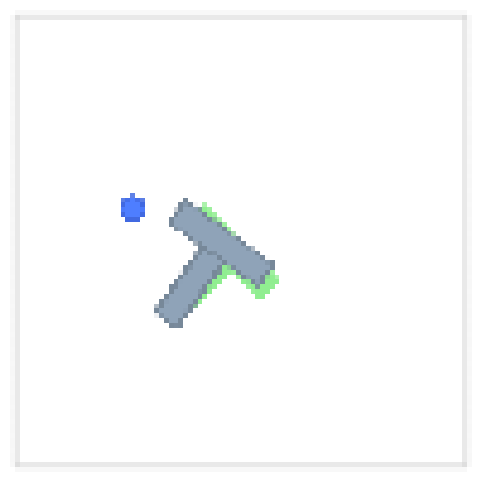

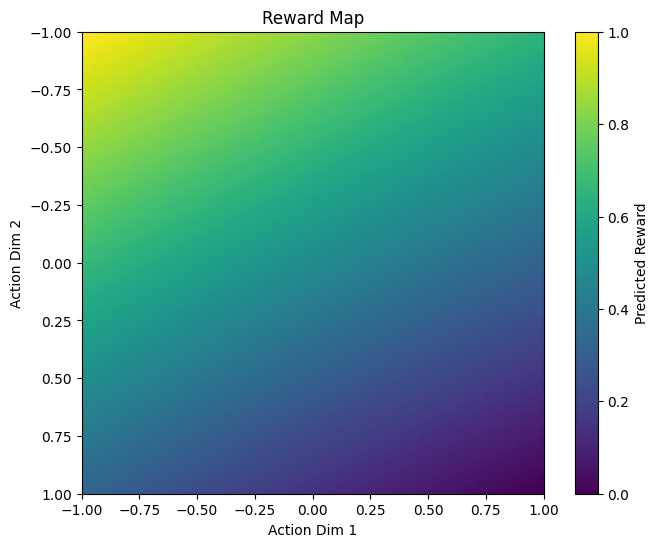

In [9]:
def generate_reward_map(policy, obs, state, resolution=100):
    """Generate a reward landscape by scanning over possible actions.
    Args:
        policy: The trained CVAE policy
        obs: Image observation tensor of shape (1,3,96,96) 
        state: State tensor of shape (1,2)
        resolution: Number of points to sample in each action dimension
        
    Returns:
        actions: (resolution*resolution, 14) tensor of sampled actions
        rewards: (resolution*resolution,) tensor of predicted rewards
    """
    # Encode state and observation
    with torch.no_grad():
        zs = policy.state_encoder(obs, state)
        
        # Create action grid from (-1,-1) to (1,1)
        x = torch.linspace(-1, 1, resolution)
        y = torch.linspace(1, -1, resolution)  # Reversed y range
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        
        # Create full action tensor with zeros
        actions = torch.zeros((resolution*resolution, 14), device=obs.device)
        # Fill first two dimensions with grid values
        for i in range(1):
            actions[:, 2*i] = xx.flatten()
            actions[:, 2*i+1] = yy.flatten()

        
        # Encode each action
        za_list = []
        rewards = []

        # Process in batches to avoid memory issues
        batch_size = 100
        z = torch.randn(1,64).repeat(batch_size,1).cuda()
        for i in range(0, len(actions), batch_size):
            action_batch = actions[i:i+batch_size]
            
            # Encode action
            za = policy.action_encoder(action_batch)
            
            # # Get latent from encoder
            # z_mu, z_logvar = policy.fusing_encoder(
            #     zs.repeat(len(action_batch),1), 
            #     za
            # )

            # z = policy.reparameterize(z_mu,z_logvar)
            
            
            # Decode reward
            reward = policy.reward_decoder(
                zs.repeat(len(action_batch),1),
                za, 
                z
            )
            rewards.append(reward)
            
        rewards = torch.cat(rewards, dim=0)
        
        rewards = rewards.squeeze(-1).cpu().numpy()

        # Normalize rewards to [0,1] range
        rewards = (rewards - rewards.min()) / (rewards.max() - rewards.min())

        action = actions.cpu().numpy()

        # Reshape rewards for plotting
        reward_grid = rewards.reshape(100,100)


        
        # Plot and save observation image
        dir = "./output/img"
        plt.figure(figsize=(8,6))
        obs_img = obs.squeeze().permute(1,2,0).cpu().numpy()
        plt.imshow(obs_img)
        plt.axis('off')
        plt.savefig(f'{dir}/observation.png')
        plt.show()
        
        # Plot and save reward map
        plt.figure(figsize=(8,6))
        plt.imshow(reward_grid, extent=[-1,1,1,-1], origin='lower')
        plt.colorbar(label='Predicted Reward')
        plt.xlabel('Action Dim 1')
        plt.ylabel('Action Dim 2') 
        plt.title('Reward Map')
        plt.savefig(f'{dir}/reward_map.png')
        plt.show()

        return action, rewards

# Example usage:
obs = batch['observation.image'][0].cuda()
state = batch['observation.state'][0].cuda()/512 * 2 - 1
action, rewards = generate_reward_map(policy, obs, state)


In [94]:
# config_dict = {
#         "horizon": 7,
#         "action_dim": 2,
#         "state_dim": 512*3*3 + 2,
#         "batch_size": 16,
#         "latent_dim_state": 50,
#         "latent_dim_action": 2,  # Same as action_dim
#         "posterior_dim": 64,
#         "beta": 1.0,
#         "training_steps": 3000,
#         "learning_rate": 3e-4,
#         "max_iterations": 50,
#         "step_size": 1e-4,
#         "damping": 1e-3,
#         "min_std": 1e-4,
#         "discount": 0.9,
#         "log_freq": 1,
#         "eval_freq": 40,
#         "output_directory": "./output",
#         "device": "cuda:0",
#         "gradient_accumulation_steps": 4,  # Added gradient accumulation config
#         "eval_split": 0.05
#     }

# config = Config(config_dict)
# policy_ = CVAEWithTrajectoryOptimization(config)

In [97]:
# checkpoint = torch.load("./output/best_model_/model.pt")

/tmp/ipykernel_2867674/804462426.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("./output/best_model_/model.pt")


In [100]:
# policy_.state_encoder.load_state_dict(checkpoint['state_encoder'])
# policy_.action_encoder.load_state_dict(checkpoint['action_encoder'])
# policy_.fusing_encoder.load_state_dict(checkpoint['fusing_encoder'])
# policy_.dynamics_function.load_state_dict(checkpoint['dynamics_function'])
# policy_.action_decoder.load_state_dict(checkpoint['action_decoder'])
# policy_.reward_decoder.load_state_dict(checkpoint['reward_decoder'])

<All keys matched successfully>

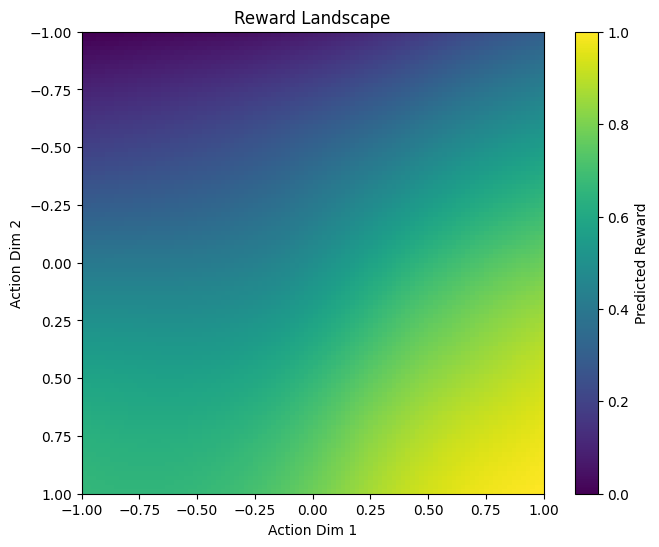

In [101]:
# action, rewards = generate_reward_map(policy_, obs, state)


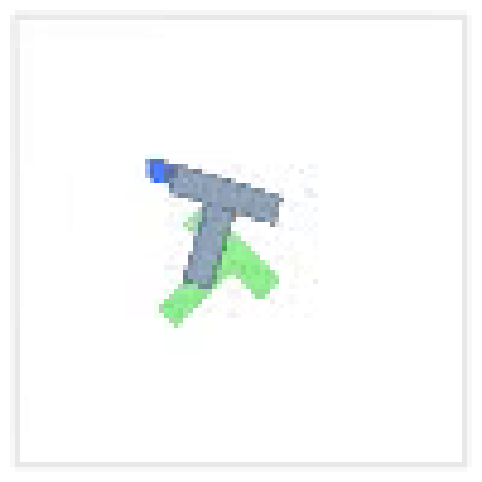

In [78]:
# plt.figure(figsize=(8,6))
# plt.imshow(obs.squeeze().permute(1,2,0).cpu().numpy())
# plt.axis('off')
# plt.show()